# Introduction to Normalizing Flows for Lattice Field Theory

*January 20, 2020*

**[Michael S. Albergo (NYU)](mailto:albergo@nyu.edu), [Denis Boyda (MIT)](mailto:boyda@mit.edu), [Daniel C. Hackett (MIT)](mailto:dhackett@mit.edu), [Gurtej Kanwar (MIT)](mailto:gurtej@mit.edu), Kyle Cranmer (NYU), Sébastien Racanière (DeepMind), Danilo Jimenez Rezende (DeepMind),  Phiala E. Shanahan (MIT)**


In this notebook tutorial, we describe and demonstrate a method for simulating lattice field theories through the use of normalizing flows, which allow sampling from complicated probability distributions using neural networks. We will:

**1.** Introduce the ideas behind normalizing flows and explain how to efficiently construct them

**2.** Apply them to a lattice scalar field theory

**3.** Demonstrate how to construct flows which explicitly encode gauge symmetries, and apply this to U(1) gauge theory

This notebook is based on ideas and approaches proposed in [arXiv:1904.12072](https://inspirehep.net/literature/1731778), [arXiv:2002.02428](https://inspirehep.net/literature/1779199), and [arXiv:2003.06413](https://inspirehep.net/literature/1785309) and can be considered as supplementary materials to these papers. Please cite these works in lieu of this pedagogical presentation.

To run this notebook on the cloud with GPU resources, we suggest uploading it to [Google Colab](https://colab.research.google.com/).

We begin by defining a few utilities and importing common packages. Readers may safely execute and skip over the remainder of this section.

In [1]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

TORCH VERSION: 1.7.1


In [2]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


In [3]:
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi

Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy array.

In [4]:
def grab(var):
    return var.detach().cpu().numpy()

The code below makes a live-updating plot during training.

In [5]:
from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)
    
    ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')
    
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    
    plt.xlabel('Epoch')

    display_id = display(fig, display_id=True)

    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

# Notation
This section is intended as a reference. The phrases and notation listed here will be defined in detail in the remainder of the notebook.

1. __Notation for generic normalizing flows__
  *  Coordinates $z, x \in$ some manifold $\mathcal{X}$ (a space with local $\mathbb{R}^n$ structure)  
   The manifolds used here are $\mathcal{X} = \mathbb{R}^n$ (for scalar field theory) and $\mathcal{X} = \mathbb{T}^n$ (for $\mathrm{U}(1)$ gauge theory) where $\mathbb{T}^n$ refers to the n-dimensional torus.
  *  Probability densities over those manifolds,
      *  Prior density $r(z)$ 
      *  Model density $q(x)$
      *  Target density $p(x)$
  *  Normalizing flow $f: \mathcal{X} \rightarrow \mathcal{X}$, invertible and differentiable
  *  Jacobian factor $J(z) = |\det_{ij} \partial f_i(z) / \partial z_j|$
  *  Coupling layer $g: \mathcal{X} \rightarrow \mathcal{X}$, invertible and differentiable
  *  Subsets of the components of the coordinate $x = (x_1, x_2)$, where the choice of subsets will be clear from context

2. __Notation for lattice field theories__
  *  Lattice spacing $a$  
  We work in "lattice units" where $a=1$.
  *  Spacetime dimension $N_d$  
  We work in this notebook with $N_d=2$.
  *  Lattice extent $L$, with volume $V = L^{N_d} = L^2$, in lattice units where $a=1$.
  *  Lattice position $\vec{x} = a\vec{n} \equiv (an_x, an_y)$, with $\vec{x}=\vec{n}$ in lattice units where $a=1$. We use $n_x, n_y \in [0, L-1]$.

3. __Notation for normalizing flows targeting scalar lattice field theory__ 
  *  Field configurations $z \in \mathbb{R}^V$ or $\phi \in \mathbb{R}^V$, corresponding to $z$ or $x$ in the generic notation
  *  $\phi(\vec{n})$ denotes the field configuration which lives on the sites of the lattice, while $\phi_{\vec{n}}$ denotes the unraveled 1D vector of lattice DOF
  *  Action $S[\phi] \in \mathbb{R}$
  *  Discretized path integral measure $\prod_{\vec{n}} d\phi_{\vec{n}}$

4. __Notation for normalizing flows targeting U(1) lattice gauge theory__
  *  Field configurations $U \in \mathbb{T}^{N_d V}$ or $U' \in \mathbb{T}^{N_d V}$, corresponding to $z$ or $x$ in the generic notation
  *  $U_\mu(\vec{n})$ denotes the component of field configuration $U$ which lives on the link $(n, n+\hat{\mu})$ of the lattice, where $\mu \in [0, N_d-1]$ indicates the Cartesian direction. $U_{\mu,\vec{n}}$ denotes the unraveled 1D vector of lattice DOF
  *  Action $S[U] \in \mathbb{R}$
  *  Angular parameterization of each component $U_{\mu, \vec{n}} \equiv e^{i\theta_{\mu, \vec{n}}}$
  *  Discretized path integral measure $\prod_{\mu,\vec{n}} dU_{\mu,\vec{n}}$, where $dU_{\mu, \vec{n}} = d\theta_{\mu, \vec{n}}$ is the Haar measure for $\mathrm{U}(1)$


# Normalizing flows (for lattice QFTs)

A powerful method to generate samples from complicated distributions is to combine (1) sampling from a simpler / tractable distribution with (2) applying a deterministic change-of-variables (a _normalizing flow_) to the output samples. The transformed samples are distributed according to a new distribution which is determined by the initial distribution and change-of-variables. These two components together define a _normalizing flow model_. See <span data-cite="papamakarios2019normalizing">[1912.02762]</span> for a review.



## **A simple example**
The Box-Muller transform is an example of this trick in practice: to produce Gaussian random variables, draw two variables $U_1$ and $U_2$ from $\text{unif}(0,1)$ then change variables to

\begin{equation}
    Z_1 = \sqrt{-2 \ln{U_1}} \cos(2\pi U_2)
    \quad \text{and} \quad
    Z_2 = \sqrt{-2 \ln{U_1}} \sin(2\pi U_2).
\end{equation}

The resulting variables $Z_1, Z_2$ are then distributed according to an uncorrelated, unit-variance Gaussian distribution.


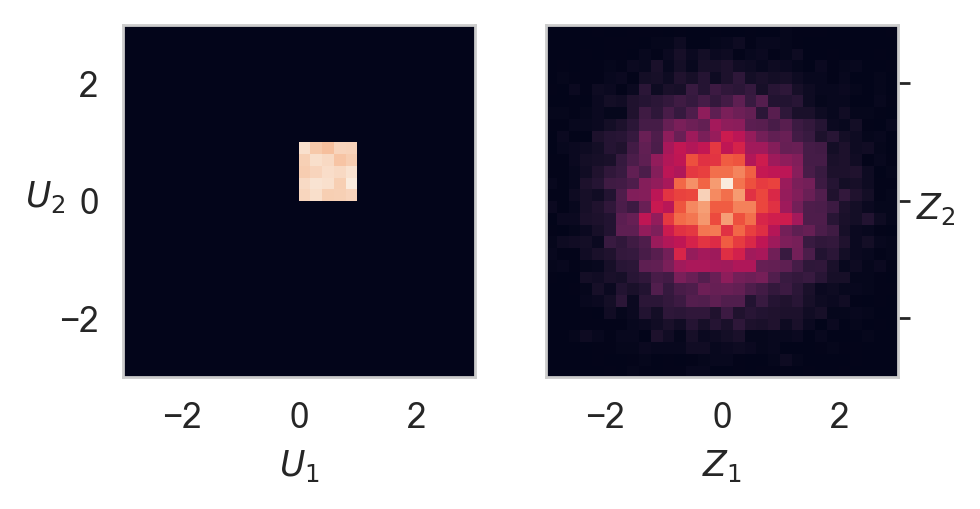

In [8]:
batch_size = 2**14
u = np.random.random(size=(batch_size, 2))
z = np.sqrt(-2*np.log(u[:,0]))[:,np.newaxis] * np.stack(
    (np.cos(2*np.pi*u[:,1]), np.sin(2*np.pi*u[:,1])), axis=-1)

fig, ax = plt.subplots(1,2, dpi=125, figsize=(4,2))
for a in ax:
    _ = a.set_xticks([-2, 0, 2])
    _ = a.set_yticks([-2, 0, 2])
    _ = a.set_aspect('equal')
_ = ax[0].hist2d(u[:,0], u[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
_ = ax[0].set_xlabel(r"$U_1$")
_ = ax[0].set_ylabel(r"$U_2$", rotation=0, y=.46)
_ = ax[1].hist2d(z[:,0], z[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
_ = ax[1].set_yticklabels([])
_ = ax[1].set_xlabel(r"$Z_1$")
_ = ax[1].set_ylabel(r"$Z_2$", rotation=0, y=.53)
_ = ax[1].yaxis.set_label_position("right")
_ = ax[1].yaxis.tick_right()


We can analytically compute the density associated with output samples by the **change-of-variables formula** relating the _prior density_ $r(U_1, U_2) = 1$ to the _output density_ $q(Z_1, Z_2)$:

\begin{equation}
\begin{split}
    q(Z_1, Z_2) &= r(U_1, U_2) \left| \det_{kl} \frac{\partial Z_k(U_1, U_2)}{\partial U_l} \right|^{-1} \\
    &= 1 \times \left| \det \left( \begin{matrix}
        \frac{-1}{U_1 \sqrt{-2 \ln{U_1}}} \cos(2\pi U_2) &
        - 2\pi \sqrt{-2 \ln{U_1}} \sin(2\pi U_2) \\
        \frac{-1}{U_1 \sqrt{-2 \ln{U_1}}} \sin(2\pi U_2) &
        2\pi \sqrt{-2 \ln{U_1}} \cos(2\pi U_2)
        \end{matrix} \right) \right|^{-1} \\
    &= \left| \frac{2 \pi}{U_1} \right|^{-1}.
\end{split}
\end{equation}

Here, the term $J(U_1, U_2) \equiv \left| \det_{kl} \frac{\partial Z_k(U_1, U_2)}{\partial U_l} \right|$ is the determinant of the Jacobian of the transformation from $(U_1,U_2)$ to $(Z_1,Z_2)$. Intuitively, the Jacobian factor can be thought of as a change in volume element, therefore the change-of-variables formula must contain the inverse of this factor (spreading out volume decreases density). To complete the example, we can rearrange the change of variables to find $U_1 = \exp(-(Z_1^2 + Z_2^2) / 2)$ and therefore
\begin{equation}
    q(Z_1, Z_2) = \frac{1}{2\pi} e^{-(Z_1^2 + Z_2^2)/2}.
\end{equation}

**NOTE**: In this example, the model has no free parameters because we didn't need any to create a transform that exactly reproduced our target distribution (independent, unit-variance Gaussian). In general, we may not know a normalizing flow that exactly produces our desired distribution, and so instead construct parametrized models that we can variationally optimize to _approximate_ that target distribution, and because we can compute the density these can be corrected to nevertheless guarantee exactness.

## **The general approach**
Generalizing this example, it is clear that any invertible and differentiable function $f(z)$ will transform a prior density $r(z)$ on the (possibly multi-dimensional) random variable $z$ to an output density $q(x)$ on $x \equiv f(z)$. If the Jacobian factor $J(z) \equiv |\det_{kl} \partial f_k(z) / \partial z_l |$ is efficiently calculable, we can compute the output density **alongside** any samples drawn using the change-of-variables formula,
\begin{equation}
    q(x) = r(z) [J(z)]^{-1} = r(z) \left|\det_{kl} \frac{\partial f_k(z)}{ \partial z_l} \right|^{-1}.
\end{equation}

In some cases, it is easy to compute the Jacobian factor even when the whole Jacobian matrix is intractable; for example, only the diagonal elements are needed if the Jacobian matrix is known to be triangular. Below we will see how to construct $f$ with a triangular Jacobian using _coupling layers_.

In lattice field theory simulations, our goal is to draw samples from a distribution over lattice field configurations defined by the imaginary-time path integral. By optimizing the function $f$ we hope to find an output distribution that closely models this desired physical distribution. If the family of functions is **expressive** (i.e. includes a wide variety of possible functions) we expect the optimal choice to be a good approximation to the true distribution. Moreover, we can make the task of searching for the optimal choice more efficient by restricting to functions that guarantee certain **symmetries** in the output distribution. Once we have a good approximation to the output distribution, we can draw samples from it and use MCMC methods or reweighting to correct their statistics to the exact distribution of interest.

## **Prior distributions**
Any probability distribution that is easy to sample from and has calculable density $r(z)$ can be used as the prior distribution.

In code, our interface mimics a subset of the pytorch `Distribution` interface. For example, below we define a prior distribution corresponding to uncorrelated Gaussians (one per component of the field). Any other distribution you may want to define should provide analogous methods `log_prob` and `sample_n`.

In [9]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
            torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

The shape of `loc` and `var` determine the shape of samples drawn.

In [10]:
normal_prior = SimpleNormal(torch.zeros((3,4,5)), torch.ones((3,4,5)))
z = normal_prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(normal_prior.log_prob(z))}')

z.shape = torch.Size([17, 3, 4, 5])
log r(z) = [-95.59121458 -82.8813276  -83.72547228 -82.26320473 -96.60098563
 -87.04034488 -90.33158015 -84.60935836 -95.00661754 -78.86394019
 -92.9233203  -81.18776599 -89.84527017 -77.4809767  -87.76484068
 -81.79773597 -80.72714469]


We use `SimpleNormal` as the prior distribution for scalar field theory, and later define a uniform distribution as the prior distribution for $\mathrm{U}(1)$ gauge theory.

## **Designing the flow $f$**
As a reminder, a normalizing flow $f$ must be **invertible** and **differentiable**. To be useful, it should also be efficient to compute the Jacobian factor and be expressive.

Expressive functions can be built through composition of simpler ones. When each simpler function is invertible and differentiable, the composed function is as well. Schematically, this subdivides the task of learning a complicated map as below:

<div align="center">
    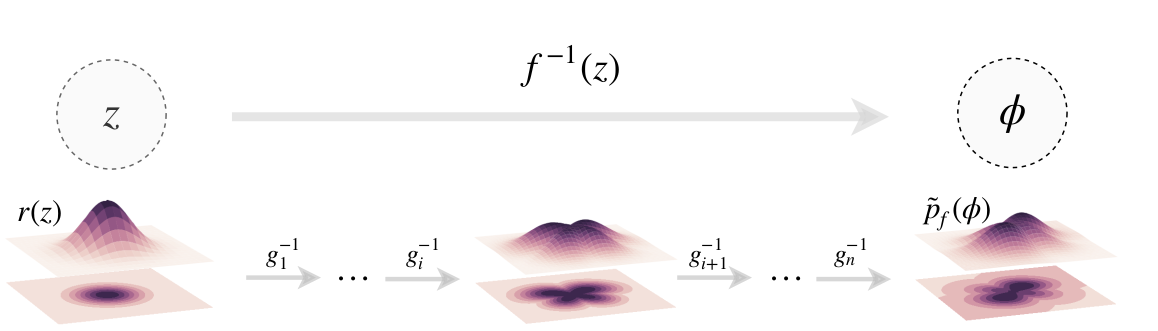
</div>
<div align="center">Fig. 1 of [1904.12072]. The notation superficially differs from what we present here.</div>

**Coupling layers** are one approach to defining the $g_i$ in the composed function. These functions are defined to update only a subset of the input variables, conditioned on the complimentary ("frozen") subset. For example, if the input to a coupling layer was a lattice with one real number per site, the layer could be defined to update only the odd sites in a checkerboard pattern. To ensure all variables are updated, we could then compose coupling layers that alternatingly update odd sites and even sites.

In a coupling layer, the transform applied to the updated subset of variables is manifestly a simply inverted operation such as a scaling ($x \rightarrow e^s x$) or affine transformation ($x \rightarrow e^s x + t$). For example, a coupling layer $g(x_1, x_2) = (x_1', x_2')$ based on an scaling transformation looks like

\begin{equation}
\begin{split}
  x_1 '  &= e^{s(x_2)}x_1 \\
  x_2 '  &= x_2
\end{split}
\end{equation}

where $x_1, x_2$ are subsets of the components of $x$. We say that $x_1$ is _updated_ based on the _frozen_ subset $x_2$, which is not changed by the coupling layer. $e^{s(x_2)}$ is a vector of the same shape as $x_1$, and $e^{x(s_2)} x_1$ denotes an elementwise product. The _parameters defining the transform_, $s(x_2)$, can be complicated, non-invertible functions of the frozen subset of variables.  However, the inverse of this transformation $g^{-1} (x_1', x_2') = (x_1, x_2)$ is simply computed using the same parameters,

\begin{equation}
\begin{split}
x_1  &= e^{-s(x_2')} x_1' \\
x_2  &= x_2'.
\end{split}
\end{equation}

Here the key to guaranteeing invertibility is that $x_2 = x_2'$. This "trick" is exactly what guarantees invertibility for leapfrog integrators, which alternately update position and momentum variables.

This also ensures a triangular Jacobian,
\begin{equation}
\frac{\partial g(x_1, x_2)}{\partial x} =
\left( \begin{matrix}
    \frac{\partial x_1'}{\partial x_1} & \frac{\partial x_1'}{\partial x_2} \\
    0 & 1
\end{matrix} \right),
\end{equation}
which in the scaling example takes the form
\begin{equation}
\frac{\partial g(x_1, x_2)}{\partial x} =
\left( \begin{array}{ccc|ccc}
    e^{[s(x_2)]_1} & & & \cdot & \cdot & \cdot \\
    & e^{[s(x_2)]_2} & & \cdot & \cdot & \cdot \\
    & & \ddots & \cdot & \cdot & \cdot \\
    \hline
    & & & 1 & & \\
    & 0 & & & 1 & \\
    & & & & & \ddots
\end{array} \right)
\end{equation}
where we have expanded the blocks over $(x_1', x_2') \times (x_1, x_2)$ from the first expression.
Therefore $J(x)$ is efficiently computed as
\begin{equation}
J(x) = \left|\det_{kl} \frac{\partial [g(x_1, x_2)]_k}{\partial x_l} \right| = \prod_{k} e^{[s(x_2)]_k}
\end{equation}
where $k$ runs over the components in $s(x_2)$. The Jacobian of the inverse transformation is simply $J_\text{reverse}(x') = 1/J(x') = \prod_k e^{[-s(x_2')]_k}$; note that here we were able to compute the reverse Jacobian in terms of the forward Jacobian applied to $x'$ because of the simplicity of the coupling layer.

The coupling layer architecture makes it easier to guarantee invertibility while retaining expressivity: the functions which provide the parameters of  the transformation are flexible while the inverse and Jacobian factor of such coupling transformations are easy to compute. Many such coupling layers can be stacked to compose expressive functions $f$ efficiently.


## **Simple coupling layer demo**

To demonstrate coupling layers in practice, we define a coupling layer using scaling (see above) for two-dimensional inputs $x \equiv (x_1,x_2)$ [i.e. in comparison to the previous section, here $x_1$ and $x_2$ are just scalars]. Because we have the freedom to make the function $s(x_2)$ arbitrarily complex without sacrificing invertibility, we parametrize $s(x_2)$ as a neural net made of alternating layers of linear transformations and ReLU ("rectified linear unit") activation functions, with a $\tanh$ activation function after the final linear transform.

<!--Although the neural net defined in the code below is very simple by NN standards, $s$ already has 36 free parameters. Altogether, this construction allows for very flexible behavior while remaining invertible.-->

We implement coupling layers as an extension of `torch.nn.Module` to include application of $g$ (see `forward`) and inverse $g^{-1}$ (see `reverse`). These both map from the domain of lattice degrees of freedom to itself, $\mathcal{X} \rightarrow \mathcal{X}$; in this case, this is just $\mathbb{R}^2 \rightarrow \mathbb{R}^2$. The superclass automatically holds references to all tunable parameters (weights) that will later be optimized.

In [11]:
class SimpleCouplingLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Tanh()
        )
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        fx1 = torch.exp(s) * x1
        fx2 = x2
        logJ = s
        return torch.stack((fx1, fx2), dim=-1), logJ
    def reverse(self, fx):
        fx1, fx2 = fx[:,0], fx[:,1]
        x2 = fx2
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        logJ = -s
        x1 = torch.exp(-s) * fx1
        return torch.stack((x1, x2), dim=-1), logJ

coupling_layer = SimpleCouplingLayer()

# init weights in a way that gives interesting behavior without training
def set_weights(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)
torch.manual_seed(1234)
coupling_layer.s.apply(set_weights);

Let's see what our simple coupling layer $g$ does. We draw a batch of samples $x$ from an arbitrary input distribution (uniform in $[0,1]^2$), feed it through the coupling layer forwards to get samples $g(x)$ from a new distribution, then feed $g(x)$ backwards through the coupling layer to double-check that we recover our original sample $x' = g^{-1}(g(x)) \overset{!}{=} x$.

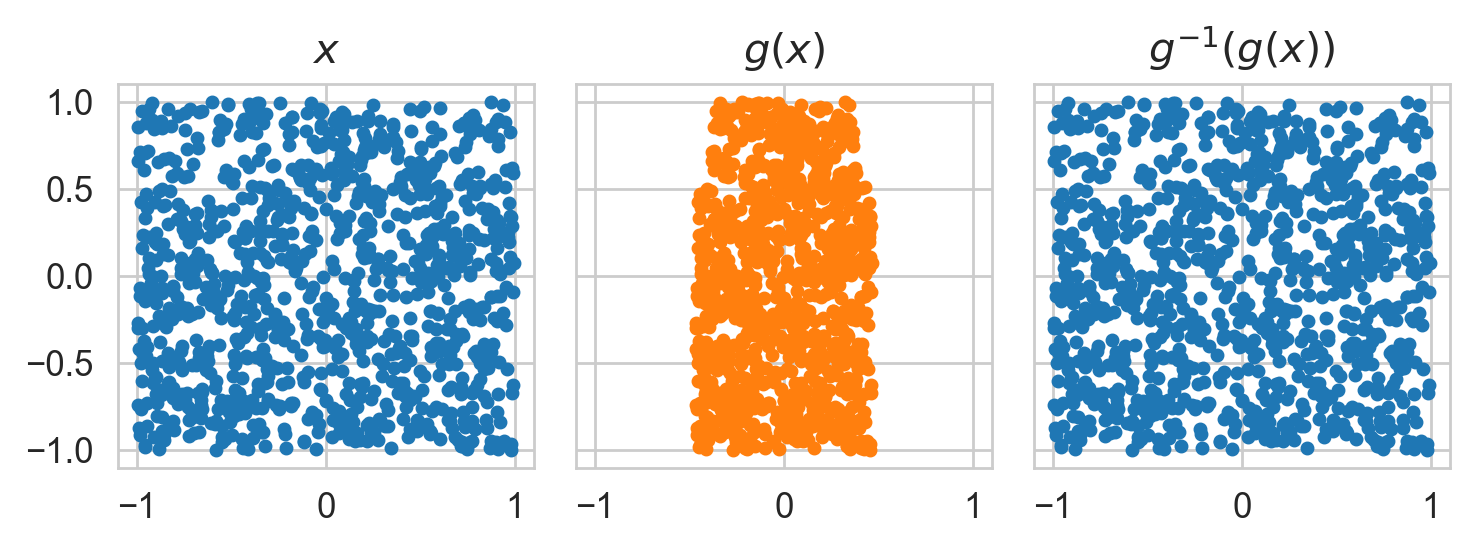

In [13]:
batch_size = 1024
np_x = (2*np.random.random(size=(batch_size, 2)) - 1).astype(float_dtype)
x = torch.from_numpy(np_x).to(torch_device)

gx, fwd_logJ = coupling_layer.forward(x)
xp, bwd_logJ = coupling_layer.reverse(gx)

fig, ax = plt.subplots(1,3, dpi=125, figsize=(6,2.3), sharex=True, sharey=True)
np_gx, np_xp = grab(gx), grab(xp)
for a in ax:
    _ = a.set_xlim(-1.1,1.1)
    _ = a.set_ylim(-1.1,1.1)
_ = ax[0].scatter(np_x[:,0], np_x[:,1], marker='.')
_ = ax[0].set_title(r'$x$')
_ = ax[1].scatter(np_gx[:,0], np_gx[:,1], marker='.', color='tab:orange')
_ = ax[1].set_title(r'$g(x)$')
_ = ax[2].scatter(np_xp[:,0], np_xp[:,1], marker='.')
_ = ax[2].set_title(r"$g^{-1}(g(x))$")
_ = fig.set_tight_layout(True)

## **Composition**

The Jacobian factors $J_i$ from each coupling layer simply multiply together to define the Jacobian factor of the composed function, so that the final density is
\begin{equation}
\begin{split}
    q(x) &= r(z) \left| \det \frac{\partial f(z)}{\partial z} \right|^{-1} = r(z) \prod_{i} J_i^{-1}.
\end{split}
\end{equation}
In practice, we'll add together log Jacobians instead. Altogether, sampling and computing the density is simple composition.

In [14]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
    x = prior.sample_n(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

# Application 1: $\phi^4$ lattice scalar field theory in 2d

As an example, we consider applying normalizing flows to sampling the distributions associated with scalar field theory in two spacetime dimensions with a $\phi^4$ interaction. See <span data-cite="Albergo:2019eim">[1904.12072]</span> for details.

## **Physical theory**

The continuum theory consists of a single real scalar field $\phi(\vec{x})$ as a function of 2D coordinates $\vec{x}$. To access non-perturbative results, such as behavior in the strong-coupling regime, we can regularize the theory on a 2D lattice, assigning one real degree of freedom per site of the lattice. Let's initialize some configurations of an example lattice of size $8\times8$ and generate two random configurations:

In [15]:
L = 8
lattice_shape = (L,L)

phi_ex1 = np.random.normal(size=lattice_shape).astype(float_dtype)
phi_ex2 = np.random.normal(size=lattice_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0)).to(torch_device)


A simple discretization of the derivatives in the continuum Euclidean action gives rise to a valid lattice Euclidean action,
\begin{equation}
\begin{split}
S^E_{\text{cont}}[\phi] &= \int d^2\vec{x} ~ (\partial_\mu \phi(\vec{x}))^2 + m^2 \phi(\vec{x})^2 + \lambda \phi(\vec{x})^4 \\
\rightarrow S^E_{\text{latt}}(\phi) &= \sum_{\vec{n}} \phi(\vec{n}) \left[ \sum_{\mu \in \{1,2\}} 2\phi(\vec{n}) - \phi(\vec{n}+\hat{\mu}) - \phi(\vec{n}-\hat{\mu}) \right] + m^2 \phi(\vec{n})^2 + \lambda \phi(\vec{n})^4
\end{split}
\end{equation}
where now $\phi(\vec{n})$ is only defined on the sites of the $L_x \times L_y$ lattice, $\vec{n} = (n_x, n_y)$, with integer $n_x, n_y$. We have implicitly moved to "lattice units" where $a=1$ such that $L_x, L_y, V$ are integers and all quantities are unitless. The discretized field $\phi$ can therefore be thought of as an $(L_x \times L_y)$-dimensional vector. We use periodic boundary conditions in all directions, i.e. $\phi(L_x, y) \equiv \phi(0, y)$, etc. For convenience, we typically abbreviate $S^E_{\text{latt}} \equiv S$.

More details on $\phi^4$ lattice scalar field theory can be found in <span data-cite="vierhaus2010simulation">[this thesis](https://edoc.hu-berlin.de/bitstream/handle/18452/14790/schroeder.pdf?sequence=1)</span>.

The lattice action then defines a probability distribution over configurations $\phi$,
\begin{equation}
p(\phi) = \frac{1}{Z} e^{-S(\phi)}, \quad
Z \equiv \int \prod_{\vec{n}} d\phi(\vec{n}) ~ e^{-S(\phi)},
\end{equation}
where $\prod_{\vec{n}}$ runs over all lattice sites $\vec{n}$.
This is the distribution we are training the normalizing flows to reproduce. While $Z$ is difficult to calculate, in practice we only need $p(\phi)$ up to a constant. The action can be efficiently calculated on arbitrary configurations using Pytorch. Note that while the theory describes 2D spacetime, the dimensionality of distribution $p(\phi)$ is the number of lattice sites, scaling with the volume of the lattice.

In [16]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam
    def __call__(self, cfgs):
        # potential term
        action_density = self.M2*cfgs**2 + self.lam*cfgs**4
        # kinetic term (discrete Laplacian)
        Nd = len(cfgs.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*cfgs**2
            action_density -= cfgs*torch.roll(cfgs, -1, mu)
            action_density -= cfgs*torch.roll(cfgs, 1, mu)
        return torch.sum(action_density, dim=tuple(dims))

print("Actions for example configs:", ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs))

Actions for example configs: tensor([461.4872, 432.2369])


The theory has a symmetric phase and a broken symmetry phase, corresponding respectively to nearly one mode of the distribution or two widely separated modes (with intermediate configurations suppressed exponentially in volume). The broken symmetry phase can be accessed for $m^2 < 0$ and $\lambda$ less than a critical $\lambda_c$. For simplicity, we restrict focus to the **symmetric phase**, but remain close to this phase transition such that the system has a non-trivial correlation length.

In [17]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

## **Prior distribution**

We choose the prior distribution to be I.I.D. Gaussians at each lattice site. This is easy to sample from, and intuitively gives the coupling layers a "blank slate" from which to build in correlations.

In [18]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

We can use the `draw` function to acquire samples from the prior. Some samples drawn from the prior are visualized below.

z.shape = (1024, 8, 8)


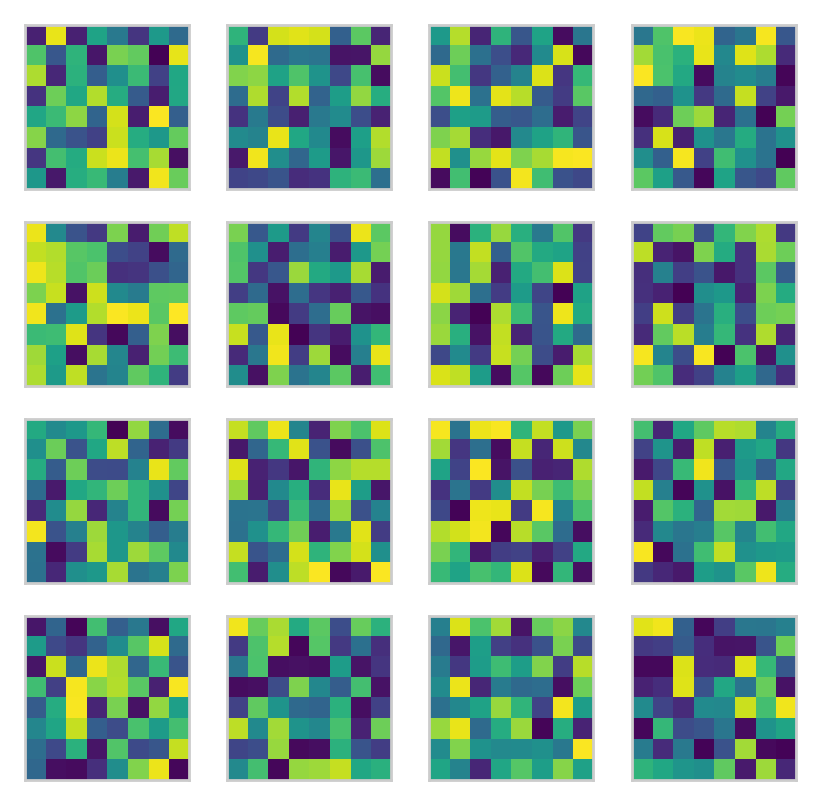

In [20]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        _ = ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        _ = ax[i,j].axes.xaxis.set_visible(False)
        _ = ax[i,j].axes.yaxis.set_visible(False)

These samples look nothing like typical lattice configurations for the theory, which should exhibit patches of correlated positive and negative fluctuations (see configurations drawn from the true distribution in later sections). Samples from the prior do not have any correlations.

Below we show two-way histograms between various sites, demonstrating the uncorrelated nature of the prior distribution.

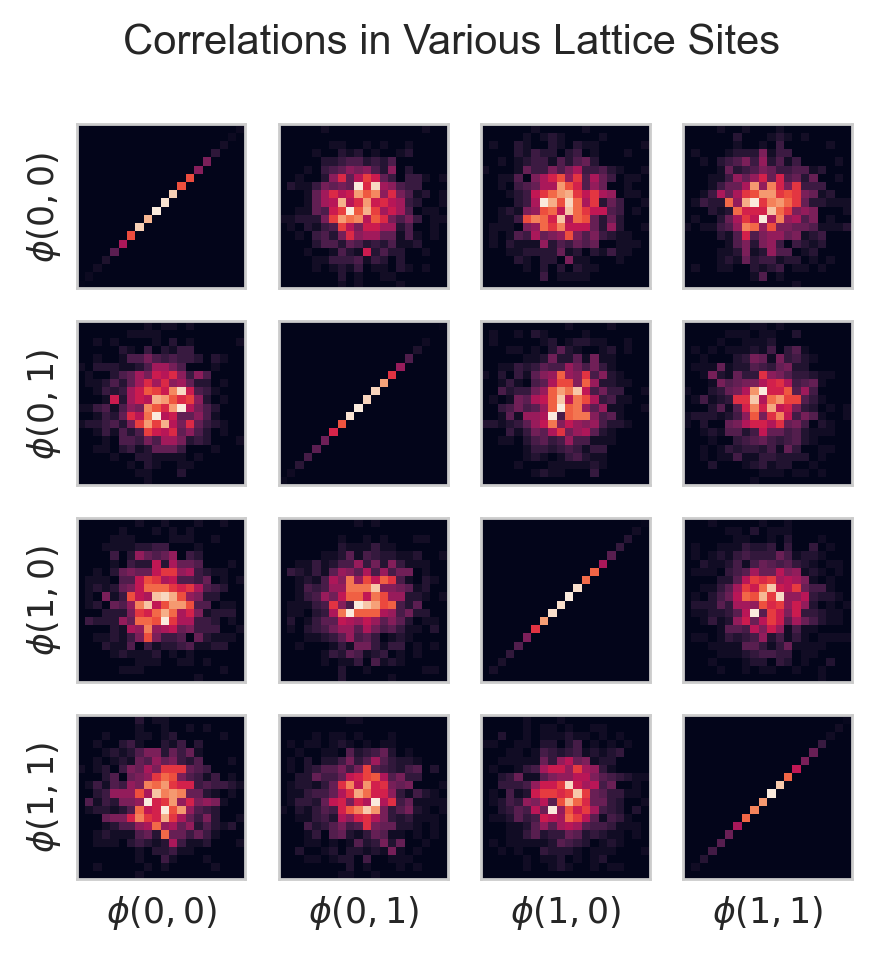

In [24]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
    for y1 in range(2):
        i1 = x1*2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2*2 + y2
                _ = ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
                _ = ax[i1,i2].set_xticks([])
                _ = ax[i1,i2].set_yticks([])
                if i1 == 3:
                    _ = ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$')
                if i2 == 0:
                    _ = ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$')
_ = fig.suptitle("Correlations in Various Lattice Sites")

We can also investigate the correlation between the "effective action" defining the model distribution (here, $-\log{r}(z)$) and the true action ($S(z)$). If the prior distribution was already a good model for the true distribution, all samples should have identical action under the prior and true distributions, up to an overall shift. In other words, these should have linear correlation with slope $1$.

slope 1 linear regression S = -logr + 1416.9005


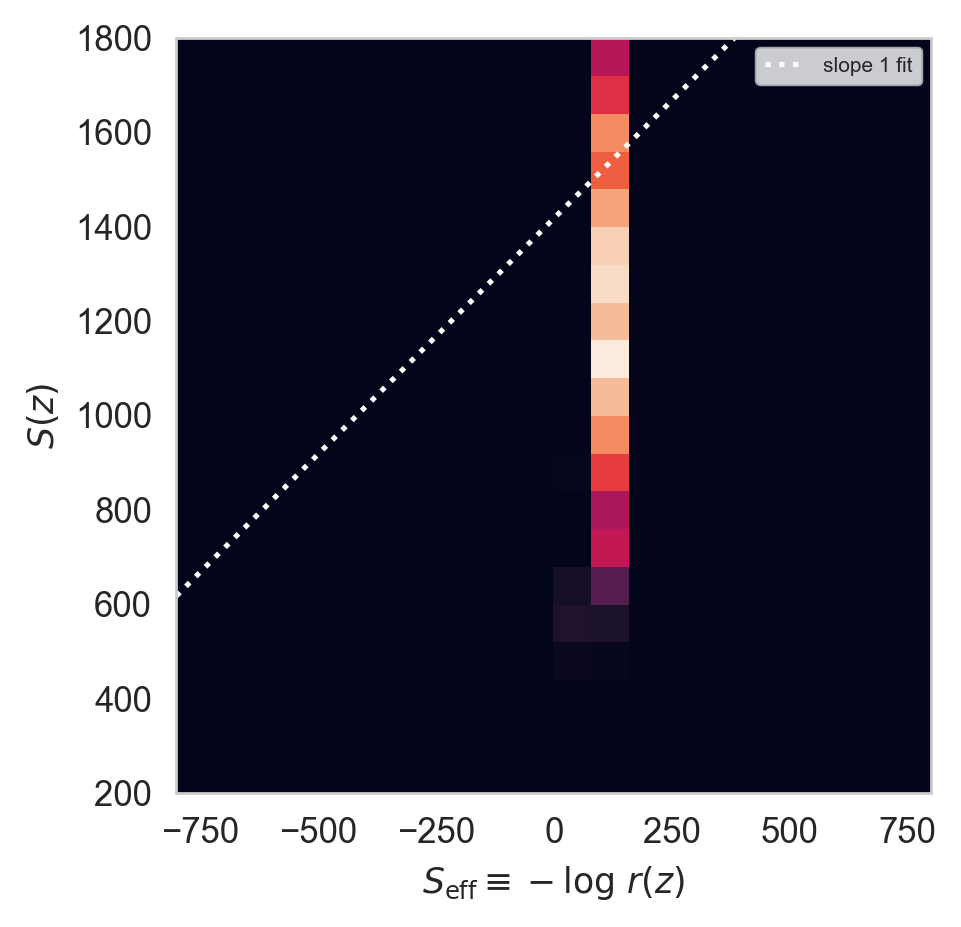

In [25]:
S_eff = -grab(prior.log_prob(torch_z))
S = grab(phi4_action(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
_ = ax.hist2d(S_eff, S, bins=20, range=[[-800, 800], [200,1800]])
xs = np.linspace(-800, 800, num=4, endpoint=True)
_ = ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
_ = ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$')
_ = ax.set_ylabel(r'$S(z)$')
_ = ax.set_aspect('equal')
_ = plt.legend(prop={'size': 6})

As expected, we are far from that goal because we have not flowed yet! We will revisit this plot after including and training the change-of-variables $f$.


## **Affine coupling layers**

As mentioned earlier, an affine transformation is a particularly simple, yet effective, transform to use within a coupling layer acting on real degrees of freedom. The transformation of the subset of variables $\phi_1$, conditioned on the frozen subset $\phi_2$, is defined as
\begin{equation}
    g(\phi_1, \phi_2) = \left(e^{s(\phi_2)} \phi_1 + t(\phi_2),  \phi_2\right),
\end{equation}
with inverse given by:
\begin{equation} g^{-1}(\phi_1', \phi_2') =  \left((\phi_1' - t(\phi_2')) e^{-s(\phi_2')}, \phi_2'\right)  \end{equation}
where $s(\phi_2)$ and $t(\phi_2)$ produce vectors of the same dimension as $\phi_1$ and operations above are element-wise on these vectors. We define the functions $s$ and $t$ using a feed-forward neural network. The coupling layer leaves $\phi_2$ unchanged. Note that this is just a simple extension of the scaling transformation introduced above, with a constant offset $t(\phi_2)$ added to the transformation.



The Jacobian factor for such an affine transformation is easy to compute (both analytically and numerically). In fact, because $\partial [t(\phi_2)] / \partial \phi_1 = 0$, the Jacobian is the same as for the scaling transformation worked out above. In practice, we work with log probabilities, so we note that the forward and reverse transformation return
\begin{align}
&&\text{forward:} \qquad &\log J(\phi) &&= \sum_k [s(\phi_2)]_k \\ 
&&\text{reverse:} \qquad &\log J_\text{reverse}(\phi') &&= \sum_k -[s(\phi_2')]_k .
\end{align}


The subsets $\phi_1, \phi_2$ are defined by a mask $m(\vec{n}) \in \{0, 1\}$. In our conventions $m(\vec{n}) = 1$ implies an input to the neural net defining $s$ and $t$, and therefore that the variable on site $\vec{n}$ is an element of the frozen subset $\phi_2$.
We choose checkerboard masking, as this intuitively allows sites to influence the transformation of their direct neighbors and build local correlations.

In [26]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)

print("For example this is the mask for an 8x8 configuration:\n",
      make_checker_mask(lattice_shape, 0))

For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


We implement the described coupling layer in the code cell below.

For simplicity in our implementation below, we allow $s(\phi_2)$ and $t(\phi_2)$ to produce outputs for $\phi_2$ as well as $\phi_1$ and then mask them out. We use the same NN to parametrize $s$ and $t$, so they have shared parameters; this does not add formal complications and just makes the model simpler. 

**Technical note:** Pytorch's implementation of 2D CNNs requires inputs shaped like `(batch_size, n_input_channels, L_x, L_y)`, hence the use of `unsqueeze` below which adds a fake `n_input_channels` dimension of length 1. The CNNs return an output shaped like `(batch_size, n_output_channels, L_x, L_y)`; we use `n_output_channels == 2`, where the two channels are $s(x_2)$ and $t(x_2)$.

In [27]:
class AffineCoupling(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_parity):
        super().__init__()
        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net

    def forward(self, x):
        x_frozen = self.mask * x      
        x_active = (1 - self.mask) * x
        net_out = self.net(x_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
        return fx, logJ

    def reverse(self, fx):
        fx_frozen = self.mask * fx
        fx_active = (1 - self.mask) * fx  
        net_out = self.net(fx_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
        return x, logJ

## **Convolutional neural nets (CNNs)**

Any continuous function can be used to define the coupling layer parameters $s$ and $t$. We'll use CNNs because they're cheap and explicitly encode partial spacetime translation symmetry: the parity-preserving translations are exact symmetries of the output distribution, due to the checkerboard subsets. (**Note:** in <span data-cite="Albergo:2019eim">[1904.12072]</span>, fully-connected networks were used as a proof of principle; we find CNNs are generally the better choice.)

Unlike typical uses of CNNs, our flow formalism requires the input and output (spatial) shapes to be identical, so there are no pooling operations and we use stride 1. To implement periodic BCs, we employ circular padding.

**Technical note:** In below code we assume PyTorch >= 1.5.0 where padding semantics changed. If you are willing to downgrade, the requirement than kernels have odd side length can be dropped, and padding semantics should be changed to `padding_size = kernel_size-1`.


In [28]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
    sizes = [in_channels] + hidden_sizes + [out_channels]
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size,
            stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            if use_final_tanh:
                net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

## **Assemble the model**

We can construct our model for $p(\phi)$ by composing a sequence of these affine coupling layers. We'll use 16 layers, with checkerboard parity alternating between sites. The CNNs used to compute parameters have kernel size 3x3 which is sufficient to condition on local information in each transform, allowing the flow to build up local correlations in the field configuration. Larger kernel sizes are also possible at increased cost.

Each network has one input channel $\phi$ and two output channels $\left(s(\phi), t(\phi)\right)$.



In [29]:
def make_phi4_affine_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        parity = i % 2
        net = make_conv_net(
            in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
            kernel_size=kernel_size, use_final_tanh=True)
        coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
        layers.append(coupling)
    return torch.nn.ModuleList(layers)

In [30]:
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(
    lattice_shape=lattice_shape, n_layers=n_layers, 
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

## **Train the model**

With a model in hand, we need to optimize the coupling layers to improve the model distribution $q(\phi)$. To do that, we need a way to measure how close the model and true distributions are [$q(\phi)$ vs $p(\phi)$, respectively]. We use a quantity known as the Kullback-Leibler (KL) divergence to do this. The KL divergence is minimized when $p = q$.

Those familiar with flows will note that they are usually trained with the "forward direction" of the KL divergence,
\begin{equation}
D_{KL}(p || q) \equiv \int d\phi ~ p(\phi) \left[ \log{p}(\phi) - \log{q}(\phi) \right]
\end{equation}
which we can estimate with $N$ samples drawn from the target distribution ($\phi_i \sim p$) as
\begin{equation}
\widehat{D}_{KL}(p || q) = \frac{1}{N} \sum_{i=1}^N \left[ \log{p}(\phi_i) - \log{q}(\phi_i) \right] \quad \left( \phi_i \sim p \right)
\end{equation}
corresponding to maximum likelihood estimation with respect to training data from the true distribution.

Because training data drawn from $p$ can be scarce in simulations of lattice field theories, we instead make use of the "reverse" KL divergence,
\begin{equation}
D_{KL}(q || p) \equiv \int d\phi ~ q(\phi) \left[ \log{q}(\phi) - \log{p}(\phi) \right]
\end{equation}
which we can estimate using $N$ samples drawn from the model distribution ($\phi_i \sim q$) as
\begin{equation}
\widehat{D}_{KL}(q || p) = \frac{1}{N} \sum_{i=1}^N \left[ \log{q}(\phi_i) - \log{p}(\phi_i) \right] \quad \left( \phi_i \sim q \right).
\end{equation}
Because data need only be sampled from the _model_ distribution, we can optimize $q(\phi)$ without data from $p(\phi)$ [which typically is expensive to generate using standard algorithms like HMC]. This "self-training" protocol then consists of
  1. Drawing samples and density estimates from the model
  2. Estimating the reverse KL divergence
  3. Using standard stochastic gradient descent methods to iteratively update neural network weights (we'll use the Adam optimizer)

A possible tradeoff of this approach is that the reverse KL is known as mode-seeking / zero-forcing (see e.g. <span data-cite="huszar2015not">[1511.05101]</span>) which means it favors assigning mass  to a large mode in the probability density, and places zero mass elsewhere. This could be disadvantageous for multimodal target densities. This problem will be investigated in future work.

In [31]:
def calc_dkl(logp, logq):
    return (logq - logp).mean()  # reverse KL, assuming samples from q

Note that the training step defined below logs a few metrics, including the effective sample size (ESS) defined and explained later.

In [32]:
def train_step(model, action, loss_fn, optimizer, metrics):
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()

    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = calc_dkl(logp, logq)
    loss.backward()

    optimizer.step()

    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))

**Caveat:** $p(\phi)$ is only known up to normalization, $p(\phi) \propto e^{-S[\phi]}$. Using this unnormalized value shifts the KL divergence by an overall constant. This does not affect training, but without this normalization we cannot know whether we are converging to a good estimate directly from the unnormalized KL.

### **Telemetry**

We'll measure some observables and diagnostics as we go.

For a batch of samples $\phi_i$, the effective sample size (ESS) is defined as
\begin{equation}
\frac{ \left(\frac{1}{N} \sum_i p[\phi_i]/q[\phi_i] \right)^2 }{ \frac{1}{N} \sum_i \left( p[\phi_i]/q[\phi_i] \right)^2 }
\end{equation}
where $i$ indexes the samples. This definition normalizes the ESS to live in the range $[0,1]$. The ESS provides a useful measure of model quality that doesn't require the overall normalization of $p(x)$, where larger values indicate a better effective sampling of the desired distribution and $\mathrm{ESS} = 1$ is a perfect independent draw from the desired distribution for each sample.

Why not use this directly to train? It's much noisier than the KL divergences, so in practice we find it's less effective as a loss function.

**Caution:** The ESS is biased towards larger values when estimated using small batches of samples. Much like measures of autocorrelation time in MCMC approaches, a sufficiently large sample size is needed to determine whether any regions of sample space are missed.

In [33]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

In [34]:
def print_metrics(history, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

### **Do the training!**

We find that this model trains to ESS $\sim 40\%$ after 25 eras, which takes ~5 mins on a Colab GPU. 


You can either load a pre-trained model or train your own based on the flag below.

In [35]:
use_pretrained = True

Below we summarize all parameters discussed so far for the sake of convenience. 

In [36]:
# Lattice Theory
L = 8
lattice_shape = (L,L)
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers, 
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

As with any good cooking show, we made a trained version of the model weights ahead of time (loaded if `use_pretrained == True`).



In [37]:
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
    UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAoAAAAyMTg1MTM5ODA4cQZYBgAAAGN1ZGE6MHEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWAoAAAAyMTg1MTM5ODg4cQ9YBgAAAGN1ZGE6MHEQSwh0cRFRSwBLCIVxEksBhXETiWgAKVJxFHRxFVJxFlgOAAAAMC5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAoAAAAyMTg1MTM5OTY4cRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gMAAAAMC5uZXQuMi5iaWFzcSBoAygoaARoBVgKAAAAMjE4NTE0MDA0OHEhWAYAAABjdWRhOjBxIksIdHEjUUsASwiFcSRLAYVxJYloAClScSZ0cSdScShYDgAAADAubmV0LjQud2VpZ2h0cSloAygoaARoBVgKAAAAMjE4NTE0MDEyOHEqWAYAAABjdWRhOjBxK0uQdHEsUUsAKEsCSwhLA0sDdHEtKEtISwlLA0sBdHEuiWgAKVJxL3RxMFJxMVgMAAAAMC5uZXQuNC5iaWFzcTJoAygoaARoBVgKAAAAMjE4NTE0MDIwOHEzWAYAAABjdWRhOjBxNEsCdHE1UUsASwKFcTZLAYVxN4loAClScTh0cTlScTpYDgAAADEubmV0LjAud2VpZ2h0cTtoAygoaARoBVgKAAAAMjE4NTE0MDI4OHE8WAYAAABjdWRhOjBxPUtIdHE+UUsAKEsISwFLA0sDdHE/KEsJSwlLA0sBdHFAiWgAKVJxQXRxQlJxQ1gMAAAAMS5uZXQuMC5iaWFzcURoAygoaARoBVgKAAAAMjE4NTE0MDM2OHFFWAYAAABjdWRhOjBxRksIdHFHUUsASwiFcUhLAYVxSYloAClScUp0cUtScUxYDgAAADEubmV0LjIud2VpZ2h0cU1oAygoaARoBVgKAAAAMjE4NTE0MDUyOHFOWAYAAABjdWRhOjBxT01AAnRxUFFLAChLCEsISwNLA3RxUShLSEsJSwNLAXRxUoloAClScVN0cVRScVVYDAAAADEubmV0LjIuYmlhc3FWaAMoKGgEaAVYCgAAADIxODUxNDA2MDhxV1gGAAAAY3VkYTowcVhLCHRxWVFLAEsIhXFaSwGFcVuJaAApUnFcdHFdUnFeWA4AAAAxLm5ldC40LndlaWdodHFfaAMoKGgEaAVYCgAAADIxODUxNDA2ODhxYFgGAAAAY3VkYTowcWFLkHRxYlFLAChLAksISwNLA3RxYyhLSEsJSwNLAXRxZIloAClScWV0cWZScWdYDAAAADEubmV0LjQuYmlhc3FoaAMoKGgEaAVYCgAAADIxODUxNDA3NjhxaVgGAAAAY3VkYTowcWpLAnRxa1FLAEsChXFsSwGFcW2JaAApUnFudHFvUnFwWA4AAAAyLm5ldC4wLndlaWdodHFxaAMoKGgEaAVYCgAAADIxODUxNDA4NDhxclgGAAAAY3VkYTowcXNLSHRxdFFLAChLCEsBSwNLA3RxdShLCUsJSwNLAXRxdoloAClScXd0cXhScXlYDAAAADIubmV0LjAuYmlhc3F6aAMoKGgEaAVYCgAAADIxODUxNDA5Mjhxe1gGAAAAY3VkYTowcXxLCHRxfVFLAEsIhXF+SwGFcX+JaAApUnGAdHGBUnGCWA4AAAAyLm5ldC4yLndlaWdodHGDaAMoKGgEaAVYCgAAADIxODUxNDEwODhxhFgGAAAAY3VkYTowcYVNQAJ0cYZRSwAoSwhLCEsDSwN0cYcoS0hLCUsDSwF0cYiJaAApUnGJdHGKUnGLWAwAAAAyLm5ldC4yLmJpYXNxjGgDKChoBGgFWAoAAAAyMTg1MTQxMTY4cY1YBgAAAGN1ZGE6MHGOSwh0cY9RSwBLCIVxkEsBhXGRiWgAKVJxknRxk1JxlFgOAAAAMi5uZXQuNC53ZWlnaHRxlWgDKChoBGgFWAoAAAAyMTg1MTQxMjQ4cZZYBgAAAGN1ZGE6MHGXS5B0cZhRSwAoSwJLCEsDSwN0cZkoS0hLCUsDSwF0cZqJaAApUnGbdHGcUnGdWAwAAAAyLm5ldC40LmJpYXNxnmgDKChoBGgFWAoAAAAyMTg1MTQxMzI4cZ9YBgAAAGN1ZGE6MHGgSwJ0caFRSwBLAoVxoksBhXGjiWgAKVJxpHRxpVJxplgOAAAAMy5uZXQuMC53ZWlnaHRxp2gDKChoBGgFWAoAAAAyMTg1MTQxNDA4cahYBgAAAGN1ZGE6MHGpS0h0capRSwAoSwhLAUsDSwN0casoSwlLCUsDSwF0cayJaAApUnGtdHGuUnGvWAwAAAAzLm5ldC4wLmJpYXNxsGgDKChoBGgFWAoAAAAyMTg1MTQxNDg4cbFYBgAAAGN1ZGE6MHGySwh0cbNRSwBLCIVxtEsBhXG1iWgAKVJxtnRxt1JxuFgOAAAAMy5uZXQuMi53ZWlnaHRxuWgDKChoBGgFWAoAAAAyMTg1MTQxNjQ4cbpYBgAAAGN1ZGE6MHG7TUACdHG8UUsAKEsISwhLA0sDdHG9KEtISwlLA0sBdHG+iWgAKVJxv3RxwFJxwVgMAAAAMy5uZXQuMi5iaWFzccJoAygoaARoBVgKAAAAMjE4NTE0MTcyOHHDWAYAAABjdWRhOjBxxEsIdHHFUUsASwiFccZLAYVxx4loAClScch0cclSccpYDgAAADMubmV0LjQud2VpZ2h0cctoAygoaARoBVgKAAAAMjE4NTE0MTgwOHHMWAYAAABjdWRhOjBxzUuQdHHOUUsAKEsCSwhLA0sDdHHPKEtISwlLA0sBdHHQiWgAKVJx0XRx0lJx01gMAAAAMy5uZXQuNC5iaWFzcdRoAygoaARoBVgKAAAAMjE4NTE0MTg4OHHVWAYAAABjdWRhOjBx1ksCdHHXUUsASwKFcdhLAYVx2YloAClScdp0cdtScdxYDgAAADQubmV0LjAud2VpZ2h0cd1oAygoaARoBVgKAAAAMjE4NTE0MTk2OHHeWAYAAABjdWRhOjBx30tIdHHgUUsAKEsISwFLA0sDdHHhKEsJSwlLA0sBdHHiiWgAKVJx43Rx5FJx5VgMAAAANC5uZXQuMC5iaWFzceZoAygoaARoBVgKAAAAMjE4NTE0MjA0OHHnWAYAAABjdWRhOjBx6EsIdHHpUUsASwiFcepLAYVx64loAClScex0ce1Sce5YDgAAADQubmV0LjIud2VpZ2h0ce9oAygoaARoBVgKAAAAMjE3NTEwMzg0MHHwWAYAAABjdWRhOjBx8U1AAnRx8lFLAChLCEsISwNLA3Rx8yhLSEsJSwNLAXRx9IloAClScfV0cfZScfdYDAAAADQubmV0LjIuYmlhc3H4aAMoKGgEaAVYCgAAADIxNzUxMDcyMDBx+VgGAAAAY3VkYTowcfpLCHRx+1FLAEsIhXH8SwGFcf2JaAApUnH+dHH/UnIAAQAAWA4AAAA0Lm5ldC40LndlaWdodHIBAQAAaAMoKGgEaAVYCgAAADIxNzk2Mzc2MTZyAgEAAFgGAAAAY3VkYTowcgMBAABLkHRyBAEAAFFLAChLAksISwNLA3RyBQEAAChLSEsJSwNLAXRyBgEAAIloAClScgcBAAB0cggBAABScgkBAABYDAAAADQubmV0LjQuYmlhc3IKAQAAaAMoKGgEaAVYCgAAADIxNzk2MzEwNTZyCwEAAFgGAAAAY3VkYTowcgwBAABLAnRyDQEAAFFLAEsChXIOAQAASwGFcg8BAACJaAApUnIQAQAAdHIRAQAAUnISAQAAWA4AAAA1Lm5ldC4wLndlaWdodHITAQAAaAMoKGgEaAVYCgAAADIxNzk2MzA0OTZyFAEAAFgGAAAAY3VkYTowchUBAABLSHRyFgEAAFFLAChLCEsBSwNLA3RyFwEAAChLCUsJSwNLAXRyGAEAAIloAClSchkBAAB0choBAABSchsBAABYDAAAADUubmV0LjAuYmlhc3IcAQAAaAMoKGgEaAVYCgAAADIxNzk2Mzc1MzZyHQEAAFgGAAAAY3VkYTowch4BAABLCHRyHwEAAFFLAEsIhXIgAQAASwGFciEBAACJaAApUnIiAQAAdHIjAQAAUnIkAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIlAQAAaAMoKGgEaAVYCgAAADIxNzk2MzIzMzZyJgEAAFgGAAAAY3VkYTowcicBAABNQAJ0cigBAABRSwAoSwhLCEsDSwN0cikBAAAoS0hLCUsDSwF0cioBAACJaAApUnIrAQAAdHIsAQAAUnItAQAAWAwAAAA1Lm5ldC4yLmJpYXNyLgEAAGgDKChoBGgFWAoAAAAyMTc5NjMyOTc2ci8BAABYBgAAAGN1ZGE6MHIwAQAASwh0cjEBAABRSwBLCIVyMgEAAEsBhXIzAQAAiWgAKVJyNAEAAHRyNQEAAFJyNgEAAFgOAAAANS5uZXQuNC53ZWlnaHRyNwEAAGgDKChoBGgFWAoAAAAyMTc5NjMyNDE2cjgBAABYBgAAAGN1ZGE6MHI5AQAAS5B0cjoBAABRSwAoSwJLCEsDSwN0cjsBAAAoS0hLCUsDSwF0cjwBAACJaAApUnI9AQAAdHI+AQAAUnI/AQAAWAwAAAA1Lm5ldC40LmJpYXNyQAEAAGgDKChoBGgFWAoAAAAyMTc5NjMyNDk2ckEBAABYBgAAAGN1ZGE6MHJCAQAASwJ0ckMBAABRSwBLAoVyRAEAAEsBhXJFAQAAiWgAKVJyRgEAAHRyRwEAAFJySAEAAFgOAAAANi5uZXQuMC53ZWlnaHRySQEAAGgDKChoBGgFWAoAAAAyMTc5NjMyODk2ckoBAABYBgAAAGN1ZGE6MHJLAQAAS0h0ckwBAABRSwAoSwhLAUsDSwN0ck0BAAAoSwlLCUsDSwF0ck4BAACJaAApUnJPAQAAdHJQAQAAUnJRAQAAWAwAAAA2Lm5ldC4wLmJpYXNyUgEAAGgDKChoBGgFWAoAAAAyMTc5NjMyMDE2clMBAABYBgAAAGN1ZGE6MHJUAQAASwh0clUBAABRSwBLCIVyVgEAAEsBhXJXAQAAiWgAKVJyWAEAAHRyWQEAAFJyWgEAAFgOAAAANi5uZXQuMi53ZWlnaHRyWwEAAGgDKChoBGgFWAoAAAAyMTc5NjMzMTM2clwBAABYBgAAAGN1ZGE6MHJdAQAATUACdHJeAQAAUUsAKEsISwhLA0sDdHJfAQAAKEtISwlLA0sBdHJgAQAAiWgAKVJyYQEAAHRyYgEAAFJyYwEAAFgMAAAANi5uZXQuMi5iaWFzcmQBAABoAygoaARoBVgKAAAAMjE3OTYzMTc3NnJlAQAAWAYAAABjdWRhOjByZgEAAEsIdHJnAQAAUUsASwiFcmgBAABLAYVyaQEAAIloAClScmoBAAB0cmsBAABScmwBAABYDgAAADYubmV0LjQud2VpZ2h0cm0BAABoAygoaARoBVgKAAAAMjE3OTYzODY1NnJuAQAAWAYAAABjdWRhOjBybwEAAEuQdHJwAQAAUUsAKEsCSwhLA0sDdHJxAQAAKEtISwlLA0sBdHJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgMAAAANi5uZXQuNC5iaWFzcnYBAABoAygoaARoBVgKAAAAMjE3OTYzODU3NnJ3AQAAWAYAAABjdWRhOjByeAEAAEsCdHJ5AQAAUUsASwKFcnoBAABLAYVyewEAAIloAClScnwBAAB0cn0BAABScn4BAABYDgAAADcubmV0LjAud2VpZ2h0cn8BAABoAygoaARoBVgKAAAAMjE3OTYzODQxNnKAAQAAWAYAAABjdWRhOjBygQEAAEtIdHKCAQAAUUsAKEsISwFLA0sDdHKDAQAAKEsJSwlLA0sBdHKEAQAAiWgAKVJyhQEAAHRyhgEAAFJyhwEAAFgMAAAANy5uZXQuMC5iaWFzcogBAABoAygoaARoBVgKAAAAMjE3OTYzODMzNnKJAQAAWAYAAABjdWRhOjByigEAAEsIdHKLAQAAUUsASwiFcowBAABLAYVyjQEAAIloAClSco4BAAB0co8BAABScpABAABYDgAAADcubmV0LjIud2VpZ2h0cpEBAABoAygoaARoBVgKAAAAMjE3OTYzMzIxNnKSAQAAWAYAAABjdWRhOjBykwEAAE1AAnRylAEAAFFLAChLCEsISwNLA3RylQEAAChLSEsJSwNLAXRylgEAAIloAClScpcBAAB0cpgBAABScpkBAABYDAAAADcubmV0LjIuYmlhc3KaAQAAaAMoKGgEaAVYCgAAADIxNzk2Mjk5MzZymwEAAFgGAAAAY3VkYTowcpwBAABLCHRynQEAAFFLAEsIhXKeAQAASwGFcp8BAACJaAApUnKgAQAAdHKhAQAAUnKiAQAAWA4AAAA3Lm5ldC40LndlaWdodHKjAQAAaAMoKGgEaAVYCgAAADIxNzk2MzMzNzZypAEAAFgGAAAAY3VkYTowcqUBAABLkHRypgEAAFFLAChLAksISwNLA3RypwEAAChLSEsJSwNLAXRyqAEAAIloAClScqkBAAB0cqoBAABScqsBAABYDAAAADcubmV0LjQuYmlhc3KsAQAAaAMoKGgEaAVYCgAAADIxNzk2MzA0MTZyrQEAAFgGAAAAY3VkYTowcq4BAABLAnRyrwEAAFFLAEsChXKwAQAASwGFcrEBAACJaAApUnKyAQAAdHKzAQAAUnK0AQAAWA4AAAA4Lm5ldC4wLndlaWdodHK1AQAAaAMoKGgEaAVYCgAAADIxNzk2MzQwOTZytgEAAFgGAAAAY3VkYTowcrcBAABLSHRyuAEAAFFLAChLCEsBSwNLA3RyuQEAAChLCUsJSwNLAXRyugEAAIloAClScrsBAAB0crwBAABScr0BAABYDAAAADgubmV0LjAuYmlhc3K+AQAAaAMoKGgEaAVYCgAAADIxNzk2Mzg0OTZyvwEAAFgGAAAAY3VkYTowcsABAABLCHRywQEAAFFLAEsIhXLCAQAASwGFcsMBAACJaAApUnLEAQAAdHLFAQAAUnLGAQAAWA4AAAA4Lm5ldC4yLndlaWdodHLHAQAAaAMoKGgEaAVYCgAAADIxNzk2MzQyNTZyyAEAAFgGAAAAY3VkYTowcskBAABNQAJ0csoBAABRSwAoSwhLCEsDSwN0cssBAAAoS0hLCUsDSwF0cswBAACJaAApUnLNAQAAdHLOAQAAUnLPAQAAWAwAAAA4Lm5ldC4yLmJpYXNy0AEAAGgDKChoBGgFWAoAAAAyMTc5NjM4MTc2ctEBAABYBgAAAGN1ZGE6MHLSAQAASwh0ctMBAABRSwBLCIVy1AEAAEsBhXLVAQAAiWgAKVJy1gEAAHRy1wEAAFJy2AEAAFgOAAAAOC5uZXQuNC53ZWlnaHRy2QEAAGgDKChoBGgFWAoAAAAyMTc5NjMzNjE2ctoBAABYBgAAAGN1ZGE6MHLbAQAAS5B0ctwBAABRSwAoSwJLCEsDSwN0ct0BAAAoS0hLCUsDSwF0ct4BAACJaAApUnLfAQAAdHLgAQAAUnLhAQAAWAwAAAA4Lm5ldC40LmJpYXNy4gEAAGgDKChoBGgFWAoAAAAyMTc5NjM3Nzc2cuMBAABYBgAAAGN1ZGE6MHLkAQAASwJ0cuUBAABRSwBLAoVy5gEAAEsBhXLnAQAAiWgAKVJy6AEAAHRy6QEAAFJy6gEAAFgOAAAAOS5uZXQuMC53ZWlnaHRy6wEAAGgDKChoBGgFWAoAAAAyMTc5NjM3Njk2cuwBAABYBgAAAGN1ZGE6MHLtAQAAS0h0cu4BAABRSwAoSwhLAUsDSwN0cu8BAAAoSwlLCUsDSwF0cvABAACJaAApUnLxAQAAdHLyAQAAUnLzAQAAWAwAAAA5Lm5ldC4wLmJpYXNy9AEAAGgDKChoBGgFWAoAAAAyMTc5NjM0MTc2cvUBAABYBgAAAGN1ZGE6MHL2AQAASwh0cvcBAABRSwBLCIVy+AEAAEsBhXL5AQAAiWgAKVJy+gEAAHRy+wEAAFJy/AEAAFgOAAAAOS5uZXQuMi53ZWlnaHRy/QEAAGgDKChoBGgFWAoAAAAyMTc5NjMxNTM2cv4BAABYBgAAAGN1ZGE6MHL/AQAATUACdHIAAgAAUUsAKEsISwhLA0sDdHIBAgAAKEtISwlLA0sBdHICAgAAiWgAKVJyAwIAAHRyBAIAAFJyBQIAAFgMAAAAOS5uZXQuMi5iaWFzcgYCAABoAygoaARoBVgKAAAAMjE3OTYzMTY5NnIHAgAAWAYAAABjdWRhOjByCAIAAEsIdHIJAgAAUUsASwiFcgoCAABLAYVyCwIAAIloAClScgwCAAB0cg0CAABScg4CAABYDgAAADkubmV0LjQud2VpZ2h0cg8CAABoAygoaARoBVgKAAAAMjE3OTYzMTIxNnIQAgAAWAYAAABjdWRhOjByEQIAAEuQdHISAgAAUUsAKEsCSwhLA0sDdHITAgAAKEtISwlLA0sBdHIUAgAAiWgAKVJyFQIAAHRyFgIAAFJyFwIAAFgMAAAAOS5uZXQuNC5iaWFzchgCAABoAygoaARoBVgKAAAAMjE3OTYzMDk3NnIZAgAAWAYAAABjdWRhOjByGgIAAEsCdHIbAgAAUUsASwKFchwCAABLAYVyHQIAAIloAClSch4CAAB0ch8CAABSciACAABYDwAAADEwLm5ldC4wLndlaWdodHIhAgAAaAMoKGgEaAVYCgAAADIxNzk2MzA4OTZyIgIAAFgGAAAAY3VkYTowciMCAABLSHRyJAIAAFFLAChLCEsBSwNLA3RyJQIAAChLCUsJSwNLAXRyJgIAAIloAClScicCAAB0cigCAABScikCAABYDQAAADEwLm5ldC4wLmJpYXNyKgIAAGgDKChoBGgFWAoAAAAyMTc5NjMxMzc2cisCAABYBgAAAGN1ZGE6MHIsAgAASwh0ci0CAABRSwBLCIVyLgIAAEsBhXIvAgAAiWgAKVJyMAIAAHRyMQIAAFJyMgIAAFgPAAAAMTAubmV0LjIud2VpZ2h0cjMCAABoAygoaARoBVgKAAAAMjE3OTYyOTI5NnI0AgAAWAYAAABjdWRhOjByNQIAAE1AAnRyNgIAAFFLAChLCEsISwNLA3RyNwIAAChLSEsJSwNLAXRyOAIAAIloAClScjkCAAB0cjoCAABScjsCAABYDQAAADEwLm5ldC4yLmJpYXNyPAIAAGgDKChoBGgFWAoAAAAyMTc5NjM0MzM2cj0CAABYBgAAAGN1ZGE6MHI+AgAASwh0cj8CAABRSwBLCIVyQAIAAEsBhXJBAgAAiWgAKVJyQgIAAHRyQwIAAFJyRAIAAFgPAAAAMTAubmV0LjQud2VpZ2h0ckUCAABoAygoaARoBVgKAAAAMjE3OTYzNDQ5NnJGAgAAWAYAAABjdWRhOjByRwIAAEuQdHJIAgAAUUsAKEsCSwhLA0sDdHJJAgAAKEtISwlLA0sBdHJKAgAAiWgAKVJySwIAAHRyTAIAAFJyTQIAAFgNAAAAMTAubmV0LjQuYmlhc3JOAgAAaAMoKGgEaAVYCgAAADIxNzk2MzQ1NzZyTwIAAFgGAAAAY3VkYTowclACAABLAnRyUQIAAFFLAEsChXJSAgAASwGFclMCAACJaAApUnJUAgAAdHJVAgAAUnJWAgAAWA8AAAAxMS5uZXQuMC53ZWlnaHRyVwIAAGgDKChoBGgFWAoAAAAyMTc5NjM0NjU2clgCAABYBgAAAGN1ZGE6MHJZAgAAS0h0cloCAABRSwAoSwhLAUsDSwN0clsCAAAoSwlLCUsDSwF0clwCAACJaAApUnJdAgAAdHJeAgAAUnJfAgAAWA0AAAAxMS5uZXQuMC5iaWFzcmACAABoAygoaARoBVgKAAAAMjE3OTYzNDczNnJhAgAAWAYAAABjdWRhOjByYgIAAEsIdHJjAgAAUUsASwiFcmQCAABLAYVyZQIAAIloAClScmYCAAB0cmcCAABScmgCAABYDwAAADExLm5ldC4yLndlaWdodHJpAgAAaAMoKGgEaAVYCgAAADIxNzk2MzQ4MTZyagIAAFgGAAAAY3VkYTowcmsCAABNQAJ0cmwCAABRSwAoSwhLCEsDSwN0cm0CAAAoS0hLCUsDSwF0cm4CAACJaAApUnJvAgAAdHJwAgAAUnJxAgAAWA0AAAAxMS5uZXQuMi5iaWFzcnICAABoAygoaARoBVgKAAAAMjE3OTYzNDg5NnJzAgAAWAYAAABjdWRhOjBydAIAAEsIdHJ1AgAAUUsASwiFcnYCAABLAYVydwIAAIloAClScngCAAB0cnkCAABScnoCAABYDwAAADExLm5ldC40LndlaWdodHJ7AgAAaAMoKGgEaAVYCgAAADIxNzk2MzUwNTZyfAIAAFgGAAAAY3VkYTowcn0CAABLkHRyfgIAAFFLAChLAksISwNLA3RyfwIAAChLSEsJSwNLAXRygAIAAIloAClScoECAAB0coICAABScoMCAABYDQAAADExLm5ldC40LmJpYXNyhAIAAGgDKChoBGgFWAoAAAAyMTc5NjM1MTM2coUCAABYBgAAAGN1ZGE6MHKGAgAASwJ0cocCAABRSwBLAoVyiAIAAEsBhXKJAgAAiWgAKVJyigIAAHRyiwIAAFJyjAIAAFgPAAAAMTIubmV0LjAud2VpZ2h0co0CAABoAygoaARoBVgKAAAAMjE3OTYzNTIxNnKOAgAAWAYAAABjdWRhOjByjwIAAEtIdHKQAgAAUUsAKEsISwFLA0sDdHKRAgAAKEsJSwlLA0sBdHKSAgAAiWgAKVJykwIAAHRylAIAAFJylQIAAFgNAAAAMTIubmV0LjAuYmlhc3KWAgAAaAMoKGgEaAVYCgAAADIxNzk2MzUyOTZylwIAAFgGAAAAY3VkYTowcpgCAABLCHRymQIAAFFLAEsIhXKaAgAASwGFcpsCAACJaAApUnKcAgAAdHKdAgAAUnKeAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRynwIAAGgDKChoBGgFWAoAAAAyMTc5NjM1Mzc2cqACAABYBgAAAGN1ZGE6MHKhAgAATUACdHKiAgAAUUsAKEsISwhLA0sDdHKjAgAAKEtISwlLA0sBdHKkAgAAiWgAKVJypQIAAHRypgIAAFJypwIAAFgNAAAAMTIubmV0LjIuYmlhc3KoAgAAaAMoKGgEaAVYCgAAADIxNzk2MzU0NTZyqQIAAFgGAAAAY3VkYTowcqoCAABLCHRyqwIAAFFLAEsIhXKsAgAASwGFcq0CAACJaAApUnKuAgAAdHKvAgAAUnKwAgAAWA8AAAAxMi5uZXQuNC53ZWlnaHRysQIAAGgDKChoBGgFWAoAAAAyMTc5NjM1NjE2crICAABYBgAAAGN1ZGE6MHKzAgAAS5B0crQCAABRSwAoSwJLCEsDSwN0crUCAAAoS0hLCUsDSwF0crYCAACJaAApUnK3AgAAdHK4AgAAUnK5AgAAWA0AAAAxMi5uZXQuNC5iaWFzcroCAABoAygoaARoBVgKAAAAMjE3OTYzNTY5NnK7AgAAWAYAAABjdWRhOjByvAIAAEsCdHK9AgAAUUsASwKFcr4CAABLAYVyvwIAAIloAClScsACAAB0csECAABScsICAABYDwAAADEzLm5ldC4wLndlaWdodHLDAgAAaAMoKGgEaAVYCgAAADIxNzk2MzU3NzZyxAIAAFgGAAAAY3VkYTowcsUCAABLSHRyxgIAAFFLAChLCEsBSwNLA3RyxwIAAChLCUsJSwNLAXRyyAIAAIloAClScskCAAB0csoCAABScssCAABYDQAAADEzLm5ldC4wLmJpYXNyzAIAAGgDKChoBGgFWAoAAAAyMTc5NjM1ODU2cs0CAABYBgAAAGN1ZGE6MHLOAgAASwh0cs8CAABRSwBLCIVy0AIAAEsBhXLRAgAAiWgAKVJy0gIAAHRy0wIAAFJy1AIAAFgPAAAAMTMubmV0LjIud2VpZ2h0ctUCAABoAygoaARoBVgKAAAAMjE3OTYzNTkzNnLWAgAAWAYAAABjdWRhOjBy1wIAAE1AAnRy2AIAAFFLAChLCEsISwNLA3Ry2QIAAChLSEsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADEzLm5ldC4yLmJpYXNy3gIAAGgDKChoBGgFWAoAAAAyMTc5NjM2MDE2ct8CAABYBgAAAGN1ZGE6MHLgAgAASwh0cuECAABRSwBLCIVy4gIAAEsBhXLjAgAAiWgAKVJy5AIAAHRy5QIAAFJy5gIAAFgPAAAAMTMubmV0LjQud2VpZ2h0cucCAABoAygoaARoBVgKAAAAMjE3OTYzNjE3NnLoAgAAWAYAAABjdWRhOjBy6QIAAEuQdHLqAgAAUUsAKEsCSwhLA0sDdHLrAgAAKEtISwlLA0sBdHLsAgAAiWgAKVJy7QIAAHRy7gIAAFJy7wIAAFgNAAAAMTMubmV0LjQuYmlhc3LwAgAAaAMoKGgEaAVYCgAAADIxNzk2MzYyNTZy8QIAAFgGAAAAY3VkYTowcvICAABLAnRy8wIAAFFLAEsChXL0AgAASwGFcvUCAACJaAApUnL2AgAAdHL3AgAAUnL4AgAAWA8AAAAxNC5uZXQuMC53ZWlnaHRy+QIAAGgDKChoBGgFWAoAAAAyMTc5NjM2MzM2cvoCAABYBgAAAGN1ZGE6MHL7AgAAS0h0cvwCAABRSwAoSwhLAUsDSwN0cv0CAAAoSwlLCUsDSwF0cv4CAACJaAApUnL/AgAAdHIAAwAAUnIBAwAAWA0AAAAxNC5uZXQuMC5iaWFzcgIDAABoAygoaARoBVgKAAAAMjE3OTYzNjQxNnIDAwAAWAYAAABjdWRhOjByBAMAAEsIdHIFAwAAUUsASwiFcgYDAABLAYVyBwMAAIloAClScggDAAB0cgkDAABScgoDAABYDwAAADE0Lm5ldC4yLndlaWdodHILAwAAaAMoKGgEaAVYCgAAADIxNzk2MzY0OTZyDAMAAFgGAAAAY3VkYTowcg0DAABNQAJ0cg4DAABRSwAoSwhLCEsDSwN0cg8DAAAoS0hLCUsDSwF0chADAACJaAApUnIRAwAAdHISAwAAUnITAwAAWA0AAAAxNC5uZXQuMi5iaWFzchQDAABoAygoaARoBVgKAAAAMjE3OTYzNjU3NnIVAwAAWAYAAABjdWRhOjByFgMAAEsIdHIXAwAAUUsASwiFchgDAABLAYVyGQMAAIloAClSchoDAAB0chsDAABSchwDAABYDwAAADE0Lm5ldC40LndlaWdodHIdAwAAaAMoKGgEaAVYCgAAADIxNzk2MzcyMTZyHgMAAFgGAAAAY3VkYTowch8DAABLkHRyIAMAAFFLAChLAksISwNLA3RyIQMAAChLSEsJSwNLAXRyIgMAAIloAClSciMDAAB0ciQDAABSciUDAABYDQAAADE0Lm5ldC40LmJpYXNyJgMAAGgDKChoBGgFWAoAAAAyMTc5NjM2ODE2cicDAABYBgAAAGN1ZGE6MHIoAwAASwJ0cikDAABRSwBLAoVyKgMAAEsBhXIrAwAAiWgAKVJyLAMAAHRyLQMAAFJyLgMAAFgPAAAAMTUubmV0LjAud2VpZ2h0ci8DAABoAygoaARoBVgKAAAAMjE3OTYzMzc3NnIwAwAAWAYAAABjdWRhOjByMQMAAEtIdHIyAwAAUUsAKEsISwFLA0sDdHIzAwAAKEsJSwlLA0sBdHI0AwAAiWgAKVJyNQMAAHRyNgMAAFJyNwMAAFgNAAAAMTUubmV0LjAuYmlhc3I4AwAAaAMoKGgEaAVYCgAAADIxNzk2MzcyOTZyOQMAAFgGAAAAY3VkYTowcjoDAABLCHRyOwMAAFFLAEsIhXI8AwAASwGFcj0DAACJaAApUnI+AwAAdHI/AwAAUnJAAwAAWA8AAAAxNS5uZXQuMi53ZWlnaHRyQQMAAGgDKChoBGgFWAoAAAAyMTc5NjM3NDU2ckIDAABYBgAAAGN1ZGE6MHJDAwAATUACdHJEAwAAUUsAKEsISwhLA0sDdHJFAwAAKEtISwlLA0sBdHJGAwAAiWgAKVJyRwMAAHRySAMAAFJySQMAAFgNAAAAMTUubmV0LjIuYmlhc3JKAwAAaAMoKGgEaAVYCgAAADIxNzk2MzM0NTZySwMAAFgGAAAAY3VkYTowckwDAABLCHRyTQMAAFFLAEsIhXJOAwAASwGFck8DAACJaAApUnJQAwAAdHJRAwAAUnJSAwAAWA8AAAAxNS5uZXQuNC53ZWlnaHRyUwMAAGgDKChoBGgFWAoAAAAyMTc5NjMzNTM2clQDAABYBgAAAGN1ZGE6MHJVAwAAS5B0clYDAABRSwAoSwJLCEsDSwN0clcDAAAoS0hLCUsDSwF0clgDAACJaAApUnJZAwAAdHJaAwAAUnJbAwAAWA0AAAAxNS5uZXQuNC5iaWFzclwDAABoAygoaARoBVgKAAAAMjE3OTYzODgxNnJdAwAAWAYAAABjdWRhOjByXgMAAEsCdHJfAwAAUUsASwKFcmADAABLAYVyYQMAAIloAClScmIDAAB0cmMDAABScmQDAAB1fXJlAwAAWAkAAABfbWV0YWRhdGFyZgMAAGgAKVJyZwMAAChYAAAAAHJoAwAAfXJpAwAAWAcAAAB2ZXJzaW9ucmoDAABLAXNYAQAAADByawMAAH1ybAMAAGpqAwAASwFzWAUAAAAwLm5ldHJtAwAAfXJuAwAAamoDAABLAXNYBwAAADAubmV0LjBybwMAAH1ycAMAAGpqAwAASwFzWAcAAAAwLm5ldC4xcnEDAAB9cnIDAABqagMAAEsBc1gHAAAAMC5uZXQuMnJzAwAAfXJ0AwAAamoDAABLAXNYBwAAADAubmV0LjNydQMAAH1ydgMAAGpqAwAASwFzWAcAAAAwLm5ldC40cncDAAB9cngDAABqagMAAEsBc1gHAAAAMC5uZXQuNXJ5AwAAfXJ6AwAAamoDAABLAXNYAQAAADFyewMAAH1yfAMAAGpqAwAASwFzWAUAAAAxLm5ldHJ9AwAAfXJ+AwAAamoDAABLAXNYBwAAADEubmV0LjByfwMAAH1ygAMAAGpqAwAASwFzWAcAAAAxLm5ldC4xcoEDAAB9coIDAABqagMAAEsBc1gHAAAAMS5uZXQuMnKDAwAAfXKEAwAAamoDAABLAXNYBwAAADEubmV0LjNyhQMAAH1yhgMAAGpqAwAASwFzWAcAAAAxLm5ldC40cocDAAB9cogDAABqagMAAEsBc1gHAAAAMS5uZXQuNXKJAwAAfXKKAwAAamoDAABLAXNYAQAAADJyiwMAAH1yjAMAAGpqAwAASwFzWAUAAAAyLm5ldHKNAwAAfXKOAwAAamoDAABLAXNYBwAAADIubmV0LjByjwMAAH1ykAMAAGpqAwAASwFzWAcAAAAyLm5ldC4xcpEDAAB9cpIDAABqagMAAEsBc1gHAAAAMi5uZXQuMnKTAwAAfXKUAwAAamoDAABLAXNYBwAAADIubmV0LjNylQMAAH1ylgMAAGpqAwAASwFzWAcAAAAyLm5ldC40cpcDAAB9cpgDAABqagMAAEsBc1gHAAAAMi5uZXQuNXKZAwAAfXKaAwAAamoDAABLAXNYAQAAADNymwMAAH1ynAMAAGpqAwAASwFzWAUAAAAzLm5ldHKdAwAAfXKeAwAAamoDAABLAXNYBwAAADMubmV0LjBynwMAAH1yoAMAAGpqAwAASwFzWAcAAAAzLm5ldC4xcqEDAAB9cqIDAABqagMAAEsBc1gHAAAAMy5uZXQuMnKjAwAAfXKkAwAAamoDAABLAXNYBwAAADMubmV0LjNypQMAAH1ypgMAAGpqAwAASwFzWAcAAAAzLm5ldC40cqcDAAB9cqgDAABqagMAAEsBc1gHAAAAMy5uZXQuNXKpAwAAfXKqAwAAamoDAABLAXNYAQAAADRyqwMAAH1yrAMAAGpqAwAASwFzWAUAAAA0Lm5ldHKtAwAAfXKuAwAAamoDAABLAXNYBwAAADQubmV0LjByrwMAAH1ysAMAAGpqAwAASwFzWAcAAAA0Lm5ldC4xcrEDAAB9crIDAABqagMAAEsBc1gHAAAANC5uZXQuMnKzAwAAfXK0AwAAamoDAABLAXNYBwAAADQubmV0LjNytQMAAH1ytgMAAGpqAwAASwFzWAcAAAA0Lm5ldC40crcDAAB9crgDAABqagMAAEsBc1gHAAAANC5uZXQuNXK5AwAAfXK6AwAAamoDAABLAXNYAQAAADVyuwMAAH1yvAMAAGpqAwAASwFzWAUAAAA1Lm5ldHK9AwAAfXK+AwAAamoDAABLAXNYBwAAADUubmV0LjByvwMAAH1ywAMAAGpqAwAASwFzWAcAAAA1Lm5ldC4xcsEDAAB9csIDAABqagMAAEsBc1gHAAAANS5uZXQuMnLDAwAAfXLEAwAAamoDAABLAXNYBwAAADUubmV0LjNyxQMAAH1yxgMAAGpqAwAASwFzWAcAAAA1Lm5ldC40cscDAAB9csgDAABqagMAAEsBc1gHAAAANS5uZXQuNXLJAwAAfXLKAwAAamoDAABLAXNYAQAAADZyywMAAH1yzAMAAGpqAwAASwFzWAUAAAA2Lm5ldHLNAwAAfXLOAwAAamoDAABLAXNYBwAAADYubmV0LjByzwMAAH1y0AMAAGpqAwAASwFzWAcAAAA2Lm5ldC4xctEDAAB9ctIDAABqagMAAEsBc1gHAAAANi5uZXQuMnLTAwAAfXLUAwAAamoDAABLAXNYBwAAADYubmV0LjNy1QMAAH1y1gMAAGpqAwAASwFzWAcAAAA2Lm5ldC40ctcDAAB9ctgDAABqagMAAEsBc1gHAAAANi5uZXQuNXLZAwAAfXLaAwAAamoDAABLAXNYAQAAADdy2wMAAH1y3AMAAGpqAwAASwFzWAUAAAA3Lm5ldHLdAwAAfXLeAwAAamoDAABLAXNYBwAAADcubmV0LjBy3wMAAH1y4AMAAGpqAwAASwFzWAcAAAA3Lm5ldC4xcuEDAAB9cuIDAABqagMAAEsBc1gHAAAANy5uZXQuMnLjAwAAfXLkAwAAamoDAABLAXNYBwAAADcubmV0LjNy5QMAAH1y5gMAAGpqAwAASwFzWAcAAAA3Lm5ldC40cucDAAB9cugDAABqagMAAEsBc1gHAAAANy5uZXQuNXLpAwAAfXLqAwAAamoDAABLAXNYAQAAADhy6wMAAH1y7AMAAGpqAwAASwFzWAUAAAA4Lm5ldHLtAwAAfXLuAwAAamoDAABLAXNYBwAAADgubmV0LjBy7wMAAH1y8AMAAGpqAwAASwFzWAcAAAA4Lm5ldC4xcvEDAAB9cvIDAABqagMAAEsBc1gHAAAAOC5uZXQuMnLzAwAAfXL0AwAAamoDAABLAXNYBwAAADgubmV0LjNy9QMAAH1y9gMAAGpqAwAASwFzWAcAAAA4Lm5ldC40cvcDAAB9cvgDAABqagMAAEsBc1gHAAAAOC5uZXQuNXL5AwAAfXL6AwAAamoDAABLAXNYAQAAADly+wMAAH1y/AMAAGpqAwAASwFzWAUAAAA5Lm5ldHL9AwAAfXL+AwAAamoDAABLAXNYBwAAADkubmV0LjBy/wMAAH1yAAQAAGpqAwAASwFzWAcAAAA5Lm5ldC4xcgEEAAB9cgIEAABqagMAAEsBc1gHAAAAOS5uZXQuMnIDBAAAfXIEBAAAamoDAABLAXNYBwAAADkubmV0LjNyBQQAAH1yBgQAAGpqAwAASwFzWAcAAAA5Lm5ldC40cgcEAAB9cggEAABqagMAAEsBc1gHAAAAOS5uZXQuNXIJBAAAfXIKBAAAamoDAABLAXNYAgAAADEwcgsEAAB9cgwEAABqagMAAEsBc1gGAAAAMTAubmV0cg0EAAB9cg4EAABqagMAAEsBc1gIAAAAMTAubmV0LjByDwQAAH1yEAQAAGpqAwAASwFzWAgAAAAxMC5uZXQuMXIRBAAAfXISBAAAamoDAABLAXNYCAAAADEwLm5ldC4ychMEAAB9chQEAABqagMAAEsBc1gIAAAAMTAubmV0LjNyFQQAAH1yFgQAAGpqAwAASwFzWAgAAAAxMC5uZXQuNHIXBAAAfXIYBAAAamoDAABLAXNYCAAAADEwLm5ldC41chkEAAB9choEAABqagMAAEsBc1gCAAAAMTFyGwQAAH1yHAQAAGpqAwAASwFzWAYAAAAxMS5uZXRyHQQAAH1yHgQAAGpqAwAASwFzWAgAAAAxMS5uZXQuMHIfBAAAfXIgBAAAamoDAABLAXNYCAAAADExLm5ldC4xciEEAAB9ciIEAABqagMAAEsBc1gIAAAAMTEubmV0LjJyIwQAAH1yJAQAAGpqAwAASwFzWAgAAAAxMS5uZXQuM3IlBAAAfXImBAAAamoDAABLAXNYCAAAADExLm5ldC40cicEAAB9cigEAABqagMAAEsBc1gIAAAAMTEubmV0LjVyKQQAAH1yKgQAAGpqAwAASwFzWAIAAAAxMnIrBAAAfXIsBAAAamoDAABLAXNYBgAAADEyLm5ldHItBAAAfXIuBAAAamoDAABLAXNYCAAAADEyLm5ldC4wci8EAAB9cjAEAABqagMAAEsBc1gIAAAAMTIubmV0LjFyMQQAAH1yMgQAAGpqAwAASwFzWAgAAAAxMi5uZXQuMnIzBAAAfXI0BAAAamoDAABLAXNYCAAAADEyLm5ldC4zcjUEAAB9cjYEAABqagMAAEsBc1gIAAAAMTIubmV0LjRyNwQAAH1yOAQAAGpqAwAASwFzWAgAAAAxMi5uZXQuNXI5BAAAfXI6BAAAamoDAABLAXNYAgAAADEzcjsEAAB9cjwEAABqagMAAEsBc1gGAAAAMTMubmV0cj0EAAB9cj4EAABqagMAAEsBc1gIAAAAMTMubmV0LjByPwQAAH1yQAQAAGpqAwAASwFzWAgAAAAxMy5uZXQuMXJBBAAAfXJCBAAAamoDAABLAXNYCAAAADEzLm5ldC4yckMEAAB9ckQEAABqagMAAEsBc1gIAAAAMTMubmV0LjNyRQQAAH1yRgQAAGpqAwAASwFzWAgAAAAxMy5uZXQuNHJHBAAAfXJIBAAAamoDAABLAXNYCAAAADEzLm5ldC41ckkEAAB9ckoEAABqagMAAEsBc1gCAAAAMTRySwQAAH1yTAQAAGpqAwAASwFzWAYAAAAxNC5uZXRyTQQAAH1yTgQAAGpqAwAASwFzWAgAAAAxNC5uZXQuMHJPBAAAfXJQBAAAamoDAABLAXNYCAAAADE0Lm5ldC4xclEEAAB9clIEAABqagMAAEsBc1gIAAAAMTQubmV0LjJyUwQAAH1yVAQAAGpqAwAASwFzWAgAAAAxNC5uZXQuM3JVBAAAfXJWBAAAamoDAABLAXNYCAAAADE0Lm5ldC40clcEAAB9clgEAABqagMAAEsBc1gIAAAAMTQubmV0LjVyWQQAAH1yWgQAAGpqAwAASwFzWAIAAAAxNXJbBAAAfXJcBAAAamoDAABLAXNYBgAAADE1Lm5ldHJdBAAAfXJeBAAAamoDAABLAXNYCAAAADE1Lm5ldC4wcl8EAAB9cmAEAABqagMAAEsBc1gIAAAAMTUubmV0LjFyYQQAAH1yYgQAAGpqAwAASwFzWAgAAAAxNS5uZXQuMnJjBAAAfXJkBAAAamoDAABLAXNYCAAAADE1Lm5ldC4zcmUEAAB9cmYEAABqagMAAEsBc1gIAAAAMTUubmV0LjRyZwQAAH1yaAQAAGpqAwAASwFzWAgAAAAxNS5uZXQuNXJpBAAAfXJqBAAAamoDAABLAXN1c2IuUEsHCIEjaLVCOwAAQjsAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA5AGFyY2hpdmUvZGF0YS8yMTc1MTAzODQwRkI1AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaGwR2PcQYgjqyfug7+xyCvIs4LL5TR3Q96GhLPJSISj3MGdQ93SUKPbVvgrzPyxI+J74vvDZOrbwZw4K9YbR7vEH5Hb271Yq9ybrTvMVwzD1UL8o9337KPRWk47ywb4A88mBrvfaM0b31O9E8gRhcPSxlmj13+uE9+lS1PFsXSLuiyBi90LPwu2n3x7wIMrs9aNbQPVtRGb3L7JC9xE84PdTrOL25icM71dT7PQEpTD1GKjE8U1fCPAlFnL3wSqo9mKd4vAhgwD0W6D+9EArnPDd1Nb2DDsG8bzETPXedBb1ea9W8aHWxvY+d7TwCIng92TNZvXS5vD3brgS9voK/vbFkzL2d0IA9n6URPRhx3LxJBje9eZG9PFj6Lr2lig29FQwrO+O9HL0rZ8W9dSN4Pdt/zr15Jr080W5PPe3ZGTwgPLo9YqO2PaHB3r1tyyK9+8YxvoxQ1jxS0dq9gcCcvJLEJD2aNKY9sG8HvbXr5b3CIdi8n1XbPS+wmj2AhGa9b2Xvvbtwbb3qdJW9xsVDPDfq2b18DOA8T6psPXU2ED3K+oW9AU+4PE81hb2/mt88QhtovWw6bT32kNm84eprvaCmOT2VbGC9NyGFvaflIz10KvS87m/MPXkJnr2XB1w9XuaKvV+BAj1y74+7A7RWOky0hjzKKFC9rSYtPW3ZP7zFqRQ9WsPTPWxetj2ewpk9IjGNPHoctjxKar48h8XkPd1ltb2lxDs9SWPFPVp9Ub31QW488F/Cu/LALrxoILK9MOoKvl6Imr3lkGY55e+kPUMTaT1YnBg+o5FkPXmlor2kWQw+sPO8PeGxRD0Ecy4+XSzDup32XT6WfMY90iTTPW+LKzwbhMi8PFw7PEX7T72OmwM+8iydPVNAK73Cuew8BPktvW4xZz0z0hq8nkNEveBgcLy5fMo8a3KDPOYigzw9JM09JJHwPGyuP7yWCjA8XJ2ZvPxeKDxvCsI9v1fDvTB1A72dYhE9AKVkPda6ML7Ituo8OrsUvWZRXD0SGL2834GEvcrsvj2iVLa8gsd2vT/AkD3esy48pXKRPSHpRb2IRyY9nkccvTBh9D1Ni6A91ye3PVI/gT1Jniu9GmlVPT6rJb2+Tyo9Mni6vTUlIz0JdHe9zU2YPehnKr0Ja9i8aAW+Pej7nr1m8No7XT3nvLNdx70UU6Q9ZpZ7PXPdiT0X0aO9ocmbvAZg0TucYwK9ihYDvRgpgz1c6Ni8/BBnPWLyp72PcCk8/6VnPbE0j73enN+8c1abPa9fqzyI5Jk974ONvSZw9Lwm5iO95l2buzvB9zzYdD89LRrMPdqR0j2tf3k8F2EvPGks9zyKKMs8sWwEPo5vwrwdvgI8q3xIO2Fy1zufZl+9qi0EPbiX3T1T4a89OTDHu9eUEL0OabG9dxTRvafPCT6mh9q9mK8OPlhNVD2os4U9jdkUPXqqhL2j6s09n8InvXToc73rul48fTtivTCnFbzS7Cw6O3qavV+u+j3hz4O8/+EjvvZRm7w3cyk91QDsvYzmSD0PWN29jsXIPVfiYL2skAg9RJz+PX14oz0K+KA9R1O3vf3+R70XqZI8heTYPTKV/TndNns+VCA1PPOXCT2YF2U+eQU5PX74ZT4iYtS8Zvo3PDAnWbxAqb29ql0uu2LOjz3x8a08d3IfPfagzzoWlPg9TBsuPSqeFr202Di9CX1DPVva2Tuf1Z09fEkPvp9Zir3djso80nU9vbIpab6zQP49xfiaO68gJL2lQTq+1qsfPRnqvz0p2E6+q4GsvbDJG72/Pa48a+LdvR6gIr3R3Q897c8hvvaDpj3JjyY9tHh4PTTFILxUfoi9xJLzvMEgQT1dOBC99k8qvKEnrj1Oy1c9LiK6vHmhKDsSm729HtuzPcperD0nzts90REFPiFl37sd5UQ9WpHIvP5ooT3lTXU9WBfxPJ/Xzz3F3AO9pxYePZrqh72Qa+g9gFqKvTLq6TxvYcw8Ui+gPZRLh71Y8wY+4Z99vRFFtD2Tf9a9df5LPZIwMr1vwoE9wT3lPfS+wT0ishC+PPXrvVlHk721nYq9GZuzvU+hCj6HIig72gVIPO/Zrr2ry4A9xNK7valRxry7uky9i+eZPdOP5z08g9w8xte5PNh7Dz6GN8o90xU5Pv6TAL0kTD89ZEauO0wirDxYXSq9Z3zHvImwTLzTrJY9XOXjPYqXiLzWZFa93LwzPQZ6kj0EV7E9DHf9vIoKCD6N1RK9HRewPArFhL3IKr08WDChvQ+Z5j1W5qi8ly4sPVQDFz6+iq471IUHPnal5LyPmCY+uJN3PT5267s1wl89E8mmPViAej3tgAO9azb/vbirAz3XYPo8xxSsu0YC3T1Yz1g9lGewPd7vAL7WbY49kgdCvR/Umb3v5he9OQ2tO4Kqg7080/y9+zZ8vT/w8b3xMte8Bfy7vWSNSTzZ/wC+vF/3vRh10Dxx5ju78vWPPRIheL2vAb49aZyjPY1PR737tNg8yD9wPMd3wb25jDq968jKvUIqk7277u29foYLvhBMUb373J+9BWM6vFaQqr15gYs9XZvau5Gjsbwm4XU9xwMvvUiskT1Oj1W9jwPSPMAA3L2yj5C9IvJUPbsIzL2tK9E8nRsAvl7lDr3DrUu9YTR0PNgjiL3/uvy9XxY2PF2DuL2qLzQ9LzrAPOCLsT1rhgU9wUAAvZ4tAr4XTTO7ktx1vbT6qT1R/Dk9YtBgvYWf2b3y4u+947C0vTXiaL0ouOy9DmJQvZdZrDydBLY89tqOvc7MB73urCy7pHKTPbrMtT2NamO9nNusPeHCgD1M5/e9tSnFu6DCh71E/Rq9Tnmrvaug8L21Hgy+2Q44Oy86sjzOLyc9qXdzvchNfr233mk913aMvdzacj2AMi29/tQaPeUlBT1e1aa8HeWOPd3plTwun6G876RXPO3Tib2k+Li9g0v6vMH+Gb3yUYS9eaKavKMU2b1Gq5k9SMPAvfwXQ70u9ei9XyrUPTCjuT0VH5w9fd59vRk6Xj3lJrs9h/OSvEuHJj3lP/u8O/r4PDizqr3K/6A8/MmoPaZ5hz1Hht48UEsHCNJwkoMACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc1MTA3MjAwRkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrTxoE90tvDvaf3qbpMd6u9lIHrvYCIkTxVVIM7tc8mvFBLBwiYsRv+IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYyOTI5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiHnnTwnTbU8TCWgPaHIcz0TmBu8kpF/PLEEl70n6Qm+6/RaPT3bNz0aoiO+D4fevFPlobxjq9k98xhQvSrWfr2ihpU8R4q6Pe7Gnz1HHA2+2ik5PGvX0Ds+SvK9u2gMvJUfkL09E547xcC7vZhVpT0KwYu8RV2iPT2WMz0xCaA8hwAKvR+Snb17IMy9XwRCvWKOsz2Q6JM9X/i2PR47Fb2fy548cEXBvdMdlz1tFOG8zqeDvVjv0b3pi3k9oliWPduEdj3AlBA8lsK1vZhOgz1CFgC8aTBsPbeMSD2Gtck81jikvQzWKT3opgW9A0sHPW+kmz22TZe98yx2PSfhr730/1k8m1GmPZJG5r2rObG9CDl+vdsNM705Sjy9GxYBvsDPsz1/9Qg7sScvvLhrDz1GWCY8hKhAPWrhDL28Shy+P178vOXTybvh9de7cevxO39p57yewEQ+jiXYvazwCr1RMbi7iAQFPZa+uz29Gwc9zhV/PF6bRL27ulU71UEuPXl7er1NxOu9OTRLvSkAaj3moi89dimgvJyygzzCigo+eU4tvlkm7b1Z3sW9u6WUPaHh27sby5Q7XbZpu5yRVb3KHJs9S4OSu1M3AL3vaZY9uQzcvRFJBj1mSu+9w6EkPiujCr14PqS97dOEPKcmejwicNQ9f+rxPJihOTsEjdU7E4zZvBs6wD0+8pm9bXqFvevLr73t4ME9uHoHvUSfIL2J8HS9bS1KvVR4Ir0forq8LDKrPbLTy72cJPC9eXAnPhqHhb2yaM+9tpCdPQiTorp/eS29Z0kYPawu171+xBa9cBD3Pewkhj0b2bO9E6otPIrf4bvJczy9/BfRPdfaqj1cY7086pahPRoKJbsan4i8S3vLPS2oFb1xzqo8wz59PYfW9T3jiX49jGgTPcS2xL05VNE9KA/OPVn/gDzVSEw9hnmrvC/Xmr3tMgG9AvTnPdxRQ72wCLq6oeYkPVpAsjvPo9e9uCfmPVDCxjvsWim9+lE/PfiDf70Cm/i9H5lAvfsiED25tzQ9/LmSO5xpSDzkiIA741eDPUPTOr09nxy9p3qzvdwLtT1so8y8s7ijPRbtNDyhgDm96fiyvG8+zD2v+dI93p4xPXuMLj2h4SA9xrfYPdW19z3G3Uc8if+3veMuBz0DXIq9yuvnvVejir1xqPu8c9SfvWKfrz1leKc9Et15PUXQpj0nFtm9B9PCvXr/w70y4ty9EEsevO7tKr31Amu9a1OVO2Axtj2kwJU99gDvvFE0vL1lo/i9ZyaOvPR7wL2RVkg76nNUPehhtjy+BEQ8RRXIPQChhryqD6A9IqsBPYTpMr3GA2q8pEN0PaOaNb0WLXm9nymKPTw6o70T5ps9benMO9n+mb26koc8lGFYPMpQMb0+Pmo9iGpBvT07kL3KXOW9TWinvO8zwT3V+zA9ZKCBPT3X8zsUGRO7MLeXvJfIDr00PNI8OW5+vLSd3DxlNGw5OeWnvAX67zzy8dg81GDrvXzy2jwN/hi9+LwDvFBoPL0G/gG+4Y3YvOtjBD4R11w+LcQBvpFI370ybMg9BVkTPeyyzj00ofU9sFf1PZs6Aj1ycL89uwBePU9RHT6U1L49Es2XvVxbKz2zg4m9xJXKvThvET61uwC9PaeuPW6oXD1a7fE8oXo2vqMh5LxoWUK9MdezulGmDj05EvS9mp8avMEgoj3z/jI9udk1PVTXLL23+wy9DblGPQDKsr2CzUM9YQyEPZRCBj7lCgm9THvEPZeqHT2xLcU9/1U+vdENvb30a0y90O+IPaoLhz0vr9K82ACuPJgYnL0g8Sg8I0AEPCc6h71qFtO7JBYJvoDabj3HFu29TlTdPev/4Dwc5/Y8HUjBumbAAj6Gj1S+mSLXPY1M4T27rOk8nFGcPZQgJ73KV5M96t6xPWlCELy7n5o9Z3MNPd0o4zyuo7G9/87+usm/AL3vLBK9DSPXPElLdT3k3Dy8OXpAPsIrULyOjtU83ExhPqmexL2zlAY+i4UrPh5tpD298ma8f2sxPRazkT2JcQc+81kFvdnEFr1ZIg4+3bgfvVVJIz0mfX29mIBgvESRZ7yyRU48YU6QPVCxpL3we3k9CFsbPaf4Vb2cvpa8vWfJPYsiTDzzPaa8zdivvHhlez1bsI6702e/PTmTwLy7PRM9RqBDvYsaF72DMlC+ggoqPsF3nzyOc6a86qeJPbu0/bvhbNk9093fPXziYj1y2Oo9A6UVPYX9Ar0agK29zWWYPGDGXbypqig9S30XPFRambwOdYU9f2oDPiNpj71ng2I8PWYJPq+1Wr3Pz7E9hxgevG0tnz0d4ds8VyBKPlWfAb3Je009wn4rvTIqgDzsjCC90xuvPcGimD38tns7K7guvhN8x7zzwT+9ifervMHsML2qDH69H5tTvRMIrb07r+U9Ec6bPSLLeTzILaQ9ZbfYvbXwqbyuAzk+IIFQu5Tk2z1zbJs9qOEsPimr2DznS0E9D03jPS5sib2wfVM9nc01veR+vb1wMO29lRC6PZZOkL06LGc9TLKkvLennD1rzu69jmdKPszhnL0FvWA+J9tWPXs8yz2pKOs9syE6vChforzZajo91mPAPZz3+LyUBgU9auERvecwJj0HSf29wEeNvEiz47zdQSU8KBFUvcURxL3QAFg86mSAveSO8jySF5s9AScWPYNhyr0t03I9vIfDvRD2kj1Hx3a9b151vamzxzxZC0w913oOPYX/wD0ZWws9dkKovdt5j73muEW8RNq+vG28lbyUU7m9rYcSu7t1FTxdMUg9BLyXPVN23b30uVk9xwOBPeY7U7w4QOW8nLHuvD3iur0tY929L9/KvRN02j2lyle9zxXaPKIURj2tyKk9MGPgvd6Lzz2RVq27xR6CPBK3pr2Mf069oSLQva98pr3DsPS98WbkvYsum7ySJ6y9d0OoPSDWpj2GISK9c48uvHKcAj3nAKu86ez+vVy7jztpeha9zSbOPQ2nvz1RF8S8ThaGvbNQqb2+Vdi8RAvhvThx+LwE5tC9gbGIPLLBRjuWxfW971MHvVf/zz0pFMk9yH7QOlBLBwg2sr4qAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYyOTkzNkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaVlx8vD6Azb3JmrG9LmLKvOKsob3DOZQ8Pb5jvfg7xzxQSwcIzu4UESAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzA0MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq6q4693h2tPVBLBwijW+E6CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzMDQ5NkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkmjOryljQI90NQpPnvJS77+etk9imJcvuu9Yz65q0I+PcqqPh62nz2HKMq9bmqhveUttb7RQ8I8dqGTvt9kmj7zXKk9CnwDvRACDD6xPtG9fPWpPbylELxAvSM+sCHTvidRhb5AJ2o7jN0dvg15ar2TGHU9MJQSvi17F7/uzGe+Q7PgPSVc570AwGw+WRJYPZke9D1LNmo9gRyEvYl3Kj4CVA++4NtOvvmhOj5godm9MgMwPjrWbD499Uw+uamxvVPsqz5f+gE9i06OPZWaDb4M3y8+ScDYPe00+rwn0sQ+wZ2PPOUAg7zupxS+kPurveC6yT4kgk29jHUpPPe8rb0Qe2Q+YdeLvq7o2j2/Lwi+vOFTPoAo0Lrz6+K9umwzPlBLBwj4ecDjIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMDg5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhR9HT3KbO06RCvzvefkk76Xf6Y+B1VWPPvVPz5x97U8NfwTvlth3bzIoZc++FaPveKCZD4oTzI+OLedPqy/BD6HdJA+GAMVvyd3dL5oYIw+eT2jPHCNzzzz2jK9nfWLPphJ1r314ES+88VzPkiDWr2poJY+XN+qPAfkNbxrVLW+5dYOPjllTb18iWU+i1XSPlM2jD7nAvW91zuUPu6Cjb3O5TM9ihBQvta7Rj5rn3I+QsdUvdkANz1ZlJw8O5iSPvg4oD7hm5++lmepvcUrRjw4xLM+tTuxvWuGPr77VQy+p4BCvfTW8b1q1Bs+/GcePMb6bT6Jxtw92nK+PvWpiz75cEk+zzJiPigqWj47LZm+tGCFPlAOUz0d3789JEGFPFBLBwg9bjrUIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMDk3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpTVhL1RDRg9UEsHCDf8f/sIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTc5NjMxMDU2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafT5vPaqj4T1QSwcIe9Dd7AgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzEyMTZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpXHjY9DhsbvVs41T1tuHo9IOwgPZcNqz3c6UU84A2bvYVHhz2Nx3m9QDfCvJOR8L3Jm9y9B2YJvDpWpj0uNIg94gKkPP+KOj10FoA9O1lBPZNIcj3uxKg9+55vPV/Rbz2cioC8FMS9PTBYyr2rSoe82tEYPj85jL1OeRy+C64/voZ86zwKEJq8Jg9OPRKtpb2wg4c9aeIbPVXSwrwTy549+f0HvQDsQbz3Or89c5hfPVro4709zSm9ytQ3PUfV373wFqU8H63GvZVOiL2pww69SZTevUkChT0r7JK6R9QnuwpFibzKfgK+2LydPYoFkT33Oh89VHWAvTK4FT2P3b491FZCPfqdgbykm1Y9ESPTvaJhxD0LmkK9i6fCvLvXLz1dZRG+zEcOvTxriTxfpxa+9+QYvS0QFTvm9SO9qiMOPHRoMz0PLAU+6b6kvK+IMD0nKDo9q2+IPcGtgD36GYk97BDXPalXAb4urgc9fn4SuqxE27zMvtg8N9iGvBVH4TxjP7C8/du/PdnMXz1sJ4699BqcPGWH1rzLdIc+VOOJPrkXq7t4XYE9endtPk96CT638DK9nUk+PaIhFz0iTH69IGwKPb6fpj1Y0jO9/N9WveTOFz66JJ488tltvaYgnTxWxPu8K174uzTiRD1a2h69630xPl6gUz04P6i8e7+ovYn6nb2Mlvi9K6sAvg5XM725Ht28+WqyvFFOXj2jZJI9cBs5vRweGj2oVJO9IFeePbHYir0C8aI8KT+vvY9BBDxQSwcIuqg0AEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzEzNzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqakPr5y3Eq+tvSkPtNqhr73WiM+MclrvsSnYj6D9ms9UEsHCK64xBQgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjMxNTM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaj9h7PW3xKLrTi0Q9J6RAPQWaPDwhnMu942cEPUnhoD2HK4u8JPcRPZkjeL37jKk90T/FPUf9Erx6c8S9RWKBvYxsiz3//Bk95397vZsx4z1eoqS9I0mRPfzoXzzQ2uQ82/xvvI2L2L25qU+9ghr8vDpxn72vIiE9wpRDPESXzz1nCqe9xMxUvKV9yD0XjmW9pcHBvRjjJb02Fuu9fzfLvWBDZT2fieE9bl4rPUMWuLzWhpI95i/YvQn34731tiS8TkZJOzwZXDyEplg9VPyOPPCigr3H3YW87QYDPV2SyDofVOa9S+QtvdQcnb2qycs9HZllvO9Yib2uw9i9jzYxOeHspj17JbI9JrSxvS/Dqb316v68VRg+ve1SZT1yeB89nmEIupNs+TySV1a9SNOrvcmFhzwkgN495dk7PncmLjzArtM9jx2bvE9FDrs6nwK9awSTPTWU3r21Tw89T++9vR817D1COAE9BuPNOysdUDwriU49H4nkvVhnQz3aaMA9ljoXPtBamr2vNxk+gP8Ovpw3XL3w4Nq8v5BFvoYuHD12w649DtQMvhGXGD5o5T69AmwpOofwp72HKmm8QaJZvZEb8zwydwg+18y8Pc12Jz0gxJo9A3/IO8ff9Ltaqjw90PMBPOlfir2Nl9Q9rvO5O7bG6z1HGpc75u2cu6dPlj1yScY8JymYvKSVbbuvV0q9zquZPTqUDb1EF1k8GNRMvR5wozkLskM900fAvNBTIT1CcH88HLeJvR2J0z3pZVG8anE9PRipvz02h4g9j6KHPUQoyrwWZHW9UCVIvbyeALzihX69Z+R+vZhnkz1NorC8kTEtvTZrWj1WrBy9OuPIvGLvsT0Aqr88tcnovf7HrjwIwVU9KRSrPTe9Z71us7u9cbKkvaOxpT372qI9JePVvZlTmLUdHak9nvGXPTRfsDyFp4a7RB89vdJxNb1kp/c7lV46vD0JWDz9RqC9/4JCPLnAIr38osU6SBuDvAZt5jwdRa+9Y6R5PfPa2b2DUJY9/1WdPZAf271lMbg7lb2mveCjbj0U6Ja9O7pPPS3HrbyFC109M1ESvR+MVz3fdXa9wn5FPMDv0TxTg5G9fYhsPCTupT2scJK9DH5CPC0gwz0aFzo9fIouPfhumL0N8za8b7CiPaZpNDx67Sc+rne2PKkkXj3Zux0+d8LDPamoE76GIuQ9N9+0OxJ9Bj7evDY9yXaAvHEyeD1EawQ8aBlFPUxuLb0+vr88bB9HPeTbfz5vFQu9GcyfPRJW7T0Oepk+vjE/vSAdGT68dgM+GxGSPJsRALy+buw6bZkbPobGsj3vkRg+poNTOyPeCD9w3ae8uY8tPWCqFLyUmNG9jYdvPFXL9D1BWY49MWSuPT94zr1vxTo9WV5EvdaHJL2zvj082yiAuwc/xj1Jme48AYOkPRpLA7xuX+E9xjW3PYpLsz06E0y8phk4Phmthz7Om+i7w2IQu8ydHT5EBbi8Bd1xveWIED0YCx0+5hyPPbnfLj4+f848e38QvaH7Xz140xA+9RuvPZrfQr0biKM9OArxPeluYD3YNrS9rYSmvRYtZD1ANVM79cq1PeVB5r13egQ9FjjgvccCBr7tOYI99U2evU9RmL10JSG9NsH5PLIXlD1xXJs8K2CavXQ46b3o6B09N1ccPi6lc7vynKq9uV+UPeJDiL60ERi873ITviM6V73tO/C9sU/bPdwqDj448yO6xDh1vceBDz2Tatw8gXbYvZlWS73rg6q9/SbpPCimhL1KXcg8YlV1PHWTGj2zoTW9063DvQMgubyBXz883fs4vRzpibzGjww8sgOVPRNWjzwfFcw9Fu1dPAX1xLzRtRs8A4nbPSpwHz3SEre8a3ZnPICje7xW/2e9Oc2pvXU9hz07fdk8OKCKva59zr1OdQI98kf4PK/TLb0Pfta8w6+9veMvqLxaTfC9A//pPL/Pxj0cUsI93bF/PQEhoj3/ksa9Pxt7vfWJH73euXg96kgqPaaZi727ot09r4OaPRwJX73cRSg9w4SbPQjFdr19jz88GRGMPQWcnD1ar149Sc/iPBaQi7wdCNQ95YjdPPoPkz4AZCO+dG0svi7jDb6S+Ci+CXGCvGmQAT3QfAG+KzFiPPARWLy8XpE9TITEPdwRy7wFHMm8OeHrvQKKjT0ZMwo9jHTzu4Tx+r33u069g+envVdGoL1hgrW9ztD2PVDFh732/O69//gLPusDRDnYNXW9B5bDvDG8M72+aZa96n3+vb5o8L2siL292eTrvTBCO76rXFY8EnZdO01JgLz1DzG+9siBPYEp3D3rlk294F+OOiS3ZL0X+hU++rpovfYDjr3e0VO9hH+DPHQpnD2+NNo87x9sPRVj+L2y6So9HDtqPALTEz0Onj68+5c9PdDX8z2OPwM7gLtrPay40r11Fbk80JsJvpNKIj2SnWy8sGBvvAcGEr7jjoQ8+ACyvTGaBL7lxw6+FPkQvraDm75giI++vSalPUz6dbxPIlQ9V+UQPU+FAb4s2807f7PdvXVVb72IJhU9duRavCEmUj2DOaM9Y6fVvbpqjD1Misi95CguPVVjgTzkTne9P4uZvFFp4L1Shz68Kqaqvdh/NL4Vi+s8Rj31vWpZHb5h3dS9y7RlPZ+74L1siW09egwTvq6f17wxc7u9LoeJPTgRq71VzeE8fvOSPfyfij2AdMI9JcPBvXbmlzzN3py8NuexPKLlobyDm5m9blqtvEl6IDyUbEM9PJDwvY9hsboOM8s8vL+6vUZGEz3PkWc9i9j8PLiRobzp0O+9p25vPfYC2738FYC8H5inPTsyab1ECha+DiqiPcl2h73XYwG+CiJNvb/qNr139ZY9J3JmPM2RG75gbwO9WRyjvbXgRb2N4UC9SdSrvRyemD2lXp69wiqZPdfmvjvDlyK8UkWWPb4j8T0kaGo9UFbkPVxnkr3y5Q49hbugPWHAoj2Bf+i9VK0tvZ9Ovr0dylA9egIKvFGCpD0831G8vV1ZPSnETz2g1q28Lf2xPQDaI718tz09XWl5vbauVD1V/JQ9/oiOvbUBhD2rw4I9UEsHCCzYnfoACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjMxNjk2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrMAPe9jhqtPGxhNj3vrNS8bub9O6YKDz3XVMc9a/9uvVBLBwiBUeGMIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMTc3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvad3rwaJCu9rgKqvSQYub3Nc509WSuRPUfz9byx7349UEsHCAnLeHIgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjMyMDE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaxUoYvVlYxD0yjyW9SrYyvsBtEj7PHh0+VYdnPkIFKj5QSwcIdqb2tCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzIzMzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpb0829Vk23PSsxp72bdYM9JuuCvQv2D73HEKk9BKrIvKebyD1339u8xI+KPPscoD3Z4Z89BBdiO9tU8T0EpDS9HQWXvcSl+TxH+io9I+BgPS3/Xb0jGEK9euScvVSW5D0TNu69iby9vZmG2bzPBV89JspvvZVf4L3ksbS8XBxAPZog2z3heTI7znbwPEwMLj05T/m9WHqqvIR9sj2jCEs9r5LNvdoq/z1yX029tCc6PPC34LxLb2O9Jrhgu0GX8z1tWRk9dEzrPaKIQjtM+7Q89KuPvdzQA73nohK+qjYuvgkJCr5ASti944gIO6eI772HRS2+wsxVPf66AL7njFI8bRAXvfka3Lxwsha+MYjAvPaF773k8nQ9mzMAPsoCwD1qRBw9oLQsvZZcKL0slrU9yOPDvXgEST2/Jze9JybVvBVYHr1H5Nm9sE8JPYuEb70tudc9qKBuPRiTKj08f+u8RzJ3PQnCe705wj+9IF4/vb8iXL29dGw9z2TLu/tmq73ELmI9ioVWvERjgj3YFQC9TXvhPTTEO71nyR89F2hUPVvDqT2UVPY91M4AvuEmKb4Qass9X6ytPYTNMjxprqM9kTZMPGpFtT0iHhu9s6sTvZEj4jxpCdA9ih25PM4c/T3PXJ69ImtDPTg2UT0pdos9nnyqPdacVz02cYa6L4pSvcIKvLt6rh4+tjXzvTZPxzwVaWe9edrKvMsP4zzdfsq9BY8SPTqKoj3ZX3o9LTUAO7RDfz04RYy89VIHPZf/yL32CKw7rQnYO+qE9T2+8RU9ZpmVvRX30jyg1Ug8OgABvWLC3z3k3AG9CMH7vF90mb2Z+Ee9b3qePUFuU70T0Q2+at6PPDcagju2UV+99YFfvdDHIb3zzpG9YFLNvEaF3b2v2hS+gOC8vSfhhj3xPLw83OuzPcjPgrrzS8g8kUUMvIB/cL7wNAu+ObzRvWvRLz3avdq9M0I+PaiIgz07IC886XsivdJshbwuLtK8WZUCvlD9ZD0JnW899qAFPhSUxbsMbx89NsgrvXoVMj3uQAC++/s/PXsc/ju26TS+8IMbvov3ID1p/1q9P1c2vj6DZT1HTuq8hBozvpGhDj5lq5g9HReMPEihEz3dWH08VUgNPaL3Jr2OBMa9lnqOPRjwOr3gP9Q9aaSWPeYQrj1zmak9xhAHvRUPNz0/ars9pS64PbODwr0XZHi95nfUPezzjb3cL8E9Jv3yPfSApj0Dyaq94ld4PeTThb3Xesg7NTo5PeXJyz0pVxY99uigvdEajj1SaLM8ywZIvUcIxj3N4Fk9ceGRPTG8vb2pRqG9eCiYvHYT0z0Ra2o8T1J7vRWXB7xErpA9jD5rPResnrwmmgg8xOpjvKLm7j0fn5c96hzVvThc/bzSK8K74NLPvS3xgT1Fx6I9tOFIPSH12D2PvWc9yO3XPaqn+D1XIJK8dHVUvmAzlD3GGO89DGuqvevhxryZXjC+3kyOvD9P5L3K1K89MYm7u3tu7LylYay9XJC7POCZBj0iufk9cCclPeOfujxAwOI8xyoBvXkehT1ssAg+GdQmvQxeKz0brgm89rLUPeOqWTsIKgI8vruOPO8Hl71Y6bI9jeoePGNUMz4uovs97TsMvfPgMbydx7I9ytu6PLUvzzz7UB4+elxmvYc6Gb6Q4rm9owB5PdJbtz1Nuo09qZotvm8gzr2/mHw9iGObvQvtcz4uudo8f/8gPcWKI74PvDS9yEWlPTprdD1xhdI9L12MvQwD5DuYCKO9n5G+vXvDqzuqY6C97tLRvRUG1T3pnN494XRPve8QHr48GPY9EcZgPEhu0j3vyh08U3aRvVIhi709ptO8KIFLvZGkyD3H5CK+tt+3vtWs6T1MbBi9X6PEPVb3ur14B/69yavZvSPWojuVdis9/WeevTjN/Dpc/yQ7Bt1/vTnbIL4clxU+axMVPLkRcDy0h1C90hvFO1drnT2xNvS8KqYoPITLGb2u8W69DPTOPAX1Jj6lsGY8zqavvNVPQL0LJMc9gDJGPbznxj0b0D4+5M6QO9k+ur1tO9S8yq6UPfPN7r1bb268K7OaPE6IlL1wyek8d/WePTpxOT7PskQ8FJTZPMTPHzseq7G9AOoVPdQM072Cxjs8kggFvcbmuz0c83i8JHPPvQF8YT3XUwi9i402PPsVuzzD9N49nNuJPYQflr2QURg9ETP1vfQ99D11X6s9brI4PRjTLr2bS/49qtuOPuOsAT6Pw3U9LOZNPkOoVj151BO9IT5/vR06O72BAig9HS3lvN18Q702zow9IlsjvjShv70jk/a8uOa3PaLv3Ty6J6g8coAXvoijyz2SmQK+XhTovP7cyL1LSq49SAbMPYyca73Uv729sOfKPXlMkb10a489sVrJOoLgkLzinNc9pFj2vdBGj7xhYUw9YP5TvQvgT73xC3k9jdQXvG7MzL1vwJE9foo9vYnDC7zh4Sa9majWvQU4PL2ijHE95vXXPFXreL16zqY9wpgFPvCIDrseEmM9cRxpPZtYnTxSOqc98DcCvc5NIj1kMMM8yYmEvRixnr2iBAC8lbkYPtZJ2D0bUdA8xxAPveHwdbzmPzY9hkBKPWBBhL3+yBo8IlmuPGtnd76M4YA9SQUMvhTGrLzoNMq9pf6DvLCR1D0d98u9eR3/PNdLw71SSBe963TbvLm/qjw/vxu+f1N1PVDvFb1pck+8jRAevn+qmL1pgqe9/An6u1JfjTx7YfQ7Q+YAvcI/t7zdXvA98kKtPaxKlrxc3NU9BEmtPIhbiL2OHWE9C0qTPTK2sj25GAE+rB0sPILij730xKY9KS+yvCCTOL338Ao9wusovhgc27zcITa+Ta71Oz4iUz5wbfw9XNcIvty92jyowD+8e2s8PQePvb03IBo+/CMJPiFVhD3XzQU+QO9aPT2YITujQ+m8sePjvLBCgD3yKyy9DSytvVqz+bwxrao9zeW7vcSovr3vomO9SXWMPFMQN74OsAU+cmyLPX8duL0rwAG9LDBevvdklLvJMKo9RWC6PIdAsD1YbsW9S7DtvNutCjyXT0c99jFOvcqhHD1QSwcIOBd19wAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzI0MTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWo7yEb3FJyk9m2O1vVRhzTyjbgs8c1PqO/rEHL6OBDS9z/qHvarMob2i7ow7nTHSvQv5v72fJIK904GJPZbOUL2MoHy8AW7NPH10Pj1JScM8vaHjvcRKnr0xO1W9iV2uum1Rgj2Ea5m9S0zrPEuTpL3jTbu9eJ7mvZaR771QD4k8iyCWPYHHeTzK2QM9lq1RvfdI7r2j7pK8G+jjvXKowrxcGn29VbKgPUIInD0Nb069ZD37vIoy4L3t6RC92/eVPT7rtru9KZA8M7zGvFxAlD3AZz88YzzePYM8XDt1ct88DfXYvQAIyT0ONwK+l8FauvH9nrwmDVY9tEaSvT50hz2/Chw9odZevJEK0L2VkJu6q75EvJs2OL06UZS92iWCvebVT705gU6923JWvTLYTD1WczC7Zf0IPShE2j0y3ym9TnbQPZsykD2Q29q9Viv0PeyQKT10Iko8NRuFPQnnED3uDsk8MyqpPFSlu7zBvoq9LMAKvh7FjT0vEc89lz89PQS2sb2Uw5k9/RjPPCsfM7yCjZO9YyvSPW6EsD1ybB89wPuLPTiB5DzN2vQ85XTOPTT70T1SXkK9PZDJPU9oNz6yzUC9a6NOPqycm72dwqO+NeuoPfcauT1aIRo9aibrvZJ3xz4fUpG+263lPVwM2T1trxs9bP9evXOsv73VNi+8mcyZOrghubslXJQ9NMqqPU5Ikj0x8ZC996xXvLwisL2im2S9aIIhPo8blT4XqQ29ZdQBvfJ3QryFIky+HyiGvVBLBwh5GnLWQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzMjQ5NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadhLiPOVjQr1QSwcIUgOuHAgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzI4OTZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrFA8u9lFk+vlSLk73xbxG+K+aeviVdzT06sBu+vZQRvt03Sr65ixW+wpYovgCzLL7/JDm+Kt8RvludZr4qYfM9yzjnvSsEgz6rB2M+BbWbvlqncr4EjxA+rkCgvr1px70yb0C+hpI/vsVClL4ArEw9WkE/PuOejT4py8Y6WmhQPbr/ljxVyY++6mWYvZ2OBr4QIXm+R0eavqvbyT4D5RE+Ao+Xvg+UYD61s2s+DQIbvrGhRb7wBgM+jRm9vsTLbT4j+dm8wi97PujzZj4Lz4++oEZLvrKWnrxzHo++5ZgbPTRdBT1Xw7s+4n1jPs0yi70+zPu9/0oDPobvrj1I5Y++jKxdvXMAHT3SyNC9dE9Nvkj+ID66VR++ZLjHPaMJiT1QSwcIPHvlZSABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzI5NzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpZjG+9sMDbvQ/Wez0sAMO9MpCCPYHWB76JF089/rEZvVBLBwhdl5VYIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzMzEzNkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhengj2HKR68JnrdvBvwRbsXFua9GT68vcEPlb0UQa+9WGO5PI1ioj20zOO9xCwMvDtl6bYRxWa9HY/5OjMJyz1tQ569ZRtEvZPuqz3b1OA9zymSvSLePL38SIk8Rq/jPcsNrTuznnA7JS3pPFFECr1GHYC94H7EvRXrvz2SYBw+PEouPTc5eTwLaHK8KictPZbQuT2MuOa8jqwjPTQW4z3Nkgi9kIgSPJ9Nsz0iMSU9/s9OPcfIzTtRuGG94WZWPf+Y4jzjDLM9oz3cPCSpFD7rvP29N2mgPASeYr2pD4O9lqrKvdRddr2xVb29NwckPlAL6bzvxgo+Im0vPYl8BrzwXIS95W88vdCq7z37OZW94/+YPcPl3T0ntwY9gonDvfwnlr26JIk9hmpLPJdsrD1VJLA87QUcO/EApDu8aFk8dWi+vVjd6L3smgg9DKo1PcDLdDzB/to9XXwAPF+Esb1iKHi9ilOWPIlQyD2FoNU9xKrrO6+jgD218xI+GNqJPXJG6Dw40FK9EneevUC4ZL1iqga+XgOKvb1fQb0dFAk9K73iPBbN5Tw3WQw+k418O6sag72qq6W9i2fSPbTx6r0O+WO9rH/VPUVFjT3fWrQ9DpKXurThpbxbHZg9TdG1PP6Gnr0Gr4i8e5qnvZ42671FI9i60L+evGIus72cr6296WC1PYM03Lw/bRc9I8IoPdEXsL2ZJ4a81L8Svedvsz3sd5Q9vWF5PQ6rS701h/O8ozvcPfFAjL0e1o09Z/YsPXu4sTu4BxW9zQLcvSDU/70CprM89u+9vN8txj1Vasu8XTuMu0Qyjr02K4S9MxuvPWPNOL0geIe9H2y4PV7Duj3ETJQ9SbeqPR+j972eiMW96RyCPcF4p71LL809WvOiPCLQF71wTYg8IN2aPW9i471fDNA9pErfvf/PCL7McxU9E6OBvaDOuT0xEn28X0LKvX7dhT3tCTG9ydTUPWZkP72Ctx09fSG+vLemAT2ljsg99BTRPRIgqTwZaDE73yVcvUIZzr1fNJ69nKqNOU2Q8TpK2MW8i2EDPaiwQb3K3t+8G/m1vVkC4DzoedM9/f8pvS4xNL3Hwh29l6oLPRxzET3eGzs83eCkPMRJsT214hq9h2NdvMqz5D0H75m9ZRmdPWmsXT1thr894lKXPUUVjb255K09shOmveSOxj1xElI7/8KPvZiA+roVSm07nTGHu+1TJb3EeNA9NEkBPvkHyDyMzH89zaYWPu2HNb23+PK8kVi2vB6tBT0+jxc+UaFJvR4SwrxNj+S8XJUEPgTslL36PyW947McPaKCcT2VVnk9q3aEvG3E/Lw8twW9BuOrvOsyxb3vY2i9c0QYvuliCL0Zxgc+Rr9RPUzpuj3GB569SIf5vfsw+7zHSM88zH4JPQ3HGj3Iuaw7Y6UKvnzLp71Q1s+8Uwg5umBS1b0FB4S8HDq0vWkLkz2dJ0q9IwujPVra3L3CZnI9wYtvPYo8Sr2K4sQ97X7nPSoKq711tEQ9bPLePYhDhb2zz3m7Ce67vcm3gT3OqTw9+ZqePTdxnr1Zbx280eUtvWrWjTxIWUS8RTNFPUjdqTyW1JO9cxALvZ7arL3AWLk9ANH9vG3Lbz2RLpA9nlVdvbW3dzywHIa83WccPvz2uzzSOJY9Hx9OPIb3wj2IcfM7yxVaOPpsmr3SKOc902rHPZV3nz1buxk8NBsPPkYP1D1kexy+2xotPYG5bjy60989eDMIPsXHZT2YAQq87v/UPaFfgLzUJLy98MZSvbh9GDwFJLK6ASkpPjTmRT37lN295mxjvcWQG73diqq9Tr7aPKwTsD3BfCm+2eNKveO52Ts3TO09ueeDvUQyAD055h49IuxSPQB+s71myra9m6tCvV5ISbwQpXk89qqbvBP6mLzDm+Q9PXc9PVJ7wb24oZ89n4fIPRE/8LuAdD+9stlRPLXesb0Ij2A8436PPZ/WhD3yjNK9sgqPPQRiQT1z4ii8/QLePdCm9z05nx69eiKWPX4Cwj1EROu77X9sPYihrjxnKN490lSGPTQqSr2CDo49jGLmPHTZnL3HWCU9tjsQveQry7yulY49e0rFPF1lQT2P8EI7gSW6PDFAlT0qWxq9p7xIu3hsfLxTOyi8WCILvBZWoj3lpXW7t45sPBKl2z2d6qs92gKVPED8Ib2ZYXk8EpMbPf6XDr1kiqc9bHcsPRCNCj4j87+9cPMivhU6jT3Dyeq8Dqrmvck1Fr09R5W9hjIPPpNmCr2Abi48zmsQvVPssb3sxPG9Zrb2PV4ryLwlbAU9YZiiPCD04TxyPLc9GmtjvburhbyiHti889OmvXNNwDtXCyC9tcbuPRc0uz2LxDg9+1Pmu6ZHWj3cDOe96RXYvROuur3iBtQ8HeCmPfZ1MT0DIpa8Ac2FvIAA0LwitOU8a0ievSbNAj40L6m9YYmrvReaPb2UWVc9YC2JvfCmvLzy2Ri9QTjBPf8AAT3XwI29tKRevaWV6b2w4Rg9aB3ivDlRJL0BGKo9P+v3vWDQrj0fVL88rYWavWipCb4vbdQ7eAj1PT4QIb3ROsw9kXcKvue+Ar2tMgu+P+PNuydruj20hYc9pdY4vRBxLz3A8Ly97Ls1vIWOVTwTGHe8dUNGvawpvL0eidc9WcYHPQMVhD3VYYq8UpTRPTB3cb30XwU8xqZ+vZ2JE77oP1E9JTjJvYaBLT5xvqW9wGACvYMIBr44xxw9tHYvvZ6VFD59ej2+tdufvNxEuD1Py/g7GOLsvR0c4D1AZ/y81/eIvAOARz06BsU8d3CVvV4MGz3Dmxw9WWYSPWK7TDxce648RpmTvJonSD3aWBK8Zp29vXmhvryskKg9I7GTPSvLdD7oPgq+b2mEvFApij2p0ni9EuL4PN5S4j0Pvk099/IMO4V4Kz44VLU8msAkvXuUGb1qIbQ9L8aXPFa1WDw6uF49CyVAPXHxpT2gCaO8JuORPZV4Tz1nhl+8zRubPRMfZjzU3e28yQ+dPT3Kazysp6I948KjvYJSETztwBA9SiW2vY7xZjwQDxe9pgKhPQI5gz2FZ3E7+qyrvVBLBwhsmuwRAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzMzIxNkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaChajuyGgJz3/+M+8t5jNPQv7ebq1NCY+QFIGvvQYFj6tKoO781SjPWGWkrt2cqQ9ukR0vbAlRz1eBPi9Y1SyPSntMr31LYg9HC4EvZvHo7wDFgW9uLgYPWjykr114bk9ZN+9vPv/cz2d23C9xM8nvkmPyD0ambu8V+ruPL1rmj3fM/s9iOa7PfATWj0X5h29CRz2PZPbVzxf9nK9rAkSPcOzjbwlkxI9ugHovC5p6bxOecI9E+0QPQBjDz1LxWc6u9YLvUkxRr3lyKO9UxISPQplbb374dI9tKOrvSiDHr0Zczi7Wio+vX/Q/L1+K/48cO8EvBeB9r1qnby81hcjvWF21D2dSkO9sVu/vbKJAD2R3SY+zGn0vZ2jwL0for89I9IDvnbxQ72gP8M9G4gVPYKYN7trQAq+ViF/vUDiDz6Eb4K9dez/Okw3sb0ai8C94y+nvKbN8z3S6f69WsizvT6rEr2YoFk9nsKPvZ1g/T0Fj209kAeFvKwKZLyC84M9H+/EvMkMtj3V7qo9KBFPPvdzgr3AyME8uZPnPc5KHr4r4CW9eLCAvWFK672Q3NY9bPHhPCmN6Dthjju9FwYgveFLE75DPpw9bI7kPLtbxbxDirC8WbnNvQKdxr1rooe9i9G9vRjvgr3kPCa8jOnKveMTAb77Dve8KzmMPLcQED0x3fM9JY9HvetrOD0Q5H09MAcxvJjTAr676BW8+ki5PRF6iL15l4S91PyCPZBYLb7rOrI9uX4dvZVOBL6M8O86KaYwu2f3Pb1jakQ9rZjYvRbY9LwqqQI9DdXJva5Svj26Z5u9hcdnPUMZzjs1B4y97djQPcJ+B73xkkE945jgvdSjwz0lmsG91SsuvfJbir1ChZk99nzCPKTY6b3m1WE98H4MPBOyCLwT3gO+QBWlPSEwSr11uee9ZxGWvTdCdj0PFkQ9gg0Kvpfcp73YHY+8H53AvR8YHr2OI409SxESPH/kb720HlS9sHtrPeRZ4b29HYy8SMZxu7tS9L3CxQI8oSFavd9Xiby/L1O99RxjPDOEoz05vcE9EKbovIdEQT269qK9PzyGPaJkZ709eM09SeeNvHMjMb2tMlU8i+yYvCl/az3Fhn69/WzLPB3rpTxl+tO9kJHGPWQXLrydXcC9uz8pPiuYvj03clk9dEx1PSbgoTxsna698A7Iu0y5s72AYWy5AGrtvWj9hL115UE954VqPdmydTwdaDK8ifn7PTz6tTz/0Si9sbOBPTp8kbyODuG8yWG3vU5WGT1uPbm9BPHnPPbo473w57287/vSvV0uCj3QLp89/rswPoeDPD2iTNE9z0ScO4qW0j1TCfs8u7hivSosiD0YFqW9rjpqPHw2DD3G3cG9Kg2yPPLBuzxU71k6LYK5vWktgT116vy9u1LaPLCpiL2PwxM8WRq6PK63JL0TnpA9JB4IvlL42bxuqyG9UITbPEhRTL0ojo28yVI4vZBN/z32FYw6QSrYvTJc/Dv+Dvy5jezXO06zZT079MY9Z6sdvl0Z/r1yewS9dCUsvFrSdj2YvQ09IWOrvRVhCj3xlr89cUAVumGZBDzywBK99B+GvHAKF75sf2U9Ep4rPHk+pD2/cXO+AD9vveBaeT0nEwa+T74fvSF9r738jOe8FNPfPF5PF73/kRY7QRSdO4/osr3d8dI9bjnAPYawfLw9rIA+wDzMvUhWGL4QaGK+t8GWvV/iBjzOc/09Gs6AvO6CcD0GGuo8C8+ePHK3Yb3/MCy9IRqzPYtbRj3/WCy+F5CHPBbhdL1acPO9gSKuPH+jQr2Yg6M9i/kuvWb6ZT2Ftp89YvSRvEDDKz0lVP08UCGmPRe5zL3DLpi9Zq5WvJ1Vbb06Ths8acSvO4PZrL13U3W8971+vcA39zyGFgE+bL4Zu5V7JrxfY7S9giySPQCEnT2c2Ea6wx+ZvX6tST5Mf+C8HUJGvewQqT22qtk8Hy8XPdHNP72Xqxm9K+0DPu2i+jxrXCS8f327PAPKCj0yf109f7g2vEsHwT2ztq+9xsZyvWQA7j3f3IW8u6dCvX6NiD2vVlK9RMq6PaI0AL4S8aI9OF0Xvvx1kr1ElAO8ZUsovoLztL0SPW+9FnScPcUXND5At8o86aOMvXLZgr1MphO91EFoPcOWwjw3vtG8JJ58vaEz2L3UWqe9n/7AvV2Qar203OU73zfPO2ZO+DydaO27RTfKPZwBJz1mjk69mz6wPLEi+rzaDMw9RvA7PXt/QryzDrM9q4YvPW5Nor0OasM9pKOGPCwnYjzHu669vaGaPYG9Jb3Q00s9b9xcvfB2gr2Lqb68cNptvAfVz71hLhe+R9hMPM29DzzYOpO9GYB+u1OBH76dIvi98j6sPZXW3713/Ic89JuXvecunz1Jk+C7+ZWHvXIGvL2EuAG+LqTuPcZv2z04PJY9wu2YO1LRiT1IXoM7WM7FPYPgPr0yfWy9ubJNvUaX3z0lF2A9ZQdDPRrIGr3dWw6925O3vbMXrj29MHE8OvIpPFrtp73r4Fy7xgDQvFyx3T3ixpq9XmhEPKRi1z29Ddg7SynCvPqUDD7+GVO8/LvCPY+eRb2uIo69cbbUO6Jv0L3TDdU7NFW8Paz3qL0Ngwg87mbQPWvllb13Tta9Wem9PVizrL3PbdW8T6pqPcepgj0Xf1892Nn8vbI0Kr0YudK8GtMtO8NKID3F8BU7kMdnPddnw701zS89DHKpuaj1hb1EHS2+Zf0kPQL9/Dy13qQ9NbSxPJ0AHT4vDGE9SJ6ovaOleTwWnga+m/aDvdg+nbyyjVw9ymi8vPOF370VAFq9rHe8vSzsyz2YIRI9HMPRu0F/DL5ZRpw9jOCIvRnSsz1Jn5A7hQebu28PijwSKcK9B5Cqvd3qsjx/XOq9MdKRve86Y72jpYE8OwSYvfmtE73V/rC9HJ6GPHGv+ryqe3e9ff7au7cttD253Y49buBYPchkuTtlyYw9OxpXvdG6iDwsGXY8wr/YvbGnID5LbkY95pKAPMvZjj1uGts88JgPPbyhST19uTW92b45vRKzlrzeruc985yzPBquIT0IKrK8UEsHCAP7b5kACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjMzMzc2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqLek69cXQPPYdarD1kLCU9RJEivi9k/D0yPI69o9S+PG7BlD10fGw8H4sKvUYF0L1Dqvs8gJkTPaNKgr1jx0Q8zH0hPSqNsz3PFHy9Lw5cvYXO2D37EC29fcPXvAw9p73+Ldk9jcujPcr/Yb38w6g91n4rvQlmfTwzTqQ8uoPUPBkdNj0Z/lS83RV/vX3j0r36nZ49NMcIPukkor2Rsyk89RldO9+eFbuDqho9j2AyvBkyS72frUe9DjWKOYZ74TzpEne9pfA3vRqjgT3p6bK9n+ZXu0vrsjzmzFk7mDULvbzV0LwodZQ9h4rHvWmuYr2lVem9/0xCPTUp871ifYg9FFyLPdpNsb3meNE8pMv4vSiTs71/lJC9GIGaPSOoMLxgqNU9ffGOPemDjb34Nqg9MES9PVRVAD7KvQ6+WPwGvbBxIr5JTcS9GycfPgkCrL3u0AI8KB2nPdeG0z070BO9cdD7PYgnUD08IKg9gmlovZAH7zx/f7s9r7alvWL2nr05/Tq9K8bHvVBHTj1KVFk9ZdJuPCfNP73iq6I9NjSiO3ATzDrmtgG+daP+veIqLz2ZDma99nIavd+VCLyh3TM+R3cbPg6dpD3M8/c9E7nyPfN5Wr2SERW9dhGpPM3Ahzx1zGw9hKsHPlrujjoQMdq6u6KfPQao3T0MHQW+PtQuPEkITz2QmFi8IriiPQxUDT6tEeQ8EEW8vVojET2g/pe5Pg0hPUlTAb0Tdsm9fKHFPVtYXj1C79s9PPrJPYn7j71QSwcIGmFQlEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzM0NTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkTtJbxFKpm9U6vxvFsBe72gk6Q9umvLPVJu2T2sXBM8UEsHCNDuLG0gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjMzNTM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafpdkvTkJwLxBXIq9Xe4uPIehVj50MC89CIKevTQptL1viTI+g6Glved2Gr2XXsC93jn3PFHj8T0Txb69yPFyObKrsb0TSJE96vqgvJ66uTsjV1O9PS3xPVCZSj4mt6+9HHOVvN8JBD4+dyC+Lg7FvcOfqL0arZm+slOYPtcrAL6V+E09t90/PLQktj0UP3M9grH2vAD0yD31UeK8ldyrvetavTz6ZNA8C9epPbB8i73++r69OKezPZSthL2jWqW99RWhvc2IFr3ph9y9HrYxPWeiqL3U0qE9/G9YPUe2G71hLO+9YFd9uh86570OcDc8Zt/aPVxrQD336dC896O0vDaB0b2gX2k9VUw5vdZ9B72GVYu7qTiMvaKlBD00OsA92GQhPFEkmTwamJO91dGsPdURAD38uzq8ZcKzvXue7jx2Vgk94hPDPXopCr3kKbE9NBytPSO69jwtHAE+7F+gvfWQ5Twswv28MWvgPEx9ADzbbqA8V3SRva0HHj0m+S68q8mhPJ1OsL3cadm9igroukop0j2g+a28yCVHvtnmiL1cP2M6gmbsPCWBmbxBCBu8RCgmPSrhB70bmJQ9UcTRPWjOC770MHw9RGmcvdOxh71qp5G8NO1gPSrVn71Xz4+8dvLJPdeazb1KIfK9wH10PeDblL24rhm91R5RvRuFaLyPjTm9WpuCvYQQcz0TtIM9ai+zvFvRMj231Yi8XW63vcZFH701TKc93GhPPQbY2T11eYA8nFS0PWfDPLvIFK89UEsHCIW2FfhAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjMzNjE2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpYlfK8tWDGPSeG4L1r6+m7Otw1vd+Qgj3A/vO9yiMdPT1Oj71tIjO8461nPXIfX70lw5Y9VNjJvYbJp71D8q479JPAPZ7aSD3Ykra9nS2LPAH4s73N7Km9KbIrvKKKo71PyKK9DOqMOopvuj2Coaq8Gj3/PD7diz1GA9w936iIvBu6rT2weB49dpGgPQCetL3lI5Q9tdfBPVd/N72WPLG9UaHdvBhdB75hzkU92iqovN34VjsM2Uy9YumJvEsP2rwSj4w8KmP5POzE6TxQvI29EsJOvCuJMbupPQO9ECIxvcVUhTvW2Y69XpNQvMjoH716yP+8Bz+VPG192r3I9q29CdIqPbjOs7tre7o9fOP8PPx+kDwt7QC9RLydPAIsFTx4vgq99e6MvJI5jL0j4aa8oJe4OjY3DD2At5A4CufAvQytVj3M3qG9vnElPEJ6qr2UrE88L1dFvbF9UD36urO9q3GVvZc8fr31MbA991FCPHByHr3ikge9Z0OUPbWjzr3u0LW8vfufPcyfEzwbVhu8ClrKPaFwyb0VcLQ8IWwovZhJzLxsTg+901UdvSTCYL1eQp28nNvAPY6m0T2/fVq8N8qCPC+m173OxGw8SEK6vXCeu70n/k09HL5GO2UPRLznhTs9F3CIvVwO2b1huZq8QXsbvplmNb6iT7G8zkDJPVtKgz2n4WS9e1e9PZ7I2r24jN68UjihvSBv97x/HTI9xVMQPa+jdbu0NRa9+bCMvDUjL73lko28FDKoumQy1L1QSwcIsfsYl0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzM3NzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpjenb5osCG+fMl8Pv5SQTybmTm+MZlnvtKDFL4mf3a+LkGkvvxPfj0H+xU9yffYvbg5T74wYju+91i+O9Pvbz5IC4g+0URnvmg4IL0eQR0+rR5PvUqO277IhS69ek9evpT72D59AHy+BDYsPKeUij5Fzz++VCyZvFPBnL2C88y9ZF0Gvi+aHj4TB9k9f3wvPsyWf72+YRQ+c830vfvZPr3mDg8+0R15vpIvcb7Y5zm+sIlnPpjvrr62WQc+lk+MPQCVlT7WI3u+SCSFPolDdz5YToY+oLU4vae0Dj6KQ9w9Tn7JvZR+Cj4654O+7trtvEN3WT5RVIi9lWOJPkXRf71kdsw8LlfxvR3RTT5OndA9z796Pu/A4D1ZknY+2qNkvlBLBwik4R8iIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDA5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWu8uUr6yaoi+obwFPg+6er6S33C+Co4muw8x0T1yS7+9sRR5PEqGaT1IyaW+bG7aPFiztL3+Pvu99CAjPb89Jb6vNyC+5cIRvlNIL7sFUIG+07UkvpePbb0Nuy0+jUhHPp6Egj2Dluk9CB+TPpxvjb55iXE9ljqivnrHTT4TGHO9s3+NvdWeVz5x3369CxpqvMZk/b4ghYw+k6HCvSEj17yuUM29ARtGPud4e7uq8jG+OLf/O1pJcb61qx08UYIfvucYrDv4EK0+kop9vnLt8L3917K8bofmu5DBYT1Owja+V+gUPhGyATxdbgq+CSKAPmyEDT3gW749TjuRPmrIrT7+5sw9i5KKvVipob4f1sW9NgRoPnueAb0qWhs+5CvQPVBLBwhdUKwbIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDE3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlxpvb1VXQA+OnwovukYNr6DCKO8X+/VPLan8b2sJqC+UEsHCIdQD7UgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM0MjU2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4rjDPHUARj2It8k9kLqEvdZX2D3FW7C9Eoe1PeU2Yz0boDi9YQpDvfuqPT0k0rS9kb2LvVWwS71zzIs9uA6aPP4KKDtf4tI9L8JJvaRTiTzYVnk9O0Y/PYeX1zxWOdo9JHsUPSwoPDybvKq9Zf4CvgmdAT5jg/W8rG57vTz4mr1N+lO95zr4vVaTiDyPeIc9TKhRvFD5wj2XzKi9ub5Juv5L1r14DpI8vfLQvB4Jur2no8e80GdHPa9n67zTVEa7aYhYvda7Oz2C1c89iNwRvVochb3EKyg9HC5DPHhIRj2I+Ag+alVAPfV1xD34TJs9l82fvDDhWbwkPRc8JfNZvd/Oh7tFe0M914ImvXzT7j2MYRe+E81JvfH29T3CpJ29YBx0vUwn6TyPWlO9YB/ZvRQyk7zmtqA9oU0iPXFyP7zZI9o9MMfWPHmCcz1RGoy9PHl6Pb8kyD35ePC9VZztPI4qtzxZ64W93X4MPKcGkLziKbW9wiuWPTvEQj1AvYg7sBGSvcnIFD2AfZc9hzLBvVkKXz21ZcA9dQXCvFpZaD1WPkU8lgisPZ3IMz0q57C8GOFPvDfvVDx+57g9zLEuPdQdnj2XzSW+KkGDPWIIOj1vkOI9MSicPfY1uzzTPAi8xFuYPVIIR73y+5m94BeFPXdByj1pytY9kPHhPXvMML3NtKm9qhtuutuP4716AWg9uaw1veDvAz3UMte9gRPRPSyqjLyBPJo99RETulzzlT3IKIw9NH/yu+y0rL2rRgQ9TZoNvXdJ6z3DY/S8z5qVPDSWbL2XNgW9k4ZQvUn2yLxkQ649aqBsO8a3Sj0Q+iu9C7OfPZWa1j12my89Vk92PW3WqT0T1lY9RIs1vQh6jD37Slc9Z9SgvcI/Vb0H82G8aDiUPWnS3T2i+MC9kRVmPAlLkLzVZco7lPiqvIEgsT1AyQk9oTYjPMhs7D3JIKc9VUe1vVMOUzpQCoq9lSm3vQbX37zKwhu9ErvOPFzAor0s/5i8ylQaPR01Mr0NaEU9XiSmPaqsk71dALG9y8mrPXoPbjzBiGO9A6WQPavItTuquLm9SzzbPST09L0/59M9EOWvPY8JmD136Na9uHaqPaeXy7zXuVQ9CSbKPMV+Hj1bSia9fDP/PPGvS73JoHG9+Q54vBnsDb3vWpy9syTEPQYJl70pcBO9vP7svSUZYL01cdk7JfFOumcNFD0KYB695+KyPCiXi72Ua9K9V0rUPLSV4j0KANu9/nqIPRVn0D1eOfc8abhNPRtxfbyhsmI7ysy5vXSwtL00sSC9oNcVPRbe1j09UoQ9K5/zvPco+TwH74C9uMJxPQ/x1b0orOO9l3sOPbOX8L2nUti90DOqvZNn9b0DgwK+n3rCO+2Irz004Qo9EnnovbLT1z3p+Wu9I4LRPdfJvL01DDC8p7SpvTADcrwU0mW9+oo8PW7/ML17O0C9HJUkvWDUn70QMn09vZrmvf7FDr1qvSq9U5Z7vUkA0L3hGo09OPKLO7PSMb31jLQ9SHabPVi68j334+47IXrUPbjOsDygEMM9SxlUvUcqpD2F5qq7a8ynPa+4ur0W302960qNvKRTl71j/VS9faXuPJHCLj1cdXy8o96ivOtDl7umIom9Cu4LPmYu7j3NBi89WQXiPQ1UsDyg9AS9fGQ+vWhYDrtmm4g9vk/TPYHoyL1uXF4950qXvZ/3LD0MmrO8Ng1kvWNuWL0pfI67EncYvT6muz1TBWO8V819PZe6vr342pe9iiUyPZ7fmD3ExJQ+Cq8GPTzoMjyaADo9RhTZPRBqojxToOY9trnmvIRxh75iT4y9EzeKPY2WrT1VdNY9iRKZvERJ073qtao9b1wUPo9bBr7r0RK9qiv/PbLYDz3Z/VU9MivbPfoUyDzahyg83EPpva2sVDwx6Tg9ZcEFPqpxOb0kv4G98IkYvTyyxD0b3os9SnFOvaGqzDymCjQ9T9j9PdQAob2NgfO7fWlZvQjsj729Hb49J72tvfIyOD2mUpU8+oc3PfiFpL08D529SuBDvcwsE72GFCc9YYtBvatsqrz4+/M79ZAMvcKeaz1Qhlw9vdS0vRxMcT35XJa9qUVEvLN4Ab2DBZk9XmOaPb3lbz2u0Ze87FMLPrmkYzy+nQ890MzJvfVZO76ILqO7RkqWvTwE7T1Oc1M9Ps8LPgg/rj2V8IS9DSq2vBdCzjxwuPW7y4skvfmUCr7R+yQ9qlk/PRz8xL1fjIi8q5irvcS2DTyjrtu8S1cQPbl8nj5lGMS9LyXcPIpPl7u8u24+KPKyPRtzxz2jYtW8J2NjPaEs3z1oTNs9LxTGPVhZCD7GJLe8gpbbPfnYvz1m8jW9uRGuPZfpHL018o09k7dUva3Mlb0Hz9E9dYHDPUZhnD2yDno9AJPxPaRCnLw4dSY8kVT+PJ9Aib1bTRs8OcbPPQojJLtLZms9FnwIvMYU7rwiwBa94hpXvK5pJL26CwI9IRREPYCGP71cZ9+8Hv8NPXiber3rKze9ULC7Pb64iDxLqug9mJWGPZj4nL32ZAg+mIaZPYhqfj31DX499IKfvTG6CL014qM9xfykvLeN5b1Zql09L43bvK2Nq70a4jS9tpXEvRrHTD037rY9AgzivSR+l73Rrk49/JjOvWEpDb1PvOi8WKyePSbzmD2Jrvy8R+JbPQaxTT351o69jJ3OvY8I0b11wZg9HucnPQrXuT3Wcbc9HVhRvU7hFz2HGuU8BzZcvT7yQL0oqs48Mkl1PdgbrjyDL8g90NOOPLcshj0HYf29izlAPVeIBr4Nnsc9SbX6PSZEYD2OJSE8wJiPPa5ot72w0LU8NwWPPWBVErxeYLW9YtaYPWfCmT3hIHS9SIkIvntXBL3q12w9iiJaO7MuoL2mbP49KQiBPfRgkL23IM89MPKkvZN9oj1Vh0s93EYTvXE5vj3H6bS7um3NPft4Ub1UFU49hB2BPVeZbT0EHsy9PyqZPQgQm7wS/L+9ZcEqvW42mb2WwEm9WHzOPWNG4b2QLzM9o3MUvQTqzL1uBQw9thCcvWXUlzsZ0g+8iIoGvbgxiz3PF629UEsHCBedStcACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM0MzM2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp+KAQ94taUPe7ozT1/c469II0rPWaler07yya9mFu7vFBLBwhawZCCIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDQ5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiTffD02loE9hmosPfvKnz1czc28P9D0O+oyiz0aA5e9wQtAvVtv1L2O9Y29OKQSPMoHLT19Qp07NBcwPe5mjD3XbW+7khiZvMzC2r3UpI+9aLibvbTdLjxNc1q50Vg6PWTK3jzU6JK9wIJaveduxztKYoi9X9/4vRYgTz1OQdU9eObTPWzyyDzTG9q8ZHZCPeWrnDxEUMI90NaEvDjfbj0WDKq9p4KIPE6h0Lx6dQU+lPUVvlaaorsRTVK+g/JBPslvdL69eLK9F6DUvb0CYDwxPug971Z1PcAxFD0Puze9lkYtvM/ID71Hnn+92A2lvcI8NTpUElO9rNfWPOQflj0HZkg8XaWzPVyTBj1k72C9wFlPPc+0Mz3cZ6c9yllcvXXkeT1cjpS9IqTZvMCijr0h6IA9Y8ENPQKg9zxot6+9h6NVPbScsD2YgBC+o1HNPdy8sb0CPgK+nvSjPQDzPb3NY7e8kHt1vdT3sjuSYms85URIvCldj72uwZc8AHUBPcy/Qj0y34M83ExKPW3ubz3q4Ni9EvmIvZusuj2zZ448kqRgPchuHD1pZZi9I/OKPWHoDz0Li6o8EmZevX6uBr0cURu+e9Gpu7ejHbip6Km9ZP8uvfIZs73ouGW9tzyyPdWx273INHY97lBnvePrEr1v+Sa9+AI9OwbRi72b4O48ackfvtPMoD3/xoy+GUSMPeJguLvk8Q28HRlUvQE8jL0JsOK9LWGcvSoFxryAtuu95R9cu+4dTr3BVMS8sZGovVBLBwgiHv3+QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNDU3NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafkREPbizU71QSwcIdt5cmggAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzQ2NTZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpI6N69bODcPZ3VGL4ExMq9TrK5PB2CjTxJ1a6+qEqVvlbAHD453ig+R+z6vPu6Bz1nfJQ9yQIevgEUlb3TmmI+SSrGPHOKQzy3Hru9jGiyPSFVgzutzWg+NaXNPhom9TsgISy9v/U9PguNxry9gJ2+dP1ZPag0Bb580GG+U7UQPtuwir7hYTG+G4VKPsgKZr4GUgY+0MsfPiq7yb1L4d+9j1+mviQMLL5JX1y9HqmCvuRYp77QBvq7vOGZvqk+aL4RFAY9vD36vMW9crtpKPM9Qg4yPrgGlT4wosS8pGtYvVFtWT4h6zQ+5FYIvnNrnb7Z4ai+KnumPa4O5DzTBJe+sb+RPhlPprywu0G7Fr9bPjkBfT7oZSU+4bR4vqVBBL1QSwcIIwAlbSABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzQ3MzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq5IuA94vpuPqzOVD4Tn3Q+81sRPvfQGr2Wtpk+uBobPlBLBwjui5KSIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNDgxNkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrbjBr2X8fK8lx7lvQOooryabmu9szW3PfbJqz0v6jw9lFfOPZ6l8b1URYC8dfCnvUCUsj2wtEW7lP93PYYHtb0jqAS+XLP5vDEoAr6Iakw81YF4PU/EOL1U75u8j6VvvTB4Vrzqdu69mNfKveqgGT37bro9CcSPvZC3v71KQC48ThG2vWdjczzprkG6jxmMPbkObb2YvCK8/NWOPeyNg71xg769NZqyu0jmbz2+WOk8utb5PAIz8b0LW3Q9GK1AvUUy1T36fPo8s6FxPYmu+Dzmbfe9irJsvJE/0L0MWC88tN9EO14gIL2ccpW9e66jvGCv3boGYU09TWLfvYA3+L10BQe+YhqwPfP14rzrVBQ9rpYQPNxsNj2rgIk8Z++8PUfc/T1y4507vcYjvf4p3D184509m01TvdF5VL22gP09QyusPDeSq7zIfSK9398EPgxQeDwraam9eY+hvKEgNr3pCFu9E1YPPl5rjT1EarY9p2UIvfdTN71MpQM+L/vUPY03ar1j4kq8EbOHPEYOub3el068eHiuPb9ci71fRyq9Z1q4vWlk5rw3qak9W56gPa7fg72FbnW9jZmuPIgJsT2xGqC9x5T/PMwW5L0L+80975TMPbU1lD2s1so9iY2LvCrDiT2mMOO8SR/6vA1EWj3gIOm8IU0DO6Uiuz3UvTy9GS+IPScwRL0L+uy9bFuOvIGs5LwZCuE9j0p4PYkZS73QOMy9cJjaPOIHVr1fZhY+K8E9PaJRvj20GRM+xT6tPNMAyb3kYc69XQ79PE3pFD5d1oY97ODOPWyAiTvPd9Y9oQ3CvUNGfz2zg7c9L0e6PWGeyL1qfoM9HG66vTn4y71hrKe97e2KvTuKGrx2pS69P4MvPMUkoj03gBI99LSSPZnECb6TwO09z7ZzvabXbrwnaNg9mKclvUqTrL0xh509Py/xPE4EAr1bSoG9RQJJvTkFcrtVgAY91XWGvaeFdz3Aa1M9j+yzuzhZgz1r1Vg9mBghPSCMSj2Kmsq9cxvgu1U5FL3M/e65x2aYPBRwfL2YkzE76Mo5vUg1jj0WXK88yIarvatLhzy/qYm9Vwatvdh3hr17nJ8997ZGPZbWBrzZqZg9kL23PSozg71soSc9kHSyPKy4kr3NkJc9nHFXveKPx70vWEA9RCKMPbnWi7xkLns9cTWOPXfBgjpok6+7t7e+vcqonL2irgo9y4TwvNyKfz1FSVO9ttF0PASmYDumOlA93sjMuzQdgT3PJ8s9epGTvR1WZz3B9wm8Qay/PXkEfj3qzLc9AZhwvcpKoTmsaAo9IZbNvcxbwDpxE6m9AnfgvXdG471RpJI8XQ3EvXxc4L2yDaW9KJ8CPYfwib0xKlM9nvvCPaJ7Oj0dINQ8prrBPbrwJzxGjgY8dKMtPTFFxrzYv1W8R4zTvGN7VT19KqE8AJvVvT4FpTxOpgk8rxc8PHFdb7zu87u9UJKZvV5vLj3B+Km9Wt7UvUIhh72HKdA7ito9PbWEvr3EIbC9laGTPacJ3DxXdGi9Hoj5PDnK2r2ZH9S9SdkBvibGeD1QKsw9jMfSPLHjsb1a6No83vLFvAfIqLwjToK902VsvICG2jyk4DM61oP7vf5tzTyoNY899sY+vcoqPz1+oYw9GIeiva/AvToRguK9t1CHvRwT4zyQh2A9sRQjvP+LnL3o3P+9nTL5vXX+bL3TqsY9A+KMPT6HcbuhALq9xsqvOk6CPz2OPqA7xR0svGygOTqKDZm9+sK1vRbP2j2D/qU9WSyfPYoVhTtGl+u8qlxevF3YBDxMnRS8B9kVPD6j/r1ALSs9i2eQO5Rjk71YqEs8AYMMvfsxnzyen0o9X8uEuxzoJ7zEH/48r3QqPbh/BTw0ReG9RtKVvEax1z0hzm6869zZvX0vYzzr5xm9pP4DvmAuPr1gRgI+u7yVPWKClj1jOko9BgkSPbH6rry/s/88sEO6uu+rkT0OH4y9Ami2vdKzIzzfeuw9tZvNPXgfoj0njOy85wEuPbMshDyMMvm9Odq9vV0gDb1bHMa9PjuxvWTqqj25lQQ9ybG3vWKVgb0kj867SGAAvRI6BD7ql6c8sRPqvE95tLwhYBm9CEuIPVom3z2OjIg9EWjdPd4rEz6BNwg+xPMHPmVJoD2FJrE7HL8wvLcW672WBoa9Elo8PbY+jz1zkRQ7ETjUvcSS+j2HhXM7dIJgvV6Ss703EGQ6dBOuPaWPJb2hVhQ9kSyHvTis6bzayhC9s8EavSY76j01b0Y9Qrc/PSCl7bzXppy9JJiAPabKtL0EDwY8+iyGvaa/5T1J5Pg9oHajvAFASD0UUoM9sOIAPTzbxz1m2Bk9kWSJvOJTYj2GY9C9JzLRvJxFh7zQKIi9/ZyXu28aDjyac229Q+iNvS1Wtz0RYra8OdcTPXnylLz/dtW9CmNrvElU57xDSdG95ctGuu9k3jxjPoG9KUa9PZSAoj3t0sE9MNETvU4Qxj28FPg86LPcPYtVqD3FL7S9lGw5vHHdgj3b+Wk9v7t3vbIyMr0CBXi9avccvaNSrLzmcd+9L5Z7vdGMR7ww7IC9LANJvSYiWL12Cae9dvSwvcVGijyfAg48z0bXPYPv6D3Sbq09W5xrvNcgpD2kJ9c87w6zPRyhobxbN7k8vnUdOsBsbT2LeT49ehQwvMHhfz0HPsq9scf4PC07F71qfiA9DW21vaGscr1VJyK9pCdcPTn5yjwR7Ke8M/JCPXiqFryfbbC9cCWXvYgR4bx1bXs9SRONPfI/UTzaI9m9++XKvedZlb3DqgC+TP7LvSayv73Euhm9yWnpvSRIVD3MP/C7jMbiPaCdTjlY2No9RXmuvS0NHb1mtro9qu65vcjPzL2i7k69TePVvbd+4r0Yvi+9AeZ7PQtvnbxTwVi8KZFWvXSSJj1r3x68PUpkPejwnDw37Mg9s8E5vVQ9FT0jqDQ9jK/ZPR/PmD0O+yU8JU+BuzYuITzLyXC9Epz4vcCEqj3TTqG9CVxDvR2iPr2YWYQ9r8zJPZsgkTu3ic89tl5nPTGY7L0+baA9qHYCvfD+Xjs/1869ZDDqvVBLBwhS+89fAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNDg5NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajHqlPX23eTy0Wrq8hAfGvVTROz3IJIO9tWRFPfnKVr1QSwcINAUr9iAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzUwNTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrpsrg9fK0vvJmbn72Ai6M9W/PAvUMRoTtjhbE90VetPScDaj0C+0Y90PsNPhsEq72z8rY9pfdavLzJv7xdplm9TjSQPVDoHT3v+wy9bvvsvOwe5r0bSTW9ILwwPYx247xU1+A7IcPSPKibiDyBN9G8wZGfvaqA3TxYUpc9HDSRPRvV472LbFK9pIosvSlfL71+mdI9gDGOvRX6mTy7Hrc9hCupPVVJCjw7erA9tBgcvTglobw2J4+88t98vW08Oz0i4Rs9v9uqvQoMaj1NGhu9q1VGPcEIsDoQ3QS9JOXBvIDXX73xnJe9B0SOPZPocr0WUiC9lvKLvWdjM72t5XI9jv+mvbPLvD3pg5w6aSsIvBgQQj3cIfE8Ud2KPSsi6D3ZWss9pPRKPP2g7Tso7U495NXLvJTFP70bd3+87wYFPcvJBT1HoL69JnEnvSpFfT2w/I+9503AvClzOr2fej09457SPUnTx7w2ID498RxuvVfGrb28Amk85iPzPMzIjDt7wLK8i2cuPHlv/Dy8Fc68CjfRvRUjpT1ZtfG7H/ZgPV1Vgz1ez9I98NpvPHyjVj3e1PA8ru7wvepvEr348dI8JdWdPRK27rzRLMs8fY1MvU7MRzx1+PE7zmZ4vb8krDu9oja+DkYMvkd0g70gqvC9RP03PH3j+LtO+k86s9DXvQ96bb2AnF86wWavvQ1LurzvMkU9kvilvfTkGb33N5W9RcswPWswxTsdNhS9tv2gPRXghz1ul7w9ZpGXvOJka71QSwcIR5apOEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzUxMzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWksh5b2aiuG8UEsHCPLXLG0IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTc5NjM1MjE2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaxqf6vTBQnb7XQFy+H8mtPv3g4jyQOW2+FIuKvvQYfD2i9Ye+fxFJvskRWj4yyCS9iD9uPqYRgz7mUV6+NcK4PRbuDjtk5xE+Kb8evk6Jjr4djAk+zxowvipQ2z0VjZu+HopSPtoriD5Cy4K9t5gEPkXpKz0pjVG+z0L+PVdlYz4SxB2/bHB/PveksL3YKoI+mDXzPcYAUL07oGg+foZQPs3UMz7f6B2+RLOVPmL8dz1OH4c+9J97PlDAXj7tl7Y+ydY8PvNEzz0yenW9jIibvUs+I75CpQ0+N3iRPmp1I74Mzag9XV1evilenr4PskI+vDD8uyVINj7TYU6+0RyFPrdJwTxcuwo91R8Nv1aIir5X1Fo8m/1nvvZxU7qb3Bg+UEsHCG+fWsogAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM1Mjk2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa+ZEEPpeBjz47IaY8xlUxvmTjuD063Vo+LOONPqLqgL5QSwcIblyfEyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzUzNzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr0Pfo8hopBPKKvnj03sb87vRBcvPx4I73ylUq7w5iivcgIuD0oy6e9/JCePS02Nb3d9RK9OddZPYvIAb32uTU9AYHgPB/o/LwvH8I9uSzCvcUcnD0CVWA9x4y1PXwYvj0Fyka8MmvvvbPeNLxul088HhadPGNI9jwl/7A9tAC7vG/mgr0qWSE9pBWCvCxYSj2Ub7w9EtuVvF1DYr3tmr29IzVyPC5+r71I5mG9n6ZMvCvRuD0KeQA9DdW5PRz9vj0dDJ89cbS5vWgXsr3e+su99UXCvcjE3b1n05s9yNQoPUAOOz38TSk9vGqwPXJHzz3TlIu9mS6ovWrgg72l/o89qsW1PRcmi71ns4q9fU7gvYqEuzx/h8Q8BX80PHKMXL1SerE9BgqSvbCvbj0m2mk93pfsvaAcWD0OxUK9sGjMvfkGCL2Wss+9d9spvXq3xTzkS8s9WFQMvfyo+7vh43+8UvURPQBXBjywGtG8eYXSPZynib3ocMG9J/SNvYZ8Vj3//fG8WtP5vYB60LtprY29g96EPCl4Jry/7G++9kIOvdXW6j0iriA99xk3vN8k2r2gobq9rQZBvZ4d8D3h82I9/xezPYyo4z1dn5E90N2cPXD8bL1/Lqo9nb2CPdw6yTyaD509N4VbPQBvAT5j+WO9YUM4PA2nlz09RCq69FtPvAaxyj11pCy8oDixPYwaATxV8Gw9rNa6vSC9ob3IZiE9lXDIvXRfaL15b0e81gWBvXUut70jH+K8Y66BPXkmQr6a3sG9VvA8vdJoW73GHg69u8fdvSn/PL2tZVQ8jeCTvRK/uL1hZ689TMlWvb1tZT2erJQ9x+m9vMFTwT1Fd/C8aIuKvTWGIrwKJk288q0yvEsHhL3z5ok8J33vvRP/qb0aNVw9NH6WPeGrn72F1ru9lXSZPQhXW72MWr+9GpoTvnsHBzwizME9uS8pPe/JVr2VRpI9ta2PvX1+tT2wkV49T1F5PV0HUT24mX+9QERrPYGjiT0JhVA9oPOlvV87Zz212J68VBOOPZ9Epb1imkk9p+KfPUt1pT14VVG9RQ5BPR4lNj1qLNs7f70uvIrjSj1fVWG8y+MpPV66xr3aWlc920xevWhXRL0CE/86dsSXPbagbj35eog9dWQKPc+ig72g2vy9nt13POVSoLyCemQ9oa0FvX/ILz0Q4IA9uVUyvZTkyj0K+9U93LeivXtQBT2mWks8PTzjvAqS6Luc9mQ67yiFvI5v9Dx2p9K9jXNDPG+2pj35GBq8xCZPvSYciL1BCnQ94THXPUEuqz3ppmu6oeQ1vC6LqT1s8zY9zhIDvhdyfb1Btu48ctZ1vavJHT0R4Q+93aT2O0U6vL1VKdU942wQvSFc5r37TP29iM7LvMZ99zsbpGC9fgG9vYf41rzbdrO9I0zuvS3S87l3G1k8L9RgPZm7673HHMq9u5OfPM9Har0IonI8QPNZPRjTLz306yC98Fp8vbRPwL2xEKy9NOmXvVVBAT0/8E09q1/jvQCRnb1mlYs91CCrvaDcnr27aWS9n/w7Pbl4oT1D7Fa9b0AAPOux1j2/hP88ulM9PZIKqD1y5KY8B7EzPXFqQ716Lsm7yFGivVulyjynNYq8m1SKPQkWND3W6Nm9fObsvJBtnj1vuK48W/2gPZjYtT0eK0K9RMbYPR+MTj0xnCA97tCOO1TdED6QZ7s94EmFPZXGYbwsGjE96yiDvJWA1b1Uowe9RNULPbpr7rkSTJe9O8yJvSweaL1HRmK9ra+pvPX6GTxcsQs8glzNvXw7gry9CYe8N1U2vbe/wL33jl09N6h7vANyujzVgks936CJPTv1wD0ZJ3G8zJWYPYflHT37SDg87XmauzUmWzvGGco9QIPWPbK4Ib24+cI95nmovdY83D1reKk9R3ZcvZayjz2hLoI9XKMCvu9Sk71EmeM8QSgavZW+RrwUIZ89sN7wvBp/37rW+Fa8d0SQvSHHv71U5J49yg9ovKxeojwLIM482k0xPeVcBb6eL5g9QeS8vJpKnr1F86k9PMOHvTLZ6r2w04e9+F1mPFIhojxy4v69ckGpvdx1Lj3T8X29oqyjPbJl9L3AEia9ABJdvExKvzzBJ5E9ZASLvYcsxb1sDD28Ys9UOos+iz38Jom8sbWMPZSElT1zgpA9PBpyPTZy4r2K0Be9X7hdvbsRub1J4je9os4IvYW2xTzcoPq9AMCFvXck2b0MjkK80bChvSofBb03+VQ9yIXdvajE4DwkbkY9AoPEucLGeL2a34m8jeY9vV4B97zJvuK9dyxevWL0ljyzRES79vsovVsNmL1pHOg8YQe0PcWFfLrpdUk9k9XHvScZxj0HDXQ8BEHOvR4vFj3fqe69W/wovEIXi73Jjwi+NmIGPe80XD3Uwnc9zRSlPT3D271052I9UGVXvLzSmT1/I5g9wmEBPWK/v70Oe9+9y8AGvaZEyDoVNIk94gUVPa/2tjxHi0O9TNpTvVlqjL2lhZc8kpWsvN2o4TtGkZk9tP6qPclDab3HQJs95XUePdU5LL2kcZS93U/muCBlv71a/MC9W86QvdCqGz1BQs69GmOAvUtFsjyg3NQ9x+PQPWoWxbtSGg69p3GEvQrrwD0UXdK9jyllPc0wCL3e0kW93DvzPccJQzwUWK69rS+rPSC68L1Zb4Q8CGnxuYsXfzyMTRw9AYo9vb5jmrxT110+ZlGZvYOwPj66sho+hzgHvCWLw700oQo9bh6Qvc5pLTwvxTe+WJPEO8fj/r1g0LE8+dIcvv4myr2RXAw9sNrgvNdtvTwvZDS8H8F1vP56C776AAU+FYcPvvPLPz7HorY8kHaUvXAkrzstOXe+8RldPFyVFT2X/+I+aWPavfQSJ7u5Rjk97qY/Pd8Ab73yADu+RnTAvUwhQL06jcY9MIixvLAHzry3cjY8KmK4vQZIobvLQ5W9ODOSPUO2Qz1S5L86PhkBvb32YLxZIJ89wlb0vElCsLw3lmo9kJ7fvTYYcL2REQS81pcFPh6B0D1OgJo6mvPBPtvNhr259CM+3UhyPdCaSj073dC9zZIhPBMB1T5QSwcI8PM6XAAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2MzU0NTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWn2QcT34VeM90Zq9vDVOAr6Qihu9U7OcPcwxgr07OJa9UEsHCPi7kJ4gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM1NjE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaFxixPWaE87zO+5y9IqFNPWSP1T1QqnA9ldKjPTrglj0ywl28TZHgve2/gDzVw0O8TeRNvVzlWL3y1lI9HNxWvAfchL0t1o69M2lUPfAJ2DsNJfs80OoKvS4Wbzwc67E9mSCRPdzrPbxhwxM80tqmPbbvJz0+sTg95k1lvfM5UL3x2oy9GTqYPLb7Hz2Wfac95uC3PfqKzb2KqCG90y0XvJpPmL1Nw/i9jXoWvdu4BL2aKdK9i65+PfCEAbyTXia9JuhVPeqzZr3KB4Y9Ui9KPWSjoD2ihOq9MCqYPWf+qzxlzqw9QRu0PKr3j7xdb589arOUvGs+irwXWwm9Zc4bPV7eqTkjC2G+/HrbPMNaHzx/nuI9G7KfPCLpmzxiYos85x2jvTUriD2YKwc+HoXSPIgVXr2Pb/a8k25hPSNRjL2yITg7KrKGPXJQc73k1a89JTimvbmodD2kLt49rvm3PTazUD0cycu8GE9VPcOt2jyDsOw8fI1bPPE6xL0Y8SW98qKRPfj2tLr9JM89qb6CvZ5HEryMo729y1PhvR/t7j2BgtS9LPNOPIMPLr3j2co9FbSyOmJvb7sGUni99/eKPLHQJj0wxhe9I12yvY9RnL37vGC9UOCIPQonLzwcCY29jHHhvEe2Frx9K5c9GH+9veULar0CBeo9Cs4QPZK6uj3O0Zq9FrNfu03orz0jdsm9yVaAPYnRvL31jv08ulyGPHbosLzblJm+x3b4O0NfIj6bTAy+z3AyukuYsjwGRMg8UEsHCCKYisVAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM1Njk2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpu2i49/8TqPVBLBwiARr1/CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzNTc3NkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtV4az0Kjw8+TpmPPnX0mj7S450+chYyvnw7Tr4MF6W+up1WvSnTbL7Gx0y+tWYgPYwyij4GgYO+xl+PPNqKAT1aJNy9DFkKvccZNT4N6bo9dCnHvRKHfD4sAQg+ruqnPW9tdLxA+eY999WhvbnQVT6A6uy9yn4APmlRgT4cpoq9B8P1PVmSKT2rt5W+FvGlPkKh1D3KL7A+RqZ1Po9ueLyivLk9fR/TPiVshL6oUmE9lLkuvetr2b09/Da+16myvZPgYb3D7M0+FnWbPOA/Er6G6H6+ucMlPRKRS75T5Q891zQHvgYYuT4aVos91iwRvknc/73/cc28LqoGPjdO/73cJY29pWwzviG3w771cxU+O0RUvjWD8D1NgrS7bFpjPlBLBwhupKiaIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNTg1NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWp2zhL7LvHo8FiNePuonWb5TDY2+Hug0vorEhD7UZ1A+UEsHCAPtFAwgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM1OTM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa9IS8vRFhw7yl3rw84gXVvdKGCzzp4dU8IqDDPS2mzr3SehO9IxHsvcgxiz0JGku9WRidPVGkjbzaQ2w9UkYDvkfjPr0UD3S95z8kvYY3ULwa1aC9IXgGPBwTtb0MFI08wbqcvZfap70bhPW9rdUOPIIDVL2iuFA9l19XvdHlkj1MAso9Z4aivWcOuz3QMBs9v0GNvOaR0L17U/q9lNpnva9kQb0mF3S9X+tDOyfxxzzhuMK7dVHFPPnggL2PvgC+9XMCvsTEcb0eF/Y8ejQtPQu10r3WT4s9bu7EvF4ieL2OByi92yV3vAScLT3p0Cy9dCZ1PaLRBL1DMtk8xhKhvY+73r39aQK+dN8wvKf4SL39POq81Th3PHabUr2wpMY9zJBrPf2VBz5sv7o9lSACvAYMYr0lRXc94r+vPSjb0L0jQQ4+Xy1pPFbVjz04CqK9+z6evWbinTzo2pm9L1AKvu/KtD15FBQ+YauSPPnwKDseMUg9Rb+mPcG1I7wkx2S99QQmPR6A1T2srRG+DWlfPStUHj6Bkgo+o0EDvsIt6r22JZK7YaC3ObEnTjzR/sc9Q6a0PQZQST3ZyrA8IJLfPYBKzj1/l3i+Y/ERPs09jT25IYE9EYneu8+fZj5iQQI+cMZhvSHyer0iG0E+QGn0vNkMpT1p1fm878bRvNOe8bzXduM8UAHaPeyUWz13DVe+Ol+VPGOgN72s5NE9epDauv1hTD3XXPI80FuiPQjRa77o9j4+TlSwPPkZoz0MFFq8boSVvZbhtTvKJbM8GQyevMP9ZrxHn509Jv9gPFssbT2MCa268nW5PHNt8bypcaq9t7qzutXLsb0Odp+9THmTvZZGWz4MAcw9v6ZTPWP1zb2pFqo7ceTYPeAlDT32kDO9MZ0+u6SGqD0koJi8DTvsvaNrFTw8DFi9vPHHPUzBqLw5pzQ9tLekPcXIYbztNpC9x5FvvYuahz1Qiqo8EfwHvkJiCbx4uku9Vs/2vCEQy7zuk0q840WcveJ1ibziarI8Pinpva9huz221TQ7MimJPeAHSz1s16g8W/8cPTnPybsysUY91rnDPZpakL1rpkg9Df2PvEGglT3KyzI9m83ZPX9EjL02ORI9ko4KvXeXgT2w1mw9dPwGvnVA/LwmyTu83YpDvV+mED6g+g+9jxMfPQGdwT0aNoI8vpqeverAzryw5fk9DSOWvaSVrD0wMX690i7BuxIvl720Tum9qEtNvSPver2ymM+9bjGovHeP+z1RbTk9Ff1SvVv2oD2mrCo9oyndvfn/Vr107ow9P7jNvahz/z1EL2y9j/acvYaoED6ilB6+MzxWPdlBzjztpc08FOs7vZ9kXL1pf1M9kwQevgxYG76Q+O06DbNSviS4NL2WnsG9Qac6PuFoHD5To3I85dxFvSn6HL4wioC9xBIHvTtV7Dx7tEq9xv2FPTy82z3KXdI9RKMVvDkJpj1W0fi9SGZuPeExrD0oIzs9dk8OPeyr/bxyRjO8ZsayvRYtyj3PJek9v7GXvcI5pT3OWpY9YFBvvUgEKL05F9m8cbK3vSfDBb1/doq93houve8p6z2uaJa96B6qvR180z3pMSY8LxpJPajJb70em2I8qO5OvVb9kj2NHUE58wswPR1S27yuZUG9/8E6PS91wD3widU8eyaXvTT26b110v29D6UzvazL+jx8jC29ROLAu5jnmD0RqJO9VcWhPRJAgb2TYRO84ygYvOSq1T1/I+w8wjuyvfs9ejvUSc49VF8tvaRESr2e8z+9xX2HPTp4ir1bGf297sRkvedOvz1XZ468OFVWvW6q670D8mw9MLpePdtioL3OT8K8DZqWvVs9672rrDq8nYXEvYw2S7wZRs69B9lbPfwJdj1mmwu9bamivRLojT0lZP47RDHAPYQjDL7iudo9LV1MPTTGhDzsDMC8u0uaPaUTVb1Q3Yy9V9q9PSbjqT2Waj09LuJ9PQ5aO71Uziw9oTm5PRq6cj3pcm49rpEEPlQ00D2CVOw9bjBEPOhSS7strro9mQTCvF8q+zyAdCS8NXjkvH4V5DssIYU9lobbPLpLPr2GDOI8RjmEPeD25Tw1LOS8ZxM7PXx2xL0viK89AW1CPa9DAb42m1Y9Jnw8PA0Gkz0o16A9VWFuPjMIjbuQhaW6b3hXO6KVLb1sGOK9rS4+PD6X+L0xRyi9zGoZPCrKIDwsGTK9PXmbPZk0bD1Pbtq8T24EPnssm7s1+d69Fk3IvSy/FzwMK7Q90DO1PcSG3r0ztI09JLVFPWu5zD2OVJA9U98DPLTZab0sUYE974aivOLx1L3DpNY9/CyZPHqhKD71Zpk+PRrgPQ854j0vOpo9bhO2vL/tRz0crsU8dXNgPYOsfjy9eQA+kKUNPkxQBb7ia0C9O+3EvJIEFDzaZ4U9gS6vveSesjxb5y475b3WvVqwsryvHQg+m9XfPXdVAz0Uoyy83r3aPH7zE77nIJY9l2HTPbgHk71kMEE+2UjhvYGzED6STYA8g1PVPff+rz2fJwA9hzrPvvge8rw4rJM85k0+PdGnf72ycQE+FZ/kvfviZjznNZs9HgwEPnOmkD1mufc9+pJjvDnh3j2MEWY9aCEoPSdzqTx/Jq49xV1cu9KOo7y7sAM+hwMkvS+4ybzZ4Jm9nQ7KPV0kFj2wzb29EkvMvZP5FLyzx7q9tzxlPHnpmL1BmTG8rEb3PZUsWj3zMO89o5VUPefmUr2Qfgi9RpCXvPw+Pz28udK9dxmvPDDbIT263eg98DqVPAUZxb3Q9rU9XFlwPY6VLL1MAJO9PWCMvSaDnj3H9pS95NaSvWgCej3w/sq9BnyqvKUJoL1nocC98XGdPbOVCLzR+u+8O4DnvF+UtbznqaK7vDOmPdYxmz2A73W9k3VKPS7SOL3VMAu809eCPKHDPL1WNdK9GB+yvXuVTL0Hguo9KTqKvQ0CyDysSqk9sBOkvZKbjbo1hg88EoHIvWXE9Ty0ggE9iVXOvb1jl7stIW890pExPZo6vjor1Vu8wWwJvdoo2LzoFGG9qYZ+PSVtTD3Tz0W9BhDfvesb6r0rQ6a8UEsHCOofM+QACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM2MDE2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlonoIg9XfdnvSzG3TxB/5C7ETuiO8sYrL3Kp+y8MLYbvVBLBwjU12SbIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNjE3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvuoazuAwHm892u5PfqpFz3CuJW9Ew2gPdLlZ7uRA069Wpa/PYtsVj5mCB091EwBPcLotb4DX4O9LrpoPegmBz6PQSU62g86PX+Tkr34ang9fK3ePWRDuDzwXa29hYutPSy8yr2bT4Q9XFrtvUgfnT3HpeC8E869u7Gp4L0hpGu92QQpPTi77D2P1NQ9V8oyve0sDL4cz+o8M4ijvXNMSb1q0xK989zAvQYsqz1yXD48fC9CvVG3nj2V69W8Hk9WvTcDTrxW7iS9gzwAvdyIHDm6nRK7bBy4vRA0Kj6We8y9PtFVPcdmTz4KA0M+ylAQvn//h7uD77C7k+QQvUVtu70ASIQ9RdZbPdXQkr1jNGW9TDaXvJpwrb18JIc6ECeRvY9SjDvXVo69MeFUPSBmvTs07cW93PuyvYVlBL2rU6I9pVnVu4H7c709FQ67mDKxPadHtbynfAS+zW/OvRpBTL1S26W9l5uNPBl0wr2npfG94mMZPaltHT395Uc9U+JjPf+zsD325JU8kHG/vRF4az1t/Vk96RUSu4lyij2f6o09rkbNvLacwr1Kbu+9Eoc1PaYUSL2CFg491a1jPDUMkbvJJoW9PhTqPAr/aD334TI9kmQ+vaHinr0VsFa9u76huOmrRTwXnEW6V9DvvX2fsj0SnwC9XIufPRTor71KYf+7SSAXvXCgWL3ZrzE+lUvqPDIeqb0fFvu8bwteve+XrrxqW1W8Qzy6vT1hHzxYmHs9CHs1PePWID1rmbI8c/1FvFBLBwiQHEuiQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNjI1NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaaOSdvcMxIz1QSwcIZNr8fwgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxNzk2MzYzMzZGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpdfA++aTuDPVctj75Kwpq+fO4JPnXxp7473DI+Izp5vrDbxr2nb4K+0c1fve2Zzz3j032+v1iUPhuuxb29z4I+hxEavCcxbb44l689djywvm8nHb5KmXS+i5WyPXOPOT4EpWK9E7zpvf6Is7zWpnS+62kUPvAfc74TDk6+6tl5Po1qcL3rnoG+IIqgvlHUNz4jPie+DsMHvims0z1dKxe+YQ4ivhtecz5aTLM+gLU/uxIdkD3reaq+1AOCPT2vaz4KZ4y8GhV+vRqxhb6T2ea7h3wWPlxEDb4UC6M+qiBZPpXho75qo6K9vpCRPBltQz5SfiI++gWJPjAyBj5c928+EHJVPi8f5T2fda693ZklvSiaOD5Jz/09EH1hvrEfhT1QSwcINExazSABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzY0MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrTDAC+cz07Plr3Wj5xJXG+arAfPe8ctD2HbzK++FqNPlBLBwifjJoOIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzNjQ5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpJcob0oWn285GTmvBtfbb0u1jE8QP7qPXqxlD3bMGk9NmRzPDUHPD1veI+9KvORPWJsKz0jhos8hPP0OxTHDL3uYZw936yAPaQE1L15hlK90zAKPb5UBD5KrA69zNnLvV29wr2UJM69EK9lPOxmZj1Q2iO9TvGRvXX/pzzPp7S9XMzdvUFOxL2ZwFI91g/IvFEJAb27H027X2fiPZFFoz28Ame7hhL6va+4BDx2PZA9zSQAvtbHgroTBc09eQjaPRahab1rdiE9QnUQveIAGT1VdoQ8HEsbvZFznL1UYGe9RLmGuzayUzyD6Te8JP87vdMcU70ggQ29H18APbE3SD3C9D29fQJnvdZFIrvIUOk9vPDSPZL+MD0kCI29u/EaPgk30bwsghU9AIJYvYuskLu55qA8ce+zPcnGmT2WxYS8OqjHvdukqb2ePaY8hH3avQS3dL00E9u9Kr/RuwjP7r3FJvS8XY/TPZh8obkBqpW93O0qPA+C4728rba9FGzZPDVx/zwZa7M9uvX3PPpSC70MLUS9xLFLPE+KELz8/Wg9TLGuPB82jj1vUOG9nQDGvMCJqj2hy0g9efqmvYt2zL23geu9B0lpveL9Qr0eBOS8ygxNPQZ1cb34LgS+oh7LPe23AL6yT7Q9MC1/vJnbAjvsFnk9sNiPvTfgmjvNKja7VVgcPYc1gT3cIw09qtrKvUHkTT1sGn29Flvmvbmboj1VU7O9QdWNPf+pJL2XZK27GTzbvZI4lT3g2YS7SPazvZ7birw5xUy9oPQvPm7Vvz1Gbsy9of+7vazB8r3E+lo8cZ2KvOawR71ZQxW+627dPfwwqL0ApWm83sZdvCAumT2LpJ49JYxdPCLjs7x1iJA9MAdmvaK3Nj23m5+7QJyMvUW7ur1cSJO9IqR5Pflfrz0iK5G9f5kzPV+8/byYkU88jK7aPLdJlbwE+YA9j5ZCPdHxcDzxU6K8P+UGuVQSxz14yIm9U1ePvdxvDLyP1gg+6ecivSobiz1Tc3u7rC28vBUgA70+Sq06B47pO3crIz23fKc9anRYPfSVXz1D8E08meovPK1U2TzeG749EksrPU28u70hHog9BCOjvRRCkTzXAq+9sNrqPZ+HE73EB3W91bqvPfub/DweQLM9D3ETPeHkuzzED2A7sGw7vZRXRLxFfAY9W8wZPcmKDr59A0I9wjygPWbvs71bj+G8hL9svbFNfz0yLwK9UlrmuyfraD3ogKa9gJfCPWfL8b23mLe8HUujPVSUR72Kba+9FQALPZewtj2G93q9EmfmvUqJgL10WUw9FbWhPRzDOL3JQK292sikvTN/OT2GDV+8Tk9mPGScxT0fu9M8hhwLPbfcvD0wUqK9eITSu4JJLb33eSO9swNQvGuHxbwMrxc9IjmmvUNLMD084t+9XRJnvfhP3D2jub0850YpvAmpDT5PjEe9f5gvvHOggLtceG89sRT9vPXltL0WM2G7wJv0vLTVfD1CgHI714TrPDxXYL2XPrA8bji6PSs6oT3yEZm9i1vBPSSefD3z3Ou9XzHsvdIlMbqvse08DC0/PDxAmTwYKiI99e/XO+UUAL2AhfK99s9YPVW52D0CPZ690myivQ1H7r3WfHA9IjN7Oxhksb3gGmY9jRNMOY2+iD0UBrg9MGC2PX/kiz12ez89UqkAPcdgE71V9o89agq6u/JNqz2C4K68xDJnu/LXmj3Gt7c8eUKSvcCxP7wdH3M9Q86/PJN0o722R7E9wJt+vYJPH7yrFv2975HVvIBsmb3Tvbq9y/2wPV96oLxXeLo6g3bWvcLmwbyknA09Uk2XvWtB0b0wMre86g6aPT8QMb1Hu9c9KlvGPWaykjtG6Im8QLgyvPVJ9r27QBa8fA/CvYvIC73dV7S9HedGPUlq0r0T/DS9RJKJvAYY/71KDyo9JPa5vMO4yz1E5Py8+Nk2Pe2mzL0IPz27S1WSveEhwbsZ3po9dHKbvRRjiD1OsFE9GNaFvcwFZb0GzQi8NlzuvXFH4r1xE8q9+tl6Pcx3kL13vgo9V6PePbV1vD18APG9Y8CuPSK21Tw6SG89ijS/vS/DuD2f3tW9jrc8PbUcUDzOZYE9hGQWPAoGkr0xtxQ8kpIJPQ6PoD1ekwe8O+nPvO6KyDxvDba9ZRu/vLjUar0h2+k8/jWZPeIAyj0EXk28T1hOPDxgvr3/2Bu97LrgvUxR8b3XtCS9/rtVOa8czryrBOo92V5zPSTx7jxGOqW9jBVzPVEN/710Nu69GkmcvfoC6r1rTei8tBnyvWPljjxsiJU99ShbPSNOK7zV4hO9JRDOvN53xDzFbQu+HVppvdyKlzu91Iy9kpogPbaiar2Fatq9WMt/PeFj8jtqrMk9XFXYvYxksT0/bva9gSj/vdHXrTuIjYS9AvPPvSd1C73ODfK9kETtPP+yub3ade080x7OvQASrz1e6tm9aDfcvTFH+rxd1Vw9tc/BvW6XtT0BVe+9cX25PZlVxLxqdGA98dpKPXz+hb3qdBw9kECSvDpTwz2pRMA8qnlTPIAfr7waEN+9Efq/PSoWfzocOtO94W9XvWYNR72rKM88ECF8PcHY0b3rzkw8wonEPTWuiz05s6q94rXzvTNIFD1T94Y9zw7ivYLhoT3fq/q9sOLbvQX2izdIi649oUqyPNkB073kG/m9vO09PEmfgj3s0ky8/73LvMU3hb10+s49sdbQPbQpHjxO+8k8RjpRPcNxwr0qP8C9wtaSPSWfGTxhH0s964bCPWBHAL0p8S09daEDve7bFzycAwq9UWgxPIVLSDx8X++9zIGVPfwAdz2EuOA8FVkbPEkypjwlACa+L52EvcOe7r2YcrE9Qy+Wvbr/WDzEARc8xqiWPadhHT1MR747gIiyvV0PpT3UbqQ9n3eBPU8sZz0XNHO91Lu1vCeosL1X/zI7+UPMvd5PND2TMJK9ckq9PfI1mL2aGkA9ZbfqPGOK17z2dZK9OclLvcyiVj1Z0Oa95dX/vZEpkTyfKFo9/USCO9M8Az3cF5c8mkqoPYgLALz7UJC9qf+4PP0OEj16PgS+YCZUvVBLBwgSvrpPAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNjU3NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpafjuePeniiD1TLMk955OOPfqMnb0E2BA9lqYDveboEb5QSwcIouvQXCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2MzY4MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloGxMK9Xh+mPVBLBwjO1fWzCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzNzIxNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgDQ5r3xKga+MUjgPLpIzL3ErcQ8XeC/PXtzZr2qR4k9jfCaPIHfa72Lrc07ElWUPeI3fz0tdbc9YCLYPJlK+jxYXRG9c9uCvcOiFT1Gj5e7m8CpPSfL0r0Qpia9GVAGvfBYKL084049nsCUvZQvt70NIkm9vgqCPdZW3L0NLty9DaqWPawU3L06+zg9Kmc1vQeaADud3ig9F76aPXPtubyAity8LoeQPe4saj1N7SU9cJMjPGsD0TyQb8K9MPKwPKSYpz3LTL49MSmRvUjgHz1LOHa9Sl6QPXUrHbydmLm8cGFGvUAHpz3rduU9UudYvYiWVT09Yns9+2bevD4tPzt4zdq9SHSuPann073j7Yq8ypPfPHD8fz10ApC95JySPfeLir24Seq9NOPqPDc1rT1ADNq9K+ABPc0+sD3Lh/E970ElPWvIBD1DX648vHmxu0Y2mbstj7C86g/HvEP+xD1kUdq834OcPM/NfLy/VgK+mPeoPcLMEz1RUkM9POWPvYMkxb3zvwc+d+bYO8LOdr2p84G9YGXCvb6AwzyUiki9Yf1rPX3c4zsIMWS9A5zFPYc1qbsIeeA9IqmePYuSFr3oDZA8fPTwPNJzvrw5syG6DXSAveCexb2TrSm9C5DDPfzVcb0ou5a9JO5VPRmLk7xMERO9KZXKvG1uYb1hv8g9iK3AvX3CqDxqLDo9Kr8EvUMi7D0DKs+9N1P0vW8MhL29hZI90XVUPZpD/jwvwY29EsQuPOFDkTwaHFQ9vsoLvVBLBwgLHvqxQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3OTYzNzI5NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpai0CUvu14Nr0X85I+ZwILvoPrhT4MnCC+BlZIPYdCTD5QSwcIQ8pYUSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzc0NTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpBw+i9/sJEPaTH8Lteqmg7rezPPDyuCT3e3b881+BqvcDZVD3I00O9UFH9PGe/fzzZkag9hOp0vhAXRr1hny0+2imePH6aBLxjod88EVZKPjRqtD3UTZq9xF0RvmptmL2niOc9GphIvQM6kjylo768quFsvAVCzbxAxua8wLqZvY82jLz7HKc8OmKGveIwET00kxS8ce5dO+PD+z3SHwA+bxgEPt1C1j329MK8FzpmvSFmHL2umwe+tykcPhSYfD710um964Y1vXyrnTsie9A9dj0evkkUtr1vtXg9m7UTO6lPAr6kS+09WA7VvPwUiD3ogKc9uLLruukymrgiRqM8ZYarPV9viT1z+WQ9UvUEPhw7G71YAIc95P6uvb0WWr1B91k9VypyvezWvD1vjwQ9QaOevVS/GD0Suuq9T9+JPVsGTj3DMo89sv3ZPVOjsD37XM48o6VvPSDZZL31f8i96vWFvPRsYjy14wG8rPDrO7PNKD0x30470NTbvCcx/jsrtWy9IzG/vXu8wr1HT1Y+gPOVPd4+jL3GLy+8FmmyvRn9lT1PSkW+SpopvDPreL2bPzg9cdO2vbJVmL0/FMe8hGemvb+HoT3Sy6S7of2UPeE6fLy4wuE9/8RxPlN0vb0kV1y91meHvAYeHj1X/xq+d+ZXvOeqjD0QO2i9QZf9PM6Hf70yorY9WGmUvM2S9jvjyHy99R1tPVUofb2XRtg96zaNverr0L3PGTi9FQrsPQwoAL1Wh0Q9DjikvBUbAr6EzLw9k3cNPKgFk72TceW9d3YZvOg3sb3XdDq9+QEAPvRByT3ixIi8DNwJPjRwYT61jIO8ih25PeiIiL1OtIA7jHSQPW5+ZT2h+XG9iJsevRoVWT1OT7K9UBKjvQt0EL7THzI9biM+PdSnz719GlI8a9TKvK5U+D3kFpC9gqsbPdvqPD72p0w9MEBEPUKnKz0DOdk9D4K9vW/dKbwrdZe93LHcvGVbTr1BlKI9lA1uvXrQgr25+EY+9BvvvfKTc7sRGDI+fiScvR4BPD09H7Q8d6qAPDbjF72vteC8X09fOwTjrz2Fn3U9Sc/tPUDLaD3oXoI9lKuMvFHgmz3dEGc9s6K6PR1bKz1fjPc9WevUPGBahj0dJlw9WJbmvfV5qb3Sdfs80W52PciCrz1vXuQ96QotPho0qL2RgEY+w5FmvQJRvDwuW/a9DhUePt+Qlz4IGae7A8ZvOwswjr1DaT69Dch7vDXObz3K65u9GVIhvn023j2f9m++xZi4PYKleb5MXuE9SbuFPb6d5DyAg809mvaMPfd6Hj3oHDY+2Xo/vK7KUTuAe3w9XhwVvuOsGT2gbi8+L3LIPbP1/L2EzQs9/H/7PQBb8D03dA49+p82PvCh7D1Ioju9jW0aPKHxaT5VF1E9eK9UPL1iqL3xfFM+KF8DvB1c0jyqmgk+RCsevr4Waj0pfUi9gkDHvZoz1TsQzh2+h8BGvYsX+TyGmgW+dO0XPnuJpbsla6Y9XseWvBZNDb2MZGm+RnTAPTaWSjzBVMU8vBjAvKJ7dj3nDJY9IexsvSJHvz2rg5q8jRWiPXgxlz3N3HK9Eh2xvaclAD6nLx++rHetOyF2mDrHuS2+aRppOtFgFbwkQ5S8OkrJvc+Kyr33me28PRz3vDjtmr3Q6g29z9OvvAlgfTz8UwQ+WR/IvYxzs72bf669T1a6PbJTrLw7Mma6LUN0vEsRXDx/LAK+frnuPcySor3EBGU9IEacPCinpb21nei9NmmHPXEEt73+XLo9sSlwPS9QwrwlxYo9D8/7PQOxmTytKLK92wHCvQ/p7ztBfrY8p1YOPbH1Sb3p1eU92OaCvRnf4D1M0xQ9jA1NvffOHT2kfr69EmEevqQj7TwYycS9s53SvSUq2j0pk4K6KJ03vdBEUD0e3Hi9pm+JPWbBCD3n/B4+gANyvV2qIDxGp+A9GP9CPi5Ynrywycq9bN5ivYw8wL2y6ds8Ky8XPVyTyrw9Acw9pDgkPmskcbvP6NO8Eyt/PcN3WLyWthe9vDyyPTzTmbzJdYE9ud1iu0vpn73v14I90MmTvTMUhLryIMU9pxZLvbZJy7xwWH89PX3/PZL34D2yBxe7BfquvUeIRD3shuI9vMgHPcgcSbuSfoC9NXdQPWUGYj1rQFs9EtL3PDL24ryL5xI9XDtbvM7jjr2VDik7SLHFPcGjgj3Hv4C9cV4tvPE7CbzoOIm8uXDSPOnpVrxs+B69GW9BPSzM7Dr9f/g9D9AAvlp2Wz3d36695ib4PEtE+zvEu069yufNvb3ysz2/2rk9tNpbPUxRRb2OYTs9ad2ovfK++LoK6cK83AyYPKfZ6bwVRPC8VL2vvR3GjbznqjS95mDvO4SaXr2T9T0+ETpevIbXYD0NiXq9Yik+vuUzGD0iLg2+ZcMRPmB/g72r3GG9JWJ9vSo80r0VWlu9q6mivRXpiDwmpo29Z5pBvQTusr1hsLa8VtcqPf+1zL0MQ2E98EUbPcMccrzusrC8vbN2PZ+bNb1w7MO9MvKLvJB9nD3Np8I88eCivatlEL5R5pg9QEo1PTnMaz10dt88kUGXPeOoUDtOHT+7/KXAO+M6Rj2+fLs83IrxvdSzMz3f+Gy8mVqBveTO4z1LqIk9EK7JPCgDuz3EnOi7EOETvT++wT1Xlwy+/0GRPF5TAD0YNTu9lrjAvbt77rtgVSI9CqM9vIZoVb0NZa69+8ZPvS0TVT1dDci9xEvjvVMzDb3ynTA9OHnivDzTmT1RMuK90XqIvTYyUz17Hxw9Mg57vWCSQT3rupW93KyFvR0wcT1dgfS7CFBNPMOUmj1V87e9Va6WPUvC2j0PL9E9Sy6JvR5VpL3SQAM90wtQvSGiWT1+R529IgK0vXVLR71pBry9LjQJPSXZ8bzWZKC97UZAvdadGLxPP9M9XmTtvYRzrz2zBbi9kXJ7vTlsbTvZkAo86ejRPQaD6z3LPW28+ic4PT/zoj11yNu9jgYKvAuogLxLrM08kjCAPI4Ouzy06fc73Z2NvXWITj3ydXe9JFXKvXn/tT2QPb89PpvjvbxV1r1QSwcI+4iNewAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzc1MzZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsNrCL4OKRk+X6cAvc3h9700O2c+qjZAPpPsmr7m/2w+UEsHCDhhLlYgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM3NjE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpak5mRvVA+qT3BAGa95SIevWzaXr3Ds/A8b/fyvfPa9TwFuG69r2JuvNgADj1hmTk85uV4PUKIF71ZXHW9h8WJvFIz3T06AaA8hFgEvMzarT1jmRO96iS5Paj+9r0Mc089lUylvNejwr3a1jy99aozvcm2ir0R9s69IbyxPag/mb1s9/m8i9buvJuTkb3U/m68qoRaPZ1Mir0AW7Y7eq9VPLicyrtOZ/m8/u/Tu/Gkzj1974G8Et/ivDvxlT240jk826yKvYv1v72njE09ztk/vIWjsL0SJI082KOePSDwpjx01Y094hgWPSpsfbzFD9O9dY9XvWPk5bzMe328AyacPV3uKT0BZs09j5KHvQYii73nHac99k2pPUUptL2RRLq9KeMQPS8HVb1t7mC9zrOYupAf3LxFQIO9I9DHPZ0Mp7tnxQ69KaeZvT8C3LxD1Ym9tUK9vVRLEz2lD9Y8fm9rPSC6bb0CSAE+vC5tPWJ4Hj3z7oA9/HB/PaK4Ajt4hyE+RpXkPccrBz0ElGA9V31Rva7RiL1Mn1o9JNWEvSfOTDy0kk69FMM6vTP9b71uhu+9uioPPoThzD2Fygw9GvwAPiewM73chJQ9AnT9PanAtzz5oBs9j1+Ru7MNBL3w0Zu9lnvcPUbo0b1yzGM9lVabPW6tqjyHFrq9g1BIvfks172m3rc6b4RTPU8X6bxM84U8M28xveICmL0EvY+8Qn/OPC1hwL2njZS9FvIOPaQhp7wijc29QfM8PX3kr7vB1he8UEsHCExohTFAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM3Njk2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrJJWe+MNJnvYO2Sz5crZC+J81zvo8/Cr4EAWs+l0KsvmMoOT7m81o+SHprvvdt7D0Z/HM+kSYlvpdabb5utZS+sQ2FPs+cpz67Nrk+QelWvs7jvzxxnBY+xTV5voBCmr4KAh48/gCavgXjj7zGUag6OS7Mvlm/nL23rLo8kx8LP5XrH74VDy4+i+j0POva9bqtAcC8WpUtPkIUjT5PgbU+BpxTvrqCOj2mqhu+DaB3PrLnfL2rxm+9AX46PuSrc76d7W0+Jgz4vdK+vz2/jRS+bEkOPeU9Z77SceK89M5DvlUlBz7xhwE+fNK8vq0Aoj7ug4q93SJkvusioD75EYy+beWpPpwPVr4kNkK+Mpq2vqFCZb3C2oY+4LqrvQF4Cr5QSwcIDPCKfCABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzc3NzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr9rC29DujWvVBLBwgm5r73CAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE3OTYzODE3NkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWl7PUz2NJMO9BjBAPGsVjLudVN49Ke12PegLkLy8eos5UEsHCNO9Os0gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc5NjM4MzM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadEckvhnyUb4qV4E+yCxLvoSpgL4rhzs+gRO3u9BwhD5QSwcIshvhoiAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzg0MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqRUpy8zBk0vkHPyb3lkVK+OqjnPkGRH74VtBc+Euh8vjBC7j2AsJa+dINCvSD/sT5dxCC+UiuHvpRLpz70eaK9124OPrK/9b3IJaI+8pg8vQZjYT5kt86+PwZ6PrUarLsp6xY9QC6EvetUyDybv50+DD2PPq0+lzqkmcW9ljGDPWjTdT0jD4Y+/wC+vt/HxD0WXz6+zvdKvg86Wj4gKia+BAspvt+e/72AyIw+aZecPpCsgD6pwTM+yUgiP7JfRL1Tx2A9TmYKPeZYCz61PiC+zzLTPC1dBD4O4Zi+UJWzPdrej75r7D8+R6ULvmIHmb7+xY89Ub7qvXXbrT1LT3m7G2sqvugUYDtzYlc+AAWUPq/qdb5VbWU+tDpCvv0R2bxQSwcI5iMYRiABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzk2Mzg0OTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlozJI68W20XPjDdyT0sTR8+Y3uPvtIQqb19yR0+hnQsvlBLBwiLF9DSIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3OTYzODU3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgbE570Bvqq9UEsHCMSlTe4IAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTc5NjM4NjU2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNpR0PP+9IT6x4AG+KYoJPWsD270vMJe9OQHFvIkaQT0I1hy962VaPSIkpb0cDtA9QBWOOw/xt72j42w6+EZxvGMlur37b5e92yoxvGuwDL0eUow9xa6jPTi8VT3L46g9w+EYPZzHpLwvcp+9NaEQPRvjibonsyA9LG6lvCs7iT0FAuW8oUIyvA8T1bw3dtm9YsDdvaHQC72DTTq9xBxyPPn23T05kSa6pALyvVU8xLymqcw9ZpLzvX5Agb0AUCo9fRHpvUzFxL26Jqw96U/1PM2UNz3odM087nm8PUxXmj256tQ9AmTevSydprxDEy29QfHVu9IqyLz2rsO9ExoWPYT6/T3mfhy+TWQPPkg1Rzv3EhC95+w/PTcQkj3/h4W9RuM/vc4aDz3E8Eo9dJwOPfDepb25wIK9mwsAvfrwMj0RHiU8VKhgvaB3xbzulc68YiNuPWS3ij0fO3I8QNbpPO7PhL2b4l49iFrzu6neub3gUwg9MweTvD6Pnb2kf/k8y1lZPexadr1D5io9pum3vfoMjj3FW0s8sGhCvZp5mj3OS+i89cQCvYsINj0jJQi+l8pVvFIicD2v4d08u1DDPFxzm736jqm9lKhTvYfOp72GsM08u/wrvd/MX73+IOS9vc1rvZIiWL0PrNO9Yr7yPMOHkrzFik89M+60vJPfeb0iYKq9ILikPMaVyDx/j/U97wklPQHtu71OsGu8yvAHPYXOBL2RS5W9KdkiPUVmDT0ARTa9DPWdPQZ7cL0EItm9UEsHCHfaRBRAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc5NjM4ODE2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrGt/W9EVJ1PVBLBwh+r4wcCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE4NTEzOTgwOEZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlJqMD41UIK+m/GMPmwVBLwzq+y97ntwO7PVAb4BONQ90UMTPu6Kkr3cNiI99antPVJHwTxd9Fe+g65VPLppz70eu4A9JjyzPugIL70az0i8CLKxvczxbTwf84M81EV/vdccQjs1xLs+2XVvvtFNLb5WZKW++1ffvNA8MTz9z2q+Sx66vYcOJj6DN2e9sw1QPjuAMb4KxBM+wVBHPZGcYT5gslI+W062vri7nTwgUnO9gju7vgko8zvXRKe7ovzOvZvZRT7pMHq+pFP6u3dHFr4Dj1g+Nsh1vH98WT1GxUI+yy7YvK0wxz7+2xu8zJsivbNxCLywY+U9gKVrvoarBT4exxA+nCivvpUEur7FbLA++HLPvXZ8Sb3yWYw9jwVjvVBLBwjQxFl5IAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTEzOTg4OEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWm2p5b3TyDq9ZUeNPt4RNz4/zXy+xqFvPivirD7TaHe+UEsHCJO7RqAgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTM5OTY4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpajhewvbD5dLx5UUG9Ib7JvP01ab3UFk89Wf+uu+0z7T22lMg98DOOvZf7RD0zplS9eOKCvS6fnr0rpBa9jQSVPUcr4j3mjTo9KhJKPfyrTT1Gca+9J8uUPQfHjD2IZe49qyWavT2D2j0WspA9eU/NvZ1EyLz8N589cmCvvfws1D27VIo9rTi/vbS1zz2V68K7QVZCPY+FgL1QXN09JiiTPb6L873ARqk9nFKTPJUVoDzg9Ic9Y6GfPQ+x8DyL51i9LfXcPf7N8TxWfWw9ZEPBvTmWwD1aPaU9mIaTvdG0Az1c0Sc9TrayPYgyib1r9ii8QEu/POrpoj0hGDQ9dN3iPN77Aj0yS4Q9QNE/PQTPkz2qJ8k7bpiOvK5Wt70N5bA8kkfgPGtrcD2PnyA9vozJPNgMvL0G3xe9P7ZDvJWKVz3Iv9m8GNrBvb7yPTxSMWO9bTqkvBu+cb3mchU8UO1VvZ1rBT7WVlM91z7su3maBLy8dzC9L+b1PWfSrT0aVxg9vDLDvFK5771V2To9JRW5PYFf/jwm+Z+9xXByPA63cD3oSv88mGvluw+nkT2yCLY9ELkjvqh+DDyj1Na9C4Sevf576b1bzJm9n0o+PZh7ND3q/7i9/PtwPJIY4DwCxIy9MP6+PfSG3ry4U+U8CmGNvSvCu73n0Kw8eA8MvSl5QT134MM9uPqlvT2DFD2CzNK90SG7PI3c6j0jgie9VJ79u831yrxvcrW9WZYwvR2NmL1jQIU7vsncPcX/YDxfFdk81/i3PfTWJLwH+6y88bOUPU1m8T0S5AW9tKK2vXZSHLw5b0g9cGGUPTVW4r2MIhe9UHr6vSI0jL2wFxG9biuiPMoGh7o9QXs8uQDkPM2L0b0NOom9yCSxPCTc7bwZp4E8LfwhPcu3t71VFAu92GEAPfBNuz0dYeO7Q7mSvRS5ob195Ua9RjMbPejl1TwxV3q9ZXVQPZMTBj0bNJ48q5ppvdR02bt/GTG9dCLQvWxk57u0b548GZ8IvsCqij0LxuG9mbbevRS0rr3RhLw9cyLTvdJ2Cr5CHw29TAK4veeWnTvguYi83qqDvbPsqzxysGu9EvQIvcXQUT2RKrm92dugvckCI73hHoK9NYTmPSbLtL0djjo9hIu+PDSFIz3yVPQ9XqUyOqgg5rs6URY9CFGDvbNSrzwRYIO97p1XvXw/bL1jzYY9hjOhvU7Lub08TwW8FAc9PTwbATuGdQG8hnvvvUFX4bzYH7+8B0wRPoZ6bjzKEKg9599dvWKQOr1HIcA9FEHHPUj2sjwY9lg97vScPI4etzxgVUa9EmioPGTmxT3RyYs9pg0TPm0Whb1RO/49aj3zvRSJ3ryARY69PfI2PTa9xb0B8RG+ace0OzEeHz3f7+G8LP2QPcBZcT2XA569u04Vvbk7GL0OUa88Vwz2PWWOPD3Q2iu98fVFPd4Zpj0Ssm680HjwPfTDmTwwmQO+T03YPJHUGr3n1KY9NuUAPihdDr4h45e94mCovHHaC77JOEq+5kDMvJBdAL6w8y89j8zvPAbBl72ySJw8Fs3tPVUFxT1g88Q9Ph3UOO1b5jyhmTi99HkCvZyO2Dy7tCw9vv3jPaxpvD3uS0m9g5K1PQoLEzzu13W9dTTZvbeC0j2GNrA9Y1ELPuPdNb7RRSc+TmOXPSK0OD2a1gS9pqiuu6VDrj3fZ+g7V/9qvd2ILj0aruc8dM+bPZn6tbx7Wry9gygZPT0eq72XKRc+/akpPX7iPL2CHKU9vkykvde76ryYyig9+QbgvbFJnT28XyE8rZDLPeJflb2rYRS9SdEYvKqPJTzc+Vk94W0yupRPRj0dYj09CGWCvJrtHb5dPp88WR+VPQR2l70/U5W9AKXdvBQiLj30gHK8TU5JPZvICr6DdWY+M5AlPbjqnL3qpuc9+OABPYFckD2oJ1M9nn6uPYuMJLyPpQM9tJwTPcERu7w/FnK9QRPxvQjyo7haJNG65TiXPUarDD6K5Gm9YB5wPZo2eb3KfTA+ScZXPi6Cnbz3Kr49w0bFvIFBsT0znpe9ImGhPUaLKTw3wgo9uEmDPTSMKD0ZSTY9nc9LPbsZL701q4G8zjOEPZ3Pnz3yWxm+qDTjPalEGr5rlc28jrwSPuC/CL6wDbC9Ry+RPalpVL1sGt09Hh6svPiJgD1HaQw+MQJSPc+atT1w/nW93NVyOlhhLT0GzxU9tdfCu5v3Kb7t3EM9ejaOvU4gGz2XG1M9qSQ0PQDSqr1gVRg+fkeyvbXymr1fito9oyFCPi7VJzzI7cK84UyNPODKgb7yhOE8r6+ZvVDHwr39mZk91waTPYBRhb2+WFQ9Q+egPT8drjwtje872aTXPQjJPLyu7Ia9T6+rPAMpgj1lr5y7lCjOPal7HbvQTN+954sFvr3LRDqgZkS9w4UoPQY/Ez2E5tk8Bs+FPa2q8rxVbHS9DTfrPf9PIzuPrua8WVOSPQmi3D0Unp29w3SivaMFvj2dkFO9UJkkveQclL39Qei9SPK2vZYXfLs+vT89Eh16vWBJK72KH2i9DS00PYXRBj3YF4w9Dnz0PTUgZT23YM69sj/6vT49Wbz7hhs9qRzpvOedzL2CXsy9gkWGPEDDqD0MGuI9kCabve5rzj3fjoq9HD+tPQXVWj0JcY29rW5XvVUNbrzVTTQ9/sS1vJVuwTw991G9YgSCvaeUOr3qGrs8hoCNvesRBj7IWGQ9okr5O6mzDT6YbFC9tgSWvSuD+T3lPHS803vcPT+Vx71SL0g8t27LvKAiJr1rEWy8IwC2PcmiOz7+Oue9gQDevHFzGj5YE/O8ZTuEvS9Q3b0J74Y910fHvdcpiL3f9Kc8LTQYvtAEvTxKqki9HeqzPRyrmb2dUhU+i8rdPeaODDzG2yy8437ZPbOwT75QNu28gn46PZ9HvDxIrxw9oDZQvlu/Cj7Txug9S0JLPE5CpT0o8mA9aGEsPOpwTDxg0x89h54qvR7uwzyu6pI9iJhVu7ELhj3uZf09guMnO0jdnD1uwZU9AzrWPRxvYL2RT9w8t73SPVyC+j2oflY+31orPvc6+j0xth27UEsHCOu9eAMACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTg1MTQwMDQ4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlruNq69cF2JvaD5iD24AUM9lOObPAfBRr0dMZc9iEKyvFBLBwgBEKe7IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MDEyOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjtVK7xQbAM9jPmmPVq9mL3nUKk9qRauvZbmNL2XHNC9SCXBvfxzar0aOdO7/IH7PMjHlb3o2KM9kKDIvPGlJbwWmaC9P3vuu16qcD0lLNg9z9yqPJJaz70f78s9ZQgmvTOIKbxldgC9Aw36vTxhjT17HYs9bSvYvP20Jb0a3qM8No3HvJ20wz21AjI9OWHNvVbcx7zjpZG9CX16vf60DL7oWI49IDM9vVOkDLzfJBQ9nqzpPSV3LrwPm1g7gfw+PPlWgTyq0ng8b5aSvX7F4TzxuK49U6+aPLsfZ7svTiI9Otwtvb0mVztsepw9zXLWvRwGsz06FHE976l6vNtUZr29skY9Ms3bPQu9KTxkwoi9fVz5vMY/dz02VKC741EzPAKGUz33zRE+4JVVPTEU6T24czK9BXA6Pfm0Tj1ZcPQ9MHDRvZSLVz1Gid69Ub62PfkF071f1/a9GTHaPVExLrkH54m97c/Ru7Vo1byxlro7UHzgPTkJ3L25N+49bKiVPcqvYr0Lxn09iwhgPdIPcb0ov1O+WF2bPeNZ7b22FuG9D3IpvnLFCL7hN7U7lL3EvSNNgbwy4Gs+3qSdvbrIWj6o0ui9yHexOx1fVzygJjO8tNX7PL+pCT4ZA9+9EFIUPoLFs72TWX8+FCMjvamoTD0Q4JK9T7WiPV/4Zz0u2ci88GpevVbKmLqZVFG9inGAO6bDnr25oZI93SvAvfDCdr11jHs9YMKtPeAXhLxc86Y93wqoPqz5fjsZrpI+m+UGvVBLBwgl5QCpQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE4NTE0MDIwOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaFQfWvfEhPz1QSwcIB9YNvwgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxODUxNDAyODhGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrSZ8S9mkFnvtqCIr6N8R+8G61CPikvQj3Ttzs9AASSvvk8er52+m++ArgjvgJ9/rwgOCq+i92jPkkTZD4W0tI75+A+u4OXOz6u9NG9l7G0PkCyhT7+5XU97pKJPrHWNb5uz6K8AV4FPutzlz1RLrC9Ip1PPaWph72NoxW+nQMBPeSEab4qfUk+7rEsvrxtg70cS1I86QW/PkOeH77QWUS+AggfvrgBZr6ZMf69bpGAPkJWOz58SYu9PcDBPomyTr4VEjg9yWofPV+r8D03sns8gfyjPuL2IT7/6aq+SNY9Po8BoTsBZrU+QoqEvgoZYT7gIHA+PV89vipAPT7RfGM+wVkQOs2gqr0lFaw+jEKDPpgCkr2/AvK9hQMFPkqkHD5QSwcI7m10rCABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDAzNjhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr4c6A9jCOVu4FwSz67KmE+4h1Gvu88wLzA6g2+ZfvtPFBLBwjC69bSIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MDUyOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWi3sI7ynpYY9qJg6PScyZL0qUfc8oK+evdzExj3rs6I8yLYePOcLsD29eM+9Fk/jvOv6JL6oQUG9YqvovUS3Hz3o/sE9LEqGPbKJ9L3wVNY9ZZPPvXnyxb2894q9oLC0PNioRz3eSOI8+eiZPQYikT049OO8GobJvWMeMzsjwsm6TSakvBhVLL17NoM9Q/GjPbdbuTpPaqw9rFVQvWIKSD2VPfM9GSKSvY/lpD1VjoC9LR/BPWTs5L2aRqk72lO5vTANWr0Nd4C9xctTOnzXaT2FJ3+9qdC8PTS1XLzrtqm9eqrMPO1UFL2FsLi9fuLvvZ7gqr19plg8uXKivW4hCb67rYA97LMjPTo6xr2Yqxo9/NYGvbzjnr3XUxw97F0xvUUzjTsVPrE9DpGCPAw7Jrzjm8O7vRAYPEBYAz239OE9b8gkPSuyb7152t09kF7sPUY0zD16hO28cA67PHEXkT0J/D29ULk7vOZeQL1nUQG7yb7+PISIhLpw2K29Lq+IvAFalj1aUje9WSpJPYuMwD0jv6K8cPiWvUldDrt/htq91rJFuxnrnj3DLGk9ZEgKPUFB8D1eH1+9grCJvZoRgT3OhF69z/SEvRzyUj3csYY91AaGvSnkxT2skRW+1rDfuhdlPL2mIaI8fWZTPFGhCT0IQb49XQs2veHp1jw8DiG5u+2SPFfDejtu6VA8KMhjvFeXwjxOC+g8umjPPVOeWDxVtUI9SMPRvThfyj24ssy8xsBTPbNVRL0raTK9NBtXPAkbpTzh2jA8DUsGvAcTyT17i+696bS3PTDWwj04tuQ8sD33vYhop72Qxmw9I1/XvQvBhb1XLT09L9iEPaZgoT3FI5W9AGblvVaAlDw4L8I9t2PJvWVZWr1/N2o8tUlOPXSgpT3gseI81VPBvRn+KT0+bz29o6uYPRAkuD01wio9UjSYvWy2Tz1vpx49E+j6vQGovL3lzQC+YF70PZmY7joYpre8P8WkPDhq2L1bYiI9vit3varyCT2TeWq9L3yPPfas+b3DDt+86Ya5vU18oz1QKIq98Z3UOxhb/72iwve9j1ezPZd3Jr1o2Dk8PHQSvVpJID3Mh708MxmovHy9/b1P1309Vyvivde7mDwHPym8LFS1vcJRozz5N408hBZovV9i8jwayPO7RgPuPNhenL1C7fI7lJvjvKMr570LXtS9bJoVPRpWLb1ID0+9yF2yvUlmeD1EzK48fOB3vXP5B7xm8Li9LHW6ve+ZxL08kge99p2gvS/lqT21ZRO9b5JdvYoOwD3CVOK96CyhvS/fDb6AtaI9zoGVvRgJob00sNi92faUPRH8nL2i1qC9qg1FvRLaiz1Y+AY9/YBqPTOaHb7T1MS8tMnUPQIdWj3AipE9HF4qPU3BAT6s/aC931biOgQg3b0bBGm9naifvYp6Az7zowK+iYgvvAek0L3CaY48otpKvTxmC77FvBg+sH4rPR7M/D3AmwO+A1f/PMfNdb2kToe+dl4dvaKgtz1eTCg+zcybPa/tIr1U9HE8sAYRvQrrDb5+8ca84YhjPBWT9j1kJpS9ht1qvZseir1qWFa9xS1bvBxBoj0q7DG8eEOQOhOUET6tV0A8iS+3uxowSz1fRFS9PpgFPeTLC7zxFyG9THWEPLemYT1AcVA9DsVxvPA+Fj7O2QM+9rvKvDL8YzxHaJY9fOMqPYM5ob257py9TorTvaSZH70fy7698xaYvI+ASTwnfq28jMa4vbYzoL2iUyy+oslbvd4Wmr0ZLeg9M6/8PPCaAj4enB4+cGEgPhH85z0qusq9gkjTPYIH+j3e07q74BrRvRMoO71NfJ67Pi5YuwrYqD0KDb09GExVPFsHmbxQAKS7FfKvvTtdpD2EEwI8SL3Hvaibn71eeOw9W9HBPRkorj3Uo5S9lAoIPoG90rotitk8piqAPd2cfDzAOlY95ROBPfQu4T00tuM84AzMvZGDcLx1tIQ9xQWiPfIdKj1mmNY8+jQnPcEAmzx3nLs98d5MPbRbfb2fGPC8B1l3PUm9/TwONrQ9DMdxPT/4Zb1a7Qu9sKAOvXQ+/btZRDq94kvwPaRwxrtqUoI9v9MavZgXob0irfG9GB87vSEkHbynpAi9SJBAO8Xi0D20n149Mi6wvbKi7jwXiFU8AYCNPTP9pz28tIO92VHsvKQBMT22Atw9RZbUPXvQIz2Tf7i9ZCKrvc8EmT2mGKe8atiRPULCrTy5ExM9wzMcvU8vFj0V1h099wv2PXCpbr0/WEo9cdCwvaFkfL0UI727K8ywvZ6Abbz6faU8emIIPf/367xb6aC9eLdoPbDnHD1/YVo90RdWPBaDPT33q7e9z9p1vMYJQD3P+2A9hJf/vBMdTj1utMG9LZZVvdqQP71V5bK8Gdp2O9st6L1sHMw9QpZNPSNr2rrb5Kc9vS6ZPPa7171NEAA9QkKNPUoMnb2P15a8aizCPJRXhr3StRS+TlqIvPktZD2+eAC9Csi9vbKbvD1UHJa9/k5nvYhWAL5lGrk8SHFjPV56Tb30Imu9QFuzvALy2T0ZkoC9i4u2vRBgt70SwFQ+qUsRvlSa5D3b7gm9nkL7PFxDO70c16G8nXabvR6FXDqa/5M9o/RYPbQ1lDlxYHi9qsGYPSZ1pj1O8lK7E13nPAXfCL3bwBS8qWKwPKmqrj1+Aa+93YPIvZo8mD3Pimi9c0R4PLdMfj1vN4e9GZ0/PFPcJT1B93w92/qDvF8vGD1GXqu9gLzgvciTYT1HCIu95ycyPSM84bwcgbc9A+G3PVDDMb3ogzG9gXIgPPKErz3wL4A8N91NvTje4b2zT8c8hNfKvMD/1j0IGH69MFGQPQHQejzg3nC96CQHu+Zhhz3U/IA9pWdluqstmjxHd4s9sWMAPW8a47wlaZS9JbMNvS8Nt72bPGo9ZRPTO14mBr38I3m9Mkr2PawYJT0D1Au9zC1HvHri27taqT291JmfPbMAQzxYG6e9iNx3vdcQsD0D5wy++Y4Evv+8w7yQ+sE9c1vYPKF3uDyOKNk9GVtVvGUqcD3KBvq8cO8KveFXtr38PCc9I/4NvlBLBwiJUvISAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE4NTE0MDYwOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaM0GuvUf3gD08Q7a86YOZOzaaZb3TlZa8xbzQvT+vUj1QSwcIijLpoyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDA2ODhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloiVvE8fCfWPdYlar2xLRi7A3i+vXwHFb1Q6jw9nmqivfJNBLwjTqs9jOSlvbmeXruLBFO8LnbwPNKEkL15Ixa9qgGRPVPJg72TNMy8CavjPKxuOz0O4qE9gZDPPAjknz0RX2G91CmxOk8rbj12vus8OhGSvEoUrTxieUo94wt8PW9iVL2iTxU9iJ4qvapKYz3/Vsm8moOavbZW37z+JNq9Xl4yvS8ECD5D+jG9NCEavpSt9L3c5M49d4PZPdKY2b15taS91phcPXkJez0zICQ9IuudumHOPz1O4cU8KnC2PbFniblpaoy8SRe/vDOxfj050aq9nD4GvS6NP71rCek88DuJOsbZBLwwjCg9VD4/PfzxL7zTLoO9ybgrPWWVor3EyBQ9PiCwvQocMb0ki9C98dK7u6ZrwbxantA5eWmNvcIg873db3w8gs+8PHdyIL1foAE+yT5cPb7DXT3VZoE8soTNvZj4K7y10BE8pzytvGN2wDy7+Xg7xdekOuzerzyASeO9qCl0vajv1Lzf9FU+8mhkvSj6AL+jpVS9cWDavDdXir39EEs9FJjvu1SOKD4ZVnw9I3U4vT/mL76TOPA9ul8YPvC9wb1MBw29PO0ovuDbqTzhHyw9+MwMPYGeZb3VFBC9266WvQ5YDLxDYAi+h0xSvXGHl7w4ldI8IRRpvXVs6Dy3fTo9qRMVvkYUTr3Lm5a9jCb4vAJljL2PoAw+5rzBPZeZIj2Yk+k7GR7ZPcVd27xO0Be+E6GePV0pgT1QSwcItERCWkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxODUxNDA3NjhGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsEc6LzTgqK9UEsHCEPawaMIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAzAGFyY2hpdmUvZGF0YS8yMTg1MTQwODQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpatWbEvSnZLb5xyDE+OT7yvRExSD7RepC++vivPdPOYb1d5XW+UCc8PtsykT44eZU+ngU3vv+oMj7xWfI9vl+OvN2M0z0bIQW+oFwlPon/sD5X6ee98sLpvbbqH77nv7m8DW8Rvm0+H70TMlE+W3ioPtGyLL2fPZg9xHC1PhYyur46awc+/x+DPvMBQT5nySG+kBQEPi82Ab7cmy09nJebvnetrz1ljGI+u+yXvilTkj6xXF0+0V+LPoyXAz+R01o9q6v7PFT2nj1J+Ys9js1YPRSWv7y0Xzk+8vmpvWAYtT31h3C9ZtEVPgZhnb6j9Da+JxlMPpV2Zj6SChW+jp7kPgytEr6yhuw7P2waPXbfXr4rpVO+3F9KvhSpkj5j0Aw+UEsHCNolgeEgAQAAIAEAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTQwOTI4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaPaVVvY1FUz5lv3O+BgdLPs0iOT4MrXu+zb5BvYo5sz5QSwcIpE2a5SAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDEwODhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrF7+882tuhPUZMtj3vyAS+6FuDPbv9Fj3MMNU9mKFwO+5O0z2wyPO9waC/u/eN+L1KC9i9YQqVPYaZ8r0gG829PerLvRJ3bT3D2iq8+vurPU0S3jzBCi29qDmiPXzRiD3qmGe8/XAQPXFjdb0uvia9rSoHPIloF70NJny85kMBvjmLKr1wtlu8Nda0PPtbaT2XiCO9l1VKvTVshzyMSay9P+STPXHNnb2RLwi+PgTmPLyl2r0/RZe9CorBPZOq9DvRlgi+da+EvUjsiDxLTJa9NiAOPVUu0L0yg+M99muPvELAy72Lxum9eLiFvX5fbbweY8i9HTyavdl4CTx58J+9V0DuvYhq3LyUUF099c+hPW49iLx9QsO9Z+dHvI/nCjxGof48RPCSPJp+BT2y9ZA92mERvjOK1b1zhTe9Mn05vOtJxrwBLZm5Pj+CPWuajb2NV9I89MxyPV1DhL1ekPC9owi6PV8Nmr2s3fq93wE7vib6TT1bpQq9CuEVPucln7umcR09ayqfPbaoU72+Syy9Vm7IvTFoRD0YPNG7SNJUPfWc2zxMavE9Qz2CvEwPyb06KpA9GHoMPepz0r0ZtWS9oiopPc1Nhj3T8oo9+yQlPczAlr3ypxq+8+m7PdmpP730XiO9g+YgPq4alL3ZtCO9A7Q0vp44FbzulTK9qy3uvclwgb376Fc9O5RzvYjVmzy4XgA+/vS1vV4Bj7wuSgw8fiG6Pa1GoryAzoU9Dy0hPH2SyD1hNe08ufJzPS2EJb0NIdw8A8/CvWadg7017o+9NaZ4vfu91Tz+IDu9NIHDvVRm2T2dgMk9Qn/mvNZnwz1JfbK97TszvXnJaDwMMmq97RTuPZD9ZTyFv/+9Uqidva4iWD2T98e8ZzUfvjJ747103bc7TTwgO1AmyzxiFN28zFhLvVQ1j7s2Tg6+wqJmOmmsATzCacm9wFf9PPh62bwDwdE8vI0uvQryh73W5R+8D79dvIil/Lufv8Y99+IJvQaiOT33Wwg9lF3lvXg0Ab60ah++BCx5PaBtCby4wcg8XbC+vbZqmb19KRy9tTi8PP0PwDx12G69vWAxvPySrL3epuC9veIBvIvCED0Vn1Q8Ze49vYn0N7yYquK9TdYdvUwHQL01oo+9C8DyPcOuxT2umOm8KT1IvcJFbr1dciG+OxzSPXScq70BcsM9DyauvfIqir0F4bm9AZMbvZ/0gj1BjfU7jWmKPZ3WXz3tYVo92MqIPWWGujq7KjU8uBjdvX5uHr1ijQm+go7dvOSi173lJZ+7Kl2nva0EzDyVEz88T/SFvR3ArLwvk5A8KaqvvGwd/T3hzJc9/WEXPVzTYj2QMOg8yf8HPhgdBL7JI5e8LU9zPWIK67s7wMQ9nsuRuQ/LTTs5DhO9S1aLvedhfz3Lz/y85NS4PUiWpr3Uv4+8qbW9vUqcij0WJmw9YbKdPYNKm71ftmK9fxaCvQA0mr0HYqU820mAPQ7bOD1jnhu8mHygPdnHyj2IQdg8wSsQvVmPMD2qjMa9cOaevOh51T3vbbY9TFcDvZ2xAT6Dtsa8wMbFPEqBA77Bu108fb7IvcjaSL2lVPg8G0SmOsuDpL33paw979JTvXd3HDxUnRm9Z/J+PU0zXDxNnAQ9vRNevUOGFb3e5wg+2xscPrBLDL1l16u67MH5PcnpBL3lGpY9ytaBva/Uk71kcFg9SheTPdrS/z3Sdt292K5rvd7kkbtMgdQ9HNebvMP8Sb3MlSi901s2PbLNWD2VGmw9t9wdvVZ1+D3gAc48q3wyvXNHAL6SxTA8TD++PXsjN74GnI89YKFqPl1EZL2iHrE6B8WSPRKMnD1SKJ29cgoRvhyEvj3q3OY8SLTuvbNtQr3zyQi9fc8RPaOlFb2GiZO8EDE5PAQuLz09QSS93uEavRGfAz6UgYI9SQHUvVUfVj2M6UA9QmmjvZ5rHj2Jjp26M3sAPb48dj02vA09SprzvVbuTztD+HG9Qti2vdKh8zywA2A9Dm6BPUMTnTvDlEK9pkicvcCsh73TrsA9V6O1vTvxb7ukGpk9BKDIPc4fSLzpIbO9IWdOO1b6sr1FLBA9ooe8PO1L3zykA9Q9dVe2vdsGML0tWug9FrqovG2E2L0iFAM63bb5Pd9hajx+FIi9yIvYPQQ+xDzQNUg9nj6oO0G+tDwVnpu8rWFmPOwk5z2/hPE9BGtcvK7fNL3JTY49q/L7vP9qy72i2PG9fe/CvZRy0jzDEaC9FC/qPHl0UL1zrlK8Fk42vU5J0LvMe6e9AAACPZcFJ72aV8Q98GJTvQ2Ktb2BpeU9bLCKvW8Rur3LBGa8WhuOPaCqt73KpeC89L32vcMwtr3ypM48UNLUvc29/L3JVi49UJhFPdFO4T0osp29tA/4vdWqpL2LhE495kysPLG4gz16W7C8CCi6PYcDdz3MXxw9ZJFwPQOnBbyPsr293jy4PK9Qv73Cd/s7a7+wvI14qb2J5De9g9XDPc8EDz2NNIK8A79uvWLfnr1m/J49qh8TPTYzkb0sNLC9xmFhvf7eAr5/lLc8q+TQvMZh3jxNGZS9oEkqvYoyMz1TnA28j9eAPZ4MOb1cX++9eMxQPUALxb1sx2e7sH6GvasyTzsamZ68IJL3vHf6jb3DLgm+qkriPL61CrxJEMQ9OzYIvPBYPT3SlbW9e7V2PexO2L2LFn+7gB4RvsO4XD3Vv1W+7bJOPBJ3r73rcY69rQq+vg3ICb3yKQC9epEbPfbN2jzezyO87hFjPfUny70Ewtg9b0oaPt4RDz7R93w9ey2UPflOUTzJ2Ic9TLsQvmU2dL5vq7I8F/uvPm+qAL1hIvO9VEyLPLGB2D3MVAa9YUgbvrByMT4MEoe9d3IJPdosnj0lzFg9Nv8dPlDZDLuO7Fu9KeChO8JZ772s4Cc7/lkRvbQIpj100xU9/XuivWHV8j2L4VO+UXZ9vmjcHLxrhHQ9E6lvPl92sD2z8gi+t3ESPYzLAj5MDGA9ALYHvtxTzLzrt6c72fHjvfYqM72ctWq8zII3PBFz9721IYM8ycLxvTMUub2iZkI8IZ7FvNqJmT1QSwcIBJuuYQAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxODUxNDExNjhGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuOa07ylmBY8hFaoveGNCz2kuBe938epvLM1V72m8dW8UEsHCH95/I8gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTQxMjQ4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaUn2jPW6aQL0aRa89bk01PaaTzD3kf6W93dBBvJ3dzLyAmqe9Clt1PQZ+8Ty6dn87XEDNvDolgL1dRpW9Dxj/ugmQAL2RQDQ9ReGEvStqUz1pc469MqNzPMXxl73imFI9WyC0PTlS7byGtDW91Ak2vQG1i71xz/y8JrPrvDT4hb1/r+Q9a2YaveAeuj0rZ5e90JChPTy40r1M9cO9fKWePWIiUb3KcHq9zpKCPQmF1LyRnRg569ujvR9ao7oLyi69yDPGu9KfVz1OrZO9R76jvclyybzBg5S92ATkvEazkz1zX649UVV/va/9q73x/Yi9y4i/PbtKxr0XLZi97xQxPTEhKL7bfLa8PUuAvesOpzshu1u9dqOmO8I6Tj22tne8v9HZvEHogb02YVw9rWCuPafGzj2Wha+9WP29PHM2zj0otpC9uQFbvQHkYD7BIU89s7x2PWHjj70reUS8PMocPdVdtjq18fk9Jtc3PdPG67yuIne9xMG5OyXLBTu4NBI7WKYhPefhEj2x/8+8AdO3vQB+nT1hkYE96BwrPiZxsjxj8Ds+K50pPeDq4j35CkS9kyoFPTPkOb4/via8FT7qPNxnXL2xQqa9mB6QvYvAhLwMwHk7yK5bvGZT8T1ymxa9I8nkvJ1ADjxHxyK9XsafvbGLrT3l5jy646+RPUUPOb1Xae29BSrlvU+6172mObs8uZS+PZy7MzzCgtY8SWORvb3Jk75ThFK8HFXNvXGiwDxP63Y9TdtuvJBTHbzO7DO5UEsHCFFFULxAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTg1MTQxMzI4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpEBdO96qkjvVBLBwge4SKCCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAMwBhcmNoaXZlL2RhdGEvMjE4NTE0MTQwOEZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsh6rT3ZmKG9sq+DvvIvCD6Wgim8l9JlPhkBpD5j44u9OfWTPM6oHbvFH5S+PdHqPWx0A7jv7YU+x1zRPD13Fz6DI3c9FaVXvquFBz7H8Zi+aG1cvVE9Jj59xLG+63w2vpjSG71RDvy9I/6QvbBkRj4eM1492j+Xvom8KT7e/KK9A4E+Ph9zTj7guBw+gcegPfY5tD19iTa8ar+FPcVHkT4hgdm9t7cvPmKAUT0L/t69sAVAPr9IqD0JOmW+4YrVPZ078bz0X0u+772TvvrIWL7OfKs9IIyMPU0AZL4TGCw6EyxdvPpXGr2PEzw8gxWYvoyyVL5RfGM8Umr0vCpaBj63I4E+Fd8QvPghbD7zzOS6F10lPvzm476TuaO8uOoivVBLBwi6Hu/fIAEAACABAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MTQ4OEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnOegj4faNI9mMwevauEgT1UpBc+CpPwPSDujLnc83K+UEsHCD/lmRcgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTg1MTQxNjQ4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaj73BveuOwzzUuxi9HHykPWu98rz4I7U96jfZvDgIAz0pmR49GB1zPbQBq70YMDi8wTa9vFXRu70SpzW8Z9K/vCBgV71QHMo9z848vb2klr1ENMe8js7XvXs+or0qyKg9nRrfPdOHPL0pVKa9wQS1vO4UbDw73Na91UxyvSt9dTxB09I93zquPSwJXD1vnb87G6q0ucLLXjwdwKM9q/uHPSB1kb2uP+Y9YKfevRg12L06qLG9K0vCvAmd8DuqKWi7LkimveEKDD1hW2U8BGsxvTxVoz2CIkM9xo7hvcYNpT3YLgO9yjmrvRj18z2EXAy+8KYyu/3Grb1e55M9L0m9vHIx4D28l4A9uNFePYwem71xewa+hTYFPr4hgz0uhv29WAlqvZoQ1L07wI69OcBNPZaDXruqFZu834nsu5V0lT1riwK9m174PBefQDzdyGu9laK6PSRatT1hkKA8+lrFvYBS37wJgyW9f4cfPaOvrLwjgPC95TuUve2zLb3AO5s9RCCFPZ6ppz0rXLI9FZeMvaHPmzyDuni9AQYZvrB0KL0T2n09faiOvXiO4Tzpywe+ZEN0u34vKD2GYt48T0SDPZ87zbss/PC9U0mCPAJwwT2vULM6/NrrvS0NBL6PsvM798cEPdSEyLxIaV49h/OWvQkncD09NoU70a8kvnFzl7o6Aj+9XgvCu2nptD2D8E87/cJTPvaqPz1RFtq9zPSuPYDcqbxuUSK9KzObvXVWij1htpG96tujvXthvb3KSU88rmFrPNkotT0BuLO9CGxkPDUL9Lz6oRm9F8XVPE1b1DwiVAQ+w5pdvEXAf71Z5Ck8rkvIPbLlKD1GnpA9tC/FPRTpyzsH2bE9HdW5vecTt7zJcb278RisPDOwbj0k4Ao+QgDGPBW8Sb1jmFu8WjJ0vUlKCr0wgZ49eAuGvbNXhTzGrMq9aaZTvWGwL7wAmR69TiL5PSwudz0aPas9DLPwveQskr3NwRi9Kr4+Pb8cbT14Kkk9LjPjPdl8Pz20Iuq9aNJFvaHhKb0IbSS9YbBqPAZKaL38lD09AiAfvMgxVr17GKg8Rku0PfQnazzD00M9m3KivNztojuEJ/e9G9i4vUaCtD1TNqy9RMIXvXUDzz22wA4+iDXYPGjHgr3CPZg9cMryPdCecb1dr6E6Z4Q5PTN8cz1QOCs95yTYPW2QoDwau9C7WXMyPuyinD3tSnU71BYTvhysTD1+T5A9NsL2PMP9Lj1o1Rw+GraYPS1+wj0g/NC8DJ2WPZb+VT4jBNO81SAWPhfvpT1Yk+Q8i1JhvTffyT1hJNu8X6ubPctS0LyrnRQ9r3bUPcBlS7xaLGk85ueivAN3qb0k+8i7ZnCmvMxCML1Gjby9Mlx2PfzWsb1/tKo9+TtZvO/9Pz7Udx4+LdkTPiAIkjxYbWc93ZyJPIdBaD1R4yG9txEtvO4nej6h2RI+BJAEPvdP+T0oIi69UQmKvRuegjwDHpk9qBcOPq5APD60YlU+NksIPvUQwz14ffw9fpavPcBO27zW3wa+X6+BvTRGHD1B5Qq9s8ojPfS0fb0q4dM9zaeUvfoU3Tx5ncs8/Hs3PcwyOr1NzHm91hr8vYhJuzyrEkq9ZyBNPZKN/zzOhhC8hgtLPNGz+zpCIye92K3IPZtVvz05DgY+AMoaPuMDtD0nss08zze2PC7rtb0gfio9NaRMvY4EFD57K8k8Nw6rPWY+qb1XtI09/yjePbFsAb3y/U89ug+0u5OfYr0g2Lo9BrikPCOeUr0f9529bFL4vSK41Tr0BOS91R0KPu4ukD2mh/49BTGNPeZX7D0HVPm86LtPvd0hI72YFlS9oVy9vSWZ3D0alhc+SlIePlWNMj5v+j68++OLvHBTYj1mO409FGAWvWQJ0j2eLy27vXGUvBxnMz7YnHu9MiWHvQXgpz07uJ09og7lPISkfzuXYb69gKsFPY2e2jzmm/Y8zbvTvAYbwT05L1097zpbPRmZ5z1Sx4+8tGlSvTnQpb05lau9EjNEvaayhL6WQRK9LZpOPCQdrb2mhnw8eyPivdzmAT5/qmY9C3mDPJ2CfL0exVS9d5zlPec58L2X3AU9/luRvaAs+T34QGo90gN9uzz/wzpug7O9ChpcPG48kr2UlpQ9MDZCvW87T72Zv9I8NCuePZPfKb2MB7k9kUiRPWGvw724xZA9dbLxPRk8+T3bX3Q9S74Xvh2eaT3Bs8g9BLyGvezwsz3zDKG8RJKOvSeg57we24u8JBrQPHmvkD0gqA68UIf5PLy+sL2o/AU+rHjivd8W9j1eDB6+B3DGPYMQFj0HYfg9jNrrPWWfP72fDSu9WazTPU3oOT10A2c83YjJPXRzD71bCrc9V69NPV9SgD0ftAQ9e5XjPTRiGD1egB29dZ7zvOMpiz32SQG+Kl4pPNIIrb2fSqY8rUyMPTV5vr0dfp68E5pWPaDWYL015Ju9BwuIPQhKmT0ib7m90KiDvXPukj1UVYA85xu4PGSMkD0jN469eRNOPZu9JTzaiOI8KHHwvRb1dj3GYwK8YzFVveeQTb2vrdE8x+rhvZToubxuPEe9Q4Luvdqb+jzF1Ac83rimvYUe6rx8ZQa9rPqKvAFuKr3hDma9Zt1HvhIwl73jbfw8QhFUvWR8lb1bPYs9Lj75PYXFW738Ey09cGdKPfKHzb1x5wY92hbVvaUoeb2uAnU9hWgAPZjklTs4m4y6SwuXPB0hlrwOuUq9vw2AvSRHQryJsBQ97ABiPVSMjT0DJNW9BwTzPSX0UzyMSLk8XKAgPrYBzT3exrc9VMuGPmptWz4iM6u97v5rPVnM3TwE9e29SPswvdtCP74tOq+9Bu/MvdLzzL22ihC9Pu+UPeeHlL3NUVc8VI4rPWD/hr1LI9U7232UvbzdNL3kXDG9v+8ZPT36nL2Cimm9qwIVvf7pGDwQzG67fX1wPhVRo73If/K9CGzNPaprRL2txXm9DnfWPVOtoD3LdwM91SR8PkJx5j0UGlo85fgbPemwuT1Khb49blGFvWjGij4TvRI+4UcavcfqB76VAeW95tQOPHp2aLxlqAa+UEsHCI6e3kAACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTg1MTQxNzI4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqppuS7mTq2PUBOaD0KMr29LEcnPRhtnr0TLXA85q/2vFBLBwhTOtANIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4NTE0MTgwOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpbjFr0Nt3U81TkFvRtwFj3AF7O9WKWuvGakTj0yvo69sRtBvYHsprwg2cg9IV/evCbXnj0cI6K95NFnPU/C3b19jqA9CHu4vX7j2L0jiJ4830JNvRV7kb0H5sC9tp2wPZuuob1uksE9SeRZvabiRr1Q9+M9eRlLvOrkVDxCnhQ+n9Pgve8+OL1Arh08SZLlu8G+DL0cpAs8tJiWPUZFgTz4nPE8Lnq9vQFRwb1+urk9ItkHvazpQz3iOXo93ZBxvcgmLLzfT329aYAkO5wgxzz89dc9+LrXvbAazj0fLlu9NqBLPfrKjr2L/ku9oTjvvYcKFT0AYlC85UquPPePrzyewwC90nsZvuxTjz3oGfS8ELM4vacuAj0SKcK97jOzu3B+9LxQwnU9kDWYvGBHfj0SsJq9mJMjvT9/mL2QrHu8O/7AO3cmobvsLYI8iJtavReLlD1txw2+XkKLvdcveL3LAoy9hCjSPbN0VL3MluU9cSrXPVNhAz3SbTm9/lbVut1+3ztfUKs8ccq0vWZ1cDyv9Bc9opMgPcarlDvZPh48fxPDvZVtr70731i+w6s6vvE1wD1rldO9yHgzvv3S1b3CS328MhgNvoMohT1OeYY9nAwRvbnWfjtdqwA9/2cpvSUgJ70TenG95jnivcKSEL7g2eu9pFaaPS8RLT2+MNG9LF/OPQuSmzy+vMY9cohivRcBOj05lQg9VepZPfp4WL1+nFq9Z3SCvTfLOD3AQHQ+bPe5vtj36TsiDls8nqGXvlBLBwgToUpEQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE4NTE0MTg4OEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpar0AGPYu5gL1QSwcIxWMoowgAAAAIAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADMAYXJjaGl2ZS9kYXRhLzIxODUxNDE5NjhGQi8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq05aC+dKl6PgoX1b1Qk5y+zxkkPdM25zsQmSI+XUIBPh2Vbr5Vsic9XjSLvnacRz17Xxm+Tp6bvTGUNL6cWJi+hh3WvY69LzyJEXi+XSKoPBJkxT1T7J49lHuqvoAW5T3vpo69w45pPWgHzz0MkiA+es14Pdy9pb1Gpau+eB2IPg1cczsjKD6+pxqYvllbPb4CtPw9rCvFPtO/JD6dI/28imlJPbzl2b0TsP+9TT/2O0KOE72me869Yxejvt0QX75PXDi+N7W2Psc6TD2aU9c9HRVkvqNg4j05mqG+hVGrPZuarLzR8DQ+wy+NvnPVVb6KQoM+gaANvpq0eD5Km5O+cgabPqC9nr52z929zKOJPpLUaL7/EJ09anOCvignIj5QSwcItH+DLCABAAAgAQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODUxNDIwNDhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloODU6+2N6svgD7Nz6PhdI9RGmFvmQ9PT5nT8K9GkagvlBLBwhi8NtiIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AIwBhcmNoaXZlL3ZlcnNpb25GQh8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAQIAAAAACAgAAAAAAACBI2i1QjsAAEI7AAAQAAAAAAAAAAAAAAAAAAAAAABhcmNoaXZlL2RhdGEucGtsUEsBAgAAAAAICAAAAAAAANJwkoMACQAAAAkAABcAAAAAAAAAAAAAAAAAkjsAAGFyY2hpdmUvZGF0YS8yMTc1MTAzODQwUEsBAgAAAAAICAAAAAAAAJixG/4gAAAAIAAAABcAAAAAAAAAAAAAAAAAEEUAAGFyY2hpdmUvZGF0YS8yMTc1MTA3MjAwUEsBAgAAAAAICAAAAAAAADayvioACQAAAAkAABcAAAAAAAAAAAAAAAAAsEUAAGFyY2hpdmUvZGF0YS8yMTc5NjI5Mjk2UEsBAgAAAAAICAAAAAAAAM7uFBEgAAAAIAAAABcAAAAAAAAAAAAAAAAAEE8AAGFyY2hpdmUvZGF0YS8yMTc5NjI5OTM2UEsBAgAAAAAICAAAAAAAAKNb4ToIAAAACAAAABcAAAAAAAAAAAAAAAAAsE8AAGFyY2hpdmUvZGF0YS8yMTc5NjMwNDE2UEsBAgAAAAAICAAAAAAAAPh5wOMgAQAAIAEAABcAAAAAAAAAAAAAAAAAGFAAAGFyY2hpdmUvZGF0YS8yMTc5NjMwNDk2UEsBAgAAAAAICAAAAAAAAD1uOtQgAQAAIAEAABcAAAAAAAAAAAAAAAAAsFEAAGFyY2hpdmUvZGF0YS8yMTc5NjMwODk2UEsBAgAAAAAICAAAAAAAADf8f/sIAAAACAAAABcAAAAAAAAAAAAAAAAAMFMAAGFyY2hpdmUvZGF0YS8yMTc5NjMwOTc2UEsBAgAAAAAICAAAAAAAAHvQ3ewIAAAACAAAABcAAAAAAAAAAAAAAAAAmFMAAGFyY2hpdmUvZGF0YS8yMTc5NjMxMDU2UEsBAgAAAAAICAAAAAAAALqoNABAAgAAQAIAABcAAAAAAAAAAAAAAAAAGFQAAGFyY2hpdmUvZGF0YS8yMTc5NjMxMjE2UEsBAgAAAAAICAAAAAAAAK64xBQgAAAAIAAAABcAAAAAAAAAAAAAAAAA0FYAAGFyY2hpdmUvZGF0YS8yMTc5NjMxMzc2UEsBAgAAAAAICAAAAAAAACzYnfoACQAAAAkAABcAAAAAAAAAAAAAAAAAcFcAAGFyY2hpdmUvZGF0YS8yMTc5NjMxNTM2UEsBAgAAAAAICAAAAAAAAIFR4YwgAAAAIAAAABcAAAAAAAAAAAAAAAAA0GAAAGFyY2hpdmUvZGF0YS8yMTc5NjMxNjk2UEsBAgAAAAAICAAAAAAAAAnLeHIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcGEAAGFyY2hpdmUvZGF0YS8yMTc5NjMxNzc2UEsBAgAAAAAICAAAAAAAAHam9rQgAAAAIAAAABcAAAAAAAAAAAAAAAAA8GEAAGFyY2hpdmUvZGF0YS8yMTc5NjMyMDE2UEsBAgAAAAAICAAAAAAAADgXdfcACQAAAAkAABcAAAAAAAAAAAAAAAAAcGIAAGFyY2hpdmUvZGF0YS8yMTc5NjMyMzM2UEsBAgAAAAAICAAAAAAAAHkactZAAgAAQAIAABcAAAAAAAAAAAAAAAAA0GsAAGFyY2hpdmUvZGF0YS8yMTc5NjMyNDE2UEsBAgAAAAAICAAAAAAAAFIDrhwIAAAACAAAABcAAAAAAAAAAAAAAAAAkG4AAGFyY2hpdmUvZGF0YS8yMTc5NjMyNDk2UEsBAgAAAAAICAAAAAAAADx75WUgAQAAIAEAABcAAAAAAAAAAAAAAAAAGG8AAGFyY2hpdmUvZGF0YS8yMTc5NjMyODk2UEsBAgAAAAAICAAAAAAAAF2XlVggAAAAIAAAABcAAAAAAAAAAAAAAAAAsHAAAGFyY2hpdmUvZGF0YS8yMTc5NjMyOTc2UEsBAgAAAAAICAAAAAAAAGya7BEACQAAAAkAABcAAAAAAAAAAAAAAAAAMHEAAGFyY2hpdmUvZGF0YS8yMTc5NjMzMTM2UEsBAgAAAAAICAAAAAAAAAP7b5kACQAAAAkAABcAAAAAAAAAAAAAAAAAkHoAAGFyY2hpdmUvZGF0YS8yMTc5NjMzMjE2UEsBAgAAAAAICAAAAAAAABphUJRAAgAAQAIAABcAAAAAAAAAAAAAAAAAEIQAAGFyY2hpdmUvZGF0YS8yMTc5NjMzMzc2UEsBAgAAAAAICAAAAAAAANDuLG0gAAAAIAAAABcAAAAAAAAAAAAAAAAA0IYAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNDU2UEsBAgAAAAAICAAAAAAAAIW2FfhAAgAAQAIAABcAAAAAAAAAAAAAAAAAcIcAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNTM2UEsBAgAAAAAICAAAAAAAALH7GJdAAgAAQAIAABcAAAAAAAAAAAAAAAAAEIoAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNjE2UEsBAgAAAAAICAAAAAAAAKThHyIgAQAAIAEAABcAAAAAAAAAAAAAAAAA0IwAAGFyY2hpdmUvZGF0YS8yMTc5NjMzNzc2UEsBAgAAAAAICAAAAAAAAF1QrBsgAQAAIAEAABcAAAAAAAAAAAAAAAAAcI4AAGFyY2hpdmUvZGF0YS8yMTc5NjM0MDk2UEsBAgAAAAAICAAAAAAAAIdQD7UgAAAAIAAAABcAAAAAAAAAAAAAAAAA8I8AAGFyY2hpdmUvZGF0YS8yMTc5NjM0MTc2UEsBAgAAAAAICAAAAAAAABedStcACQAAAAkAABcAAAAAAAAAAAAAAAAAcJAAAGFyY2hpdmUvZGF0YS8yMTc5NjM0MjU2UEsBAgAAAAAICAAAAAAAAFrBkIIgAAAAIAAAABcAAAAAAAAAAAAAAAAA0JkAAGFyY2hpdmUvZGF0YS8yMTc5NjM0MzM2UEsBAgAAAAAICAAAAAAAACIe/f5AAgAAQAIAABcAAAAAAAAAAAAAAAAAcJoAAGFyY2hpdmUvZGF0YS8yMTc5NjM0NDk2UEsBAgAAAAAICAAAAAAAAHbeXJoIAAAACAAAABcAAAAAAAAAAAAAAAAAEJ0AAGFyY2hpdmUvZGF0YS8yMTc5NjM0NTc2UEsBAgAAAAAICAAAAAAAACMAJW0gAQAAIAEAABcAAAAAAAAAAAAAAAAAmJ0AAGFyY2hpdmUvZGF0YS8yMTc5NjM0NjU2UEsBAgAAAAAICAAAAAAAAO6LkpIgAAAAIAAAABcAAAAAAAAAAAAAAAAAMJ8AAGFyY2hpdmUvZGF0YS8yMTc5NjM0NzM2UEsBAgAAAAAICAAAAAAAAFL7z18ACQAAAAkAABcAAAAAAAAAAAAAAAAAsJ8AAGFyY2hpdmUvZGF0YS8yMTc5NjM0ODE2UEsBAgAAAAAICAAAAAAAADQFK/YgAAAAIAAAABcAAAAAAAAAAAAAAAAAEKkAAGFyY2hpdmUvZGF0YS8yMTc5NjM0ODk2UEsBAgAAAAAICAAAAAAAAEeWqThAAgAAQAIAABcAAAAAAAAAAAAAAAAAsKkAAGFyY2hpdmUvZGF0YS8yMTc5NjM1MDU2UEsBAgAAAAAICAAAAAAAAPLXLG0IAAAACAAAABcAAAAAAAAAAAAAAAAAUKwAAGFyY2hpdmUvZGF0YS8yMTc5NjM1MTM2UEsBAgAAAAAICAAAAAAAAG+fWsogAQAAIAEAABcAAAAAAAAAAAAAAAAA2KwAAGFyY2hpdmUvZGF0YS8yMTc5NjM1MjE2UEsBAgAAAAAICAAAAAAAAG5cnxMgAAAAIAAAABcAAAAAAAAAAAAAAAAAcK4AAGFyY2hpdmUvZGF0YS8yMTc5NjM1Mjk2UEsBAgAAAAAICAAAAAAAAPDzOlwACQAAAAkAABcAAAAAAAAAAAAAAAAA8K4AAGFyY2hpdmUvZGF0YS8yMTc5NjM1Mzc2UEsBAgAAAAAICAAAAAAAAPi7kJ4gAAAAIAAAABcAAAAAAAAAAAAAAAAAULgAAGFyY2hpdmUvZGF0YS8yMTc5NjM1NDU2UEsBAgAAAAAICAAAAAAAACKYisVAAgAAQAIAABcAAAAAAAAAAAAAAAAA8LgAAGFyY2hpdmUvZGF0YS8yMTc5NjM1NjE2UEsBAgAAAAAICAAAAAAAAIBGvX8IAAAACAAAABcAAAAAAAAAAAAAAAAAkLsAAGFyY2hpdmUvZGF0YS8yMTc5NjM1Njk2UEsBAgAAAAAICAAAAAAAAG6kqJogAQAAIAEAABcAAAAAAAAAAAAAAAAAGLwAAGFyY2hpdmUvZGF0YS8yMTc5NjM1Nzc2UEsBAgAAAAAICAAAAAAAAAPtFAwgAAAAIAAAABcAAAAAAAAAAAAAAAAAsL0AAGFyY2hpdmUvZGF0YS8yMTc5NjM1ODU2UEsBAgAAAAAICAAAAAAAAOofM+QACQAAAAkAABcAAAAAAAAAAAAAAAAAML4AAGFyY2hpdmUvZGF0YS8yMTc5NjM1OTM2UEsBAgAAAAAICAAAAAAAANTXZJsgAAAAIAAAABcAAAAAAAAAAAAAAAAAkMcAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MDE2UEsBAgAAAAAICAAAAAAAAJAcS6JAAgAAQAIAABcAAAAAAAAAAAAAAAAAMMgAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MTc2UEsBAgAAAAAICAAAAAAAAGTa/H8IAAAACAAAABcAAAAAAAAAAAAAAAAA0MoAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MjU2UEsBAgAAAAAICAAAAAAAADRMWs0gAQAAIAEAABcAAAAAAAAAAAAAAAAAWMsAAGFyY2hpdmUvZGF0YS8yMTc5NjM2MzM2UEsBAgAAAAAICAAAAAAAAJ+Mmg4gAAAAIAAAABcAAAAAAAAAAAAAAAAA8MwAAGFyY2hpdmUvZGF0YS8yMTc5NjM2NDE2UEsBAgAAAAAICAAAAAAAABK+uk8ACQAAAAkAABcAAAAAAAAAAAAAAAAAcM0AAGFyY2hpdmUvZGF0YS8yMTc5NjM2NDk2UEsBAgAAAAAICAAAAAAAAKLr0FwgAAAAIAAAABcAAAAAAAAAAAAAAAAA0NYAAGFyY2hpdmUvZGF0YS8yMTc5NjM2NTc2UEsBAgAAAAAICAAAAAAAAM7V9bMIAAAACAAAABcAAAAAAAAAAAAAAAAAcNcAAGFyY2hpdmUvZGF0YS8yMTc5NjM2ODE2UEsBAgAAAAAICAAAAAAAAAse+rFAAgAAQAIAABcAAAAAAAAAAAAAAAAA2NcAAGFyY2hpdmUvZGF0YS8yMTc5NjM3MjE2UEsBAgAAAAAICAAAAAAAAEPKWFEgAAAAIAAAABcAAAAAAAAAAAAAAAAAkNoAAGFyY2hpdmUvZGF0YS8yMTc5NjM3Mjk2UEsBAgAAAAAICAAAAAAAAPuIjXsACQAAAAkAABcAAAAAAAAAAAAAAAAAMNsAAGFyY2hpdmUvZGF0YS8yMTc5NjM3NDU2UEsBAgAAAAAICAAAAAAAADhhLlYgAAAAIAAAABcAAAAAAAAAAAAAAAAAkOQAAGFyY2hpdmUvZGF0YS8yMTc5NjM3NTM2UEsBAgAAAAAICAAAAAAAAExohTFAAgAAQAIAABcAAAAAAAAAAAAAAAAAMOUAAGFyY2hpdmUvZGF0YS8yMTc5NjM3NjE2UEsBAgAAAAAICAAAAAAAAAzwinwgAQAAIAEAABcAAAAAAAAAAAAAAAAA0OcAAGFyY2hpdmUvZGF0YS8yMTc5NjM3Njk2UEsBAgAAAAAICAAAAAAAACbmvvcIAAAACAAAABcAAAAAAAAAAAAAAAAAcOkAAGFyY2hpdmUvZGF0YS8yMTc5NjM3Nzc2UEsBAgAAAAAICAAAAAAAANO9Os0gAAAAIAAAABcAAAAAAAAAAAAAAAAA2OkAAGFyY2hpdmUvZGF0YS8yMTc5NjM4MTc2UEsBAgAAAAAICAAAAAAAALIb4aIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcOoAAGFyY2hpdmUvZGF0YS8yMTc5NjM4MzM2UEsBAgAAAAAICAAAAAAAAOYjGEYgAQAAIAEAABcAAAAAAAAAAAAAAAAA8OoAAGFyY2hpdmUvZGF0YS8yMTc5NjM4NDE2UEsBAgAAAAAICAAAAAAAAIsX0NIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcOwAAGFyY2hpdmUvZGF0YS8yMTc5NjM4NDk2UEsBAgAAAAAICAAAAAAAAMSlTe4IAAAACAAAABcAAAAAAAAAAAAAAAAA8OwAAGFyY2hpdmUvZGF0YS8yMTc5NjM4NTc2UEsBAgAAAAAICAAAAAAAAHfaRBRAAgAAQAIAABcAAAAAAAAAAAAAAAAAWO0AAGFyY2hpdmUvZGF0YS8yMTc5NjM4NjU2UEsBAgAAAAAICAAAAAAAAH6vjBwIAAAACAAAABcAAAAAAAAAAAAAAAAAEPAAAGFyY2hpdmUvZGF0YS8yMTc5NjM4ODE2UEsBAgAAAAAICAAAAAAAANDEWXkgAQAAIAEAABcAAAAAAAAAAAAAAAAAmPAAAGFyY2hpdmUvZGF0YS8yMTg1MTM5ODA4UEsBAgAAAAAICAAAAAAAAJO7RqAgAAAAIAAAABcAAAAAAAAAAAAAAAAAMPIAAGFyY2hpdmUvZGF0YS8yMTg1MTM5ODg4UEsBAgAAAAAICAAAAAAAAOu9eAMACQAAAAkAABcAAAAAAAAAAAAAAAAAsPIAAGFyY2hpdmUvZGF0YS8yMTg1MTM5OTY4UEsBAgAAAAAICAAAAAAAAAEQp7sgAAAAIAAAABcAAAAAAAAAAAAAAAAAEPwAAGFyY2hpdmUvZGF0YS8yMTg1MTQwMDQ4UEsBAgAAAAAICAAAAAAAACXlAKlAAgAAQAIAABcAAAAAAAAAAAAAAAAAsPwAAGFyY2hpdmUvZGF0YS8yMTg1MTQwMTI4UEsBAgAAAAAICAAAAAAAAAfWDb8IAAAACAAAABcAAAAAAAAAAAAAAAAAUP8AAGFyY2hpdmUvZGF0YS8yMTg1MTQwMjA4UEsBAgAAAAAICAAAAAAAAO5tdKwgAQAAIAEAABcAAAAAAAAAAAAAAAAA2P8AAGFyY2hpdmUvZGF0YS8yMTg1MTQwMjg4UEsBAgAAAAAICAAAAAAAAMLr1tIgAAAAIAAAABcAAAAAAAAAAAAAAAAAcAEBAGFyY2hpdmUvZGF0YS8yMTg1MTQwMzY4UEsBAgAAAAAICAAAAAAAAIlS8hIACQAAAAkAABcAAAAAAAAAAAAAAAAA8AEBAGFyY2hpdmUvZGF0YS8yMTg1MTQwNTI4UEsBAgAAAAAICAAAAAAAAIoy6aMgAAAAIAAAABcAAAAAAAAAAAAAAAAAUAsBAGFyY2hpdmUvZGF0YS8yMTg1MTQwNjA4UEsBAgAAAAAICAAAAAAAALREQlpAAgAAQAIAABcAAAAAAAAAAAAAAAAA8AsBAGFyY2hpdmUvZGF0YS8yMTg1MTQwNjg4UEsBAgAAAAAICAAAAAAAAEPawaMIAAAACAAAABcAAAAAAAAAAAAAAAAAkA4BAGFyY2hpdmUvZGF0YS8yMTg1MTQwNzY4UEsBAgAAAAAICAAAAAAAANolgeEgAQAAIAEAABcAAAAAAAAAAAAAAAAAGA8BAGFyY2hpdmUvZGF0YS8yMTg1MTQwODQ4UEsBAgAAAAAICAAAAAAAAKRNmuUgAAAAIAAAABcAAAAAAAAAAAAAAAAAsBABAGFyY2hpdmUvZGF0YS8yMTg1MTQwOTI4UEsBAgAAAAAICAAAAAAAAASbrmEACQAAAAkAABcAAAAAAAAAAAAAAAAAMBEBAGFyY2hpdmUvZGF0YS8yMTg1MTQxMDg4UEsBAgAAAAAICAAAAAAAAH95/I8gAAAAIAAAABcAAAAAAAAAAAAAAAAAkBoBAGFyY2hpdmUvZGF0YS8yMTg1MTQxMTY4UEsBAgAAAAAICAAAAAAAAFFFULxAAgAAQAIAABcAAAAAAAAAAAAAAAAAMBsBAGFyY2hpdmUvZGF0YS8yMTg1MTQxMjQ4UEsBAgAAAAAICAAAAAAAAB7hIoIIAAAACAAAABcAAAAAAAAAAAAAAAAA0B0BAGFyY2hpdmUvZGF0YS8yMTg1MTQxMzI4UEsBAgAAAAAICAAAAAAAALoe798gAQAAIAEAABcAAAAAAAAAAAAAAAAAWB4BAGFyY2hpdmUvZGF0YS8yMTg1MTQxNDA4UEsBAgAAAAAICAAAAAAAAD/lmRcgAAAAIAAAABcAAAAAAAAAAAAAAAAA8B8BAGFyY2hpdmUvZGF0YS8yMTg1MTQxNDg4UEsBAgAAAAAICAAAAAAAAI6e3kAACQAAAAkAABcAAAAAAAAAAAAAAAAAcCABAGFyY2hpdmUvZGF0YS8yMTg1MTQxNjQ4UEsBAgAAAAAICAAAAAAAAFM60A0gAAAAIAAAABcAAAAAAAAAAAAAAAAA0CkBAGFyY2hpdmUvZGF0YS8yMTg1MTQxNzI4UEsBAgAAAAAICAAAAAAAABOhSkRAAgAAQAIAABcAAAAAAAAAAAAAAAAAcCoBAGFyY2hpdmUvZGF0YS8yMTg1MTQxODA4UEsBAgAAAAAICAAAAAAAAMVjKKMIAAAACAAAABcAAAAAAAAAAAAAAAAAEC0BAGFyY2hpdmUvZGF0YS8yMTg1MTQxODg4UEsBAgAAAAAICAAAAAAAALR/gywgAQAAIAEAABcAAAAAAAAAAAAAAAAAmC0BAGFyY2hpdmUvZGF0YS8yMTg1MTQxOTY4UEsBAgAAAAAICAAAAAAAAGLw22IgAAAAIAAAABcAAAAAAAAAAAAAAAAAMC8BAGFyY2hpdmUvZGF0YS8yMTg1MTQyMDQ4UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAsC8BAGFyY2hpdmUvdmVyc2lvblBLBgYsAAAAAAAAAB4DLQAAAAAAAAAAAGIAAAAAAAAAYgAAAAAAAABbGgAAAAAAABIwAQAAAAAAUEsGBwAAAABtSgEAAAAAAAEAAABQSwUGAAAAAGIAYgBbGgAAEjABAAAA
    """.strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(phi4_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Loading pre-trained model


<All keys matched successfully>

Main training setup and loop.

In [38]:
N_era = 25
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

In [39]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()

    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, phi4_action, calc_dkl, optimizer, history)

            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)

            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
else:
    print('Skipping training')

Skipping training


Serialize the weights to distribute the model in this state.

In [40]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===


UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgPAAAAMTQwMzk1MjI4Mjg1MjMycQZYAwAAAGNwdXEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWA8AAAAxNDAzOTUyMjg4MTEyNjRxD2gHSwh0cRBRSwBLCIVxEUsBhXESiWgAKVJxE3RxFFJxFVgOAAAAMC5uZXQuMi53ZWlnaHRxFmgDKChoBGgFWA8AAAAxNDAzOTUyMjg4MTEzNDRxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgPAAAAMTQwMzk1MjI5ODEwNjI0cR9oB0sIdHEgUUsASwiFcSFLAYVxIoloAClScSN0cSRScSVYDgAAADAubmV0LjQud2VpZ2h0cSZoAygoaARoBVgPAAAAMTQwMzk1MjI4ODEzMzc2cSdoB0uQdHEoUUsAKEsCSwhLA0sDdHEpKEtISwlLA0sBdHEqiWgAKVJxK3RxLFJxLVgMAAAAMC5uZXQuNC5iaWFzcS5oAygoaARoBVgPAAAAMTQwMzk1MjI4ODEzNTIwcS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgPAAAAMTQw

===


## **Evaluate the model**

With a trained model, we now directly draw samples from the model and check their quality  below. We find samples that have regions with smoother, correlated fluctuations, in comparison to the raw noise from the prior distribution seen above.

**Caution:** These samples are drawn from a distribution that only _approximates_ the desired one, so we stress that one should not measure and report observables directly using these model samples, as this would introduce bias. However, as discussed later, the reported probability density from the models allows us to either reweight or resample, producing **unbiased estimates of observables** when these steps are taken.

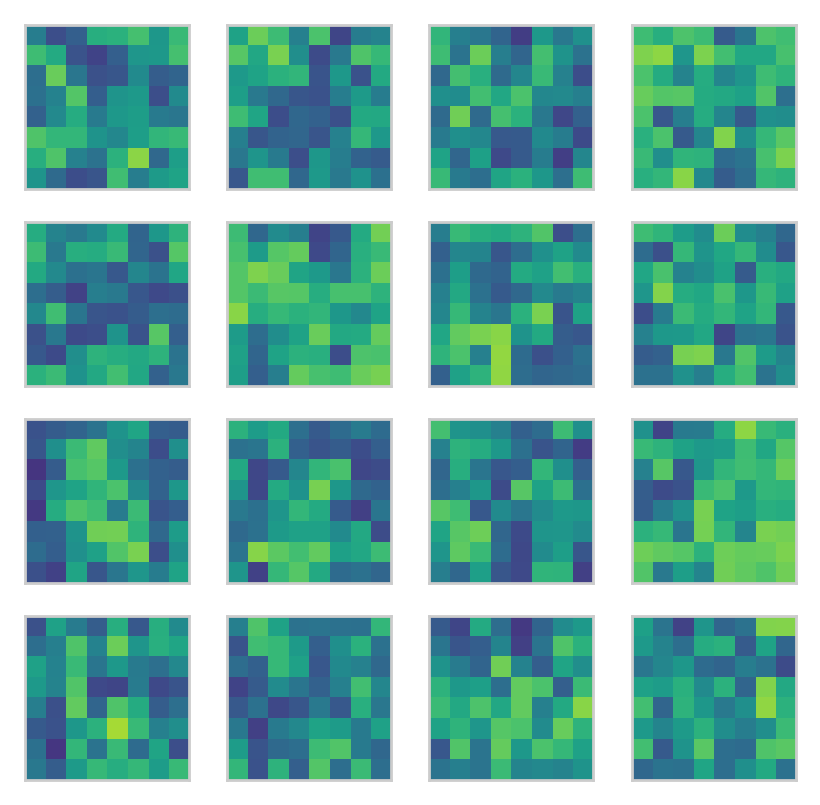

In [41]:
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        _ = ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        _ = ax[i,j].axes.xaxis.set_visible(False)
        _ = ax[i,j].axes.yaxis.set_visible(False)

We further see below that the model effective action ($-\log{q}(x)$) is very close to the true action, once we account for an overall shift. This offset corresponds to the unknown multiplicative constant $1/Z$ that our training is insensitive to. There is still some variation, especially in the regions with lower density, indicating the tails of the distribution are not perfectly modeled.

slope 1 linear regression S = S_eff + -8.7167


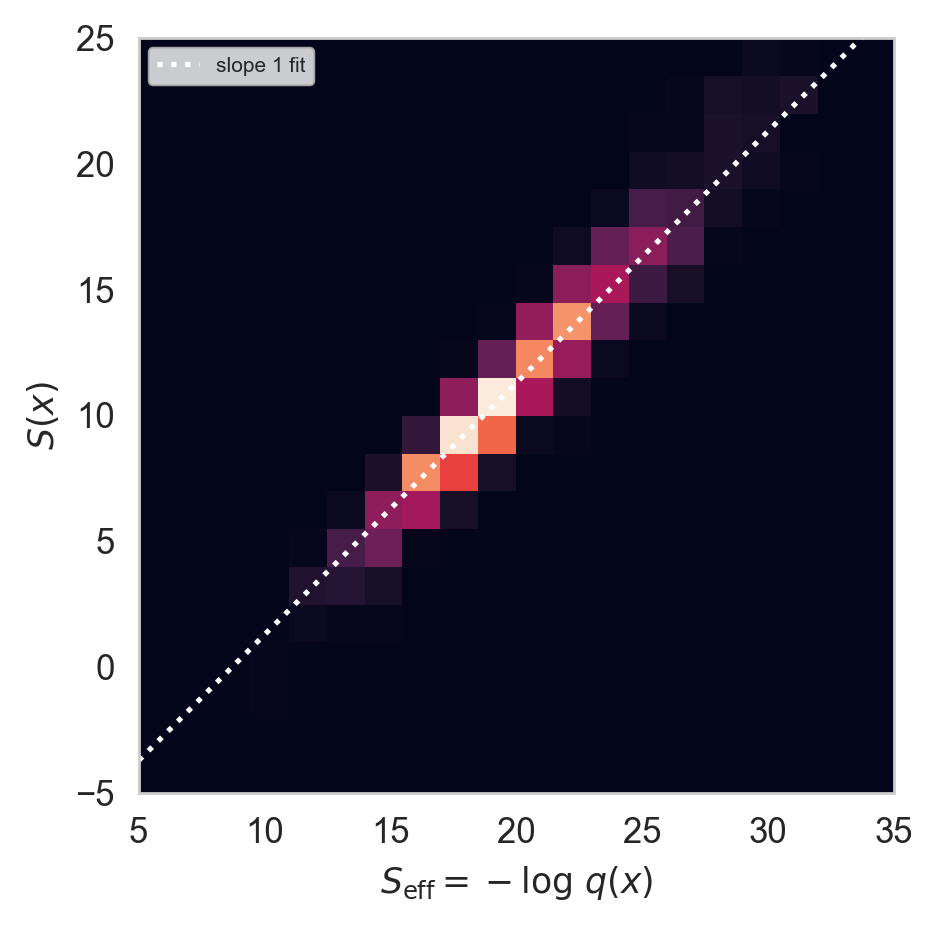

In [42]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
_ = ax.hist2d(S_eff, S, bins=20, range=[[5, 35], [-5, 25]])
_ = ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
_ = ax.set_ylabel(r'$S(x)$')
_ = ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
_ = ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
_ = plt.legend(prop={'size': 6})

We can see how the model density evolved over training time to become well-correlated with $p(x)$ over time (if `use_pretrained == False`).

In [43]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        _ = ax.hist2d(-logq, -logp, bins=20, range=[[5, 35], [-5, 25]])
        if i == 0:
            _ = ax.set_ylabel(r'$S(x)$')
        _ = ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        _ = ax.set_title(f'Era {i * (N_era//10)}')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_aspect('equal')

### **Independence Metropolis**

To produce **unbiased** estimates of observables, either reweighting or resampling can be performed according to the weights $p(\phi_i)/q(\phi_i)$. See Sec. IIA of <span data-cite="Boyda:2020hsi">[2008.05456](https://arxiv.org/abs/2008.05456)</span> for a discussion of the tradeoffs in this choice. There are a number of possible resampling approaches; we choose to use the model samples as proposals in a Markov Chain Monte Carlo.

We'll use the Metropolis-Hastings (MH) algorithm to construct the asymptotically exact Markov chain sampler.
Generally, the MH algorithm consists of proposing an updated configuration $\phi'$ to the current configuration $\phi^{i-1}$ and stochastically accepting or rejecting the configuration with probability
\begin{equation}
p_{\mathrm{accept}}(\phi'|\phi^{i-1}) = \min \left(
    1,\;
    \frac{T(\phi' \rightarrow \phi^{i-1})}{T(\phi^{i-1} \rightarrow \phi')}
    \frac{p(\phi')}{p(\phi^{i-1})}
\right).
\end{equation}
Here $T(x \rightarrow y)$ is the probability of proposing config $y$ starting from $x$. If accepted, we define the next configuration in the chain to be $\phi^i = \phi'$; if rejected, the last configuration is repeated and $\phi^i = \phi^{i-1}$. Often, $p(\phi) \sim e^{-S}$ is computationally tractable but $T$ is not, so algorithms are engineered to have symmetric proposal probabilities such that $T(x \rightarrow y) = T(y \rightarrow x)$ and the factors in $p_{\text{accept}}$ cancel, leading to the familiar Metropolis formula $p^{\text{symm}}_{\text{accept}} = \min(1, \exp[-\Delta S])$.

We instead propose updates by drawing samples from our model independently of the previous configuration, so $T(x \rightarrow y) = T(y) = q(y)$, where $q(y)$ is the model density computed alongside sample $y$. The resulting proposal probability $T$ is therefore not symmetric but is known. We thus must accept or reject based on
\begin{equation}
p_{\mathrm{accept}}(\phi'|\phi^{i-1}) = \min \left(
    1,\;
    \frac{q(\phi^{i-1})}{p(\phi^{i-1})}
    \frac{p(\phi')}{q(\phi')}
\right).
\end{equation}
This procedure is known as the independence Metropolis sampler. Note that rejections occur proportionally to how poorly the model density matches the desired density; if $p(\phi') = q(\phi')$, all (independent) proposals are accepted, and the chain is a sequence of totally uncorrelated samples. As the rejection rate increases, the autocorrelation time does as well.

Below we build the MH algorithm in two stages. First, we need some way of generating an ordered list of samples using our model. The code below defines a generator which does this by drawing batches efficiently in parallel, then iterating over them one at at time.

In [44]:
def serial_sample_generator(model, action, batch_size, N_samples):
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

Now we need to iterate over the samples and construct them into a Markov Chain. The code below implements the Metropolis independence sampler to do this.

In [45]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else: 
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

Finally, the cell below uses the code above to generate an ensemble of configurations using our trained flow model. You should see a 30-40% accept rate.

In [46]:
ensemble_size = 8192
phi4_ens = make_mcmc_ensemble(model, phi4_action, 64, ensemble_size)
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.463134765625


The generated ensemble is asymptotically unbiased. As an example of an observable measurements, we measure the two-point susceptibility below and compare against a value determined from a large HMC ensemble evaluated at the same choice of parameters.

In [47]:
n_therm = 512
cfgs = np.stack(list(map(grab, phi4_ens['x'])), axis=0)[n_therm:]
C = 0
for x in range(L):
    for y in range(L):
        C = C + cfgs*np.roll(cfgs, (-x, -y), axis=(1,2))
X = np.mean(C, axis=(1,2))

def bootstrap(x, *, Nboot, binsize):
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0,1)))
    return np.mean(boots), np.std(boots)
X_mean, X_err = bootstrap(X, Nboot=100, binsize=4)
print(f'Two-point susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 0.75 +/- 0.01')

Two-point susceptibility = 0.78 +/- 0.02
... vs HMC estimate = 0.75 +/- 0.01


# Application 2: $\mathrm{U}(1)$ gauge theory in 2d

As a second example, we train a flow to sample distributions for $\mathrm{U}(1)$ gauge theory in two spacetime dimensions. The desired physical distributions are symmetric under a large gauge symmetry group. We can construct flows which explicitly respect this symmetry by enforcing two requirements:

1. The prior distribution is gauge-invariant. We'll use the uniform distribution (with respect to the Haar measure) on each gauge link. For $\mathrm{U}(1)$, this is just the uniform distribution in $[0, 2\pi]^{N_d V}$.
2. Coupling layers are **gauge equivariant** (commute with gauge transformations).

If both conditions are satisfied, this guarantees a **gauge invariant** output distribution. See <span data-cite="Kanwar:2020xzo">[2003.06413]</span> for details.

**CAUTION:** many variable names are reused from the previous section.

## **Physical theory**

The continuum theory consists of a real-valued field $A_\mu(x)$ as a function of 2D coordinate $x$, with Lorentz index $\mu$. The lattice regularization of the theory replaces this field per site with a collection of parallel transporters
\begin{equation}
U_\mu(x) \equiv \exp \left[ {i \int_{x' = x}^{x' = x+\hat{\mu}} A_{\mu}(x')} \right]
\end{equation}
with each $U_\mu(x)$ living on the lattice link connecting $x$ to $x+\hat{\mu}$, such that there are $2V$ independent links on a $V$-site 2D lattice. As unit-modulus complex numbers we can consider $U_\mu(x)$ to live in $\mathrm{U}(1)$ and $A_{\mu}(x)$ to live in the algebra $\mathfrak{u}(1)$.

<div align="center">
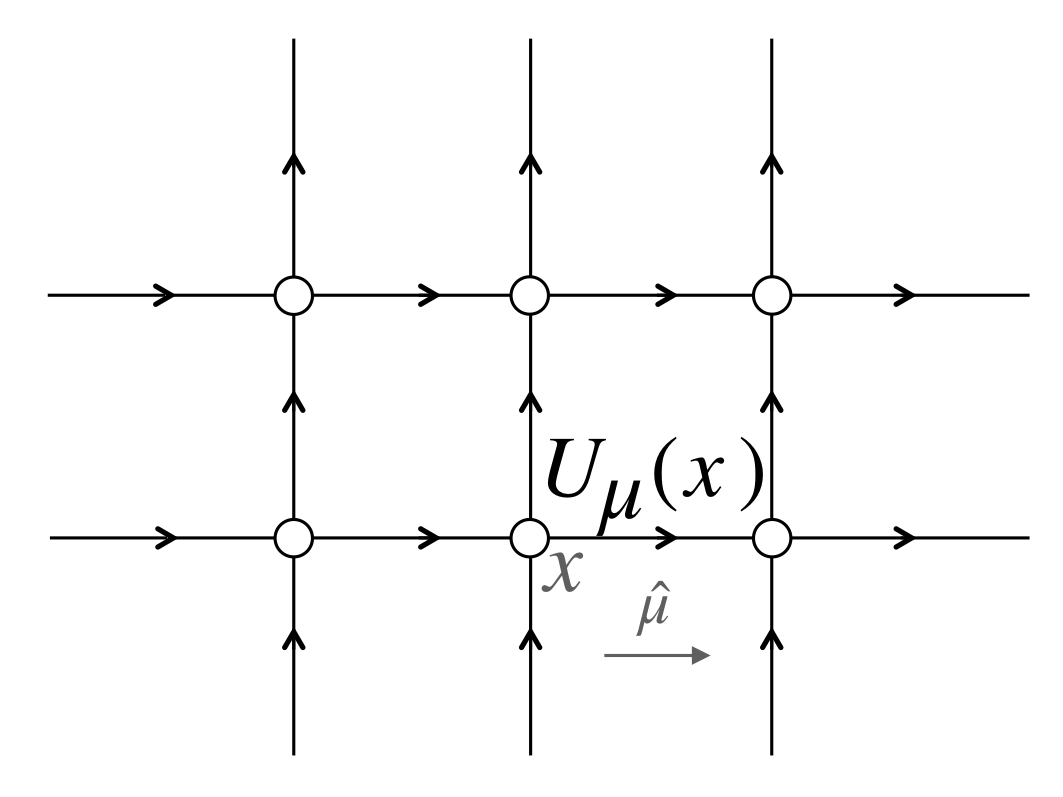
</div>

<div align="center">Lattice discretization of a gauge theory.</div>

We can write in the angular representation $U_\mu(\vec{n}) = \exp[i \theta_\mu(\vec{n})]$ where $\theta_\mu(\vec{n}) \in \mathbb{R}$. We will work with the real-valued angles $\theta_\mu(\vec{n}) = \arg(U_\mu(\vec{n})) \in [0, 2\pi]$ rather than the unit-modulus complex number $U_\mu(\vec{n})$. Using this parsimonious representation of lattice DOF saves us from having to worry about maintaining the normalization of the complex $U$, at the cost of having to deal with discontinuities at the boundary $\theta = 2 \pi \equiv 0$.

Let's initialize some configurations of an example lattice of size $8\times8$ and generate two random configurations:

In [48]:
L = 8
lattice_shape = (L,L)
link_shape = (2,L,L)
# some arbitrary configurations
u1_ex1 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
u1_ex2 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((u1_ex1, u1_ex2), axis=0)).to(torch_device)

The continuum Euclidean action can be written in terms of the field strength $F_{\mu\nu} \equiv \partial_\mu A_\nu - \partial_\nu A_\mu$ as
\begin{equation}
    S^E_{\text{cont}}[A] = \int d^dx \left[ -\frac{1}{2} \sum_{\mu < \nu} F_{\mu\nu}^2 \right]
\end{equation}
which can be regularized on the lattice in terms of parallel transporters $U_\mu(\vec{n})$
\begin{equation}
\begin{split}
    S^E_{\text{latt}}[U] &= -\beta \sum_{\vec{n}} \left[ \sum_{\mu < \nu} \text{Re} P_{\mu\nu}(\vec{n}) \right] \\
    \text{where} \quad
    P_{\mu\nu}(\vec{n}) &\equiv U_\mu(\vec{n}) ~ U_\nu(\vec{n}+\hat{\mu}) ~ U^\dagger_\mu(\vec{n}+\hat{\nu}) ~ U^\dagger_\nu(\vec{n})
\end{split}
\end{equation}
is the "plaquette", the simplest possible closed loop of links on a lattice, a $1 \times 1$ square. This simple form for $S^E_\text{latt}$ is known as the Wilson gauge action.

<div align="center">
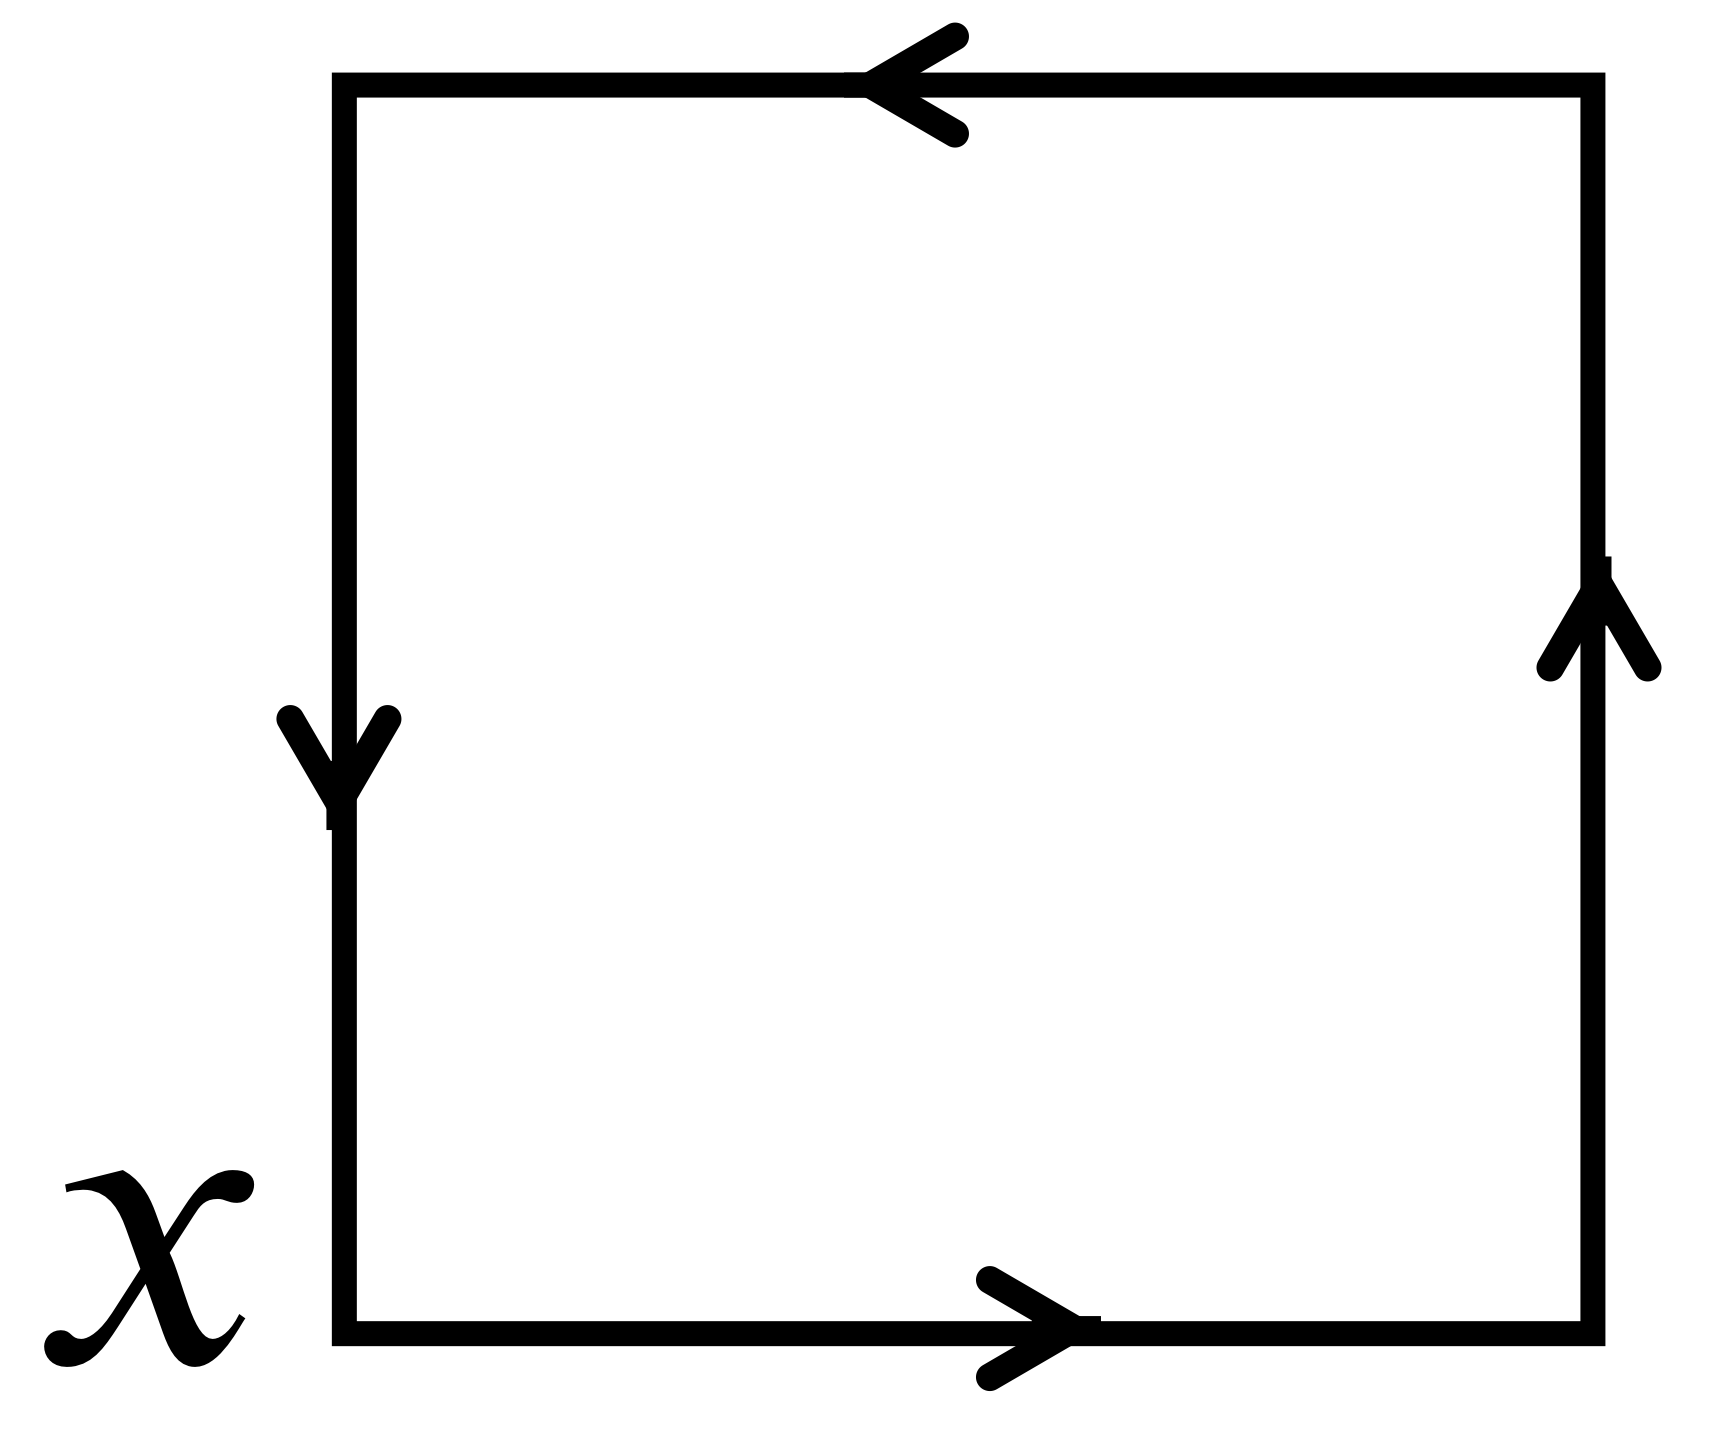
</div>

<div align="center">A plaquette.</div>

The expressions above are valid for non-Abelian gauge theory in an arbitrary number of spacetime dimensions, but in this notebook we are interested in Abelian $\mathrm{U}(1)$ gauge group. This immediately leads to some simplifications. In 2D, $P_{\mu\nu}=P_{01}$ is the only orientation of plaquette and the sum $\sum_{\mu<\nu}$ is trivial. In angular representation, as discussed above, the link has form $U_\mu(\vec{n})=\exp[i \theta_\mu(\vec{n})]$, hence the plaquette can be written as $P_{\mu\nu}(\vec{n}) = \exp[\theta_{\mu\nu}(\vec{n})]$, where $\theta_{\mu\nu}(\vec{n}) = \theta_\mu(\vec{n}) + \theta_\nu(\vec{n}+\hat{\mu}) - \theta_\mu(\vec{n}+\hat{\nu}) - \theta_\nu(\vec{n})$
and the Wilson gauge action for 2D U(1) gauge theory reduces to
\begin{equation}
    S^E_{\text{latt}}[U] = -\beta \sum_{\vec{n}} \cos \left[
      \theta_{\mu\nu}(\vec{n})
    \right].
\end{equation}

Since we are working in the angular representation, in the code we are always dealing with $\theta_{\mu\nu}$ rather than $P_{\mu\nu}$. The function to calculate $\theta_{\mu\nu}$ in terms of link angles looks like:

In [49]:
def compute_u1_plaq(links, mu, nu):
    """Compute U(1) plaqs in the (mu,nu) plane given `links` = arg(U)"""
    return (links[:,mu] + torch.roll(links[:,nu], -1, mu+1)
            - torch.roll(links[:,mu], -1, nu+1) - links[:,nu])

The gauge action in terms of angular variables is then:

In [50]:
class U1GaugeAction:
    def __init__(self, beta):
        self.beta = beta
    def __call__(self, cfgs):
        Nd = cfgs.shape[1]
        action_density = 0
        for mu in range(Nd):
            for nu in range(mu+1,Nd):
                action_density = action_density + torch.cos(
                    compute_u1_plaq(cfgs, mu, nu))
        return -self.beta * torch.sum(action_density, dim=tuple(range(1,Nd+1)))

print(U1GaugeAction(beta=1.0)(cfgs))

tensor([-5.2419,  4.0376])


In [51]:
beta = 1
u1_action = U1GaugeAction(beta)

This action is invariant under **gauge transformations**
\begin{equation}
    U_\mu(\vec{n}) \rightarrow e^{i \alpha(\vec{n})} U_\mu(\vec{n}) e^{-i \alpha(\vec{n} + \hat{\mu})}
\end{equation}
or, in terms of the angular variables,
\begin{equation}
    \theta_\mu(\vec{n}) \rightarrow \alpha(\vec{n}) + \theta_\mu(\vec{n}) -\alpha(\vec{n} + \hat{\mu})
\end{equation}
for any real-valued lattice field $\alpha(\vec{n})$ (i.e. an independent real number for each lattice site $\vec{n}$). The set of gauge transforms composes a large symmetry group ($N_d V$-dimensional, for U(1)) that we will explicitly encode in the normalizing flow model. Encoding this symmetry exactly improves data efficiency of training.

We can check numerically that our Pytorch implementation of the action is invariant with respect to an arbitrary gauge transformation.

In [52]:
def gauge_transform(links, alpha):
    for mu in range(len(links.shape[2:])):
        links[:,mu] = alpha + links[:,mu] - torch.roll(alpha, -1, mu+1)
    return links
def random_gauge_transform(x):
    Nconf, VolShape = x.shape[0], x.shape[2:]
    return gauge_transform(x, 2*np.pi*torch.rand((Nconf,) + VolShape))

# action is invariant
cfgs_transformed = random_gauge_transform(cfgs)
print(u1_action(cfgs), 'vs', u1_action(cfgs_transformed))
assert np.allclose(grab(u1_action(cfgs)), grab(u1_action(cfgs_transformed))), \
    'gauge transform should be a symmetry of the action'

tensor([-5.2419,  4.0376]) vs tensor([-5.2419,  4.0376])



Gauge theory in 2D is a bit peculiar: in the lattice regularization, each plaquette fluctuates independently except for exponentially-suppressed correlations due to periodic boundary conditions (i.e. in the infinite volume limit the correlation length is zero). For $\mathrm{U}(1)$ gauge theory in particular, there is also a well-defined topological charge on the lattice,
\begin{equation}
Q \equiv \frac{1}{2\pi} \sum_{\vec{n}} \arg(P_{01}(\vec{n})), \quad Q \in \mathbb{Z}
\end{equation}
where $\arg(\cdot) \in [-\pi, \pi]$. This topological charge mixes slowly with usual MCMC techniques, and we find that directly sampling using flow models vastly improves estimates for topological quantities.



In [53]:
def topo_charge(x):
    P01 = torch_wrap(compute_u1_plaq(x, mu=0, nu=1))
    axes = tuple(range(1, len(P01.shape)))
    return torch.sum(P01, dim=axes) / (2*np.pi)

with np.printoptions(suppress=True):
    print(f'cfg topological charges = {grab(topo_charge(cfgs))}')
Q = grab(topo_charge(cfgs))
assert np.allclose(Q, np.around(Q), atol=1e-6), 'topological charge must be an integer'

cfg topological charges = [-2. -1.]


Details on the formulation of Lattice Gauge Theory may be found in the books <span data-cite="Gattringer:2010zz">[C. Gattringer, C.B. Lang, Quantum Chromodynamics on the Lattice: An Introductory Presentation (2010)](https://doi.org/10.1007/978-3-642-01850-3)</span> and <span data-cite="Smit:2002ug">[J. Smit, Introduction to Quantum Fields on a Lattice (2002)](https://doi.org/10.1017/CBO9780511583971)</span>.


## **Prior distribution**
We use a uniform distribution with respect to the Haar measure. For $\mathrm{U}(1)$, this just corresponds to a uniform distribution over $\arg(U_\mu(\vec{n})) = \theta_\mu(\vec{n}) \in [0, 2\pi]$. This is easy to sample, as well as gauge invariant. **Note**: in the implementation below, we define the Haar measure normalized to total volume $2\pi$; this is an irrelevant normalization having no effect on training or sampling.


In [54]:
class MultivariateUniform(torch.nn.Module):
    """Uniformly draw samples from [a,b]"""
    def __init__(self, a, b):
        super().__init__()
        self.dist = torch.distributions.uniform.Uniform(a, b)
    def log_prob(self, x):
        axes = range(1, len(x.shape))
        return torch.sum(self.dist.log_prob(x), dim=tuple(axes))
    def sample_n(self, batch_size):
        return self.dist.sample((batch_size,))

In [55]:
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
z = prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(prior.log_prob(z))}')

z.shape = torch.Size([17, 2, 8, 8])
log r(z) = [-235.2482645 -235.2482645 -235.2482645 -235.2482645 -235.2482645
 -235.2482645 -235.2482645 -235.2482645 -235.2482645 -235.2482645
 -235.2482645 -235.2482645 -235.2482645 -235.2482645 -235.2482645
 -235.2482645 -235.2482645]


## **Gauge equivariant coupling layers**
Recall, our goal is to produce a gauge invariant output distribution, which can be achieved using gauge equivariant coupling layers combined with a gauge invariant prior distribution. A coupling layer is **gauge equivariant** if applying a gauge transformation commutes with application of the coupling layer. Consider abstractly factoring the degrees of freedom in the lattice gauge theory into pure-gauge and gauge-invariant degrees of freedom. Under this factorization, a gauge transformation only affects pure-gauge degrees of freedom, and thus a transformation acting **only on gauge invariant** quantities will be a gauge equivariant transformation.

Constructing coupling layers that transform links in a way that only affects gauge invariant quantities is not obvious, since these quantities are not necessarily in 1:1 correspondence with the gauge links, which are the lattice degrees of freedom. In <span data-cite="Kanwar:2020xzo">[2003.06413]</span>, we presented a construction that resolves this issue by defining how links should be transformed to produce a transformation of the gauge-invariant spectra of untraced Wilson loops. The general case is worked out there, but here we consider the special case of $\mathrm{U}(1)$ gauge theory where we focus on $1\times 1$ Wilson loops (plaquettes).

We define a gauge equivariant coupling layer in terms of an inner coupling layer which acts on ("active") plaquettes, which for $\mathrm{U}(1)$ gauge theory are scalar, gauge-invariant objects. The inner coupling layer $g$ transforms $P_{\mu\nu}(\vec{n}) \rightarrow P'_{\mu\nu}(\vec{n})$ (see Figure below). The update to each plaquette can be uniquely "pushed onto" a corresponding link if we transform few enough plaquettes. For $\mathrm{U}(1)$ gauge theory, pushing updates from a plaquette to a contained link is easy due to the Abelian nature of the group. If the inner coupling layer maps $P \rightarrow P'$, then the contained link $U$ should be updated as $U \rightarrow U' = P' P^{-1} U$. This enacts the desired transformation on the plaquette,
\begin{equation}
P = U V \rightarrow P' P^{-1} U V = P' (V^{-1} U^{-1}) U V = P'.
\end{equation}
where $V$ is the remaining product of links ("staple") defining the plaquette. A similar expression applies when the plaquette is defined in terms of $U^{-1}$ instead. Note that this "passively" transforms any other plaquettes containing $U$.

<div align="center">
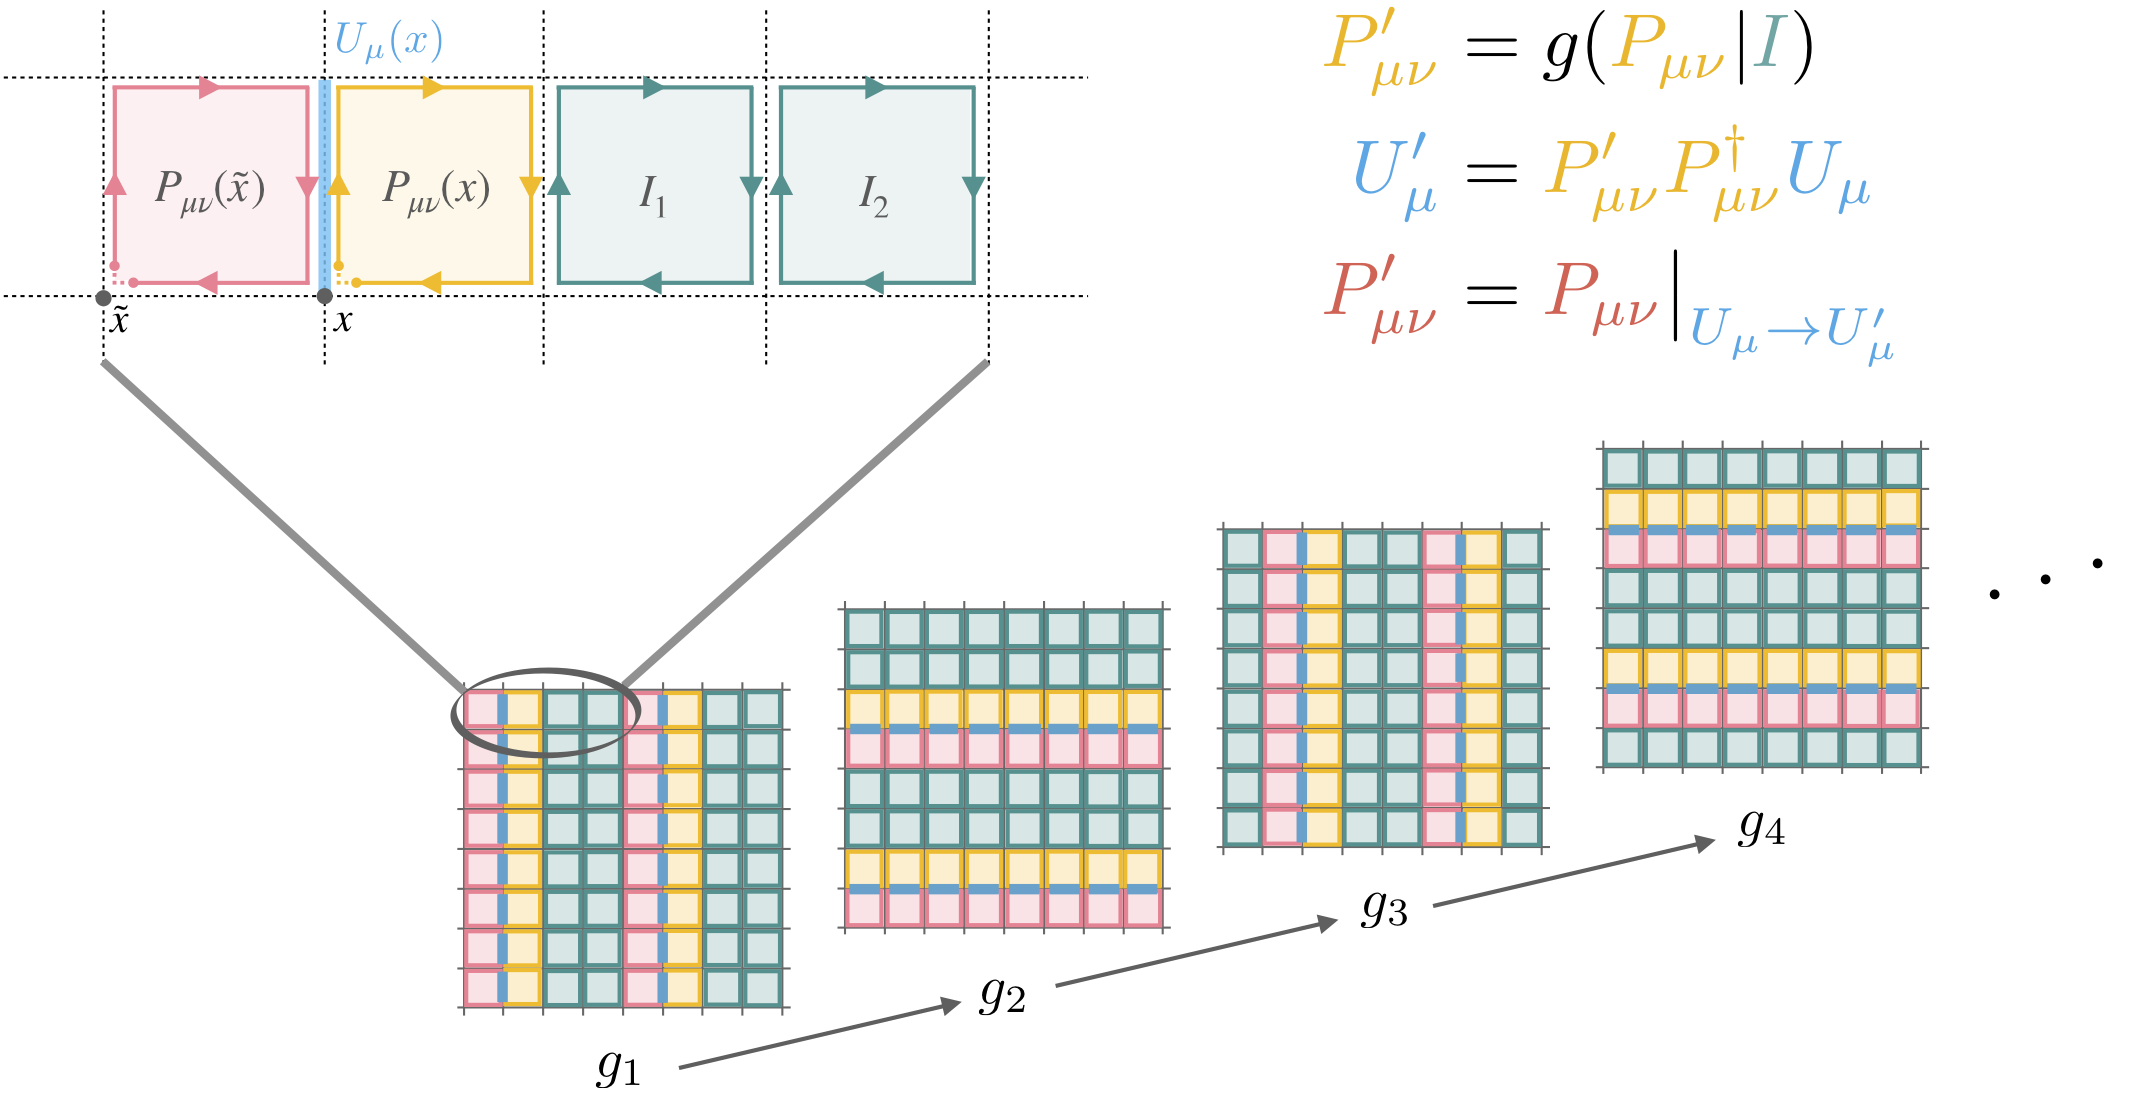
</div>

<div align="center">Equivariant action by "pushing" plaquette updates onto links in each coupling layer $g_i$.</div>

This transformation is correctly gauge equivariant if, in addition, the inner flow updating $P_{\mu\nu}(\vec{n})$ depends only on frozen gauge invariant quantities. In comparison to scalar field theory, we must define _three_ disjoint subsets of degrees of freedom to be passed to the inner coupling layer: _active_, _passive_, and _frozen_. The frozen subset works the same as before; it is not updated and can be used as input to the neural nets defining the parameters. The active subset is actively transformed by the coupling layer using those parameters, and its transformation will be pushed onto corresponding links. The passively updated subset contains plaquettes that include an updated link but are not directly transformed by the inner layer nor used as inputs to the neural nets defining the parameters.

A gauge equivariant coupling layer for $\mathrm{U}(1)$ gauge theory is defined below, with a specific choice of 1:1 mapping between updated links and plaquettes: each active plaquette $P_{01}(\vec{n})$ contains exactly one link to update, either the link on the left $U_0(\vec{n})$ or the link at the bottom $U_1(\vec{n})^{-1}$, specified implicitly by masks (we discuss our choice of masking pattern and define the relevant functions in the next section). Translating to the angular variables used in code to represent the links, these updates look like

\begin{equation}
\begin{aligned}
\theta_0(\vec{n}) &\rightarrow \theta_0(\vec{n}) + \delta_{01}(\vec{n}) \\
\theta_1(\vec{n}) &\rightarrow \theta_1(\vec{n}) - \delta_{01}(\vec{n}),
\end{aligned}
\end{equation}
where $\delta_{01}(\vec{n}) = \theta_{01}'(\vec{n}) - \theta_{01}(\vec{n})$.

**Note:** We define the gauge equivariant coupling layer in terms of an inner coupling layer `plaq_coupling` which we will define and discuss later.

In [56]:
class GaugeEquivCouplingLayer(torch.nn.Module):
    """U(1) gauge equiv coupling layer defined by `plaq_coupling` acting on plaquettes."""
    def __init__(self, *, lattice_shape, mask_mu, mask_off, plaq_coupling):
        super().__init__()
        link_mask_shape = (len(lattice_shape),) + lattice_shape
        self.active_mask = make_2d_link_active_stripes(link_mask_shape, mask_mu, mask_off)
        self.plaq_coupling = plaq_coupling
        
    def forward(self, x):
        plaq = compute_u1_plaq(x, mu=0, nu=1)
        new_plaq, logJ = self.plaq_coupling(plaq)
        delta_plaq = new_plaq - plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger
        fx = self.active_mask * torch_mod(delta_links + x) + (1-self.active_mask) * x
        return fx, logJ

    def reverse(self, fx):
        new_plaq = compute_u1_plaq(fx, mu=0, nu=1)
        plaq, logJ = self.plaq_coupling.reverse(new_plaq)
        delta_plaq = plaq - new_plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger
        x = self.active_mask * torch_mod(delta_links + fx) + (1-self.active_mask) * fx
        return x, logJ

Transformation of $U_0(\vec{n})$ is done according to foluma above but formula for $U_1(\vec{n})$ requires additional clarification. According to the explanation above we would need to update $U_1\rightarrow U_1' = P_{10}' P_{10}^{-1} U_1$ but it is generally accepted in LQCD to use only the positive direction of plaquettes. Keeping in mind $P_{01} = P_{10}^{\dagger}$, we can change the transformation to $U_1^\dagger\rightarrow U_1'^\dagger  = U_1^\dagger P_{01}^{-1} P_{01}'$. In the angular representaion it simply has the form $\theta_1(\vec{n}) \rightarrow \theta_1(\vec{n}) - \delta \theta_{01}(\vec{n})$, where $\delta \theta_{01}(\vec{n}) = \theta_{01}' - \theta_{01}$.

The masking pattern and choice of gauge invariant quantities for the inner update could all be generalized. See also <span data-cite="Boyda:2020hsi">[2008.05456]</span> for details on the non-Abelian version of this equivariant construction.

## **Gauge-equivariant masking patterns**

There are many choices of masking patterns that allow updates to be pushed onto links. We used this one because it's simple and strikes a good balance between updating as many links as possible (number of active links) and having sufficient info to make well-informed updates (number of frozen plaquettes). More exploration of optimal masking pattern structure in higher dimensions will be explored in future work. We can update all links on the lattice by composing coupling layers with different mask offsets and directions.

<div align="center">
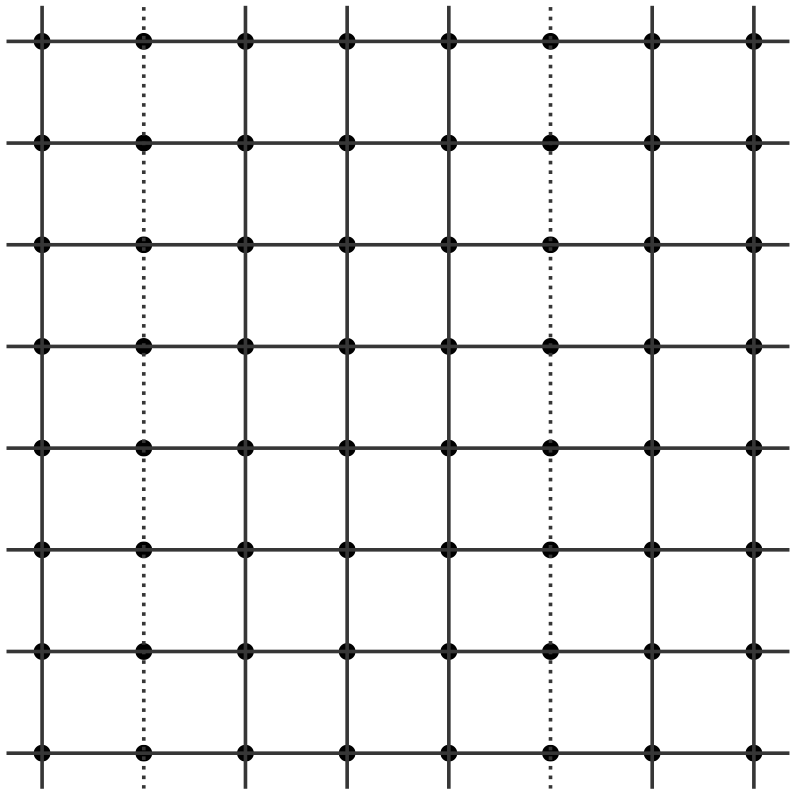
</div>

<div align="center">Masking pattern for a single coupling layer, with active links indicated with dotted lines and passive links with solid lines.</div>

For the links, we need a mask that will pick out the "active" links to be updated. We only update links in one direction at a time, as indicated in the figure above. The masking pattern for links in the updated direction looks like stripes along the updated direction, spaced by 4 lattice units. For links in the other direction, it's all 0s.

In [57]:
def make_2d_link_active_stripes(shape, mu, off):
    """
    Stripes mask looks like in the `mu` channel (mu-oriented links)::

      1 0 0 0 1 0 0 0 1 0 0
      1 0 0 0 1 0 0 0 1 0 0
      1 0 0 0 1 0 0 0 1 0 0
      1 0 0 0 1 0 0 0 1 0 0

    where vertical is the `mu` direction, and the pattern is offset in the nu
    direction by `off` (mod 4). The other channel is identically 0.
    """
    assert len(shape) == 2+1, 'need to pass shape suitable for 2D gauge theory'
    assert shape[0] == len(shape[1:]), 'first dim of shape must be Nd'
    assert mu in (0,1), 'mu must be 0 or 1'
    
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[mu,:,0::4] = 1
    elif mu == 1:
        mask[mu,0::4] = 1
    nu = 1-mu
    mask = np.roll(mask, off, axis=nu+1)
    return torch.from_numpy(mask.astype(float_dtype)).to(torch_device)

Before we define the masking patterns for plaquettes, let's define a few helper functions.

In [58]:
def make_single_stripes(shape, mu, off):
    """
      1 0 0 0 1 0 0 0 1 0 0
      1 0 0 0 1 0 0 0 1 0 0
      1 0 0 0 1 0 0 0 1 0 0
      1 0 0 0 1 0 0 0 1 0 0

    where vertical is the `mu` direction. Vector of 1 is repeated every 4.
    The pattern is offset in perpendicular to the mu direction by `off` (mod 4).
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'

    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
    elif mu == 1:
        mask[0::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

In [59]:
def make_double_stripes(shape, mu, off):
    """
    Double stripes mask looks like::

      1 1 0 0 1 1 0 0
      1 1 0 0 1 1 0 0
      1 1 0 0 1 1 0 0
      1 1 0 0 1 1 0 0

    where vertical is the `mu` direction. The pattern is offset in perpendicular
    to the mu direction by `off` (mod 4).
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'

    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
        mask[:,1::4] = 1
    elif mu == 1:
        mask[0::4] = 1
        mask[1::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

The masking pattern for active, passive, and frozen plaquettes are stripes in the same direction as the active link mask, with appropriate relative offsets to ensure these three subsets give a disjoint partition of all plaquettes. The active plaquettes are the ones ahead of each active link in the updated direction, while passive plaquettes are the ones behind. All other plaquettes are frozen.

In [60]:
def make_plaq_masks(mask_shape, mask_mu, mask_off):
    mask = {}
    mask['frozen'] = make_double_stripes(mask_shape, mask_mu, mask_off+1)
    mask['active'] = make_single_stripes(mask_shape, mask_mu, mask_off)
    mask['passive'] = 1 - mask['frozen'] - mask['active']
    return mask

# For example
_test_plaq_masks = make_plaq_masks((8,8), 0, mask_off=1)
print('Frozen (fed into NNs)')
print(_test_plaq_masks['frozen'])
print('Active (driving the link update)')
print(_test_plaq_masks['active'])
print('Passive (updated as a result of link update)')
print(_test_plaq_masks['passive'])

Frozen (fed into NNs)
tensor([[0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1]], dtype=torch.uint8)
Active (driving the link update)
tensor([[0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0]], dtype=torch.uint8)
Passive (updated as a result of link update)
tensor([[1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0]], dtype=torch.uint8)


## **Flowing plaquettes gauge invariantly**

The inner coupling layer simply needs to define an expressive invertible function on the plaquette angular variables. However, we cannot directly use scaling or affine transformations because they do not map $[0,2\pi]$ back into itself.

Here we implement a **non-compact projection** (NCP) transformation introduced for angular variables in <span data-cite="Rezende:2020hrd">[2002.02428]</span>. The transform simply changes variables from $x \in [0,2\pi]$ to $\tan(x/2) \in (-\infty, \infty)$ before applying a scaling transformation, then transforms back to $[0,2\pi]$ afterwards, i.e.:
\begin{equation}
x' = 2 \tan^{-1} \left( e^{s} \tan(x/2) \right)
\end{equation}
where all operations are elementwise as usual. The Jacobian factor for this transformation is
\begin{equation}
J(x) = \left[ e^{-s} \cos^2 \left(\frac{x}{2}\right)  + e^s \sin^2 \left(\frac{x}{2}\right) \right]^{-1}.
\end{equation}
We define these transformations below.

In [61]:
def tan_transform(x, s):
    return torch_mod(2*torch.atan(torch.exp(s)*torch.tan(x/2)))

def tan_transform_logJ(x, s):
    return -torch.log(torch.exp(-s)*torch.cos(x/2)**2 + torch.exp(s)*torch.sin(x/2)**2)

The average of transformations with different scales $s_i$ also defines an invertible transform. This lets use make our models more expressive, at the cost of needing numerical methods to invert each coupling layer.

In [62]:
def mixture_tan_transform(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.mean(tan_transform(x, s), dim=1, keepdim=True)

def mixture_tan_transform_logJ(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.logsumexp(tan_transform_logJ(x, s), dim=1) - np.log(s.shape[1])

Unfortunately, the NCP transformation does not have an analytic inverse transformation but it is easy to calculate it numerically. It is worth noting that inverse transformation is required only to measure the model density on new data (not used for training or evaluation), so slow numerical inversion is not an issue. There are alternative coupling layers that avoid this issue, if such measurements are needed.

We implement numerical inversion using the bisection algorithm below.

In [63]:
def invert_transform_bisect(y, *, f, tol, max_iter, a=0, b=2*np.pi):
    min_x = a*torch.ones_like(y)
    max_x = b*torch.ones_like(y)
    min_val = f(min_x)
    max_val = f(max_x)
    with torch.no_grad():
        for i in range(max_iter):
            mid_x = (min_x + max_x) / 2
            mid_val = f(mid_x)
            greater_mask = (y > mid_val).int()
            greater_mask = greater_mask.float()
            err = torch.max(torch.abs(y - mid_val))
            if err < tol: return mid_x
            if torch.all((mid_x == min_x) + (mid_x == max_x)):
                print('WARNING: Reached floating point precision before tolerance '
                      f'(iter {i}, err {err})')
                return mid_x
            min_x = greater_mask*mid_x + (1-greater_mask)*min_x
            min_val = greater_mask*mid_val + (1-greater_mask)*min_val
            max_x = (1-greater_mask)*mid_x + greater_mask*max_x
            max_val = (1-greater_mask)*mid_val + greater_mask*max_val
        print(f'WARNING: Did not converge to tol {tol} in {max_iter} iters! Error was {err}')
        return mid_x

As before, we'll use neural nets to parametrize the scales $s_i$. We will preprocess the input angles (of the frozen plaquettes) as $x \rightarrow (\sin(x), \cos(x))$ to ensure the neural nets have continous outputs with respect to the angular inputs.

In [64]:
def stack_cos_sin(x):
    return torch.stack((torch.cos(x), torch.sin(x)), dim=1)

Altogether, the coupling layer uses the average of NCP transforms as defined above, composed with simple offsets $x \rightarrow x + t \pmod{2\pi}$. As discussed above, we partition the plaquettes into three sets: active, passive, and frozen, with the exact partitioning scheme defined by our choice of masking pattern. The inner coupling layer updates the active plaquettes, uses the frozen plaquettes as inputs for the neural nets defining $s_i$ and $t$, and ignores the passive plaquettes completely.

In [65]:
class NCPPlaqCouplingLayer(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_mu, mask_off,
                 inv_prec=1e-6, inv_max_iter=1000):
        super().__init__()
        assert len(mask_shape) == 2, (
            f'NCPPlaqCouplingLayer is implemented only in 2D, '
            f'mask shape {mask_shape} is invalid')
        self.mask = make_plaq_masks(mask_shape, mask_mu, mask_off)
        self.net = net
        self.inv_prec = inv_prec
        self.inv_max_iter = inv_max_iter

    def forward(self, x):
        x2 = self.mask['frozen'] * x
        net_out = self.net(stack_cos_sin(x2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels'
        s, t = net_out[:,:-1], net_out[:,-1]

        x1 = self.mask['active'] * x
        x1 = x1.unsqueeze(1)
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s)
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = torch.sum(local_logJ, dim=axes)
        fx1 = self.mask['active'] * mixture_tan_transform(x1, s).squeeze(1)

        fx = (
            self.mask['active'] * torch_mod(fx1 + t) +
            self.mask['passive'] * x +
            self.mask['frozen'] * x)
        return fx, logJ
        
    def reverse(self, fx):
        fx2 = self.mask['frozen'] * fx
        net_out = self.net(stack_cos_sin(fx2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels'
        s, t = net_out[:,:-1], net_out[:,-1]

        x1 = torch_mod(self.mask['active'] * (fx - t).unsqueeze(1))
        transform = lambda x: self.mask['active'] * mixture_tan_transform(x, s)
        x1 = invert_transform_bisect(
            x1, f=transform, tol=self.inv_prec, max_iter=self.inv_max_iter)
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s)
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = -torch.sum(local_logJ, dim=axes)
        x1 = x1.squeeze(1)

        x = (
            self.mask['active'] * x1 +
            self.mask['passive'] * fx +
            self.mask['frozen'] * fx2)
        return x, logJ

## **Assemble the model**

Finally, we'll use CNNs for this application as well. To summarize, each coupling layer:

*   Computes plaquettes from the gauge links, and partitions them into active, passive, and frozen subsets
*   Provides the frozen plaquette angles $x$ as inputs $(\cos x, \sin x)$ to a CNN
*   Uses the resulting scales $s_i$ and offset $t$ to update the active plaquettes with mixed NCP
*   Updates the active links to induce the transformation of the active plaquettes (updating the passive plaquettes as a side effect)

The flow as a whole is made by stacking coupling layers, repeatedly scanning the masking pattern across all four distinct offsets and both directions (see the figure above). Eight layers are required to update each link once.

In [66]:
def make_u1_equiv_layers(*, n_layers, n_mixture_comps, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        in_channels = 2 # x - > (cos(x), sin(x))
        out_channels = n_mixture_comps + 1 # for mixture s and t, respectively
        net = make_conv_net(in_channels=in_channels, out_channels=out_channels,
            hidden_sizes=hidden_sizes, kernel_size=kernel_size,
            use_final_tanh=False)
        plaq_coupling = NCPPlaqCouplingLayer(
            net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
            lattice_shape=lattice_shape, mask_mu=mu, mask_off=off, 
            plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers)

## **Train the model**

We use the same self-training scheme with the reverse KL divergence as for $\phi^4$ theory. You should find that this model trains much faster than the model for $\phi^4$ theory above, achieving $\sim 40\%$ ESS after 10 eras of training, which takes 2-3 minutes on a Google Colab GPU.

As with before, if you don't want to train the model, we have provided a pre-trained example; just set the flag below to use it.

In [67]:
use_pretrained = True

For convenience, this cell reproduces all of the setup code from above:

In [68]:
# Theory
L = 8
lattice_shape = (L,L)
link_shape = (2,L,L)
beta = 2.0
u1_action = U1GaugeAction(beta)

# Model
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))

n_layers = 16
n_s_nets = 2
hidden_sizes = [8,8]
kernel_size = 3
layers = make_u1_equiv_layers(lattice_shape=lattice_shape, n_layers=n_layers, n_mixture_comps=n_s_nets,
                             hidden_sizes=hidden_sizes, kernel_size=kernel_size)
set_weights(layers)
model = {'layers': layers, 'prior': prior}

# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [69]:
if use_pretrained:
    print('Loading pre-trained model')
    u1_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
    UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYHAAAADAucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRxAmN0b3JjaC5fdXRpbHMKX3JlYnVpbGRfdGVuc29yX3YyCnEDKChYBwAAAHN0b3JhZ2VxBGN0b3JjaApGbG9hdFN0b3JhZ2UKcQVYCgAAADIyMDg2NjM1NTJxBlgGAAAAY3VkYTowcQdLkHRxCFFLAChLCEsCSwNLA3RxCShLEksJSwNLAXRxColoAClScQt0cQxScQ1YGgAAADAucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcQ5oAygoaARoBVgKAAAAMjE3ODg5MjQ5NnEPWAYAAABjdWRhOjBxEEsIdHERUUsASwiFcRJLAYVxE4loAClScRR0cRVScRZYHAAAADAucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAoAAAAyMTc4Nzg2NDAwcRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gaAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNxIGgDKChoBGgFWAoAAAAyMjA4ODEyOTI4cSFYBgAAAGN1ZGE6MHEiSwh0cSNRSwBLCIVxJEsBhXEliWgAKVJxJnRxJ1JxKFgcAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHEpaAMoKGgEaAVYCgAAADIxNzg4NDQxMTJxKlgGAAAAY3VkYTowcStL2HRxLFFLAChLA0sISwNLA3RxLShLSEsJSwNLAXRxLoloAClScS90cTBScTFYGgAAADAucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzcTJoAygoaARoBVgKAAAAMjIwODcyNTEzNnEzWAYAAABjdWRhOjBxNEsDdHE1UUsASwOFcTZLAYVxN4loAClScTh0cTlScTpYHAAAADEucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRxO2gDKChoBGgFWAoAAAAyMjA4Njg4MzIwcTxYBgAAAGN1ZGE6MHE9S5B0cT5RSwAoSwhLAksDSwN0cT8oSxJLCUsDSwF0cUCJaAApUnFBdHFCUnFDWBoAAAAxLnBsYXFfY291cGxpbmcubmV0LjAuYmlhc3FEaAMoKGgEaAVYCgAAADIyMDg3MTg3MzZxRVgGAAAAY3VkYTowcUZLCHRxR1FLAEsIhXFISwGFcUmJaAApUnFKdHFLUnFMWBwAAAAxLnBsYXFfY291cGxpbmcubmV0LjIud2VpZ2h0cU1oAygoaARoBVgKAAAAMjIwODY1MDEyOHFOWAYAAABjdWRhOjBxT01AAnRxUFFLAChLCEsISwNLA3RxUShLSEsJSwNLAXRxUoloAClScVN0cVRScVVYGgAAADEucGxhcV9jb3VwbGluZy5uZXQuMi5iaWFzcVZoAygoaARoBVgKAAAAMjIwODczNTM2MHFXWAYAAABjdWRhOjBxWEsIdHFZUUsASwiFcVpLAYVxW4loAClScVx0cV1ScV5YHAAAADEucGxhcV9jb3VwbGluZy5uZXQuNC53ZWlnaHRxX2gDKChoBGgFWAoAAAAyMjA4NzIxMjk2cWBYBgAAAGN1ZGE6MHFhS9h0cWJRSwAoSwNLCEsDSwN0cWMoS0hLCUsDSwF0cWSJaAApUnFldHFmUnFnWBoAAAAxLnBsYXFfY291cGxpbmcubmV0LjQuYmlhc3FoaAMoKGgEaAVYCgAAADIyMDg4MTcwMDhxaVgGAAAAY3VkYTowcWpLA3Rxa1FLAEsDhXFsSwGFcW2JaAApUnFudHFvUnFwWBwAAAAyLnBsYXFfY291cGxpbmcubmV0LjAud2VpZ2h0cXFoAygoaARoBVgKAAAAMjIwODYwNTQ4OHFyWAYAAABjdWRhOjBxc0uQdHF0UUsAKEsISwJLA0sDdHF1KEsSSwlLA0sBdHF2iWgAKVJxd3RxeFJxeVgaAAAAMi5wbGFxX2NvdXBsaW5nLm5ldC4wLmJpYXNxemgDKChoBGgFWAoAAAAyMjA4NjAxNzI4cXtYBgAAAGN1ZGE6MHF8Swh0cX1RSwBLCIVxfksBhXF/iWgAKVJxgHRxgVJxglgcAAAAMi5wbGFxX2NvdXBsaW5nLm5ldC4yLndlaWdodHGDaAMoKGgEaAVYCgAAADIyMDg5NTk1ODRxhFgGAAAAY3VkYTowcYVNQAJ0cYZRSwAoSwhLCEsDSwN0cYcoS0hLCUsDSwF0cYiJaAApUnGJdHGKUnGLWBoAAAAyLnBsYXFfY291cGxpbmcubmV0LjIuYmlhc3GMaAMoKGgEaAVYCgAAADIyMDg2NjQzNTJxjVgGAAAAY3VkYTowcY5LCHRxj1FLAEsIhXGQSwGFcZGJaAApUnGSdHGTUnGUWBwAAAAyLnBsYXFfY291cGxpbmcubmV0LjQud2VpZ2h0cZVoAygoaARoBVgKAAAAMjE3ODg5NzIxNnGWWAYAAABjdWRhOjBxl0vYdHGYUUsAKEsDSwhLA0sDdHGZKEtISwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgaAAAAMi5wbGFxX2NvdXBsaW5nLm5ldC40LmJpYXNxnmgDKChoBGgFWAoAAAAyMjA4NTkxNTg0cZ9YBgAAAGN1ZGE6MHGgSwN0caFRSwBLA4VxoksBhXGjiWgAKVJxpHRxpVJxplgcAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC4wLndlaWdodHGnaAMoKGgEaAVYCgAAADIyMDg2Njg3NTJxqFgGAAAAY3VkYTowcalLkHRxqlFLAChLCEsCSwNLA3RxqyhLEksJSwNLAXRxrIloAClSca10ca5Sca9YGgAAADMucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcbBoAygoaARoBVgKAAAAMjIwODYzNjA2NHGxWAYAAABjdWRhOjBxsksIdHGzUUsASwiFcbRLAYVxtYloAClScbZ0cbdScbhYHAAAADMucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRxuWgDKChoBGgFWAoAAAAyMjA4NTgwODY0cbpYBgAAAGN1ZGE6MHG7TUACdHG8UUsAKEsISwhLA0sDdHG9KEtISwlLA0sBdHG+iWgAKVJxv3RxwFJxwVgaAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNxwmgDKChoBGgFWAoAAAAyMjA5MDQ3MTM2ccNYBgAAAGN1ZGE6MHHESwh0ccVRSwBLCIVxxksBhXHHiWgAKVJxyHRxyVJxylgcAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHHLaAMoKGgEaAVYCgAAADIxNzg4Njk2NDhxzFgGAAAAY3VkYTowcc1L2HRxzlFLAChLA0sISwNLA3RxzyhLSEsJSwNLAXRx0IloAClScdF0cdJScdNYGgAAADMucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzcdRoAygoaARoBVgKAAAAMjIwODgxMTcyOHHVWAYAAABjdWRhOjBx1ksDdHHXUUsASwOFcdhLAYVx2YloAClScdp0cdtScdxYHAAAADQucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRx3WgDKChoBGgFWAoAAAAyMjA4Njc3Mzc2cd5YBgAAAGN1ZGE6MHHfS5B0ceBRSwAoSwhLAksDSwN0ceEoSxJLCUsDSwF0ceKJaAApUnHjdHHkUnHlWBoAAAA0LnBsYXFfY291cGxpbmcubmV0LjAuYmlhc3HmaAMoKGgEaAVYCgAAADIyMDg2Mjk1ODRx51gGAAAAY3VkYTowcehLCHRx6VFLAEsIhXHqSwGFceuJaAApUnHsdHHtUnHuWBwAAAA0LnBsYXFfY291cGxpbmcubmV0LjIud2VpZ2h0ce9oAygoaARoBVgKAAAAMjIwODUwNzUzNnHwWAYAAABjdWRhOjBx8U1AAnRx8lFLAChLCEsISwNLA3Rx8yhLSEsJSwNLAXRx9IloAClScfV0cfZScfdYGgAAADQucGxhcV9jb3VwbGluZy5uZXQuMi5iaWFzcfhoAygoaARoBVgKAAAAMjIwODY3OTQ1NnH5WAYAAABjdWRhOjBx+ksIdHH7UUsASwiFcfxLAYVx/YloAClScf50cf9ScgABAABYHAAAADQucGxhcV9jb3VwbGluZy5uZXQuNC53ZWlnaHRyAQEAAGgDKChoBGgFWAoAAAAyMjA4MzMwNzIwcgIBAABYBgAAAGN1ZGE6MHIDAQAAS9h0cgQBAABRSwAoSwNLCEsDSwN0cgUBAAAoS0hLCUsDSwF0cgYBAACJaAApUnIHAQAAdHIIAQAAUnIJAQAAWBoAAAA0LnBsYXFfY291cGxpbmcubmV0LjQuYmlhc3IKAQAAaAMoKGgEaAVYCgAAADIyMDg3ODY5NDRyCwEAAFgGAAAAY3VkYTowcgwBAABLA3RyDQEAAFFLAEsDhXIOAQAASwGFcg8BAACJaAApUnIQAQAAdHIRAQAAUnISAQAAWBwAAAA1LnBsYXFfY291cGxpbmcubmV0LjAud2VpZ2h0chMBAABoAygoaARoBVgKAAAAMjIwODYzNTE4NHIUAQAAWAYAAABjdWRhOjByFQEAAEuQdHIWAQAAUUsAKEsISwJLA0sDdHIXAQAAKEsSSwlLA0sBdHIYAQAAiWgAKVJyGQEAAHRyGgEAAFJyGwEAAFgaAAAANS5wbGFxX2NvdXBsaW5nLm5ldC4wLmJpYXNyHAEAAGgDKChoBGgFWAoAAAAyMjA4NTY4ODAwch0BAABYBgAAAGN1ZGE6MHIeAQAASwh0ch8BAABRSwBLCIVyIAEAAEsBhXIhAQAAiWgAKVJyIgEAAHRyIwEAAFJyJAEAAFgcAAAANS5wbGFxX2NvdXBsaW5nLm5ldC4yLndlaWdodHIlAQAAaAMoKGgEaAVYCgAAADIyMDg2MDgzNjhyJgEAAFgGAAAAY3VkYTowcicBAABNQAJ0cigBAABRSwAoSwhLCEsDSwN0cikBAAAoS0hLCUsDSwF0cioBAACJaAApUnIrAQAAdHIsAQAAUnItAQAAWBoAAAA1LnBsYXFfY291cGxpbmcubmV0LjIuYmlhc3IuAQAAaAMoKGgEaAVYCgAAADIyMDkzMjY4NjRyLwEAAFgGAAAAY3VkYTowcjABAABLCHRyMQEAAFFLAEsIhXIyAQAASwGFcjMBAACJaAApUnI0AQAAdHI1AQAAUnI2AQAAWBwAAAA1LnBsYXFfY291cGxpbmcubmV0LjQud2VpZ2h0cjcBAABoAygoaARoBVgKAAAAMjIwODc5MTkwNHI4AQAAWAYAAABjdWRhOjByOQEAAEvYdHI6AQAAUUsAKEsDSwhLA0sDdHI7AQAAKEtISwlLA0sBdHI8AQAAiWgAKVJyPQEAAHRyPgEAAFJyPwEAAFgaAAAANS5wbGFxX2NvdXBsaW5nLm5ldC40LmJpYXNyQAEAAGgDKChoBGgFWAoAAAAyMjA4NzI0MzM2ckEBAABYBgAAAGN1ZGE6MHJCAQAASwN0ckMBAABRSwBLA4VyRAEAAEsBhXJFAQAAiWgAKVJyRgEAAHRyRwEAAFJySAEAAFgcAAAANi5wbGFxX2NvdXBsaW5nLm5ldC4wLndlaWdodHJJAQAAaAMoKGgEaAVYCgAAADIyMDg3NDE2ODBySgEAAFgGAAAAY3VkYTowcksBAABLkHRyTAEAAFFLAChLCEsCSwNLA3RyTQEAAChLEksJSwNLAXRyTgEAAIloAClSck8BAAB0clABAABSclEBAABYGgAAADYucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzclIBAABoAygoaARoBVgKAAAAMjIwODcyNzg0MHJTAQAAWAYAAABjdWRhOjByVAEAAEsIdHJVAQAAUUsASwiFclYBAABLAYVyVwEAAIloAClSclgBAAB0clkBAABScloBAABYHAAAADYucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRyWwEAAGgDKChoBGgFWAoAAAAyMTc4ODg1ODcyclwBAABYBgAAAGN1ZGE6MHJdAQAATUACdHJeAQAAUUsAKEsISwhLA0sDdHJfAQAAKEtISwlLA0sBdHJgAQAAiWgAKVJyYQEAAHRyYgEAAFJyYwEAAFgaAAAANi5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNyZAEAAGgDKChoBGgFWAoAAAAyMjA4NTM1MzkycmUBAABYBgAAAGN1ZGE6MHJmAQAASwh0cmcBAABRSwBLCIVyaAEAAEsBhXJpAQAAiWgAKVJyagEAAHRyawEAAFJybAEAAFgcAAAANi5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHJtAQAAaAMoKGgEaAVYCgAAADIxNzg5MDQyNTZybgEAAFgGAAAAY3VkYTowcm8BAABL2HRycAEAAFFLAChLA0sISwNLA3RycQEAAChLSEsJSwNLAXRycgEAAIloAClScnMBAAB0cnQBAABScnUBAABYGgAAADYucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzcnYBAABoAygoaARoBVgKAAAAMjIwODY5MTY4MHJ3AQAAWAYAAABjdWRhOjByeAEAAEsDdHJ5AQAAUUsASwOFcnoBAABLAYVyewEAAIloAClScnwBAAB0cn0BAABScn4BAABYHAAAADcucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRyfwEAAGgDKChoBGgFWAoAAAAyMjA4NTc0OTYwcoABAABYBgAAAGN1ZGE6MHKBAQAAS5B0coIBAABRSwAoSwhLAksDSwN0coMBAAAoSxJLCUsDSwF0coQBAACJaAApUnKFAQAAdHKGAQAAUnKHAQAAWBoAAAA3LnBsYXFfY291cGxpbmcubmV0LjAuYmlhc3KIAQAAaAMoKGgEaAVYCgAAADIyMDgzNDUwMjRyiQEAAFgGAAAAY3VkYTowcooBAABLCHRyiwEAAFFLAEsIhXKMAQAASwGFco0BAACJaAApUnKOAQAAdHKPAQAAUnKQAQAAWBwAAAA3LnBsYXFfY291cGxpbmcubmV0LjIud2VpZ2h0cpEBAABoAygoaARoBVgKAAAAMjIwODM4NDczNnKSAQAAWAYAAABjdWRhOjBykwEAAE1AAnRylAEAAFFLAChLCEsISwNLA3RylQEAAChLSEsJSwNLAXRylgEAAIloAClScpcBAAB0cpgBAABScpkBAABYGgAAADcucGxhcV9jb3VwbGluZy5uZXQuMi5iaWFzcpoBAABoAygoaARoBVgKAAAAMjIwODY2OTc3NnKbAQAAWAYAAABjdWRhOjBynAEAAEsIdHKdAQAAUUsASwiFcp4BAABLAYVynwEAAIloAClScqABAAB0cqEBAABScqIBAABYHAAAADcucGxhcV9jb3VwbGluZy5uZXQuNC53ZWlnaHRyowEAAGgDKChoBGgFWAoAAAAyMTc4OTAzNTM2cqQBAABYBgAAAGN1ZGE6MHKlAQAAS9h0cqYBAABRSwAoSwNLCEsDSwN0cqcBAAAoS0hLCUsDSwF0cqgBAACJaAApUnKpAQAAdHKqAQAAUnKrAQAAWBoAAAA3LnBsYXFfY291cGxpbmcubmV0LjQuYmlhc3KsAQAAaAMoKGgEaAVYCgAAADIyMDg1Mzg2NzJyrQEAAFgGAAAAY3VkYTowcq4BAABLA3RyrwEAAFFLAEsDhXKwAQAASwGFcrEBAACJaAApUnKyAQAAdHKzAQAAUnK0AQAAWBwAAAA4LnBsYXFfY291cGxpbmcubmV0LjAud2VpZ2h0crUBAABoAygoaARoBVgKAAAAMjIwODQwNzIwMHK2AQAAWAYAAABjdWRhOjBytwEAAEuQdHK4AQAAUUsAKEsISwJLA0sDdHK5AQAAKEsSSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgaAAAAOC5wbGFxX2NvdXBsaW5nLm5ldC4wLmJpYXNyvgEAAGgDKChoBGgFWAoAAAAyMjA4NjAxNjQ4cr8BAABYBgAAAGN1ZGE6MHLAAQAASwh0csEBAABRSwBLCIVywgEAAEsBhXLDAQAAiWgAKVJyxAEAAHRyxQEAAFJyxgEAAFgcAAAAOC5wbGFxX2NvdXBsaW5nLm5ldC4yLndlaWdodHLHAQAAaAMoKGgEaAVYCgAAADIxNzg4NDY5OTJyyAEAAFgGAAAAY3VkYTowcskBAABNQAJ0csoBAABRSwAoSwhLCEsDSwN0cssBAAAoS0hLCUsDSwF0cswBAACJaAApUnLNAQAAdHLOAQAAUnLPAQAAWBoAAAA4LnBsYXFfY291cGxpbmcubmV0LjIuYmlhc3LQAQAAaAMoKGgEaAVYCgAAADIyMDg1MDMzMTJy0QEAAFgGAAAAY3VkYTowctIBAABLCHRy0wEAAFFLAEsIhXLUAQAASwGFctUBAACJaAApUnLWAQAAdHLXAQAAUnLYAQAAWBwAAAA4LnBsYXFfY291cGxpbmcubmV0LjQud2VpZ2h0ctkBAABoAygoaARoBVgKAAAAMjIwODUxODE3NnLaAQAAWAYAAABjdWRhOjBy2wEAAEvYdHLcAQAAUUsAKEsDSwhLA0sDdHLdAQAAKEtISwlLA0sBdHLeAQAAiWgAKVJy3wEAAHRy4AEAAFJy4QEAAFgaAAAAOC5wbGFxX2NvdXBsaW5nLm5ldC40LmJpYXNy4gEAAGgDKChoBGgFWAoAAAAyMjA4Njg4OTYwcuMBAABYBgAAAGN1ZGE6MHLkAQAASwN0cuUBAABRSwBLA4Vy5gEAAEsBhXLnAQAAiWgAKVJy6AEAAHRy6QEAAFJy6gEAAFgcAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC4wLndlaWdodHLrAQAAaAMoKGgEaAVYCgAAADIyMDgzNjY3NTJy7AEAAFgGAAAAY3VkYTowcu0BAABLkHRy7gEAAFFLAChLCEsCSwNLA3Ry7wEAAChLEksJSwNLAXRy8AEAAIloAClScvEBAAB0cvIBAABScvMBAABYGgAAADkucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcvQBAABoAygoaARoBVgKAAAAMjIwNTkxOTYzMnL1AQAAWAYAAABjdWRhOjBy9gEAAEsIdHL3AQAAUUsASwiFcvgBAABLAYVy+QEAAIloAClScvoBAAB0cvsBAABScvwBAABYHAAAADkucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRy/QEAAGgDKChoBGgFWAoAAAAyMTc4ODYwOTI4cv4BAABYBgAAAGN1ZGE6MHL/AQAATUACdHIAAgAAUUsAKEsISwhLA0sDdHIBAgAAKEtISwlLA0sBdHICAgAAiWgAKVJyAwIAAHRyBAIAAFJyBQIAAFgaAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNyBgIAAGgDKChoBGgFWAoAAAAyMjA4NjUwNzY4cgcCAABYBgAAAGN1ZGE6MHIIAgAASwh0cgkCAABRSwBLCIVyCgIAAEsBhXILAgAAiWgAKVJyDAIAAHRyDQIAAFJyDgIAAFgcAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHIPAgAAaAMoKGgEaAVYCgAAADIyMDg1NDEwNzJyEAIAAFgGAAAAY3VkYTowchECAABL2HRyEgIAAFFLAChLA0sISwNLA3RyEwIAAChLSEsJSwNLAXRyFAIAAIloAClSchUCAAB0chYCAABSchcCAABYGgAAADkucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzchgCAABoAygoaARoBVgKAAAAMjIwODQ3NTU2OHIZAgAAWAYAAABjdWRhOjByGgIAAEsDdHIbAgAAUUsASwOFchwCAABLAYVyHQIAAIloAClSch4CAAB0ch8CAABSciACAABYHQAAADEwLnBsYXFfY291cGxpbmcubmV0LjAud2VpZ2h0ciECAABoAygoaARoBVgKAAAAMjIwODUwMDkxMnIiAgAAWAYAAABjdWRhOjByIwIAAEuQdHIkAgAAUUsAKEsISwJLA0sDdHIlAgAAKEsSSwlLA0sBdHImAgAAiWgAKVJyJwIAAHRyKAIAAFJyKQIAAFgbAAAAMTAucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcioCAABoAygoaARoBVgKAAAAMjE3ODg3MzI0OHIrAgAAWAYAAABjdWRhOjByLAIAAEsIdHItAgAAUUsASwiFci4CAABLAYVyLwIAAIloAClScjACAAB0cjECAABScjICAABYHQAAADEwLnBsYXFfY291cGxpbmcubmV0LjIud2VpZ2h0cjMCAABoAygoaARoBVgKAAAAMjIwODMzMjcyMHI0AgAAWAYAAABjdWRhOjByNQIAAE1AAnRyNgIAAFFLAChLCEsISwNLA3RyNwIAAChLSEsJSwNLAXRyOAIAAIloAClScjkCAAB0cjoCAABScjsCAABYGwAAADEwLnBsYXFfY291cGxpbmcubmV0LjIuYmlhc3I8AgAAaAMoKGgEaAVYCgAAADIyMDgzNzg4MzJyPQIAAFgGAAAAY3VkYTowcj4CAABLCHRyPwIAAFFLAEsIhXJAAgAASwGFckECAACJaAApUnJCAgAAdHJDAgAAUnJEAgAAWB0AAAAxMC5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHJFAgAAaAMoKGgEaAVYCgAAADIyMDU5MTY5OTJyRgIAAFgGAAAAY3VkYTowckcCAABL2HRySAIAAFFLAChLA0sISwNLA3RySQIAAChLSEsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYGwAAADEwLnBsYXFfY291cGxpbmcubmV0LjQuYmlhc3JOAgAAaAMoKGgEaAVYCgAAADIyMDU1ODIzNTJyTwIAAFgGAAAAY3VkYTowclACAABLA3RyUQIAAFFLAEsDhXJSAgAASwGFclMCAACJaAApUnJUAgAAdHJVAgAAUnJWAgAAWB0AAAAxMS5wbGFxX2NvdXBsaW5nLm5ldC4wLndlaWdodHJXAgAAaAMoKGgEaAVYCgAAADIxNzg4NDYzNTJyWAIAAFgGAAAAY3VkYTowclkCAABLkHRyWgIAAFFLAChLCEsCSwNLA3RyWwIAAChLEksJSwNLAXRyXAIAAIloAClScl0CAAB0cl4CAABScl8CAABYGwAAADExLnBsYXFfY291cGxpbmcubmV0LjAuYmlhc3JgAgAAaAMoKGgEaAVYCgAAADIyMDU5MjEyMzJyYQIAAFgGAAAAY3VkYTowcmICAABLCHRyYwIAAFFLAEsIhXJkAgAASwGFcmUCAACJaAApUnJmAgAAdHJnAgAAUnJoAgAAWB0AAAAxMS5wbGFxX2NvdXBsaW5nLm5ldC4yLndlaWdodHJpAgAAaAMoKGgEaAVYCgAAADIyMDg1MTUyOTZyagIAAFgGAAAAY3VkYTowcmsCAABNQAJ0cmwCAABRSwAoSwhLCEsDSwN0cm0CAAAoS0hLCUsDSwF0cm4CAACJaAApUnJvAgAAdHJwAgAAUnJxAgAAWBsAAAAxMS5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNycgIAAGgDKChoBGgFWAoAAAAyMjA4NjA4NjA4cnMCAABYBgAAAGN1ZGE6MHJ0AgAASwh0cnUCAABRSwBLCIVydgIAAEsBhXJ3AgAAiWgAKVJyeAIAAHRyeQIAAFJyegIAAFgdAAAAMTEucGxhcV9jb3VwbGluZy5uZXQuNC53ZWlnaHRyewIAAGgDKChoBGgFWAoAAAAyMjA4MzI5NjgwcnwCAABYBgAAAGN1ZGE6MHJ9AgAAS9h0cn4CAABRSwAoSwNLCEsDSwN0cn8CAAAoS0hLCUsDSwF0coACAACJaAApUnKBAgAAdHKCAgAAUnKDAgAAWBsAAAAxMS5wbGFxX2NvdXBsaW5nLm5ldC40LmJpYXNyhAIAAGgDKChoBGgFWAoAAAAyMjA4MzgzNjE2coUCAABYBgAAAGN1ZGE6MHKGAgAASwN0cocCAABRSwBLA4VyiAIAAEsBhXKJAgAAiWgAKVJyigIAAHRyiwIAAFJyjAIAAFgdAAAAMTIucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRyjQIAAGgDKChoBGgFWAoAAAAyMTg3ODk5NzQ0co4CAABYBgAAAGN1ZGE6MHKPAgAAS5B0cpACAABRSwAoSwhLAksDSwN0cpECAAAoSxJLCUsDSwF0cpICAACJaAApUnKTAgAAdHKUAgAAUnKVAgAAWBsAAAAxMi5wbGFxX2NvdXBsaW5nLm5ldC4wLmJpYXNylgIAAGgDKChoBGgFWAoAAAAyMjA4NjAzODA4cpcCAABYBgAAAGN1ZGE6MHKYAgAASwh0cpkCAABRSwBLCIVymgIAAEsBhXKbAgAAiWgAKVJynAIAAHRynQIAAFJyngIAAFgdAAAAMTIucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRynwIAAGgDKChoBGgFWAoAAAAyMTc4ODg5MzEycqACAABYBgAAAGN1ZGE6MHKhAgAATUACdHKiAgAAUUsAKEsISwhLA0sDdHKjAgAAKEtISwlLA0sBdHKkAgAAiWgAKVJypQIAAHRypgIAAFJypwIAAFgbAAAAMTIucGxhcV9jb3VwbGluZy5uZXQuMi5iaWFzcqgCAABoAygoaARoBVgKAAAAMjIwODM0Mjc4NHKpAgAAWAYAAABjdWRhOjByqgIAAEsIdHKrAgAAUUsASwiFcqwCAABLAYVyrQIAAIloAClScq4CAAB0cq8CAABScrACAABYHQAAADEyLnBsYXFfY291cGxpbmcubmV0LjQud2VpZ2h0crECAABoAygoaARoBVgKAAAAMjIwODQyMjQ2NHKyAgAAWAYAAABjdWRhOjByswIAAEvYdHK0AgAAUUsAKEsDSwhLA0sDdHK1AgAAKEtISwlLA0sBdHK2AgAAiWgAKVJytwIAAHRyuAIAAFJyuQIAAFgbAAAAMTIucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzcroCAABoAygoaARoBVgKAAAAMjE4MzQ4Mjk3NnK7AgAAWAYAAABjdWRhOjByvAIAAEsDdHK9AgAAUUsASwOFcr4CAABLAYVyvwIAAIloAClScsACAAB0csECAABScsICAABYHQAAADEzLnBsYXFfY291cGxpbmcubmV0LjAud2VpZ2h0csMCAABoAygoaARoBVgKAAAAMjIwNTkyMzMxMnLEAgAAWAYAAABjdWRhOjByxQIAAEuQdHLGAgAAUUsAKEsISwJLA0sDdHLHAgAAKEsSSwlLA0sBdHLIAgAAiWgAKVJyyQIAAHRyygIAAFJyywIAAFgbAAAAMTMucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcswCAABoAygoaARoBVgKAAAAMjIwODQxNTQ0MHLNAgAAWAYAAABjdWRhOjByzgIAAEsIdHLPAgAAUUsASwiFctACAABLAYVy0QIAAIloAClSctICAAB0ctMCAABSctQCAABYHQAAADEzLnBsYXFfY291cGxpbmcubmV0LjIud2VpZ2h0ctUCAABoAygoaARoBVgKAAAAMjE3ODg5NDgxNnLWAgAAWAYAAABjdWRhOjBy1wIAAE1AAnRy2AIAAFFLAChLCEsISwNLA3Ry2QIAAChLSEsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYGwAAADEzLnBsYXFfY291cGxpbmcubmV0LjIuYmlhc3LeAgAAaAMoKGgEaAVYCgAAADIyMDgzNDY3MDRy3wIAAFgGAAAAY3VkYTowcuACAABLCHRy4QIAAFFLAEsIhXLiAgAASwGFcuMCAACJaAApUnLkAgAAdHLlAgAAUnLmAgAAWB0AAAAxMy5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHLnAgAAaAMoKGgEaAVYCgAAADIxNzg4OTcxMzZy6AIAAFgGAAAAY3VkYTowcukCAABL2HRy6gIAAFFLAChLA0sISwNLA3Ry6wIAAChLSEsJSwNLAXRy7AIAAIloAClScu0CAAB0cu4CAABScu8CAABYGwAAADEzLnBsYXFfY291cGxpbmcubmV0LjQuYmlhc3LwAgAAaAMoKGgEaAVYCgAAADIxNzg4ODgwMzJy8QIAAFgGAAAAY3VkYTowcvICAABLA3Ry8wIAAFFLAEsDhXL0AgAASwGFcvUCAACJaAApUnL2AgAAdHL3AgAAUnL4AgAAWB0AAAAxNC5wbGFxX2NvdXBsaW5nLm5ldC4wLndlaWdodHL5AgAAaAMoKGgEaAVYCgAAADIyMDgzNDc5ODRy+gIAAFgGAAAAY3VkYTowcvsCAABLkHRy/AIAAFFLAChLCEsCSwNLA3Ry/QIAAChLEksJSwNLAXRy/gIAAIloAClScv8CAAB0cgADAABScgEDAABYGwAAADE0LnBsYXFfY291cGxpbmcubmV0LjAuYmlhc3ICAwAAaAMoKGgEaAVYCgAAADIyMDg3Mzg0MDByAwMAAFgGAAAAY3VkYTowcgQDAABLCHRyBQMAAFFLAEsIhXIGAwAASwGFcgcDAACJaAApUnIIAwAAdHIJAwAAUnIKAwAAWB0AAAAxNC5wbGFxX2NvdXBsaW5nLm5ldC4yLndlaWdodHILAwAAaAMoKGgEaAVYCgAAADIyMDg1MTQ4MTZyDAMAAFgGAAAAY3VkYTowcg0DAABNQAJ0cg4DAABRSwAoSwhLCEsDSwN0cg8DAAAoS0hLCUsDSwF0chADAACJaAApUnIRAwAAdHISAwAAUnITAwAAWBsAAAAxNC5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNyFAMAAGgDKChoBGgFWAoAAAAyMTkxMDY2MjA4chUDAABYBgAAAGN1ZGE6MHIWAwAASwh0chcDAABRSwBLCIVyGAMAAEsBhXIZAwAAiWgAKVJyGgMAAHRyGwMAAFJyHAMAAFgdAAAAMTQucGxhcV9jb3VwbGluZy5uZXQuNC53ZWlnaHRyHQMAAGgDKChoBGgFWAoAAAAyMTgzNjk2MDk2ch4DAABYBgAAAGN1ZGE6MHIfAwAAS9h0ciADAABRSwAoSwNLCEsDSwN0ciEDAAAoS0hLCUsDSwF0ciIDAACJaAApUnIjAwAAdHIkAwAAUnIlAwAAWBsAAAAxNC5wbGFxX2NvdXBsaW5nLm5ldC40LmJpYXNyJgMAAGgDKChoBGgFWAoAAAAyMjA4NjQ0NDQ4cicDAABYBgAAAGN1ZGE6MHIoAwAASwN0cikDAABRSwBLA4VyKgMAAEsBhXIrAwAAiWgAKVJyLAMAAHRyLQMAAFJyLgMAAFgdAAAAMTUucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRyLwMAAGgDKChoBGgFWAoAAAAyMjA4NTQ1MjMycjADAABYBgAAAGN1ZGE6MHIxAwAAS5B0cjIDAABRSwAoSwhLAksDSwN0cjMDAAAoSxJLCUsDSwF0cjQDAACJaAApUnI1AwAAdHI2AwAAUnI3AwAAWBsAAAAxNS5wbGFxX2NvdXBsaW5nLm5ldC4wLmJpYXNyOAMAAGgDKChoBGgFWAoAAAAyMTc4ODY4OTI4cjkDAABYBgAAAGN1ZGE6MHI6AwAASwh0cjsDAABRSwBLCIVyPAMAAEsBhXI9AwAAiWgAKVJyPgMAAHRyPwMAAFJyQAMAAFgdAAAAMTUucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRyQQMAAGgDKChoBGgFWAoAAAAyMjA4Mzk2NDE2ckIDAABYBgAAAGN1ZGE6MHJDAwAATUACdHJEAwAAUUsAKEsISwhLA0sDdHJFAwAAKEtISwlLA0sBdHJGAwAAiWgAKVJyRwMAAHRySAMAAFJySQMAAFgbAAAAMTUucGxhcV9jb3VwbGluZy5uZXQuMi5iaWFzckoDAABoAygoaARoBVgKAAAAMjE3ODg5MjczNnJLAwAAWAYAAABjdWRhOjByTAMAAEsIdHJNAwAAUUsASwiFck4DAABLAYVyTwMAAIloAClSclADAAB0clEDAABSclIDAABYHQAAADE1LnBsYXFfY291cGxpbmcubmV0LjQud2VpZ2h0clMDAABoAygoaARoBVgKAAAAMjE3ODkwNDQxNnJUAwAAWAYAAABjdWRhOjByVQMAAEvYdHJWAwAAUUsAKEsDSwhLA0sDdHJXAwAAKEtISwlLA0sBdHJYAwAAiWgAKVJyWQMAAHRyWgMAAFJyWwMAAFgbAAAAMTUucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzclwDAABoAygoaARoBVgKAAAAMjIwODQxMTkyMHJdAwAAWAYAAABjdWRhOjByXgMAAEsDdHJfAwAAUUsASwOFcmADAABLAYVyYQMAAIloAClScmIDAAB0cmMDAABScmQDAAB1fXJlAwAAWAkAAABfbWV0YWRhdGFyZgMAAGgAKVJyZwMAAChYAAAAAHJoAwAAfXJpAwAAWAcAAAB2ZXJzaW9ucmoDAABLAXNYAQAAADByawMAAH1ybAMAAGpqAwAASwFzWA8AAAAwLnBsYXFfY291cGxpbmdybQMAAH1ybgMAAGpqAwAASwFzWBMAAAAwLnBsYXFfY291cGxpbmcubmV0cm8DAAB9cnADAABqagMAAEsBc1gVAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC4wcnEDAAB9cnIDAABqagMAAEsBc1gVAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC4xcnMDAAB9cnQDAABqagMAAEsBc1gVAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC4ycnUDAAB9cnYDAABqagMAAEsBc1gVAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC4zcncDAAB9cngDAABqagMAAEsBc1gVAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC40cnkDAAB9cnoDAABqagMAAEsBc1gBAAAAMXJ7AwAAfXJ8AwAAamoDAABLAXNYDwAAADEucGxhcV9jb3VwbGluZ3J9AwAAfXJ+AwAAamoDAABLAXNYEwAAADEucGxhcV9jb3VwbGluZy5uZXRyfwMAAH1ygAMAAGpqAwAASwFzWBUAAAAxLnBsYXFfY291cGxpbmcubmV0LjBygQMAAH1yggMAAGpqAwAASwFzWBUAAAAxLnBsYXFfY291cGxpbmcubmV0LjFygwMAAH1yhAMAAGpqAwAASwFzWBUAAAAxLnBsYXFfY291cGxpbmcubmV0LjJyhQMAAH1yhgMAAGpqAwAASwFzWBUAAAAxLnBsYXFfY291cGxpbmcubmV0LjNyhwMAAH1yiAMAAGpqAwAASwFzWBUAAAAxLnBsYXFfY291cGxpbmcubmV0LjRyiQMAAH1yigMAAGpqAwAASwFzWAEAAAAycosDAAB9cowDAABqagMAAEsBc1gPAAAAMi5wbGFxX2NvdXBsaW5nco0DAAB9co4DAABqagMAAEsBc1gTAAAAMi5wbGFxX2NvdXBsaW5nLm5ldHKPAwAAfXKQAwAAamoDAABLAXNYFQAAADIucGxhcV9jb3VwbGluZy5uZXQuMHKRAwAAfXKSAwAAamoDAABLAXNYFQAAADIucGxhcV9jb3VwbGluZy5uZXQuMXKTAwAAfXKUAwAAamoDAABLAXNYFQAAADIucGxhcV9jb3VwbGluZy5uZXQuMnKVAwAAfXKWAwAAamoDAABLAXNYFQAAADIucGxhcV9jb3VwbGluZy5uZXQuM3KXAwAAfXKYAwAAamoDAABLAXNYFQAAADIucGxhcV9jb3VwbGluZy5uZXQuNHKZAwAAfXKaAwAAamoDAABLAXNYAQAAADNymwMAAH1ynAMAAGpqAwAASwFzWA8AAAAzLnBsYXFfY291cGxpbmdynQMAAH1yngMAAGpqAwAASwFzWBMAAAAzLnBsYXFfY291cGxpbmcubmV0cp8DAAB9cqADAABqagMAAEsBc1gVAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC4wcqEDAAB9cqIDAABqagMAAEsBc1gVAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC4xcqMDAAB9cqQDAABqagMAAEsBc1gVAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC4ycqUDAAB9cqYDAABqagMAAEsBc1gVAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC4zcqcDAAB9cqgDAABqagMAAEsBc1gVAAAAMy5wbGFxX2NvdXBsaW5nLm5ldC40cqkDAAB9cqoDAABqagMAAEsBc1gBAAAANHKrAwAAfXKsAwAAamoDAABLAXNYDwAAADQucGxhcV9jb3VwbGluZ3KtAwAAfXKuAwAAamoDAABLAXNYEwAAADQucGxhcV9jb3VwbGluZy5uZXRyrwMAAH1ysAMAAGpqAwAASwFzWBUAAAA0LnBsYXFfY291cGxpbmcubmV0LjBysQMAAH1ysgMAAGpqAwAASwFzWBUAAAA0LnBsYXFfY291cGxpbmcubmV0LjFyswMAAH1ytAMAAGpqAwAASwFzWBUAAAA0LnBsYXFfY291cGxpbmcubmV0LjJytQMAAH1ytgMAAGpqAwAASwFzWBUAAAA0LnBsYXFfY291cGxpbmcubmV0LjNytwMAAH1yuAMAAGpqAwAASwFzWBUAAAA0LnBsYXFfY291cGxpbmcubmV0LjRyuQMAAH1yugMAAGpqAwAASwFzWAEAAAA1crsDAAB9crwDAABqagMAAEsBc1gPAAAANS5wbGFxX2NvdXBsaW5ncr0DAAB9cr4DAABqagMAAEsBc1gTAAAANS5wbGFxX2NvdXBsaW5nLm5ldHK/AwAAfXLAAwAAamoDAABLAXNYFQAAADUucGxhcV9jb3VwbGluZy5uZXQuMHLBAwAAfXLCAwAAamoDAABLAXNYFQAAADUucGxhcV9jb3VwbGluZy5uZXQuMXLDAwAAfXLEAwAAamoDAABLAXNYFQAAADUucGxhcV9jb3VwbGluZy5uZXQuMnLFAwAAfXLGAwAAamoDAABLAXNYFQAAADUucGxhcV9jb3VwbGluZy5uZXQuM3LHAwAAfXLIAwAAamoDAABLAXNYFQAAADUucGxhcV9jb3VwbGluZy5uZXQuNHLJAwAAfXLKAwAAamoDAABLAXNYAQAAADZyywMAAH1yzAMAAGpqAwAASwFzWA8AAAA2LnBsYXFfY291cGxpbmdyzQMAAH1yzgMAAGpqAwAASwFzWBMAAAA2LnBsYXFfY291cGxpbmcubmV0cs8DAAB9ctADAABqagMAAEsBc1gVAAAANi5wbGFxX2NvdXBsaW5nLm5ldC4wctEDAAB9ctIDAABqagMAAEsBc1gVAAAANi5wbGFxX2NvdXBsaW5nLm5ldC4xctMDAAB9ctQDAABqagMAAEsBc1gVAAAANi5wbGFxX2NvdXBsaW5nLm5ldC4yctUDAAB9ctYDAABqagMAAEsBc1gVAAAANi5wbGFxX2NvdXBsaW5nLm5ldC4zctcDAAB9ctgDAABqagMAAEsBc1gVAAAANi5wbGFxX2NvdXBsaW5nLm5ldC40ctkDAAB9ctoDAABqagMAAEsBc1gBAAAAN3LbAwAAfXLcAwAAamoDAABLAXNYDwAAADcucGxhcV9jb3VwbGluZ3LdAwAAfXLeAwAAamoDAABLAXNYEwAAADcucGxhcV9jb3VwbGluZy5uZXRy3wMAAH1y4AMAAGpqAwAASwFzWBUAAAA3LnBsYXFfY291cGxpbmcubmV0LjBy4QMAAH1y4gMAAGpqAwAASwFzWBUAAAA3LnBsYXFfY291cGxpbmcubmV0LjFy4wMAAH1y5AMAAGpqAwAASwFzWBUAAAA3LnBsYXFfY291cGxpbmcubmV0LjJy5QMAAH1y5gMAAGpqAwAASwFzWBUAAAA3LnBsYXFfY291cGxpbmcubmV0LjNy5wMAAH1y6AMAAGpqAwAASwFzWBUAAAA3LnBsYXFfY291cGxpbmcubmV0LjRy6QMAAH1y6gMAAGpqAwAASwFzWAEAAAA4cusDAAB9cuwDAABqagMAAEsBc1gPAAAAOC5wbGFxX2NvdXBsaW5ncu0DAAB9cu4DAABqagMAAEsBc1gTAAAAOC5wbGFxX2NvdXBsaW5nLm5ldHLvAwAAfXLwAwAAamoDAABLAXNYFQAAADgucGxhcV9jb3VwbGluZy5uZXQuMHLxAwAAfXLyAwAAamoDAABLAXNYFQAAADgucGxhcV9jb3VwbGluZy5uZXQuMXLzAwAAfXL0AwAAamoDAABLAXNYFQAAADgucGxhcV9jb3VwbGluZy5uZXQuMnL1AwAAfXL2AwAAamoDAABLAXNYFQAAADgucGxhcV9jb3VwbGluZy5uZXQuM3L3AwAAfXL4AwAAamoDAABLAXNYFQAAADgucGxhcV9jb3VwbGluZy5uZXQuNHL5AwAAfXL6AwAAamoDAABLAXNYAQAAADly+wMAAH1y/AMAAGpqAwAASwFzWA8AAAA5LnBsYXFfY291cGxpbmdy/QMAAH1y/gMAAGpqAwAASwFzWBMAAAA5LnBsYXFfY291cGxpbmcubmV0cv8DAAB9cgAEAABqagMAAEsBc1gVAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC4wcgEEAAB9cgIEAABqagMAAEsBc1gVAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC4xcgMEAAB9cgQEAABqagMAAEsBc1gVAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC4ycgUEAAB9cgYEAABqagMAAEsBc1gVAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC4zcgcEAAB9cggEAABqagMAAEsBc1gVAAAAOS5wbGFxX2NvdXBsaW5nLm5ldC40cgkEAAB9cgoEAABqagMAAEsBc1gCAAAAMTByCwQAAH1yDAQAAGpqAwAASwFzWBAAAAAxMC5wbGFxX2NvdXBsaW5ncg0EAAB9cg4EAABqagMAAEsBc1gUAAAAMTAucGxhcV9jb3VwbGluZy5uZXRyDwQAAH1yEAQAAGpqAwAASwFzWBYAAAAxMC5wbGFxX2NvdXBsaW5nLm5ldC4wchEEAAB9chIEAABqagMAAEsBc1gWAAAAMTAucGxhcV9jb3VwbGluZy5uZXQuMXITBAAAfXIUBAAAamoDAABLAXNYFgAAADEwLnBsYXFfY291cGxpbmcubmV0LjJyFQQAAH1yFgQAAGpqAwAASwFzWBYAAAAxMC5wbGFxX2NvdXBsaW5nLm5ldC4zchcEAAB9chgEAABqagMAAEsBc1gWAAAAMTAucGxhcV9jb3VwbGluZy5uZXQuNHIZBAAAfXIaBAAAamoDAABLAXNYAgAAADExchsEAAB9chwEAABqagMAAEsBc1gQAAAAMTEucGxhcV9jb3VwbGluZ3IdBAAAfXIeBAAAamoDAABLAXNYFAAAADExLnBsYXFfY291cGxpbmcubmV0ch8EAAB9ciAEAABqagMAAEsBc1gWAAAAMTEucGxhcV9jb3VwbGluZy5uZXQuMHIhBAAAfXIiBAAAamoDAABLAXNYFgAAADExLnBsYXFfY291cGxpbmcubmV0LjFyIwQAAH1yJAQAAGpqAwAASwFzWBYAAAAxMS5wbGFxX2NvdXBsaW5nLm5ldC4yciUEAAB9ciYEAABqagMAAEsBc1gWAAAAMTEucGxhcV9jb3VwbGluZy5uZXQuM3InBAAAfXIoBAAAamoDAABLAXNYFgAAADExLnBsYXFfY291cGxpbmcubmV0LjRyKQQAAH1yKgQAAGpqAwAASwFzWAIAAAAxMnIrBAAAfXIsBAAAamoDAABLAXNYEAAAADEyLnBsYXFfY291cGxpbmdyLQQAAH1yLgQAAGpqAwAASwFzWBQAAAAxMi5wbGFxX2NvdXBsaW5nLm5ldHIvBAAAfXIwBAAAamoDAABLAXNYFgAAADEyLnBsYXFfY291cGxpbmcubmV0LjByMQQAAH1yMgQAAGpqAwAASwFzWBYAAAAxMi5wbGFxX2NvdXBsaW5nLm5ldC4xcjMEAAB9cjQEAABqagMAAEsBc1gWAAAAMTIucGxhcV9jb3VwbGluZy5uZXQuMnI1BAAAfXI2BAAAamoDAABLAXNYFgAAADEyLnBsYXFfY291cGxpbmcubmV0LjNyNwQAAH1yOAQAAGpqAwAASwFzWBYAAAAxMi5wbGFxX2NvdXBsaW5nLm5ldC40cjkEAAB9cjoEAABqagMAAEsBc1gCAAAAMTNyOwQAAH1yPAQAAGpqAwAASwFzWBAAAAAxMy5wbGFxX2NvdXBsaW5ncj0EAAB9cj4EAABqagMAAEsBc1gUAAAAMTMucGxhcV9jb3VwbGluZy5uZXRyPwQAAH1yQAQAAGpqAwAASwFzWBYAAAAxMy5wbGFxX2NvdXBsaW5nLm5ldC4wckEEAAB9ckIEAABqagMAAEsBc1gWAAAAMTMucGxhcV9jb3VwbGluZy5uZXQuMXJDBAAAfXJEBAAAamoDAABLAXNYFgAAADEzLnBsYXFfY291cGxpbmcubmV0LjJyRQQAAH1yRgQAAGpqAwAASwFzWBYAAAAxMy5wbGFxX2NvdXBsaW5nLm5ldC4zckcEAAB9ckgEAABqagMAAEsBc1gWAAAAMTMucGxhcV9jb3VwbGluZy5uZXQuNHJJBAAAfXJKBAAAamoDAABLAXNYAgAAADE0cksEAAB9ckwEAABqagMAAEsBc1gQAAAAMTQucGxhcV9jb3VwbGluZ3JNBAAAfXJOBAAAamoDAABLAXNYFAAAADE0LnBsYXFfY291cGxpbmcubmV0ck8EAAB9clAEAABqagMAAEsBc1gWAAAAMTQucGxhcV9jb3VwbGluZy5uZXQuMHJRBAAAfXJSBAAAamoDAABLAXNYFgAAADE0LnBsYXFfY291cGxpbmcubmV0LjFyUwQAAH1yVAQAAGpqAwAASwFzWBYAAAAxNC5wbGFxX2NvdXBsaW5nLm5ldC4yclUEAAB9clYEAABqagMAAEsBc1gWAAAAMTQucGxhcV9jb3VwbGluZy5uZXQuM3JXBAAAfXJYBAAAamoDAABLAXNYFgAAADE0LnBsYXFfY291cGxpbmcubmV0LjRyWQQAAH1yWgQAAGpqAwAASwFzWAIAAAAxNXJbBAAAfXJcBAAAamoDAABLAXNYEAAAADE1LnBsYXFfY291cGxpbmdyXQQAAH1yXgQAAGpqAwAASwFzWBQAAAAxNS5wbGFxX2NvdXBsaW5nLm5ldHJfBAAAfXJgBAAAamoDAABLAXNYFgAAADE1LnBsYXFfY291cGxpbmcubmV0LjByYQQAAH1yYgQAAGpqAwAASwFzWBYAAAAxNS5wbGFxX2NvdXBsaW5nLm5ldC4xcmMEAAB9cmQEAABqagMAAEsBc1gWAAAAMTUucGxhcV9jb3VwbGluZy5uZXQuMnJlBAAAfXJmBAAAamoDAABLAXNYFgAAADE1LnBsYXFfY291cGxpbmcubmV0LjNyZwQAAH1yaAQAAGpqAwAASwFzWBYAAAAxNS5wbGFxX2NvdXBsaW5nLm5ldC40cmkEAAB9cmoEAABqagMAAEsBc3VzYi5QSwcIYzAiTkJGAABCRgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADkAYXJjaGl2ZS9kYXRhLzIxNzg3ODY0MDBGQjUAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlritZI92zC4POcYuj2oS6q90++bPJ6nm72O4lc9m+5BvGkqCr2NT6e9vexnvR7W+b34OzG96e+1vShUVj1qfWm9ZXNlvfTfP718SG68VGXNPY3yn72jXOU6UV+gPPaoCr5DHXG7flu9PVrGFb1PTjA9bMzpvPuOmbtvvho9naMEPchsTLxyXIe9BZisPEVHxr1+GCG9xHpkOpB4Bj3olQu+Epo6PRBNiLyQBNq8pCHqvSiWez3sHdK9I0ECvQ83b71uXs09BZcsPSJPtjwA3fS9cS1QvHPpQL2Kcby9M673vbpMRL0hz7+8pt+QPGKFh7ydYjc9RWOAvTOiFr0WvZu9lACHvZxigT0ROAe8uEGcPH8j9b2BXlU8hoeQPZ/lpj2FmSo8YWnTvRsylD0b9cy95+u4vUnKEb5EmJy90iSgPOm0LT3Er048EIN0PDkE572q3Xw9zQEuveFiKr3SupQ9ZepXPcqtLL5zHc49wY/EPRUMCj0oZ5e8aysdvvuJ6L2PpGU9L31Ivi2MYb36UaE9QG6Lvfoawb33mKw8DhrNvENdkLw0cbM94hkhvjynML3SOeK8ZdbNvXW0FzpIuUi9RPfivaEbYbxQ/787y4TLvNp1wzxKC9w9ETC/vSLQmz0MlSg7no9TvSpD47wtFdK8ujTHvX+GhL3YvQu+wpWHvUnCkLy9K1u96HOFvfF0Gb4w6k09toDEPTw41Dw/NpG9IjuZPUve2L06YxS+prh1vY1yBr7GH+09q5wZvvFda71H5yA9R1rivbIK8L0EWMY9ZN2qOjIIu72407Y8u4fKPZVrxDwo67e911d7Pe2mZ70WvJe7ITjUPd3Exb0eOgM8YP7nPQfrtj0X0ga9pT/cPZpdlT3VFo09ij7avZqUk70Rara7qJGuvapEEj5f5om9KBZ6PZXmHD1ZorY8DPNOPWPH0TvHwE+9If57vWTfKz1OcBC+g/5hvN6Lc70mNMK9mP8lvWR6Pr2EkpM8zRfaPdRiSbwfl0e9XjLePbjyRL3Z4d09gcT8vcdfBL6OkRE9lH6SvUipXb3SUJQ9lkgUveRdp711gyk9XN3JvcniAr5LGJE9yAnpvSjVmb2Twca9qUm2vcY9VryFOdo8YppnPJWSjD1cmra9g4LBvBJ15T2KWEU9I26UvZJYXz26oMy9742xPbaNsL2038i8DMDVPUioTL2ylBu94e7ZvbcFhLuY9Om94QKAvc6Oqj0yPcs8wSDJvNQEXT1mqia9BL+5PaCsvL31Uls8Sp9QPNchPr1tZkU95UwlvVEXNz2zbG692ovJvWyt9r0qGNu8UNexPTusoz3cBxs9y/SNvSSq3bxAK7E96c0lvRKIvL2vnHa9IcuWPI43mDw4zKI9PQmzvbeHcr0E37O9cC/UPQO5DDyw0dK9by8AvQvC0L2XeMS9KsdCPX1Riz227RS9W/+DvcePmD2o5Ai+AN98PRa9mjzTPIg9LbMaPSnCsbx+zcY9ryjEvfCv2j3vuAK+inTZO+JktLs0fLg94b7mva/tUL1MFt68yO4lvaUwG76kL2C9AnqUPFpZNb4umP+7tLr+uxxtAL5jaJa9hmGiPY39pz1y2/W9MSmXPeDV1jyqMO+9cNeYPc9/ID6j/K697oifPEYp7D0K+Aq9YI3UvEnEgz2sjE09iiSyPSSdqzx0Eqc9Qw7lPHMDTT2Sp5i9I8G6vXKE1T3FsRy8xRrLPR+ZGz74aD2+6d8CvR4CYr3VhnA7OQcWPiPfuTzpSBK9CoQ1u7Fzy7uCt1K8X9u0vSQhXb1NTO48vGFXvRtjzjwozQ28JPQPPt4s/D3ZzuG9sfkovXhExLlDCbw8NPJ7vFxOrj2xnSC9HZ7SO+V7rbx068w95gLMO7A+Ej1qlro9c0C/vRRcG72lEW89qOkwvLVX4732dgc92uvXvX8j7rsuQDS9nJ6VvZi9jj1bWgM9QjMLPuC9BLwGU5u9HMRrPSXhrDxqqvg9NvTpPQyeCD7cI3C9UvqzvdvhCL2/hwy86CMVvrM95j0+Jvk9EY02PVVVI72R+569u5DtPeiSh731dRo9g5QFvZl9gD2eJPm8iC/rPR2Gmj3lLxg9ii1UPP/2S72gnLA9psJYuxT+qj3Nhu09QUS+vWkNkL1MXW49Bbp8PRKWszz4gl68/TO/vUAh0b1IGGS9eJxQPeaWjT0mmkc93RjQPd5qXLxqdoe9jmXSvf/GIj39wgU+rtBVPZQahjyD+Gq8g++IPZT+Brm935a9Qb3mPXwYNTxo9VQ8ntn/PNu4rTglE8W9HuRnPR6gVD357jU9ggsUvfFxCr1TVZg98umKPOAQ9L0DvmM9cervvQXLHL0ClDo9gvdWvf0t17w1PXe8anTauzv+Kr0lcM89x+yKvbFuYzwNYHA95RCVur1nDL0RvBG9UWS8vRv3cDy3NuS91ZspvdKMxb0OEJu9NjqmvRbqTL016yc9AzbxvfRjBL1opue9HlS1vb1zxr0w1eq9sBDvPRwC6L2V3Zo9GA0Ivi3C8jtGKF09dSIavS5Nub1FNtM7qpjEPRGeA76dbYs9k4IZuojSrDoBoK09ubrUPEuQxb1lCCA9Rry2PNkkcz2xq5c9o6byvb40wL0ZUBO9BxeoPekBFL1PzJi9J+gBve93370UrE29XaTVPfnoxb2mhpC9vrjNPcHTAL17tXc9LHsDPnxfmD23+x+9W+cAPjrjYr1IbJq9lQwAvTOE973hCYQ8RLSkPRbZ4js4zes9waJyPRBYKr2o4lg9EVEQvZL8nj36uRK+5eQHvtp1770nNvw9zjJpPRcx1D1LcV29zgwcvn7REz3Hwam9LCsBPkqq+z2ci5q8GQaPvd1bnr1QGQq9m8K4PIkk3jwS5XM91SO/vZ8EIT6rRg29cE1nvCmTrbzksZM94c5+PY7rmj2l3oQ9+yrWPSREgz1bAA4+yRA9PtOCUj1emum8OtNPvY39Yb6/EQ4+tM03PdG9Or3OpSU9F5VmPQ9JNjqf8z89GKUOPei+WL2AgJy9Gj/qPCIhnj1bC+A9my/juxA9xT2I3iQ9JB/KvGzibz1QSwcI1vaahAAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzg4NDQxMTJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWt8AZDyO2sC9bD6HPMoYEj1UCZg9PQI2PVL8DD1Ogr09h1Q3PeFY1b2cEKW9aYoavZXm7D3WojS93p4XvbKFkLuAC8O84STHO01QaL0klTS9fZ/PvRL6C7yO7+w744Skvar59rxwPWu9GwBwPJOKg7zCiwO+KyDQPWyfcj2i9um6ya21vWGKzrxR/HA9hY3gvMbGqD37ung9DadePO89kT2OwqU99f3NvWE/BD5dAbU6Zj3lvdRVz72JxJa8egKPvJMCUD2FIUE88dy5vftn0L2mzy+92PKQPe7CkL2SwAC+HpWPvYnjmb1IGa+9ChSOvXisk70oipI9BSTHPc8/VrxWkcQ8tccSveE07TxVPII993NCPWx5rjwq3Ma7l7UqPZ3vab3XeFE9RB2xvfmzlr2QOzU9c37tu8FZMz3Df6K9P1qju/xJnD007w8+01B3PeWyBj5uRRM+wThYPM5uFzyCP8Q9AALePbgFqj0mAKq7+t+rO1pjv731d3Y9mUo7vbgtyzzZ3Lo9D7skvXQPzb1HuQy+0IpYPYWVizxi2/q8sVylPYGyrD1JIeg8AW0cPdekFz79sN48N4HXvcYmFz4fg9k96plFPcWpfbsKiZ+8v7m0PZElwroZA3W9qWd7uwHTBb5CHnK8tpCYvcHGz71E+nW9ajaGvYW0nb3XK+U9oZemvOvIiL2qtmQ9tzxZPIC4Qj1ci5W9a57gPeCPkr1UIDO82nAEvhzfb70utoC9ZxEfvHwu/jsoFZG9xGYNvsDger1RSLK9PdH/PL95Jjxc0Dy8marOvLClvj3tp4y8CCaRPfFXIT2+a0e9pU9XPV7Hyj0py/q83RkKvq3rVj2IRJi9PqaDvRWia73SK7G9Fv/SvYsKYz0qkb49q0KKvfAEM71eO9k8d2quvaKS+7tPT/a9XE4evb7xKr03YWA9wEXEPcqrG71Ca9K9ZUGQPQh/Dr0JKXO8tw2EvFaOvz3D5xS95Es1Ps07073DxiK91vDtPa3Lpz1yJrQ9TXmoPEJgXb3QmKY9iCOwPXYzmz273+a9WDGuPf1kTz3f0UM9IbLGPOCsqz3iQt497vX1vUM4rD0jlL48McF1vYs1BD5rY6O8pZSEvUBxhb2h4RO+amzpvSEK6T3TWyM9gKLvPVBLBwgb2z4KYAMAAGADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3ODg0NjM1MkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrH5Rb1jXiK+yDXkPbUYp7yRYWA+gHRYPvxtf70blRs+Y3beve3Hor7ab9Y91HFqvsKoFL4ep9y87r5ovgauzT1/lTE+OQnTPUWDHD64iFM+QCKbvHIK1T2hsKG8EPQzvk7gdL4kdTW82PWrvRpwC77clOo977KWPR5HXr7yuBK8PTiGvprxm73l9nO+Casnvb3RwD14WXG+7RaAPb0ZDr48lEW+S16uvM05sD1INx4+narBPCkhYD50xgS+WavbvQk8uz38uos96TsZvghJy7whux8+arnHvZ7Fj7te31+8lvTdPSbB8j0U+nK9VTEGvsYoGD4afUA+wcSBPZ3WAD6gR0++sc9MPflAXT6uK+A9CXrgPRCTJj5vzuM7eneHvhai3bxq8Fg9i4xePZpFMT4EWAK+Ca9xPnIVTj1G2V+9vnt3PZNzIL7NiAy+fFsCPhrFR72H6bi9tZ8wPvqjPz43JSG9uEKUPM5akb2hsA++ulaHvXSBbT6qCRI+KsdaPtfN9LuKnX+9SZoMPjtGDb46fCc+Lx4PPjXIcb2da10+mHF9PsOEXb3huwE+3YVtPLXAgj0PUXM8YZSCO86bIz4kXl4+nptTvrgFuD0GTRG9oaNyPsB2wb0+Gww+OmQlPa+sH77HCbA8ZQtnvebEJLuQCfW9Q7ERvrtXAD572Fc9mIHTPfgWXj5ckMw80QxJvpjW9Lzx0G09v51ovFLh373azmS9a75wvvsR4z0iKRE+vlNOPp9VgD4Z2sg9XugMvlBLBwjFmv20QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE3ODg0Njk5MkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaQfYDvSOkqT0Cf4E9/qMPvX2jLz3HUqs9pb3jvAJR+j1+B6u8uU56vVqtcD0GUqu84FbiPXMmLj745p29WWBFvVkH8T1iXFw9XMzCPIH/Kj3pBIW7Pab8O9/4Qj3jJfw9ohqyPUn66j2MVD68LRXaPY34yz2dSNC9eHknvIAsTj22nXG9Wj/0PZp70Lzr6gO9uQ/ZvW+oBb4By3m9JFWpPYGHVDzBiQQ+R8NTvfKUAz2nkns8ACDwOzK1FzxEYSu8AgYGPQOhWT10uJc9/tywPc7GKD0YDOY902vwPbDF0D0c3II9bJfQPWAPF7z/m8A9zac7Paax5T1r72I9BDavPYuwNL1+lDA9pA+wvNJC0TxAD9M7InObPB/JED12tZ89ZXsZvaICaT3m1tW9HDoBPRkcL71h4my9FDptPY60Nb3or7291WHmvaCvrbw14eS9riVdPRnBVLyQwOc8uYLXvUD+nDz2RZS9ozQRPYky9zyNx4C9kDS5PSCDyzvtJk89kyoHvhb2w72ySZ69h86SvZi1rLe3JUk9j8q6veHDLD3lDHk93ZM5vZWvST374y49lsS3vWQ1gD1IrFc9FqHxPFUjgjzD41e9M4PsvfdULr17EVy9dXz+veDiaz1qk7g8RyWRvPDN5L1GSji9PQ7ZvW6bZT1FtZo920B5u2NNgbsxGJM9c49QPInEa71GJzo81V2MPSE3Wb0Kxha9KWfsvAXAzLvkh7W9jzisPMAGXr122Ty9+/OfvWfyizxqd5y8BpvkPc6Ohz0Ne5I9P2sDPUPl27yTtMM7EhUhvVdwiTwgR2e9cFaJPKcccz3TofA9N9RUvbumMT0BsYE9sw8Hvc/bqL04nPM9ge3KPM+NBz0haqs92OkNPgVNgD0M0yM9cx0KPjslOb0vIoQ9rrYDPkyVBr0nEsu8vC2qPQpaNL3Gk3K9s2bbvDOnqD0wBWA9VunwPUyZdb0qk7c8qEkoPVuYvbbE8cQ9bBV2vY3XxD08y2q8+DvKO+gZ2D2+qP09szs/PQq1jr0clVY+zRARvTIm1zvfls49a+aHPN9PI73B32e9a211ux6zfDzSHDk9PRkIvSmnW7zRy5w9K49zPVVnLj2bI6U8oQeQPGN/IT7bnB89DNp9PRk2Az7tNRM+PIonvmVT+rxC7fC9tGBduw89Gz6U/hC9hQBHPAcruDy0+Zu946clPtQbFD3OjmM9q3y3PTRjvT3eJ5k9moc0vdeQuj3wpTG9K4pMvWoIiLw+MR69jylzPXYWDr6RwIC8yZFQPV5/Zr1Z5xO9lUilPbm4QD2H9GC8/1NAPSJwVb064sY8E/OwPNEcDD0uk+U9PUtwvXVI271MALS8pcCMvT+sg7y0ZIU9vAhGPVs2lr2asHA9BZ5tvtnSKL6Hzp69rgJ7vYYnvD0fmoi94SiVPZXZRD1QN9081fO/PAzh4ryQLaw8KQIXvXKvYz3JnKg8oiVpPSEJTz36jX09AMG0PGUsTTyY3JU97eItvSkCST0zoig9BtSsPdbkiz3uxIG9wA2JOy/kBr7IzVA86OWOPSPwqj3dmKA9ynm2vfmkeb3q6Xk6ibm3vUt1Jr3Lh2U9FG0EPnmrxD2XUcM9FSIZvb3VXLwTIqw9/xC7vDelez3E6l29jc9cvcAqSrwAICo9hu+/Pbegl72TqE48wCw2vcGPpD2QqK09dE4gPtmbID5mkio+IERIvfxSFj4vC0494XtxvK9UuD3ZOsW9sFdvPDY00r0zl/88No+yvf2fvT24ppY9s49NPQGf6Dz6usI9c8YJPbDW6T362Iu8KAv9vdJkNr6larq8FQaXOg99lj1Dnqa9SiLYPG8DaTsuWcc90TYCvfdCXT3Chne9iBaIPbXmKLzP/N89xlQCvaQ8Fb26tEg9Ku2DPXgK3zzt4l89yrdoPW/O4Ds/Bbs9lkInPGLMyL1+FyW9osW1PQVRuD26z7O9K4J9PWmmAT7WGZc9lHOPPXu72LxwGlu8PZdgvQt8qT0XLuE9vD1jPadoCT62+N09DAuXu3pMdjwQnw89YR9avXHcY737RyS98nwxPSHqqb2kPjg9BnPnvBhU0D2ZlyS72uCWPW5Rpb2gg7g9vo2RPTRYMj1/od49S0wBvkJKzT2cEsW9+kUUvSavrb0I6O+9ONLOPQktm7345M29TT0TPR9omj21xKA9xVmaPCJrjL2G5Pi9A7LgPPZRmj1JR1S9oG5YvZOCwj2UaJK9pRAOPZR+mL0fN8E9RAcfvlqnjT3cubW9rQa7PDSrJL1LW6Y9K0HVO52TLTyBnsU7vaGivUv32TtrdY49yqG/vM27VD3YCQS+/6vtPVZa1j0FGgW8eJnbugdxfr0eIqK9klqPPd5/m70o+Rm8PUOOPZ55wz2Q9LE8KHiRPTR4uz0M+C89XJ+nPS1LXbwUVpu9MJAMPioMkL36HD69+4gbvRCXYL3EHOY9waR3vXYJrT3idEw8JOfyPYalhjsbZ449UUXsPfcQ/Duu6bi7j+QgvcdJkT3brOE9sGx2vVQFTjv7OZw9RYeXvZOhPzy5/pQ9toz8PeQfHz7unr09A5l2PZhoDz47lcc8qIssvZDP1T20Dic9d664vbNPZL29KKi9i/vUPV4pwz2b/Le9DVCPOljzwzy8Bu09szX7PeSmkj2TgBk8uYCGPSfknz3h9UA9WnERPG6skL0qhM09lrLDO4L4UD1hVkI84WEtvYe0ab1liMS9T+mJPS7Dkb0psJS8a7J6PceuVb0luJc9fqTMvcmf4TyZ45G97uh+PcRIWb3Oj928EfbZvVzOi7tuLwK+SM4zPRdqIL3OOs29BqDZvMz+xT0W9xK9C2n5PHEBjDyDuue9bf6dPYGs3b3mIc48LXyoPddpuL2Mg7K9fMWYvUSFtzuZmyi9hBQzvVGHQrwePSi9RBTQvM5iZb3GJc86VGjNvEv/Pj0OBhY9KZzxPOFEcL1wcZq9MakYPfbItrze2KU9+XdvPRULAb5raUY9xAiCPS+Kir1r25S9hNDHvWdDpj1fZP+9+MtyPUkF7r3gj9W7SPXQPNMHgbyB8Bm9UEsHCBF0RjYACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc4ODYwOTI4RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq2x0a8wkgrvTtWU714VCa9PZGjvRH+fT20JMe91X+yu9M5Wj11yIE8tP3MvfdVCL5R1JG9gF2pPE5Ztr2M47U9ZjAwvaw6x71ghW4774Rvve+f2rzCO7k9A/YxPe6WEL3FHVs9YmbUPO3KgLx6na69fR2tPAPU4r3dL447x68+vWq4cL1RIH881dMQPfMToL1gi5a9SsC2O4/uWLuSjyq9lRsIvVrUgr0G5ns91omtPXfWTDycNRg9XxD2vS7/TDwUe6Y9bP70PKFrJb1kc1o7ZjE7vRQrkr0zhKC5cDGiPOJs571kM6e9hgd1PRZm7b1yEl89sjLKvTx3pL39JsA9W35rvTqt7b2it0E9h78xPVP4672yLHW60CpSvd2zar2eH6+90/bsPV1H0j00OEE9VimXPcVXpjyHl6u7oQExvSEgkb3t3WY8kdKTPWXQ7rwMDJK9S8J8PGcW9LzW4K68zfiVPdU6qjzEwhA+0B/mvaYFDL0QESW8F/4UPS9Hoj3Ibzy7699APSAEKz2Lazi9Z32/PX7o3D1kHa+93NOyPFy5hzw8DCg9Wdz8vTpN6T2bKhG9SHofPQbI57xjBto9XzsXPc+HuT0a8lS9OWrPvTqXW73uAHy9CtadPTV5Fb3erCO9TjGAvUH7yz1NlIq9UuYlvJZYBrwZva+9Uj2GPcRZqDp+nYo9VPjNvSBFLj43T/+7Wn3hPeVFJj0ZfXa8Tv6+PdQJgjz7I3K8WK3svCqPAj5mNrs70L5OPQaLtD04MIo9ULp8PcG5iT1LGgC9LSgCPpmBaj7EmuA9+wfmPWisiD1Q6I29b2MVPd3CvD0QdBo9WmnNPcGwC74Xz0S9CP3GO7yFtj1fqt46xTEKPgykJD4/1ei9efi5PUeFiLyTQCO9hn2uvaNxPT1y+Ta9OEfiPf3bmbw+WkQ9tkAFPZUSwj07B/89mUPGPLA6nz0IEha9Ra+CPEQVmD1wOJ49NG6mPXPGzr2tPwg+edCZvbAKDT6pD0U9BC+du3VjCj3mg809IbTBvfyUhb0kaAU9GRn5PRck7j0WhSU8cxBNvP70qLxdVlA9uy3GPXX4kL28Ekk9NWMyvNrDdz2kbYK9To3QPSbH0T1PXLy9bli0PObZiz0XGFE8F1cNPNBFtD2+dpk9N3AsvtvIsrwwZNE6CRg7uyOrID7MlvW9m+Q3PTS3CD7o9rc89XqoPTy2QDzZoni8Dt8bPbklfD3WDKq8sJfnPb4MCD2wHL495K8KPAc1Pjtw+eG86OI7PdBKjb2CDQk+GKVLPXhAkby12YO96fyvPdlIJT28DMg9AMjfPMG1JT3BeSg+/3GRvBe2Wz0UTkI9rEWuPDzR+j14GFO863SMvOm9Dr6RU7Y8Xb7xPUeciz3ccyO6c8qRPYy5X7woqwC9kbaMu1EGsj3BYHQ9kC+9O5/xkD1/YVE81qcJPf1tjz2t0Ji8Tf4RPgqxCDtiuRQ95cYmvI8kHj1MSmg9yLn0PLL9Oz0XsSg7+NoCvQ4MMj06s7m8zYtrPfvm0T1tX4G9J1+ovb6+570e7fI8ZbABPrINPD3PtPI9CATRvQttbjslls29QjuqPfnPjLw7BwA+Xk53vWKBoz3RnOQ9cCOlvZzgnT030WM9dF16vRJdwT1dbSE9GX+EPcbrgD22OzY9jQcFPiCBfjzeq5c9ho3WPW3vMb30BvU9CiN1OkPPGj3hzLS98mxbPeixeT0cj6y9YaVvPHHVXz3AuC09ffsYvpS3Ub0k5JY98VIZPeqPvLsr1pa9cdoCPu81jDxNT4s9sfYpO0tYvj1MHJI9knXgvZWcs70lova8cLrNPRIJADwFT069hyIivfJPF7tgwBK9RFtSvR8+dL333oC9pDKHPbLhhz13gsE9zAa0vLTGmzwB0h28zPwhPOLV/T1KK2G9PiZKvafr8r1cmMy8NtF7vX4qx726//C90lUWPD2iDbwOUJ+9O2NDPUPNmLxPI2Q9gtrGvSmet73rdvo8WiNivL3F5by+Oci8YNg+vVbONT2IEU89g19MvT/r+b3Ht6u99a0PvZboBb4xEhS8HFDjvRAZ6DuVFXk8BEvUvA/ItL1E+Ig9PCzLve+56L0jEsG8jX39O8ymvDyEPL47F3+hO5jtAL2UN3E96GzLvRnTtL36y1u93G+ZPZu1sr0CV4W9xt6dvTiWAD03pkC9uLSqPcFM+r1wNbC8a8ESvQaJKb2llXS92NS+PIoH6bxQ9MY7VUR0POg84TxG7FO920PuPEkOHb2VWP69NTGIPYrHAL3ygcA9v9JSvPlKOL3v2Hk9LCpoPSu3xjod1VE8IWuRvbtHWD0sFO08dHtQvWiZoD0Uy1c9lzqNvPpepz3wDDc9+nITPfKGfD0Nlim9z3QXvSDQOD0TwpS9x1HSvPJOubyPZvI9tgcIPVO+srxeU0w9VsiXvWSam704IZ69Bs6KvaUhoz2rIjk9nO0mPIfB9jy57zi97MLWPC2wOr0bsIO9xHQlPonb9T2v2BY9r9mnPGG8Ez6Pqjs9A1pivZBTtT0IEf087hkGPm/2e73Lq9s8zWV2PNJcQz1DoWQ80uL9veMsorzT1i+9PTGhPSyAJ7y7gwS88zesPcYyB77ApUg9q3sIPm4+nDxnobu7YG2GPYnMtD0J/rM9XlorPoeNWz3VMPe8umvFPcsDdbzLLrU772dMunKpC73sZbs9EvSPvbwmrb3tjlU95cuMOzznrr2p6L69LQz4O5Og27xCLJK8fit8PXb9AL1M09e9h1ycPX4/yD3Gy9m9mse0PO9aNT1BEKU803lrvQH7jr38vqY9bgMGPgKiOTsgmga9Y4RwPXS1xLnfvN47vGq4PawFw73mKwS9KCeOvRiTnT0lrJC8yutSPGDgZr3Wngg+pzHOPX+5Tj1ahXK9v9fmvCuwtTveD9u7Azfrvciahb0SVIe9buRVPRqCE729WxM8qGgYvdRDAz7ZzG294pGRPPtruTxYL529hZMDvc4JOj1sk9A9RsOyPCxzgT1WBXs7/vLTvGKSFLo7nQQ9nNT7vT3gvD22guI8G3Y8PW8Yjj1QSwcIPP2hIgAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzg4Njg5MjhGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgXTxD1+D7w9BLWBPm4xtzyGUkI+FY+YvYM1Gr2Xxei9UEsHCMmSedIgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc4ODY5NjQ4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpalwkjvT1ZXbkxJWw9RKDEO4RMLz20Qpy9+RPNPfoDAD4Qz6s8+nnWPZpUKr3dk/c8fsHSPKJCrb0cIwY9RgJUvQYUvj231kc9jK4MPhfYMLwkHdA9KpsGvUtXh714IrA9H4MFPie5db0LH3y8KbqZPX06gD2m24S94KbNPVq55zxp8dw9UL2NvRE3Bb1WMpW9ApfZvduozL3JELI9WDVEvUsyWb2zNqC8wVFlvdUW2j0GgKy9baxxPdxLZ73iFYM9Kwe5Ot4EET1GowQ9GTWePbfe/7xvrRc+nAyyvLIMsD0ZWDW8IyZXPeqxlb3869I9xrajvWMfM72OqQc9qmNlPY7klb1wmkw9GPuXvNxMor3Pu2s9tV42PbGkTj04T589u4rGvcWklbzOdfS8k1bvPB+cmzuSy6e9nUBuvbqes7y42u69W9xmvb6o0bo/PHM9pg4ZvjsUJr0IFjY31ZDAvZXzar2A6ES9Pe6aPavNyz1CZgW9Acx0OgPRKD3kpA07NlJfvd9iar3sEQ29g4emvfM8CT4dogs+YwSCvWSmcL0vZ6M9iDX9Pd9VyD3Xkgc6NxCcPYwfpL2W9xw9rWrDvdD9UT0Rx2k8P3nFvUakp73dEra9LUE5vcUORrxm9Je8TLJbvH/tm71blr+8phSju4IttL1GpLi9uEbVvQGJKb1MB9I8qLrCvEvOmL2IyAO+rgqWvAahAz1xRty9JvWBvLlMhj3WLMM9h1y5PfClkz0D/K69eSbevSqmB76pgIY8ZRnOPaYQmz1Lp2E9k/0nPQMETD2rh5q8BWLXvSQfkj0UpcA7aLPHPR5DpTxLMkG9DOHSPeMlLT1gvnS9+vqzveOAcr19ltY8dQ6BPV4biT2xsFI93vONPeqEVL3lkji9HpypPZP3yL3DDxS+YZmVPenYGLw9+p29P8VfPeKRyryU6oO9QY2pPSt2cT0CY7O9YVQlPRk7+Dx9HIw5kA0bvS2BD7uxQsM9jaRYPfGiqbunvDy9Tkq5vUcIk71hI9q9eaQ5PB5ikz0BRW28YYIrOz5XSj4M1Ii9AVugvd2Y1zwDCn+9lz69vSonpr2cxoq80ZLvPYRPl72V+QM+92EsPVOqhLxt+5k9sxqvPR7n3D0UCLi85HNpPQFF672fFwq9UEsHCHSuFxpgAwAAYAMAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc4ODczMjQ4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaPB1lvgkOFT4hur88vVQRvUKWYj5GBWa+FZ81vg9j4L1QSwcIpSaqwyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzg4ODU4NzJGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqyDDm9e5+6PXclzrups7I9+/f0PGRFXDyUtxA+ABMEPgYX8z0UeA0+8QKlPTZtsTwiS5o+/uTPPQdXqLxzgRS+KsKHvZxvl7167h08WzPtvTWxAjwposg94ocEvX2sgb0N1qs8qQuQPezktz2cXBW9fV8YPmgsoLyrAhy+ahucvWHivT1RZPw9oE0PPkucaz6zJm++MkZOvJchR7050RI+yqu9PY1m4T1g+sy9WdvCvX5mTT3YUKQ9gtkaPsSetT1eQhY+vbcovBbhrj3s6wW8BpHivBYprD1vP8E9JWlnPWOB6TxduAQ9WUeIvR9IODzhoTU9gUttPS8dNb2MjBY+Y9hVvXRqjL09wSI9BnsrPjDXA72znbG9iqNvPMn8yr3y7tO8OxYePaIXSbyc2ok7mVX5vYluFD1ET0q9ErufPWlwtLwqoHy9sUGsvHbl77xgL7u9p3Z9PSwWvLzL7wS9poLWPRCgYr1DRf29HLIGO1ZUCrufyeI8PRqEvRxVJjzeHP29yK41vQ0zNzykBCC9xlXEvJTKZL1d0Pi88N7JvbMonz0cAB69CpMBvayBbr2lGoC9vfybvLD1CT3T6Ia9tpGIPa8/lbwMH1G9jkATPUKXtT3GbsY5TbYDvU4Zqb2HIwO+wqB6vR3cIL1LIl29tcovPOr8gD3WiYe9/D0NvgBbzr2CeXG9M0C1usUCXT0r/2Q71vfwvS0Ol7yucKu8cZ//vbpxKj1Q9Aw7742EPYarej15vG09QPTKvQvjnT3KSrs8gqt7vTfxzT1l/gw9iAAmvcPRiD3lfJA9ly2YPApQGD0W4WC9Zfz0PQbz9LyBjxw+iGjLPZ1J8j0JX4y9Sk4tPohM6z0BToG8mOTYPVMiFj1Pwvg8uT9UvRHzlrwkASE8sgPQvIFdP73JSCc9vtKHPJdWmT06erK+M+YLvkAixj0+uF4+XpU/voZ1Wjxr1yI+7X/JvfEo/zwWLJE9amqtPTV5Tz2USQ8+mzm9PZx+Cr4+PYc9NIAAPqnjprcGL7Q9awESvTnAgj2FXvs9c8HQPXee7Tx1hZI9UG5kO56mMD3xnvE7bpq+vW8rwj2Rmxg+yS/5PAHDlj351uO93XyFPUmzwz02Swg+gJP7PTC+/DzuDY09cwM6PkKxhT2C7NI8jfTqPT8WnD1c9AQ+ijgBPhBObT7wWWA+FkrZPb3MPj5LBSc96RU9vSLr7j3toz4+Y3diPh6ajrx10Ay+W+qhvaesjb2Yb2Q8zIOUPc2mwjt12kS+Yq+RPF8D0jpUDIo9NDtavU8YfT3qKMc8PBaJPU5fOzxgnBi9JctJvrFlrr0eDpw9Nj9hPlOshT0QJ5G9WDLSvc+Cer0vjgu+Emurvb1kpzziaBI+rWw6Ppe6yj3mQA4+oh/NvH9yij0K+sc9FtNUvf60Hb54fNk862ywPOYUiDzXbhG9QLVdvTf1v7yD0uY85OAuPXG9qjwKP6q9wUuBPfQTPT1q6Y89ChvbvSmRCbsZjtk9OknJPRjF9zqwwRE9AUVtPA1aOT4icNg9uv/pPYaLsT3l62o9TrfTPchcPz6332095lXGPQ+rxz03Vk89UzwJPLqSxz1ruPi9AxQePbmkHr4kpQm+IRWAPRnr572mFcc9h9mBvfLG1L1eEag9hAK2Pdg11L3os2+89tiUPcDWub0F5II9UHimPfdJrj3tSDk+zHZoPbUt/T0YUQ8+IAkQPW1Amz24Dho9Z7m/O4XsMThy4le9qD+YPQwYuj06joK9yMfAPfaWBz7z+OE8HJ1JPdFDyzwdXFE8ZFO1PPNnST2D/LO9KqjOPbUTBbz5dis9oMMtvUPyAD7TqxI9m1t4vB8doL1JAEk9vDz3vHTrlz2pHgo+TskKPsM2Lb2ahkM9a31vPdW5Zr0fxAu95PJvPGJr5T1cQ2W9jhXfPXVAnr0QmfA81qCDPNNxl73aHas9j6pkvVil2LzvjSM+5A0UPhH1+DwauJo+c0FZPHwDtD2W70O+o0t/PX8QJr2bGaA9O14/vUGTjL24m6E9C7slPvsNHr45ncM9KOuxvLZohDzN2WK5pcl4PQ6cmrzP0Jy9tpuFvkfDS70vyho+PwKfvZPc/L2FB5e9E3hWPCA93L37Giw9RCJRvdIKmTmUs5G8TOSxPb7pxj2rgcG9tiGDvSf/XzvuDCk8ZVSqvf6H/DzeJQW9VfNQvU740z2K+A8+OAFxvfTUFby4O1Y9KGwqPowqV70GyBw+mxZiO9mDcj1uwhm9kUQGvhl5HL7GsQ8+SK2UvDbD0bxu8d07zyQdPdyttb2Qbig+CqiEPBdRyD3OQhs+ZE+BvT6+QjwZBqU9B4akPXeCrD0e7+m9dUo2vh0y0D3DKpy95P/Euw0fwDyS27+9vPybvclyuj1h2dm88VUbPu+1qT2me5Q9aMuqvOWGYL2uUli8QRp+PX5HxD2wOpq9eQ2iO9gLlz3IXVo9UWksvkHgvD2pZ4Q9Jk/NPWDq2b2QnkU+kVcaPoIxjz1yrso9YZXKPA1wyL2NHo09IAv3PNFanr0Sl5g9fLa2PV/SvD3wH7w9Upy3PCzJlz2VPH+9nQBpvMDoLz1V6PQ8i9UnPTovRz0knnG7B6syPdEK270RpY0756CXvKTkpD2xDrq8jSSNOwffdz2Khfi9X6RSPbA6jj0Wsvo8rYvuvL/Xjbw7jhC984+CvVCADb6WgvS9MA+JvTL5oj3SwE693+esvQzcNb6DNcW9gu2OvBUylDypNDK++lLpPU6aLD4k/aQ+Vk4iPgqPyj3KJKk9WvkCPq7GQL3fZ469UryxvOXKCT5PAxE9DuwkPolgkj1NDce9TWKCvSb8vzzS3E0+q+kgvCP2vj1d+Lq+gaVEvjaGUz6GH209I+pNvVzeOz3V/Q4+D/dsPXOCkL2xia08sOipvOC5Hj3QGaE9P/buvNWoyz3vZFu91fkbPWyEAT4a5a08oKv1PS79pz32h3C9BWOCvZ8S/LyjVRM90/CFvR3Ynz0Nqao9oy8BPuK0jb0Ih4Q9YSCWvS+otj1tX/K97Ih6vRXgKz3vsN87rZpNPiddHD1QSwcIyxCtUwAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIxNzg4ODgwMzJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkAwgzxrupq9WihvvFBLBwiVnplJDAAAAAwAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcALwBhcmNoaXZlL2RhdGEvMjE3ODg4OTMxMkZCKwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaf7kpPhZJxT3uLKU9evYkPhcbHT0zfYO8dVuTvUIsqrvspVS9mqOmPQrmBjt02nI9REyNPGyyHb12ep89EqF8PXYktzv1VgE+3U/avVT8Ij1EkN+8a4/iPGo1Zz1qRQA+zJX4PCexwT1QYRo7q/CCvce0Hj0M99W8zp8VvVVNyL1x6s49Wl7KPRqhDz7rQKo8bdSrugislb3je8I99xeMPFdVn7xAt4s8E2xMvUZFRD3eN469MY//PZvqbL2KBnM9lGbCPbOFs71o+uM9VkLdPREUjz35tXc9yV9evbn8vz3X0Iq8GNJ2Pbc8qDsCRmq9CZ4kvAxEpr1DP9+85Th0vUcU8T0snfO9eBiRPdyy3T1YDjA9jPvgPFiisr2ihZ68IVSpvXdE2zwdDXk9LQqsvczEpb3ddqO9MhxuPd+hNj2qLka9hK/WvciGtrzI7489d3PxvRkObL2W36k8wTT/vWMO4L1vZbC87MfLvUHuDD12XOa9gsWRvGezAb1rUJW7rxBqvB1sqbzyoYw9UK6IvTRBYL18f209T4GpvWtfEz0JEZa9HVZ5PZhJ4r2xSgO+PJBevMuESj1WOWY9xgWmvArphj0/mSO9fXEpvO03/jx9cJe97DOoPWXDB77PQo496V39vWl/nD22tIg8q+6evQFyv72hNTy9Dz+ruz4G1b3jVGC9imzFvMK9arwzr6e7l0mQvT4DGbsW9229RellPLpXob3/V8S97VZAvfYm+Ls8JpG9wfSoPVutxL3wkqk9CU60O4Vbwz1JPLU6mk56PXrLBz5ujnY9jduAvTAK9T3s6im9+Ln/PYIgqbynN8o9kWHAPWN5hD1DerY9yCoMPXZQ5j1waOs99w/IPaoAEj2H2/09rrYDveb1c71cJUU8lRonvZNeurtgD1A91aSBu01LsT30Ax49onC2vSfscD0GM4K8mSnMvNVFtD0vCwA+0iCiuuWdv7yg9Ei9BaD9vGHVq725tLs9NhKLu87r3z1KDFg8tnDmPfzgmL3tsbo9E3LaPP+LWj07RZw81lPuPVyzxT1ArAs9r4GsvPuY5L1SnDs9A0udvb8nAj4R+VW97gb1PN7cvT16sYQ9akgdPASSjrtmsbI9CZetPcWh5DzkW6k9OEahO7pCBb3fdRo7I12WPHWtXr2nbqW9ErOlPSUKIz1EEFi8nHvCPGDkGrsAq509RqNzvX+pZ7vjdHG9AhYkvWbhhz0Bvd28O2LEPFpccLwCL7i84G3JvEw0ED53Tj07pqAPvjyCxz01x+O9/gywPRcc+D199Ju9kVCLvBaqFD3x26E8A6K0vYkFKT7Fc+U9dnF5vZKDBD5Meqm8x1eFvaIzrj3sj889t0a3PB8nhrt6n8Y9DIzbvalBPr0wXRS91IBGPc/lH7xAwtY9J8lyPYPEVL2xkPQ9UcFXPYo64T0sYbA9v6sKPkDQ+Dwy2gE926i2vX8AW714Wb89mOUrPMY3Frzz/sk9Aar3vH2qjj1NBqy95wt2uzQwsDy+8yu+RS4Svnj/ej3INwG+DS2lPXeX8rrlqX29xqIxPGqIQL0f4Zi9LShovUeN973OycS9jAGIPXGG/LzVj6892qWaPOB56Tz6/6s9cIOQPG0tiL1qKDu94hcKvpUDeDqMiqI9i7dTPPwkdD0oUlq9afwdvVKXw7uUVB+9udekvY5P2rwXENq9ZfOXvUxlsT2e+io9LWMCvRNW271LmcW6XytCPcZ49Ly8UK+9z7+qPYjty72vH5Y6s/kKOy9ghz0CKuy9/4ABvkH+T72UH7Q82mGauu6Ag710wbO9DbHavFMitTvyr7e9mzbdvB5qtz0AZIg8vBdGvbg9fr1PxZM9OxTRvd+coTtaVM69JCBIPUwXub1S+bq9+ZR7vUSesD0IPcU9oM7vPPKs/TyqJFs9D9cjvb9MiL3vbMI8szypujQ9nD1OnEQ9zpDlPSJ4rzzy0W28zuQRPkZgar0QcRi9N4wevWECtztwcoy6WVMYPmqnHj2sguM9hXUFPppl1jdMwMa6VFZovBVFxD0otMs8z5ipPBy08jzL0NA7+XmOvTmO1D1ht8g9edf0PVtdJD6T76o9SBd7PRVA97vcYzo9+NQWPSPQnz1sRoW99kayvdZy9jqrMJY9eikLvQKscLzlcAQ+uqUtPTRnMb2HxbC94ubYvYRc0DxTQyA8QzPrPZjqPz3JTJW9FUy9u410rr3gW4o9xGwuvIPehTuBotG6o/2OvTKwQr0AP5y9rzWavWz0TD2muy696aU8vT33Dj4RzSW9OuQcvnyGBD7ui1O9YUoPvXciHD0Wwfw867NaveYXFT3RI0G8neZsPZDp6T2BvQU9wxObPRMpJD2q3rU9I9GLPSkRET1xwa48wk1FPJksEj2UJnm9XIGnu6ykDT6suCk9o5fevbCuST0gUv28uY4QvKnTWzwJU4+8BSJ9vbeahLxTVVU92yEaPArDkbyDNcC70PqAO6jP0T25D7E9wwOdu/7I9LwoGiO7azp/PdhEtj2J8yg9/RlbPHzEvr3VV6w9eBW2PRF+Ir2c9p89npkNPYSdXj3MwmE9CJy6vAenfr022LA9nSrDvBBFtL3C+fI92viIPZ1077zl4NY832obPULKIj6oTJA83OmTveT/IT6MHgq83BRJPp3Jdr0fBMW96brdvXQqVL21ZM28izK8vagvyb1G2po9CBLAPccrJz39XZQ9WP5RvWe6AL6krYA9clwFvsrGCT2a+ps9LwXvvSZf5r1Ocqs7CxxyvSQ74r2mbzO95VONvV/DMD02nqc8rvCbvUTmEbx+6YM9IR44vVf3J7352HC9YnmMvLY4wT01JoE9Ahr6PNJwI775bwc91lekvc3Hmr1PYIA90Bq/vVh0Cz060es7fcbUvRW8ozwdxAa8W2i3PfkxZrx2gi29gGwNvaayS70thqi9sgGAPEAV+r3Zec297aoRvbReez0CYY29tG+YvUr2lzxvabC8nHywPcpYUbukEpO9CurDPfa+lr2XmKY8Tff3PbRokb2xm0k9RoNIPdLl3DxMc549lyziPMrwwT1XXuC9UEsHCI8hdMIACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc4ODkyNDk2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqeYwU+Yp9jvd4gnr3BqE0+eQFmPkaNRD5A/IK9EdUiPlBLBwjz4OFPIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE3ODg5MjczNkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiWN17yzHPA93SAIPbVDCr3/jCu9jiu6PVH2dz0JIDY9UEsHCOnvJQsgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMTc4ODk0ODE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNA0PvvMqDDzZIKu8yxjtvd51Sz3zlE09StoxPcLIprwijwi+KX0CvB1XAb52G6U9xDBJvbD9Try8Gmc9JzL6PCrbnTsl+BC9h60WvuvDx70grGw9AgAtPHLjZ71VMCI7VP3bvXjAAryrI0A9Ep24PRC/YT16LIY9BdS7vbbVy707zOW9E+KavbVzpD3yviU9kE8NPC5FtjxcUOS97kNtvZ24kz0hcEq9dKO4PfNsjT0Dbue9xUvPvViJ971jwHY9ocGLPV9IXr0GQ3Y94/DWvK0dKjxEkOi9oAGkPRbAiD2GFb+9CWtlPIIq4bw6eie9P1A8PTpjLL3xKkw95QY5vIhM5r2GEWE9LWusvaKpsjwDGoY9h2MlvTQbS72ODnC8PhaTPZdQMb5U6n09IqQKPUZjoj0+WJQ9Ezcwu1L7DrzPmxK8AaZfvd9lsr3P8x89jSt0u+E2GD6TFoi9v44rPG12xj1+vQq9mOaaPB/nID1YUG07N6RcPbT5Vz3ETLI8pE8QvZ/l/D0QESW959siPZ0wQ70cWQY8uQ+dPTVrDD1G5zs9qp8TPa6GibwYws862kV9vXEZcj1SxGq96iRbvUPkpb0Ymgq+/VBlvQNVnj0wz9C9I+PivMF4jTz9UPw8nDmBPaRk8D2geh09lmwBvcTifLyUwoY991IUPvM8PTyQkma9aZSnPZ5cir2uNqW9IRPQPWnqTLzTarE9/D/GPc8H4jzBRtI9JzeJPbMa9D3GuvS8z25+PMs/ET7P8rM9C0qePQVKx735JMK9CkxBu3jojD1BJoe932ivPV4/n72KMcg8o1ADviE/jb0xNOe8QU1ivL0rST2cLoS9VRTFPU/r9L0obZs9NgE2PS8QT72kmGU9Hh+1PGkNWD37os+9Jrh2vf4RGD2dlqA8kFPzvQreD70PiBI9cLO6PQm0tj3bWjU9SB+FPcH7Mb03VDU9dVjlvST4qD3fIxG9KbGGvfy3kTwTNPs8M0OQvLvhJzxLrbI9++y4vTdb9r39Cbq9fRr9vJuy4DxyCaW9/v2BPas7q70roz491LnUvSRlPL1JBES7zPGlPA4JAL3hgf88idiWvSAp0b3tVl89+aSDPXKwrr3fTiU9YtK+vVAknbwdAII8H9c0vdOCLbwbT/y9UKcJPk7Tjj0Bs/O82A8GPYSFUDyunwa+8H7bPdjx1D1ZfNC8k7oQvWbDbbys8oo8quURvfuzRzxgPTo8KDuUvMOKJj3mW5e9s11EO3jDGj4FGt28sIugvY1Snr07JRc8cNAVPqN8GD243pe9B08PPsrJFz7vn8W84k/vPBcgVD1yQV28T+8rvRnoFj10dgK+Tp3kPZph8Tv5bhQ+w557PZO1uju0n7o9j7yBPLLngbtLiHW9ZJoAPViE5jx8kyM+b22fPYBBizzPyV492cQfO8xeX70BM9Y9NpIjPMUM5T227Rg9AmDJPSWXAj4l7xm9wCGnPR7n2zwCfd49EWJJubio571PWIg9t2qnuU5ZSDw96BK9h7izvPn0AL36OpS9fob9vO3i2r3qbrg9YbrbvS/S5706MF09IdOEPT1Rmr27c2o8GvJavLO5R72IVze9HxK5vcofwr3ajmO7ItIAvtCzaT3Lp9+9KaDevIR3IryFY7G82ceJvS/Jdjx/8aQ90CBfPSmIszxtRQ++VyIUPBpJzz3MgRY85NS3Pby7mL3aZQK8DEBiPF9OKD09jp69Rs9ZPSyE+DvNKyO9imjXvfV4aL3xjxy9ZHGLutQuF75pLBo92HpsvABtCL5g0ZI9cggdvHvPv718DN66GgiLvDF027trhQ2+M2D+PfKZMr0kqsS9n9Z+PcZGQb4yfZc9L1qWvRjeoL0FfQY93mrFO8fIhT210TY9SDQVPXUsvL24/MG9DVrEvIkpiT3fe7s8Te3ivbcehbuMnak91GRzPREspr03Z6u9TM+oPQNClb2WXI89P8IXvVjntjt6I3k9lA/mvRPfsr3P0w89avRAvcGPmb1rDx89CqIBvoKWPD1Sblc9MS2bPT9lLb23swC9vZ2OvcO8BT7/mWY9gpW9vaH0SzwjRVA9ZJxWPKV0tDq4+z294va4vSSukz0g8tS9jXB5PeXtBb7KCgc8yoDNPT1htb3NlGI9CtIEPY4brb24Jr278WibPYctsb0gyva8MWTNvankxb2RbKa8RBZyu7aWp73JzYG9AaftvF2HtT3v5cg81xmcPJyK/rxzT3Y8hXKLPOf0mrsDtco8gjnYvV4pDr6OTFa8ZcqwvYZTN70+wx893KfVvOOUNj30QLe9ki2MPaseAT5PRKI8u7iVO+ZNDL36NIq8kUm0vRs3qL1N+Z49pexdPUe2nbi7B3i9SsJnvbEgEr2zN++8hcxEPRc48L3AT1W9uDu+PDmU/z3dU169tA2KPY+5Mbv/pn08MqCEPSYvrL2TN6W9MygovYHzQb13J8Y9bxOvPZWdpT1zX0q8dxB1PXQTVbvkGgE+HPYVPaXUZT3dRa08ouIQvCN2Ybx84nc7Ty2pvNgo+T3n7Dk9os5KPeoTlz3D65U9qdh6u7XwkLrRPPk9Ed21vQvFADyaX4g9bzBovXJU4zxlMKm9qOCNO7Ad+7zFn4y9CBaLvNjmuT2iRcO9FJJpvcWjIbwdREu9l9c7PQWKTjxaXD294agUPmrUej1cY1g9/UaAvOFydLxt7B+95uO2PfyLM7z+H/c9qXGHPcwOiz3O3gY94b4TvR97mbxbbmc9lGWsPLqm/TzCSew9EnhIvRkt1bxznD290KmlPR/3Hb4ysY+9iqBhPfOX5j1qWBs+0GGpPE7sVj2fty49jAepvK8rxzw49409Dh9wvNuXTrzmr/A9UG2pPQXVmDyVWhy+iXlcu/4VUr0v7Os9M2mFvPMDuLwEACa8CC+gvc7HUT2yp3o99faRvYvxJ72oPA09+qVkPWgXZb2XZDE9FjzYPZgouD34JAE+AMZFPYwuX71l2ca9cPWbvW91sLuf1kA+DA6mPZVrAj4GeTK9DdabOr4lHT0Zipw7X7kYvTxCHL2OAOE9L0GvPTLqlr1k4RO9UEsHCEFdNWMACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMTc4ODk3MTM2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlquY0W9asWUvYXGhD3WJqY8N0AHvVW2MbvIG5e9wDluPfuenT0BxAo9DpgqPfSBoj39crU9nsCKPZ+j3ryoiRg9JUO2vaAvJzwgEvI9IX2DvU4KJz1C0+A9sJiEvTErOb2NuzA9xpSpPU2zhTxv1+c9qei5PRjDUb0YDzA95Fl0va4k/Dx+0nk9LrYOPrMzcbx366o9bmOtPfJh1L0nHya9zHf/PARw8z3gFgA94FCtPPnS6737WNC8vouwPcNEFz0YdBC+k5ANvnb41L0NdNu9Oa/ovNMVXz0zQuQ8NtqdvdY0hr2xupa9N73kPTQas7zNnYK8YdwjPKRSHDyE8qy7n/exvYarm731U149iWybvU8qij0WVg49KKv7OzT+Rj0O7tY9FW5GPafBgblIyXQ9B7zAPZiNor1844y84GocPrC0zT2d4BS+1vgSvnPNCL6ZkPq7Wl/oO56jIr0tnFk9CA+WvboAx70UOAk+7P6+vI20iryzIZe9NPobPkrURr0MItQ9K9K6vbMPVDxMt0O95Pf8vSimoj3nM+C9SIqKvI3QKD0z7ge+L2yrPDPZIL3oY5c9u8U8OxEjOz05Ay09VekqPXK7pz28Q5G9Dml7PbxWBj4JyeE99KSVPUsP6T3PzYU8thQ1PU3yYD25/Yi9eOWPuzQiXz3RCyq+cJh4PcsStr1aHz674fkdvm3u1DzBWUS9gCMBvezNrr0ctXm99iIAvQpQED0hAY69LVAEPUl4Pb7FgBq9kRLdvfpZ/b1tG8G9zbr1vfJtPzwctpQ9NvzcOiHkw7wzvwY+ww5YvYgdID1OgKe8X9g1PcNeib26y8q8T54GPrgGnL0gS6E9tGaPvchkQ7tdZPi8L55GPehbc70QkZE8g60jPYIh5r1WXdk9fYmFvTTmzD1GBXU921a9PdKINjz9TD89dXUFPsg2Gb2oLhe+8CcGvWPuFTy8TKe9LbIEPhadDbyfTIq9tZqdPYDkGr2qS8A872xnvczjZL3SxVE8zNF1vGG3ib3gdiQ8ldufPQAQCb7ZeZS9ttW0vbFQzT20X+g9IFOlvPrziz1JEn49k/8DvXzGiLqV+jo7JawbPZwsyL0/kbK8/+snu2XLGz3f1oe8uIG9PYDwWD2leN69jsYBvmewB7tQSwcIz2lJ5mADAABgAwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzg4OTcyMTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq4HDY818srPpVZJD7AKBU6wu7QPbQogb3q4p89RYA8vLZx/bzokRa+TyWUvSqDwL3Jhxe+4rADvh4SozwC3TW+ynApvqtZjb1/odC9mVsZvkMJOL7dWPS9cx0bvghdLr66JGo8qAw4voKgyL2euYS91vUzvdcD0zw92/a89BIBvtX3EbyxEBC9MiWSPDWXlj08mNA9DtMbPZjn873V9ic+bg83vdL4mL2hnOY814wzPOHAZb7UHFq93nmKvIXLqL3Aar+9BpnUvUuZkr3tsKm9Ya28vUTBQz1S0wq+M7l1Pa27Cz0DYQG+UGu7vTt7uLvpTji9RKAqPFWvfz1rWqk8xFbFPU1+JDyfFhU+Zgw9vXeqFj3hXQ4+OKIxvaKyJD6BdMS7PNEMPnJmyby38Rq9Dyt3vaZesj0ivoG957xVvaR/7D01mqK91+jevP8cl7wnHF053iO3vTaerzwONpG94XxwPVNhX734aTG9b1VMPK+9rbyYzzU7wE0BvTxd0b25sJc8dst1PCfCdD1WbSC8wr6ROzIiLT1sJVa9pAkTve7LFb3EaTK9mHKzvNyQozt738o9vHi3vWPkKTwVr1w9iPD4PNkgib0voqs9YVlIPSzo8jwXEk683UdDPfJCRrzRc0a80tL3vDYBAL4fOsw7xDUNPFyqyjx1Q7c87+ySPS02iz2cfq89Vo16PT478L1pRO29ZkM2uznRzb3Zdo69MoE+vQktjD0uOF25JSeoPWcS4bwuTfk9WwZQPX5uLz2WrZi9sq7cPcoBsz0k0Ls9ohRzvDh3ur0rsp892dLrvYpXyz1yAsM9NKIHPjXECb0VcDA9Pu7YvXJwmT30/cO9Bw7EPP+lQj0IcF48SC3avfC+ej0YQ0w8NKlcvR4r7r2W/4G8J6ZivY3ePj3gaKo9vGeRPd5COb3aP808BkKDvSRRdr6nzNo8ZdqOvTOgGT3E+YG9950KvRjG0Dxx7sy8JEmYvfiFG73IZBE9JA2HvDtQBD40jYG9hvAPO7UAqr2Fq5a9ug0FPk5eCz6dtSO9gwJDvF7SO71eynm9n4JCPectvT3XYtk9k7yJPX/tRj0oym29dL1jvAoNvDzk+LC97I7TvaxpNz3+AIc9t4rpPFcAkLzDJ5O9+m7fPXt9Kz1QSwcIGKcWgWADAABgAwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzg5MDM1MzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp3SU08yqZkvPcg5rt+OOc9IxoBvX6zjz2QhIK8tFOxvZub+TqC/BC91AcMvXzQTz2uMzI9J7kpPHiDVb1PLZ08JFaTPW8Tuz2lw5q9A7xEvXrfwL2uNOU98BCqvWk3nb0nVtc9maqWvJ0S1j3AHNa8PGAMvS2ajD3mP4E9FdosvSW+973Hcds8bo4GveEbgD2oUSU9sQI7vCPY7T03Iss9o167vUa72T233lG8Ot2LOw1kqD01QJm9c5fIvQgjjj3hB5c81fsCvImdlj3leHU9CNalPZBNfLwjzJQ8/NACvkmnkT3L4U496PUGvpUdoL22C6i7SqS5PYRo0r3WFcM9qIimvMzonL0oV5g9pwBrvd9wZbx4e+A95AuevcHKujwuVje8RVIavTj2sTzM80u+BiVkPdXws717rQ6+VdffPYPPxb3brd08JLKAPDSADL7eSem8q9w/PbRSh71yA7s9tV3yvZzn+L2jYrK9GqlZPFA5e7xPfU297uJYvYhlhzyNCJI98dJnvTyf371KTXK9UB3YPYFrIj6yXIG99fKPPdFn3byhM7y9+5kdPbznTz3VV7K8UIIOvpa+xz1DHAa9V5xAvYk0lr3nBeo8RSEPvtY8r72tuB4+s2xvvR7Ieb1wx1o7Y9J4vQ2X3r26idK9AB9DveK7yr35XNi97972PEaqmT0/W0A96h/8vN6FEz00HtS9UNydPYAfwT08Mbm9YGWWvdRtpb1YHnG9gRbNvfv9yD2VTqk9vt8Xvik1Yb1Xzfe9KomaPCudBjsmuNO9jSLFvDspBT0dSZC81H2zvNhwEr1Pprq7niHHvYThlr1I17Q982u2vXwD67xJoIW94JrvvGO5FL02mxG9g1ecvWutpL2aBbe9wkKUPH0k1rxwHNY9EuX+O5ZSl7sO0+g9w0YUvavDB72mAmA6AGKXPfObnD1mu7A9C47NPe81BzzUjlU8kle/Pe2HeD2Fyz66PctOvWF2MTxN8su9sMSRvMqJhDwzpl28Nqe1PeE4eL3dfcC9f5KmPZsNUb0pqFM9xdA5PUwoYDypx9w9nXSGupjvTL3hD7a9AMuOvZMiIL0LYjk9eqexOTRg+b2rUYg68UE0PXRS9zygGj89tFeJvXfYlr0Cltw9IcQEvZNLlL1QSwcIoga+iGADAABgAwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzg5MDQyNTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpTb3S9VxKPvBfrBL7nq7m9haqtu0s5yb30LKa9lrcEPSngHr7A3Au9I4X4PbIdcD2yIr47XIraPc69pr3m7E09OzmMPXBj4T0SbzG+WQoAvu/e9b0eUh6+tNRfvWEy+LxnMXu929LgvVeDBLzaNba7weYyvVxuFz4+MIS8+oClvU1S4j1tZAA88Q+gvY7anzzCcdS8ezzbva5uUr0xW9i9neJ1PXupBL6HAfK9moQzvdXMk72nex8+D0b8PYfzGb5XXig9RdSRPXh9Mr2nAhM+yy72u2Rb570AYfS9+r8kvFXS/L3KeiO+4zDcvfqqpL0bVxg7t4rkvGmWLr333Yg7hRAhvS6NDL26Jxi+efVwvUXL4zyy4Dm+PDLxvUnbDrz4duu7eYltPC1yJr2OAlO83W8XPLSjtb0z7/88kmcjvVQi/zy2SMi84s/iPL2sCzujS2q9kJe9PVnStr3X2dU95wvKPEH9CT18cMs9Yy3APPnBgTxoG2K9h225PcmXSz0UjiC96x3PvX5bnzwaBLS88O5YPfohxrv1ibq97H0/vM5ZW71jYfI8u9R0PYxbYrxjns48QZCovb9lYL0vt569ky9hvRSP5TvoUwQ9C2a3vO5zkT2NJgM8NqhBvb+yUD083jW9TRXiO/a04TxN4Fu9EnqdPe1Z4b08yUG9HobSvBJhEr33VNO9+F5TvewKcj1PoKq9Or26PCPxIb2nmsC90TYTvDBeJr3PlWY8AohKvfN1Hr1H54E9y13JPUM8Fb3Mh1Q9N4SAvRPIDj3rtxC+i125vRDb571LDfy67xFlPWkqMz5EkYO90Q+fPW06Yzxkj8Q7OwYpPcSVST1oDVw9xAZDva4v2rwQMn492o7YvYDDTr2mK9W86g/yPdaJgL16V827tZygPdwNDD5K8pi+2iwxvmurH72tLkm8/sYBvhWa471kzmo9pNwlPrCexDtyCOC9f7y8vX4Sx7yhUPy9v/c+PS1MA71+R/q9HMkpPZLIT73/LkY9xlfSO6iAr73Vgmq9+N3ovPDuib0ZZcs9+I4bPrhxEz7wUn495t6cPCcM7b2Jnvo9Nj/Lu3iiZb18t5e9y53aPfnOt72+Jwo+ZzQpvXyoL72L7K+9UxFCPhN5NT7epyQ6+ruKPU06pr1QSwcIv6k1mGADAABgAwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxNzg5MDQ0MTZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr67OE9x1YJvRlKbD26DoG82Tk/PY0w8jw6Yv89uioxvdAW4jxEMos9mHiMPamWj72xuaA9n2a4vXpSsrtrLGa9Yv6kO1kKGT1pO/+9BKFzPG/EgD1RSH89VwzOvIYaqj2o7Jq94SuzPbclxT3Oa509B6kjvRRNSb1giNg9NkiJvQSb5L1Vmq692d/NvQNSwD1Jps871W2QvSwpozxwQaW9e0XrOo1+Xj0jYEU9udRVPVFOz73rk8W9nfUKPAuqMT0gkoa9V/SFPYsBHj18sy69wHzAvWyKCr2KG688WGjNvR+xlT2OXHE90bgAvtZbpTx18vm9qiTxvR+JcT0QrAc+rD4QPdkPIT5kVIU9IxSePWa0qz2bVcK7w79uvdNf4zzS3QC+42MBvk6Re7xekX88Oc5nvkaaiDzozA++Y6+4veMjmjrAok88yWEMPVtesr1IzBi+TvWovC0/kz0fSb298nY3Ol48Iz2kqoy9h2V9PdiULr2CJCs8h4LJvbQnDDzWlTC84GV6PTanhL1RaVw9ab5lPNxdsT2PE6k8hIXOPZv9xbzmh/Q9HQwiPvLDOz1iAZi9R3BjuzFzjD3Xv829hdZzPd/DZD1pPQC+YIRCvVnINz088re6LHWuvekq4r0DP6e8G9vcvRUDxLw5Yoc9jUILvZ5yCb6uSsc9lomUvYRBaT1BIsS58ANOPdnt4r1SxFw93nq0vQEtdry8UR6+jDqqPE+jA74xPIi9OAlUvUGp8r2pF9e9TNlZPKZq4L2BoJS9aTXtvBw+VL3Kw6M9W8hSvQ97HD3d++C6cAMnvDfo+rwetvE8fgCrPQ8vp7o3Uwa+Cjalu1FXlT0qo3a91LNRPPN30TxMZrq9Jrs1vQlgV73yLA6+2L6dPR6lW72gd5U9EuFyPTbt5L18kmO9LoszvcXRmT31ytw9T7bgvBzkpD3qOPo9SuyiPHHkOr3iebs9cjMLvSSP272Czvq76C2+PTBY5TwUA4I8C4HkvSSWfDsdPLs8rFY6PXEGCT0YMV48rsFcPZflLLznxmc9NPmpPP6b8b0gGao8uMC9vcCgu70O1Vo9/xfevAyEBj3bYFK7BOQFPYQfGb4IDBq9YzYXPvwdF7x5JUm9p9OPvTL3G7wrSPk6wshDvWOo/D1QSwcIpJ20G2ADAABgAwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIxODM0ODI5NzZGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq6ROm9GKaWvcMmwL1QSwcIAooefwwAAAAMAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXAC8AYXJjaGl2ZS9kYXRhLzIxODM2OTYwOTZGQisAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWs5opLoLftO9kkZNvH0rgr3OHgC9kyKNvfHkqb1y4ik9idCXPTDGq7y4dv08CiWYPakK9zvw88o8jLe7POviKj1lDoI93CO7vTRwkLuEa6I9jTMPvQ1Xsz3blk89PzvjPAjhx736KWs7tjiNPVgvqzudOn+9Hu+KPa6UyT0swwa8QEJbPWf5/b2/oFQ93vkeO9TNqj0tM789IiS4vJ678L3OxxM9WG6qvD5xAL5nvnA9gCihvLUlFzwBeI08YOLcveCYij0eiDM9Pks5PQgvHb0OSVc86UDzvECrOr3kxCi9tOuOvF3yWj31F2i9MA3+vIQxEL060aq91HWsvIDqUz3WWQY9eqntu9ZgOrxL9p26Pl09PZNOTb3HkhQ8AauovR9fEb1677Q9P4dqPdLkQr3gU6S9UX+qOlKPgz0SLm+97BGqvKfpo70RuSw7gOrWPcLVpTyE+5u9GApUuwDkWb0hima9xOuEvWZUjz2LWKK99FADvDY3Az06LQq9WpqXveruED0lpsc92d6OPaGkqb1+Jt89xtP0vTOsi72Y9da918iCO4U7w70IQag9geVKvEl4w72F8em8SoCvvWtd871ytH08CPynPFE//DyiF/Y8BVtCPaIu6L21FSQ8puMrO+ftcbvfKD89f/4gPDyLl712lFO9x50bPbo+UD0Wo3e9QMGjvVtJez1zkRg+ZP0evfGmsDz7vrO9QDeGvU8Wp7tAu7k9FhjJPbQ40L1TM4e9Z2ZMvEA6mz0F8e89RfX3PAz8yT2YkN29qxoOPXPY3T2N18U9Jp7YvcD4VTxHghW+xQkCu7s/Q74i7Zw92wGpvQS3Fz4utJ48uUU/vWz8/7xp6QI77JyYvS5SEz0nLtK9B4+0vfiqQTzlJ4i90mShu02XHjwXQlU80bAaPcY0Jjwche27v3LNvCykgL3BRre96dcGPvnhirw3UZS9mQ9PPbwojL3/bES9/PbmPDIndT0nhqe9vx02PcPApryiLKa8+R3fvWFgcju9K9M9pznAPCh6m73OVbE94gzlPBAvuDzn0bu9Bsh9PcigGz2FnTO9YbrbPRNKIb6xKmq98lPBPIMmpjtCnqw8gh1jvDD5WD65BxI+JriTvTG6Lj46mp68wkgfvQTmKr4TT589PYFUvVBLBwhR5T73YAMAAGADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjE4Nzg5OTc0NEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmfRg70i2bw9PRm8PQxKdz60uPU8v3ArvbCFBz62nv08GZkgvlxrdryV2S0+FpI6PRwWFL7v8jO+KkndvVzunj0vzlI9qcZKvheUmjx9rgs+24Q/vuVpKL7wC5i9w651PirxR7xVcHE+IryJvZsFCj7T1pM9IbWau0ZAQj6m66S+F3aRPVogvr0BciK+/IV8PVFZPL6nI6S9z1JIPnlSlD0+JJS8O9gOPvOkuD3NkkO+o+nuvHwtJDtU4n2+7LkevexAJT254ji8rbJKPTmPor5TbuE907C1vQSqUT117Ri+Awa6PCCfQL3K1Wy+8i1UvshnBz1iRru7QeIxPoRPMT2osPa7xeiJPSBM0L19O3G+FhDnPVxyFz7GyQS9xLfLPQiBf77A3Fa9zA2uPQB99z1zlSA+YjfHPXL/yj0ZcOQ9DTIdPlEo6j2lZEQ+A+tDPQ9OtD14g449vLO2vZUvS70P9Wk9ywEiPshOKL38rT49RnY5PhyFpz2PQqc87QGkvearSj1mHw++F1CzPceU5by+noQ8t1X4Pa3sCL05H/o9iVYavssSWT5Io6s94IuwPWSCpTy+iTW8nGGrPeiqYb5jQna9/icUPs3ZBD4ed/G9omkFPBXywL2EygU+stMdPVTzkz7381Y+8TQhvkCuSbtG0x0+YhxGPAsVYj7LarW8clx1vRNPY71WNvg8rCTfvYqFob0Se1q+OgB2vdWyqjxK//e7lgAQPodXFz7anjM7sJZdvJIkZr4Z1qc+miNCvlBLBwgfelE2QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjE5MTA2NjIwOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa8Y4vPQ8X3TwpA6Y9TjLmPf7ZFz2tED67dDivPamC1j1QSwcIWkB3QSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDU1ODIzNTJGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlphhYa8c9PjvUOTaTxQSwcIK0IIpgwAAAAMAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXAC8AYXJjaGl2ZS9kYXRhLzIyMDU5MTY5OTJGQisAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmHn7L31wa297fvFPXZesL3Zc8u91jrnvOvrpT165as7Ge+0vWS2lT3N2Kw8nBrBvIQlzL0vZto8QQOEvTA4GjvYnjA9Ty0FPVzpB76taY09+tzavS2gVbywEvA7/hJ5vKkiNr34KQG+NEOvPZVn9Ts2O4U93aWIvazaPr322i+9HRqmvV3MrL34UHs9gRqovbDZKL3ka2k9P84EPsKy1D1bcQW9TTYSPWqqsDzLicw9lXbpPVu5eb1KKoE9wjvLvS7XoT1ITnA8YAjrvNRcpr1NJQA9qeQVvTu3ozuPByc7KD7evVm9OTs9LDw9dzVDPZVjSb37uj89bMKWvf2OWD3xNqa83er1vU9WED2GvAQ+Pv4OvijKv710jbu76QAlPfLKfj3Z+2Y9xBXmurWDwL0sM0K97qN8vfwRjD2lwJo9DwbrPLAnvz0dOxK+YaSAPa8vnj07vC69DS3kPNXZXT1q4yO9M3z6PE+A4r2C9EY9aQb+u2B3D7tH9EA9v+sePQ65BT1GNYM9eyvZvAn8iD3ZOak9hrOQPVw7472K/JS9Z6gZPkiWujwIb0E9IQSDvQGwuLysDD29OKoMOzr7u72b1WO9sZnYvBcaIL3FTbs9S+7IPYjtBj5Dnp88NloCPk0eHr2O3528QBb5uvQlVj0+Jyq9ubrUOnMyd736JDQ96K5KPcWqzT3qlQS+P7YCPW1rBb15zs89OTkOvAUKp70pdZi8nFGuPV8OurwtxE69OtAlPWTNKzzkQaA9y8ZyPLbmgL2YENQ9fo1/vQK+PD3EkIo9Nf+HvA5h1jwYVE89atiPPAoSar3QEAK+HTOlvE6t8b12NcW9xHQMPnQ4wL13Ose9ngQ3vBIn6D3e9489Blgtvj+AvL0iVBg8SQPGvAkMF73pQuY68k+tvW4GET1tvmu9b709PjfBVD3HfZW9fdINPhyBDr7o7eS9bw+KvW2QgT3v2DI9miFhPTaJxbzNlRC+rKiPPZeMAz3PiqK88plePekcBr19SDC+ldbMvUhMKL7TViM8+NzEvciBZT57ymU9Y3hkvXNySD2/Axy++LH+vY3Vtz0ihRM+iXggPt9MiT1oat29WdR+vYBqkL2Q+849MX/bvOPIBT6AKaw9DXm6vUhHvDx1oXc9Z8BLvVBLBwjFU24tYAMAAGADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwNTkxOTYzMkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWk8KiD2jZjy+1otKPpZxu726YCa+hkMsPiORhb0oiAY+UEsHCFeM6ZUgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA1OTIxMjMyRkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaSbRlPVYo972pwM69LRSKvsVVKL4C5zA+bVLwPbYNgj1QSwcIc6/OeyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDU5MjMzMTJGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrVg827/0yuPT5snbxsH2i9XmclPraj4b1mm5g9/IGJvZ2ORz4GwvO9uF51vuc0Nj41+1w+2Pq8vCG3aj6cE2Y+NpMzvqZzcj1IXi4+Oav2vLxLPL4yAIc8aO4JvlGzTz578es8QvLZPQQ9BT4FDqK9RRYovf2Fj75BEFk8xJ9tPZDm1j1c9z8+4KKuvfpvWD7v2Gc+/NsfPhB8Sr3dAG693JhUvgGzF77YgSC+znwOPtNZW71FHpU9fnIWPqdMbj79ytu9jtqCPl71j71SMjo+K7tbPtkuHL4t7DQ7LGPXPXanmb0C4j6+hNMKPkdQDr4AMpG9cpXrvdKRWL6OTTu9N7iVPX9+nL0FmXc+ss67OdUtmL0h4hY+/i3DvKFutT196z69zKktPu6CgbwT8gy+AklFPih3rDwaIV2+6GGzPZqvMr51j8q894F0PkutHz5QA0C+oIY4PWXVXr0EmE8+eXcwPrip5b02GCg+9ysfPdqCP77Jhr89YEWBPUwsIj6SWnA+eS2WPXDGDr5p8n8+A7KBPp5Zqr2WH9a9BtIOvnbNMz5Q+bm9MLx+verZ5b0mgLC9mg3wPVhSN743/s89I9iMPdgiFD7ANsS9zEiDu/X8Mb4SrFC9OJ8Uvt0zhT5XDNU9RL8avlP/vD176Yu+zXWXPR9qjr1aZ1I+lntRvBkfAD6FNzw9WwXgPYYcXzy92gc+A9hvPDNQar7JuZ895ygUvhXoWr1by0Q+NdbtPVEmML6GjcU9LfmKvUH+wjxQSwcIGkSS+EACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDgzMjk2ODBGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqkHBD66Qtc8EUAPPjf0GT70NSM9+ScPPNmnCz62fA0+2ObWPasSGb3aXJa9Gt6puhPb271faYC8bhK2vVYWnL2SkqI92FsUPZfIU73Njga9zBQVPr1jg73rneQ84dkePD40rr1Ug5c9Pk6APSlbML0/jqK8pyD1vBUBFL6n3rG98n0JvZ3x7r0A0q+9OzcFvv/DTzxHZfq7gMqZvBcc2L0v06k9ZvLevcPskj1v+yA9x4Slvc4v8z3ptcg8u1+xvPyCCj6XT2S9i4j4PTAq1r3913s9PrEAPUOYJL2DR2O96TIQPTw8dL2uzs08K7CEvQFZ2L0QcSG9Eo0gvmVt+jpXlCe8u8rWvZd10j1zaiS9aZQpvesSjz3NUyu8c9M8PEkL7D2MGRy8VL+CvYFv5T1Z5Py8JKncvf8K6b3nyIA9afPOvQjNar1csKO97zJgvCXwRT0apx48babPvAdWrz3JN0Y9bsMBPAZeBj3HMpM7LPK2vRszxb2apn+7K7qoPJEUgD3z+WQ9RU1lvZ5LSLzzoqc9AonPvX67x72j1mY9G4LLPXqSIrx+tts9CBGtPZwjxLvEQ3o9kX9zPV1kgD0VtUQ9fQrJPMlNGLyCggq9OYgOPZQHgTzPt3O9u9ONvSFZ1rx0Pw88l4K3PQVnzDz92/S9CxkBvYs3ETxXttM8E/7qvFix0rxb4DS9iOWMvZE2Sj12Tsk9d8cXPUH0wb2QisQ8NW1NPRdU8rxKN9u9LqOBvE9mMLwIGF49R8cRvLedHz3kakY95OnPvOGWJz3rbJC9K/8zvXe9uj1yeya9YopTPXpEBLxsYhc9cw2XvR4Ph70eWze8ZTV9u7f947waAbA9G8+hPQgvAb7VcKw95uhrO61qPzzKfaA6R6hSPBtaur0iHdE7EHKuvCD2Bz5Pzwy8H/I6uqmdvr2vZtc9IA67vecaJT2i8s68woAmPZjc/TzgHJe9w07lO7aYg701ePa9TJ1sPesZiz0vnty9xgkYvSlhHz0PFK+8TmDdPG2Wlb3kp469pwAfPDIByT22pgG7qKugvM0GZ72yqJC9+ZN2vP0OAz2aqZw9exmovdlk5zz513g9xcK1vc2k6T0hRuC9iKp/PcLtR7wJQ0690S2oPYyJv72UW909yIi6PVBLBwgDn4nGYAMAAGADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODMzMDcyMEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgqrgD1RhEC9YHGYvUkunb39NoG8DXfZPHzGkL2Wp7C8Z+uqvJRXgLzvADi5gIAHPcRCrzvDYd48hc6PvUSI27wuyhO7bfuuvebRgj0HdqI9BDNJvdefU733HIE9YHDiux6DLb2waAC+cAQIPRkUST0hNLC86sCJPJKpwrwfK/G91v+DO9oL+bxXIy8932d0PRqQij1+50G9VhBzPXnUTTzQfag7yiZUO0ERlD1IYKQ9tu7MPUPJgT2HUZw9BsL+vWHZTz3TSra8ISXfvTVuJr1YzoC9caMmPTQKwj0GkPW8MXgnPaLduDwxgkk9KFvCvSq7Nr00lVG9GLqkPFhqyr2MAim9L9XtPVmtEb2J2p097i+bPMd0hT0C+5C99DzDvNRE8TzoOla8wGpavQr4jzubgJc8K9EHPuLzmz2ab9k67xbauyYrLL3FwdY8x3EqvTKE4TxJCYK9S5ygPXSDND349fU8N3r1vAmE87xNrrY8NjV5PYa+ij2c8H29bM6YvXkPlT0n1da8YcuoPHHCAL7CVE+9tMmBPU4znT3ow6u9LC83PW7nj72WCFG8ef85Pdq2iD1O0tG9i/FbPdTOsryC3jA9FmjFvZtDbr3jRoQ9Vg/+vaul4j0P4MS8ROdDPa/nsj2llYu8GLjDvPdRi7wQety8fUrsvK5byL0zKre9soAkvXAG7j3BSdS9mSFZvI9BXD1QyFC9Z1VUPTakrr23Pbu9umKhvSGOJb2UaHU9MBKJvCysvz3TSRs7eXkTPTmh5r2BL0M6X3eUPfYHBD4QjOK9MDtnPZOXCzvF75m8CvScPfWXxD1QaBS8o8ViPWYjRz4/WA49DBivvSzCKz2NMKk9tGKmPbsBHz5N1DK9C0rzvCbvK75cLkO+rKIWvJwBtr38aIU9E7oUvTGOazqQCKw9I/saPTKT3r2HD+u9aBSOPO9brjzmx0u8+zdvvaGiFbwmXgI9AmYAPu9zyL3hEie+I061vaSbmbxRBzK9Sk6OPKePLb4knmi8ufcnPhSLYLsXJpO9mRI8PO7qOb3FspQ9IAXDvL7Hm71An6S9HdviPNvt9j1YR5K5Pqntu5VguzsnNKY9RfyDvVwuLr4dJH492I9SPXrrhrwj3ue6D3a3PXn0gL2VUR+9JpmevVBLBwiNjGnKYAMAAGADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODMzMjcyMEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvz9kz0w5t87UfaWvVzgD72Y8KW9FdTZvVRKkr37EfK95NawPDx0FD1x3oS9ikeBPVFK5L3Sy6A90e5jPfe6gL0VlJE9mJbmvYdI0r3YcKQ9uFuhPQcfTz3sDia9v5gPva20Ir37DgY9Mb1mvWOfajv99pw9hQ8SvYp8Az0z8tW6EyiCvTCzEzxm6T29lf6cvckL370QHrO9bhg0vKcEwryUeMa9LhPyvf9Goz1mQ929jS66O7AgSb0jRrk7PCltvfzAyL2k1wq+tGKqPbkXIL3vLbO9u0iLPe9O8DoSLq2838pEPeihk72p42A8yHATvrtjqDqVCKG9cy2pPWC3Qj03GZA92AIEvqi9Ar5/Vvy9xC/eO+x/Aj0Q6kC9hrJ4PXXFxDybaV69lYV3vasdPzyeVpw9o1oNPYVn2T3qm1a94DbWPAF2Ajtwl/Q9QyKLvN156b2NixY9pw2dvcrSwb1hwqm82FacPZ1idb1MBKy9EVj6vf40dDtuGfE9EkQSPJXukry4Zbc9VpVhPPT6Uj2qEgY9I9PsPK9Ry73sF2O9BbkwPWh3Az5vK0+9WxG7vbO9MbzHjra9F+bxPQAZaz0l9Pe9Tf1jvNVMgj2VnvG9tszgPWxLX7yv3JW9l5tbvS9Cxr0m6u49LyH1vfM/6j0fI1Y9i9nFvVyMgTuw6y+9jsSePQHOiD3ng/I9IGTMPS4vBr4qzzi9temnPMnZv71CiZe9k9yFvWmaqLtLsJI9cFSGvUqKs71HVog8hhbVvTmzHT0NZEc9bgKuPbQa4T3nr5c758OvPTTmPj2t4aW9ncygvQk9DT2nNhE+tgkxPcBYaL1sZHG9pigNvueZBL1w7HU90VCDvZOhH71FJLs8bNROPbafgjzhHKi9TCV8PbXJCD5dRHS9ZtJLPeLsgLyr4Yy9eUKPPX5wgL2FbWM9AWMkvS7+Lj0YlBO+GSD9veYxrb1Wc3G9RMd+PS8YiD2gxnO97Vy8PTXHgz0Dtwo+Uv6KPWUIoTxUiQu+IpeVPcpDFjthHKG9QM0kvtCZUD3i8Ca8miRpPcWwljxTdEK9iIS4vAYD1T3bR3A+MILyvH7goD3boNy9jJtSvR3YY73LJ368UgD8PYvKoL3WQmm9b3AFvmUIBT1qEoc89/zgPQHBS7s3iZk9piCDPd1opzx1WwK+WEWCvCFP7j0OM7+9wiaZvVvKYD12gzo9JqAoPikX9z3O0zE941XLPXW8Wz3zOV691hyYPaWfob1CRaU9EITMPRDbFj4CVx4+SeO3vTuNVj3kw8I98Cq8vdIl8j0B+Rs9dbwkvDXxOL40iPA9ywl2PQC5Y71Vdkc8uqImvXoeLr559Ck9VWnQvTOsbTzjoe27UixaPeMB8TuEPJw9BN95vbhSI7xNhxS+B8VVO8aPCj31u9c8o4dRvmdlu701cAk+pNW1PGq9aj0nF6+99ozavPWJaLx8WFG+9vmGPc8xSj1+Los94IuFvY3W8r0iF+I71pYIvl0/uzxnXPi9Ns2MvY5deD2E2Gg8y/WBPZoujr2a3K29uUx7vebySD2UD6w9B7VeuTcBxj2vVsS9fjCtvZG2or29oz69Lp1evRnPMb6nxce9KKRivWGZZjzqHpM9/7L/vI+atL3XAUy7aj0HvuNiCL7JV309jILUPc+6Sb3bSLK9tsQJvvUp+DwAorA9jm9yPHEAhr3uXI49V02yPXcH7L1wLg2+rCnhPDthw7wJi609FC/avd+PQD1NTwk83S4WvipOcD0U1jm8G16Qu35kLr16api9BvnGvCSqO73s8Gu94Z0MvHN38D2yQn0966y7vdUQ6bxsTyS+x/HrPUTF0LyjDuG9Kk8Qvo4aT71HyOc7oKRCPY2pH70+0rE9fclTvaTF7btdC3I9dG5kvWte47zJBxc83k7qvZl/pT3rMTW9GRvlPLi+p7u3rdc9OEmIPhMK4TwVhMk9aojNPPV4tz0e7kY+LROsvd7BRD39i829MtK3vXVPBjxzctE8h7phPaUMx7wZnyA9ObDlvWM5CT51lJe9yVoDvqVfTD2H3Cw+ErVYPhxLQ7xMZQO9XFK0vezatj1PAwQ+Ljg2PlCu57xcFrQ9z0XevRa1BT7kHPk87ogNvagVgzwCcA4+tHLMPJjlJL1z2g29S4VZPobHNT2AoUa9hl6SvLBfx7zBegu+MrBvOzchir1qxsC9/JE3vnJGujtgnSQ++J/CPFRR27y7gBY+GD7FPmnBWTyE2qg9y/+1PY97i7wdhzA8IwXHPdPprbvnJww+h/oMPgEZaL0oPQc8n9dBPdYt4zv7bDE9RgOBPaOGjDu48+G9P8J0vU0cAj6yOeY9M4HzvMvBxb2r3ss970opPb0BFL4lTrQ9I4LyvTTNcDpqwGC8uI1LPfANJD2FeWS842SyPVpD6D2wQyY9fuOxPMgVh7vBjvc9QdkqvUk3iDxDYKY9pptpvJ1npbv/j5294Ewfvb2m3Dza00G9RSWsPfXtmz2Nira8fBt4PFa4Yj3LkCg+gURJvf7ga7yQE+g8cFiqu/Vbpr0Bf9s9RwUAPQVfHb63H7Y7e1/gPR4xYrywKtQ9YdgPPG41ZboRoLK+dYZXvtovOT3gBcI+51FOPiZaBj64tiM+9kLpPRtUGr0dqGA95asLvrVQPT3e21295+OfPZHBLL3zZuY95o2wvNPhhz07ric9hOmAvWKgV7y3tZS9cYkyPIcVnr1lTag8CA+gPD/dAb5C8tG9kL3jO0/LNj1OO3w83+2uPdw0wbuP5I292X/9u08Xn72sn/c63uDHPdKxnLstpaM9L0mFPL+DGbzsVIc9JbclPUGOej0qLge+xa7gu2AGAj507CY8RHilPb1zTz43iem9gMTKPLETs7zfZWg9HeuRvdXYJz7YQpQ97x2Ou9p3Jz5AH109mKjtvb2qxD3OXIu99WvGPcxVJ7095jW9XjukPJi7iLyDftW9GpQ6Pk5CgzzRAC8+wK2evd2/kDzEAKY9K+BZvseeQrzAmCg8KO4gPXtxzj2npzQ9EZ6PPXoF6T07qM89LMsSPmbJm73w+Ys914DAulBLBwiLYFN9AAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODM0Mjc4NEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpatW+0PRYW1jzzGAs+4CKbvQJqiz21G848YGbHPR7+m71QSwcIHticOiAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDgzNDUwMjRGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlro9JQ8DdPmPb632b19RyQ+2x2mvRW4/TtpSTc+Z4fNvVBLBwgsuHEuIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODM0NjcwNEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWreA970d8jc9AKoFvuKBar15pQm+h9nIvMvb9j2MOoE9UEsHCAhV2FkgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4MzQ3OTg0RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaKL2mvMZTdT6Ma9Y9HniivYapoL1fBly9ttKTPWsrf74oyKM++AGvPfh9F77iDa29T7UmvkAHPz63Kue7lFtCvvopur5f82S+6UiaPcpRQz13Egg+vDmCvaImuzyFwjc+m1k4vaE2GT16qhI+M6UBPq1cRj3RvyW9JqvcvEU74r4Thvs8dNCwPgWhij2LQQs9e5QEPncnmT2X3J+9NoCxPfwr5TxZSIE8HEQUO5URxb39gEE+g61kPgtvfDyKkdm9p3uFvJztzr7Z7nS+epkfvmfszTwqHvg8e/gsPpbAPj6NlUu+np9xPYtpMb0bp0E9lAZcvtmbFbxwE3e9O/w+vu/8Ar0Mblg+XKVaPofMCz3A2yI92nCTPgVnlb0MOom9cHpivfULLz6dO/m91okLvu8dOD4HqhA+Gz53Pak/+z1FT2U+o8qKPkmqEj5pf2o+79hIvnTAXL1J3wy+y72NPQY4zr6b15695aWNPZHea74Oibs743DpO2zVLb07xVA+Q9StPUeFuT2oIyy+lGozPpJq4z5Edzs9/gpdPOJpEj1Ji3a9UA4hPGZhEL64d3C9X5zTvROp1T3Xc0Y77AtXPus/ir2Whxk+bFq8vO8Pdj0GlyU+FnolPmTmEL7KTbG7pOogPnpKNj5eKxg+zkHHPuTiwj6i4o89rcNOvkvZI75QumI+G3/ePX/yIT3IQRO++VIwvv75YjymMSK9Kx+CvrFmYb4zQtE9Ni0Yvh4Kwb6ZdU2++dAZvjUfZTzzN3+5UEsHCGThA8VAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMjA4MzY2NzUyRkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqWFIy8sx6IvtKhkDyx1ga+GmZEvhQsNT0LEWg9SJozPm4liTzQ8509YtqfvmACob2J6fu92coBvoyylz3wdBG+Dtahva8asr3awia+N8KFvTpJCL5aCLE9gTGmvd1TWz2Es5K6qR9TPiRYVz7AJgM9xGeQvdtnkj1BuqE97xc6vrOttz30Ie090mX9PQ3I670o66E9vnMxPlCk5Tk3Z/U9G/VKPd9PZ75kI4W91b9NvitW673VCHK+t/A6PgVWkL2FKqg8oRztPZOzmz493ia93+8pPsyQHz2vw0c+J0owPjA2+L0E3w09p0mWPDWRUjzy5zs6/5ktPgr1mj1nbD+9M22JvUGNW75HXrM9BRQove58Ob4raqW96z5nvkpmCr4Wx4o8aBkAvHOJcz0YYDY9lb0xveJrXz5Q5d69/beGPrSwKD7hX5I8fJxzvoOnWL70i9I89iLAvbQHjr2G9789JuCGPWkUSL4FAgg+bM9vPtv+Wz5KpsM8HgU+vlEVuD2v+VC9cMYfvdImhb0EgVW9qGS1PeAbhr32PDa73F4jvbQRP76slU4+/wWbPGhOEL6YC7m9Zp3PPFtmMD4C3QQ+cueMPFVKZzzG2K28oArkvLNjB75kk6a8qr09PqkCOT5HHia+VXVcPoJFCTt+4lc+CZ0GPQaXkD6N+L89CwwqvnPSVD4sMzW961Mnvr+PST6hIhu+H2QEPgxmOr3rUJG8Qlw0vlM5AT0K1wW+SianPR8dmrwN1S8+BPQkvXBDfz5QSwcIsk6tRUACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDgzNzg4MzJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWliZFjzYqQ89Ysi/PVdsIT3cudy9GLqKvcQKqD0lwVy8UEsHCHBL/e8gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4MzgzNjE2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaf96YPYHR+zyQw5Y9UEsHCBdtW6UMAAAADAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAvAGFyY2hpdmUvZGF0YS8yMjA4Mzg0NzM2RkIrAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqNuSw9/i6JveFX3jrZ8YS82nSGvSZBSjhJoOo8zchovRMNjDykV7+8V4jjvJ+LqbzAhr28e8ErPSHuFj3KkIq9CkUWPhSc4b3AR3C94GVwvczckTv96Wa93t0sPEV6tr2/xZE617+VvR1CLjztq927dTyFvcoYAD3ND5c9RhLvvOQVmbuS74E7gfvMPYaEwzzb1re95cJtPXu1uD3748S9REUFPY4SLz2Vk8q8A5QlPj1Ilr3D23w9JFbLvcSI0z3kso89CKWIPeOwer3rro29bH62vTko1D05Wpq9l4/3PE3jaL3/1QM+X7bCvVJsJr2RwFw9lxQjPFm9QT29LVk9c47jOxyX7j2XKQC+TcGUPRikjz1Dd6a9La1lPdEvLT2Tiqc9lEAKPtbui7zC6929z5fgvEJGnD0pfvK9sErOvHWfyzzGh4S99ESuPeSIn73GHbI9fdGmvQ7f6b2mIMK9ww0wvQC0eT3I+vg9C0WLvZeOazxGvKk9kWr4PcZZvz14bKi7nOBGvR0xTL3PhYq9FU9avS6rbr1KP9E7zZfkPcJ6qT1UnHa9ZK0gvbFw6z0WwLM9tdbJPX1Ftz363DI7+76SPJUu6L1IdUs9RB7LvZLj5br/IpU88b53vRgWkr08BvS9WcuFvOq2o7wETpO9sCSlPVC8nj0V9iE9jTwLvjEeFb2YVIM8DC8ePeW2UD0JQcg8WBCGPcCqvL1A4949Lxq6vXCbFb1Go8K8HiXMPabi4z2V5yC9t4QnPb+PkL1VQwE+dJ28PDB4BD3OP9M9G2WaPfgOs7rzDp88PHMgvB5/ar1+KXk9fcuLvdTPND3oKRE9VimYPRYA1T25uaO8cS6JvPu4Kj1HcD09ZnetvQW9jT0VCby8GGUcvcfIBT36Fv69+bYovfC0mjvnIGS9JEt5PJlJkD1q1pg98REQPR8RmT0tAQe9m+N5u0Fb4z1qTOc9VBRuvZA7PD11yDO9kEcIvZnr5TxdKro9fdc/vbfljLtYaAM7csGMPZbrTDz/OQA+Svi2PFy50Dwnxre9s27Iu4ojyj1f3BI9n7tIvSru7LypWMS9OVrQvfcLBr6jOaE99nI1vNfOFT2R4by9NuB8vXnrS7zwOrs90RTQvdWpULx7Usi8V5+4vEE5zTttvIe9f2vrve1rUz0zoOo8GTgHvmH6G73CCXi8e6MGvnFwlT3dL5u9rXJ3uQiISD2Ad1I9bwlfPWB3N70rkge+rAC9PC2mqD38Y7+9kpfWuwF7OT0+UBc8E7J9PBxK3L3wx8C9rrQIvapRQr3kcCM9ZRqpPZ4+2b2PMM68s02WvLfB9L2Hkr+9XIiavP4fOTzvzGW4MoANPfkf3D1eQVm9QQcdPJpgkb0GpjY9kZg1PRfiOb1+/pu9N67lPV+Xv71kUcU940unPJJOAL3sU+C85lYWO2RZ2zs53Sy9NkqjPWSCrr1oE8O9sxmIPQEZHD0vCbE9cnQjPc1eBTttAuK9QErEvRA5kj1mLq49a44zvfS/zryHP8E94GXdva8brr2L7HY9vK6wPaYqIT0QQR0+NpsAPSTwub3ND8G8YSnIPWT9Fr5BErg8+rPHvY0Awj0bwKU9DscgvePyv72gWoq984IovdSqFDzUfyM9pxLWvKvARD3ygE06NtSOvFl6jbyqyMw9hRW0PdKZ2z2Z1Iy9313vPZABED0vYoE9rsiEPYkUMTvXWMg8ATD0PYy9ljwx3GW9GhvSvJ55qj0dCju9la/ZvLtokT1F0aU9Nez5PNRg3z0FqhQ9JRAXPQXSAzyVlry9t5s6PUDgJj3hJrQ90KaAPZw6wT3zY5M8ma2nvSXErb38rcu98+hpve6RZL06O3K8HJhhPXmpAD7Spo69ijqQvYxjXb2Oraw90RgQPiWqYjvAVe090lNivQoR2T1SfaS9B1oAvaVv3j3Gnoa9XBXnvT723jw3X/+8bMQaPW+Uaj2GDB89bom5vcPbzD2RfZG9AByQPflYoT3fbJi9EwBPPIWuiT01aI08ecaBvQSxT7xMPB29t0QWPA+ZD7wZyT49qmuvvQxMgT0lGVC9pDtBPC+yaDzYF4o9NxvZPeCvYL0vh369umyvPcmgMr3GTsA9xHb7vNM/bL2/ws89iBMAPX5VzL0NxLW7AXcBPnJkjT1ML5+9R7zZPTXDb72+ZIA9xYS2vVSjOz3yUnI9KHnGvUYPlT2954Q9E9fDPTR4AL1AXiw+TnntulyROj4veNm829vWvDmXO7hTCis90kXLPV4gUL13Sda9RSUyva5ig72NRXs9dX9ZvMKvA72IFE69M+TRvYTgQDx/0sC9gKtdPVpfH72ze8w9QnufvBRNALuC8tS9Czi7PFeTUjtm++q9aZK7vRnHi73LgRu9BayZPKh2Wb0PZJi9/H9zvX9mtb0I9k29gFmIvckL2b3NeQU95ZRsvROTkT3toyK9rpUoPVnTLLzLsYY94ZB+PUOVsT0pVEy9yAybPHy/mjyKpUu8sr+8PCRFwL3X4Y89LFRFPaAReT03UJy8K3qvPbGPrrzqJWQ9vNG+PT0ngD3LHRU9GsrRvTpXEjxF1AI9cBUtPUhzzT0lRJa9t8ievHFcHT0zvv+9+P8RPadej7w+zC895OvAvbkKBT3dnGi9UZUqvcWzgDxwqDA9Y2DoPKBdf7sCubG9kHO5vdqgfT2OFek9BUUAPCIWvj043sq8cM3fPYBfOT03utq61PMPPodL+rxdpcS886tDPZHzrD0Ctnc9lj2LvVgAR70Bor09EWEsPdyapz3BMAU8c9uQPbUUoDzIwmU8fOdSPc7cuL0ikUu9eQoHPmAsHLunB6Q8wjS7PYYERr16PBW97UT0PJaPgL3FnMw9EFKJPX/sbb27Vqk9QEmQvTjEkb0gdBo9dOiYvdL5zry0b7G9LK9MPISnpDzSdjc9rzK9Peb5TL0OcYm9iEAKvE1ENjxFikK9tEFAOxdTP7z2ANE9B4TIPThW9LwGp488m4F1vRFAiLzJ26i9z2CHvXiplz0vopI993mXO/97Db0mhQ48uiJ/PRTnxj2FI0Q8k/78PYfQlL1QSwcI/462uAAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDgzOTY0MTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWtPBtz3lus68SJmgu/+6Yj0vn+88obDQvX0Ijz2I1UU9QdpavHssy71MHxe9/UwEvT/U0jsq/+u9liHFPAs43TzE9Z89G1iUPSa8I723bM49VJCaPcKcCT4ogbm84LiUPCTfeT1MMw4+8v6kPQ7UL7y0slU97WsRPS8kK70nGwG+FUpFvB1aib3wAxu9Sk+XPWPg8Ty2ida94YM+PKEPCb1IKpu9NzrZPT0sCT6s9JI9SxksvObcxD0gwnm97qQzvbfStL0axxO9s5+vvNAzZz1BaCC81RWUvG0kUbwa8CM9Wa21vYYSYr0l++09G5zbvZNIWb3IBgm9exUsO0MS/b0I2o89Af6BvHku07y2qgo+R03dvXRhMr1mgA++7qKNvb3bcj04VmU9eZZsvW0R7bybfse9LtaNve9D5TyczR49nSoRPYeVSz2O2GO9eqYQPZiG6j2ioW29BoMfvbL6lb0J+HK9LWOpPS51Hz0ENFo9D7yCPd2SvL06P469JD4GvQ+8Pz2JPlS81au9vTJm2b0E2Ly9+LSNvM2Kwru0JpY9stgTvmwVQDytC6G9EoUEPYMStT0m8ik7In/XvVQ8wzw6cuE9z5l5vfToAb0QZrc7PvSgvIUzJr00ERc9C+XJvbskrT20x6A9GvubPbfDIb01VXK93NMIvL95Xj3mk8S9gHISvt71Pb1uyku92J8EvagIPj3ge9U9oC0HvUVmrLvMfg++X/MNvn8nDz2mseq9jugNvQpi1D3vY0Y9h8KdPXlQnzvGAoI90b27PEYfer2xFp080kjLPLYKhLzvfK+9ldadvNWFZT18kvC8t1njvRVS1r3Max08vULevb1j171Hpfm9FMWfvJHPSL0Rb829RcoPO47ro724nPa9+XHJvav+jbw1HpY9w3IBPQn7gb2BEm49Msmavfhs0z0zywK+SrcGPW0nyDx0JQC+5AWIPTwVvrtuYwO+1DlxvePbij12pY89p9kLvpS6CrzwQoc94MmKPa63BD1ZdVa95B2kvf+dpb0eI/A9aLanvYI5Ab5n6gG+TBRyPaTl/L00Hy09iW7LPZS/yT1eF2A9mcCtvfHmE70FJl28YGkwPR3O7btySAG+hmrCvSAUQz1ugQS9iHp9vNhdpTxcipC9iMqCvb7Hmr2GQss9LwCAvaeExz0GGiq6Iqv4vQ4j1btiqhc7ucR7vZ2Vjb3kHqM9M9WbOymK172BZPW9uPqBPZZSlb3Qdua9uQDavZC/Qj2Cp209FrQQvf9u57zH2GM9kccaPd0nD76BoZE9MOBqvXDy4L3xK0I9sZkJvVJFMz3EkKw8ky2JPd68rj33s587bqghPPnSBD0xQTU6wuzKvCsgOLtyJga+viGQvaI+971bJAO+RYEBPefr+LvBUbu7Q6fBPQvr9byjhmg97xTCPV4TR71YYn+8YrKMvd9/0D3Loh89onOdvXIsBT2RIXM9NhoAvcAwoz2WUJI9yh3DvdnNnrxpXHC9Xs+RvQqQrjxlopo9f8SSvPaiYL2Oyt68aIiGvdY+sT3Jryi95IyLvWci5r2qFAi+Ssn2PRyiqT3vPz89qzpgPalWh73MwjA8FDgKvQDhgDzvbD29AXONPXKljjymPsE9TIr5u8w/2z3ChwC+OuKVvX0SlD0HG969PC+4PZ4mEb0MQCw9j+44OZ5eFz5Dnyk+Vu4Dvs6s17yWzFO9IFSrvHWL4Tv9ACk8SzaUvL7WZT0Y3909H8DlPblJfL2I4DO9hOWJvZQdzDqGEjg8CUXhPbWJkbwSnB692lskPUD5iz0Hobe9S/t7PcPEG71Ly6Q9wEOivRUfmD2Mn8E7eT3sPWABM7yap5+8QZmEPQEInDwPjIm99gZLvVT+Hj1i/CC7KBf3vKPW6D0AXME8ReCvvUKw5jyWrqs9wOnCPHuvN7xAhFC9oP/8u+muxD2iCOA97erCPE7TiT1NE689S6wNPYFR1D3xfVM9mgC/PU0jN70/ULg9xQGBPZTToD2J3lk7lj/9PJMoOj2Qyrg8rmK+vOvgNz3MHzU9NNHxvN8W6z2v/dY9DymQPb2uw7xSHge94miNvEb6qT2cz0I8aIsAPuqDyT3x8rk9D1KYPSq7BDz11jQ9SzWWPS44ADzroBI9HRGtvf65rrwiaQi9ihFBPXaq+7x6Xm099hUzPZDs1zxZpaK9U7Z6PWlhXD1skSc8CR9YvZhKcL3p2zG8GQwmvglETr30nXo8xQpvPZjCND3xXxM+XUcDPluWgT2qTum8J9eJPcl/aT0TRmC9806tvPzMVL1jITW80jLiPJY9ib3rrxa+CKNtvZPI+b3bn4i9iCkKvRpoPT2Mnw89zM2tvacS2r2ZYKM9MBUwPQggd70G7JQ9pVXQvAf6Qz3Ge388xc9VvZ7dGzzmCXq8XErNvWVYIL5K3wG8I3sLvkNsuztf+VW99t2mvSkzAz039jW9XgkpvQeFNT1gI7g94CDbPaiwLb2HzR+9jojdPbldnD27rSW991BQPdJY8z3bMLu7wFYcPbsvEb1tMnq9dGJDPUN2A77DXc88t12nPRip6L2J4w6+6dRhvXLoF73fQ4s8a6OaPYUlVb29Xs09QtZovZANpb1+p9m9R0GnvVDaqL0pv/Q8pp3zvXXREL2g5g29UT+xPVpNQ70l9VU9T/CNvA79y71M75+7fUN1PR/7UT31Ip89mQEFvHS18z16+iY+Be2fu8UD9TwH0S29QnojPcs/WLx1bzi9MWOou2G2nbugSsg9QDj1PJl55j0dn6i9bwujvBboHz6mx5a9y3nuPSMyjT3Dhoe96224vGCH5T0RFbm9cRh9PIfoAr0ynfi97C42u8zEej2oAdS86Ao/PIawmj0ZwHY98ErcPQ+RtLxO7gi8bNgWPVHDJ73Ju8g94g3UPRSxeL3eGk+81vyjuWMpWjzKBN887xeGPONQhL3Bsys91qvBO4forb2PDsA81QcQPPN+2j1sQpO9GmsCPeLhmLz317085MVbvQE7+T3JN6A9YOsovSS3ybwgnvM8Lqb3PQz7i71nHSo9s/KmvBTsbj0fJ569fV+jvVBLBwifKSp/AAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODQwNzIwMEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaSo8SPtwQ5L0UqYc8VxN6PTt4MTzQc7c95AdQPF2AHL17O8C9lIEovfceqrz8lvg99ZDzvSJgrr7suki+TLFUPgcsMj2bu3o54NiOPqwO272dKO49ABL8PTvmwb1KZDm+dqmSPAxdJ7ua3YY7mj8ZPAYQmLytIWA+HvAdvgzs/zwFaZm90Fk/PtzdI72SwLs9NhNIPkbPET4frl0808JBPZ02eD6VJIw8Fj39PAIZub1jMTw96EE9vncNB76Sjau9ed0evrhFSL2y1f89FrzbOxWVcT42UtM9aM6pvUVthj13En49Ank5Pvl5Zj4x6Ru+F0QiPijCIb7SBYo9cO0vvgPfhD7F/08+B6IbPoxSzLuCrJM+05cVO5DxiT5Rqa+927Mou34zaD0gX987Ug7GPIlgOr6+ggi7D8TvPOtQLr0NFS28Vm2/vY9Qk71bej2+nqESvp3SY75mBbo8B3Q3PZLccT7hBYs+8CgVvejFOL4FNhA+HhYTvhUfRT7S/Ws9WZx5O85WDb7msXA9rp4qvZRfqb5pgv094kLTvrYpQL4u6O+9XpfKvR2xG77tm1A9za2BPUHKx71+rkG8oGTlPT+eD72tYBe+2XthPtyHBz6Qww89hvggPc6N/Lz2dwG+X35RPXSzWjwcmt29wGDiPS9sLD4n7me9Hqy6vS6wLD2Yf/y8+7WCvSvjPL489/I8l/RcPp4Jaj0j0hQ9AX4pvlGksL3B3bm9dYTxPU29rLylYGe+qNhjvjgZKb0y/mS+UEsHCFORBblAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMjA4NDExOTIwRkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlppz7k8KRcjvbhy0bxQSwcIx2rxvgwAAAAMAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXAC8AYXJjaGl2ZS9kYXRhLzIyMDg0MTU0NDBGQisAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhXSGr1IyNc8jFrLvZSRQD06G1W+vtwQvpLr470dfe+8UEsHCBU5vc0gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4NDIyNDY0RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaGDoJvo7sVb6t2fy9u142vitwF76m1SW+32iovUJIsrtPdRe+9cktvTyDGD1TswU9H56Uvd3Zwj0SwWa9JTWavX1GGj04asA8JdrgvUyNMz3qA8m9KyMOvmLcub172hS+/EmnveeVx71Lu3+9iEcVvjHPgLwaYIy9W3AzPC2LczzouyS+/HITvejm470GoEK9Jwi8vPm11D1W8pI9d4q3On+3mTw9NRc9+e+GvcBLgr2WClK99NrlvQq7vL3IRXM6NPVyvT6hzr0m5KW9LmoKvPQvHj39CAy+E3KovZOmuL0oSfu9vvsavrNYRb3+JQa+9WurPCAE3bvDZfe9TvSZPWdPwj1Yg9y8CcjEugOJtbonNJY99qyoPYkQQjxyswI+/sF6PY8t5LxRX0a9iKe0vFjkCz7e+1U9kWbePUL8A73fygU9hCIfvZUMnTzYTL89BtBfPQVspTwlMDW9Y3OGPWkaljyc7OM8niTwvdy+jL1ZVoq9BhKDvE2xJrzjCaO9x5iePb+zjb0qW249Tls0PQfN3zrGBRe8q9M5vGrOpToo+og90vhDPYfwrDydUpK9wzTCvduKkD0cuwA9L7Q1O+PgLT29TNe9iVToPTnRhzyfVvE8YeCCvcgMez35GKa7FzcfvWjZP72I2hI9SoGqvTLmp72/T+u815LEvaV2Vz2DN0s8VWsdvd9CgL3mhBE9zBy8PXagvDtHx6E9z34ZvUtFkbyw/zo9WqfovX+Qcj32RO87a/KuPZ6R2j1walk9WwX/OwmNjjyYMBI9dha+Pcg05b0Iws89PsVhvM9W6jtWzYs9HH1bPdQYdz2QCoM9+XMJPotLlL2VEAg9T0SbvdgRVL0DJyk8beUsvZZFsz1QNNY9LF6lvetEDTzZQhm7uaN9PMpzjL3CM9e9D5XbPDztTb1PdLo77ROWPSBJmTwTzIG9fk2+vcAOrTva6Le9L4ShPDpYw7xpFNc95Fa+vQbo3L32jZI82Av3vRy2Kb1AOLo9wcTXPfOriL2JTFk9yhvwPcFOxrvw7P27CoewPFx3ub1xbz29Q1pfvVypn72RdWm8xWPWPctd7rzyr0E92OOhvH7iXT0XwZK7V3abPXo37DzRKyK9zPfPvZlADTzcPlK877bqvXy4HDt3ezy9UEsHCPFNnnxgAwAAYAMAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4NDc1NTY4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa0hjXvUZPEjxXMb69UEsHCD43GhAMAAAADAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAvAGFyY2hpdmUvZGF0YS8yMjA4NTAwOTEyRkIrAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabqm9yf5MPbrdS74gSVc+AYk4vjAL9b2o6iA+DBM3PiPZhb2QdZ+9aoLwvd4dZ74EdZC+hw5nPlaJMz4qHVc+xo2iPXCIsz2EpIu9UnAoPLur0bwGRq87+5skPiPKzTyBjd+9PxO/vbnXRj7xBB2+4huSvZT2gbuGH9Y9PhU5vUmOYj40Tc6+s29ovsWe0T15GrQ9Aq6+vccWDz01VmQ+xfOnPBE/wL28Uwg+UmUnvSHeEL2z4Ly9hfXCPEY6JD74BFK+7lURPk3qZD4QrdO7JXpdvu5Ek71Ztqk9VuZJPqsKrjzioIU+Xw33uwb1GjzMY4s9gPEVvvbEoTzmYIE+AP6KPoPtIL6ypS2+KQN3vgJphz74Wqu9z6d5vTrsKz7v0vC8z4jTPUTQHb5tXsE7+XULvq0oGz3LGUO+LuRrPYWT+z0piBQ+5dUZPjk6hz4IIJE+kxqBPkqRI754D+Q9/2dYvtmlyL1X/w8+67rePV9et73alpS9ILaVvr3boj2AdlY+VTeOPbMzk7xHzwK+9GHMvRY4QL5+syY+SyC9vnwqOD0ha4Y9KuamvNgZF72uBgO+0j5ovLYJDD2iZ7+9dNEnPFdBobzp8xc+5c0VvwDmSzzevwQ+eg2uvH7XKjyc7x0+nj2zPAmL5bok6pI9ZFgQPyPXwb0SVrI9EJfoPTXBXz3Jl+q9EicLPtkunD0nszE+69lHPlGRQj4EKjg+SYIRvp5zBL4fV+c9UohjPmC1I76EfYw9+wIPPsFexT1QSwcI5Ew1RkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDg1MDMzMTJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpLA+D2mdny93cPOPb8ImD0DHJ49WHo/PQK4dD1bALI8UEsHCOU96l4gAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4NTA3NTM2RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaG5l3veMgoT1o99w9bkTRu39dR70Ji129yMvbPUEHvz2fyrA98NuZPWvB6z1obGK9Yp6vvBuPBr5tqc69/EakPc3KKLyRD1g9toPQu2UxKb1rSCq9FzDGPcHP5L2vyeU9xT0ZPeqP0z3kfCK9kq54Pc05D75txgi9fCpTvVPKKz5dA6U9VrozvQ4fSDuu36w9ujqQPY2RIj49pNg9vDgFvth+Cb6NE6q9YTeYvPEKBrsoNQ28vlpIPC6Ezj3uRZS9aCI/PR2csr0ma9S7xa3pvWD3or0I0uY8bPRSvWZqD75CzR68UHgaPJ+kiTxBhkW9vdW4Pa2X2D1DzAK99L6HPcR+6D17N7Y9oNpyvSbouzzDzww+CeenvRFIyT2Gs+c9p8nCPU4j7r0kjxK8RcmpPZlC0z0+I827/xzYPVu/RDxt+tc9KVO5vbGK1TyTnW+8jo6jO3fyAL3j82G9BWq3Peol2D1QbfI8oeOfvMOXFD1LIAq8EsTcPA+VB74IV8o9K+AKO4aERD1oZLu9eoLSvbbjLr2SoaE90KfVPUwAmr09ABa8hhMCPmwZ/z2GqJe94mMkvSTlerwMOYQ9Cr76PI8+Mb3V9u89d6KrPatxq7xr0wI9tub+vKeAgzwoHRq9+m4PvQpXY7yFxAK8FcZIvfDh2blqmj49PApVvKA9Xj2wUNa8twZ0vbAx0r2bMNo8FCThvahxLj3Yndo8rL6NPe/t5j3+oNk7lz4FPoIgEb2D9t69dLzqPSpodzoDuIS9f2CuvVHDqrwGJsI8J20CPRUOtLzA8yS95xGLPeJbTL3LCBe9/vWSvaDS3jzBDBw9/OgUPStV7ztEPuI9O9VMvtdPnb3/ahu8bytmvYmNwj3UjfA9OFXOPYEUYD0zpig9dkovPb16hr1nVFW9sqgtPlYiND5lhEc97v/jvZn3+r1uSjk9JlTjvTZURbxSAuW9sp0CvvnNkryCUCE+Ka+eO2b8ejtRo6m9XjbGvZbOmL0L0ve8xsJCvR+xAT5+iDe9QdkbPq+2Y7wEarG95/WgPX+MpT2NzxM91t8VPiiP8T0Xffk67HjFPW2Bbjs66349QK9jO0ej0zw9C0a+ZSXIPNB2WLwbnoe7iu3VPVtmtz1Fz0s9Gum+PFnJH73igQA9yfKlvSvxQj2gWAm9UfKQPJ99k70HzYw8lywzvjuJ6b0v96Q9qQhfPbPN9zvlKqA9REYKvdnsuL3ey869XSO9vYSHyr1HmCo9GSRPPGdOnz2rGc09yWn5vRjrqr0iak29UTh1vN4vi7zoBMY8znpFPTozVr0XTey78lSgPWTcwb3CbR09zkGiPfp8Fr6pdQo8UDJTPYI8Nr7415E9lq3TPR3+k7tOTcG93j+bvbxCjzwTi+491EoJvSZP1T0sIvW9CRDdu2gfSLsodMM9bPevvOpvqr1SQIM7ue8LPifksryUt2S9q+v/PFaBDzrDEdm80KKvPX2yQ720ROI8juhWvQXGET1SRAU+iciWPCxcBr7/01c7zFLrvdKXhzzABc29FHTfvXs/VzwHUPY60LArvDl6gL17Q8Q9BGdgvUl1JT2gdg09ypuGvIincr1AYeC9zKqYPfNRur1WnNS8bK+hPesLBT3S7qw7oubbPUyUSzw0TwA9PsvcO78anj3mM4k9QCjtvM4Fa72GsrS9WhmjO3nzRb1mAIu9tZazvaOpqryUVT29opOJvG5OeL1OXTS8xRH5veEju72lxnC9lGO/PVkDKz3ksqu9NQnFPWNRmj3U5wI5AYXMPPj2rz33gI69qoyFPe8mv7y7xOa913/Fva27j71aF7u9G3C/PXT0BL3dsze9HFU0PYpbWT1D1JA91uBIPWUPNTyDQo28CjCRvcP5cj3Dwfe9NXQovTl/Z7w8uck8weervaMVMr3idqk9VU6cPRmjz7yW2q481wZZPBd8qDzAebC9DFSZvSxcgr3RsPA9YeP8PPLtbz0DWdc93B+jvWkxsL0dSva8K/2gPUS8vD0xzrE9NFfdvVxvhjzvgH292DJUPCIGljuqsIQ90zwSPWUriD1DtH89Ah8VPUjhVb3of/27jm8uPrwwET4mPKe9eSqhvWILBT0tJo496FqHvYDlebtVt6w9XiK7vZZY9TyxJ3a9Ii0rPv9D2T1Ryl69Ic+4vWW1bjwZIYI9KyCvvYT10LsLVQs+kHfzO4hQAz5uEK485OjgPYnkSD1DL9o9OrDePLH8Lz5pp6m9yLAdvTLlpT1nhCK+stmMvQ89P73DGIE8KbQ5vSCQ3b0+/FY9aGAavYrywj0DDJY96UP3PWC+oT0LqZE9xhAPvdzrx73ZxPe8tFMLvWk5jz1S1Ii9FArtvWyhPT2OApE9NsfFO6tgTD0Z3OM9wIjVPU30nr3J/4s9HCDQvQ4ZaD1Cenk9lyFHPSIKlb3UP1y9KpWEPRVNzT0Yx3q9E8fzvQagtzwVf669Ln57PaLbzj3FCfQ7C1H9PcFEZL3d0ua8AJsEPtgUvD3977k9Xl/RvZzIBj1FMd89GdzqPOdtjr3x6Ei9ZfTxPWk8i7zhtpw9+MErvQts/byaiTI9o5gHvbphgzzRPqg9ZLFgPVI8vbyCSXY90CdTPAUqPb05z3i9gDCRvf5xIr0NRLw9WYxGPSJHLr3N/IG9MfEMPorJhT06zZW6S93zvU6vjz1ILaQ9yCP2PdThkz3NlIw9D66ivTvVMr7UIoe9Sg8YvKsRxL2fKfA8qSzGPTuO6r1/v4u90QNvPS+Ik7sjBKk95RiWPfW0bT2P7w0+RaigPHAQ1zvK6R68O/giPfqMbLyBMyU9H8roPIF9Az42W+O9SxTzO/Q8eT1hqQe9/J3TPJoStz3DLIq8MuXwu2erP70aenS9MKSdPbinHb0uxUA7AIQSPWj+Er47jvm9gRVtPcjq7jyfPso9K9I9veE3cT1czhi+5bpzvaqbmD1NG7689qyJPRxP9z0IiO49xEWePaDURr2FwwC9uRYuPc8mNT0Wd2A9iejPPal9RL22Jl48H7LBvAfSuTwudD29jh8CvoKmFL5Kxbi9HsAXvpu2nz1lsIY9UEsHCCezav4ACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMjA4NTE0ODE2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloqilI9qCtWvl1l2zvbmge8NzigPZJEgb38SWg9axJLvVi3Db2lxOs9yxMZPjBRAD2BoEe+NhthPiPY9b141bW95tI6vSJp6r0TMQy9OMMpvqmHwb2XTEK+09lpPfPG+T2IMi69I+jrPVPv0j3QvJE9zXNbPeiXOz1KexS9jNEHPlvS5TyS61Y95lqfvWy4N70Qct49wRmnPUaMZLxsjta9cvzFPXbx4LxvkR69WzcaPOJ6krxCaRu+P1CHPXKCxD2bVAc9urodO4lthDwi71o+uC/4PdwXPD3+Tjk+UU0PPbkW7z0Ln4u908X8Pf4QmT3woSQ8djK7O9guij31jFQ9MEm4veXWHL0NuR48OuQXvM53fT0pa2e9ZEfMPADcyj15o7o8GcHGvZwBAr1mN5Y+YisGvXr2Bz4DZbK8oncLPvLLMD2ktfk9XFIVPhOBbLxGjRq+ZK8uvunlCz2Op6I+6gYXvdHPYj3XmiY9MkQUu3VdozwgKOC92dm9PS5clz22C2U+eu9vvaOULr0R4wE9qMJbPPGVPD1zw1M+Adb6PPusEr01Kfk9a14hvtfXvb04tkO9aqxnPbF7L72SIOY9dL6aParbCT087pQ9cfsAPm0oiL2wsKO9LE3TPLUEqD2rm8U7OOwOPnQvtrpNjj8+y7QTvQ0scj3mzrA9U03GPVUl6jxUPpy9sVQyvXXIIT6iTmk8AT/cPHXD/LzamYA9c6xovUIrgT3fG9G9Z1yqPX3syjyAOny9iu70vfs0ZT2lBR++mgQXPe8Qub3AqIc7H2b9vGoOBb61CzA9xpSZPduRxbwfPIA6niOGvSXEr72wIPi8Mg46PeFyAD2OXZs9FD3lva7SdDst70Q8cPsyvYjjpTtA0Po81NKbPX+0iDxLVrK9IcoZvnC1j70ANiG+auMPvsiLuT3tNmS971zevHQpKz3Ch/i84iOuveevEr5Cx0E9wNKlvTcTAL3uJ/y9mz2/vURk3b107N29IXiAvf/8gz17PGU85p7jvY/+67tKQAI+LElEvZa/1L0Yj4K9ejO3vVFk5DxTvrq9OoQGPAMTLL21PlY9ZWDpPL5lkj0CJpm8IfGBPQQGNb3gfEU9lnwJvpMLN71sA4i9JmjevTpZnL2XksG9J4+hvX6r4zwIfK49rKFYPqLrZD2t8ke9y168vTm9x7ysAl49wYsZvjgttT0943m8ThSCvawzCL55Sog9T6rSvZLDxzvz/2e9HZRMPUk/S72jI5U9TtYYvXTJhz0lcgg+CN7qvObOaj2R5A++KCF4vatNCT0rt749ZvSqvY+9fb1zxcy8vDQUvVpJyz0VVny8PaL9uGi9kT0W8JA9CcMZPnTbyD3Mrr69tZz5Pagp7j3+Lem94RDBPTJ2nT1BQXQ9Zzy3vbuB2Dw3uQG8KPbsOYdmBz3K0Di9GIa0vTCTqD3OBe+9YG2NvdMJCr1nDQ2++xorPloqLT1mF8G8jqvJuv2KQb2JqzU+XwEyvWCKnz1d+9o93EOBPT+jMD2U4kw+0ONzPXiIDz4NQUY8meUevL+tdz3PZnW9/U4hvLwZVD2NgfM9s88bvcE2i710u469bgcBPgoIXT28kKc9qsoevSCwVjwr3LU9VvgAvuJWfD0HFmO6oevkvYgl773zRs4987utvfLVTT2Vh7O9dm4svcHLh71xuC09zO8PPZJIFr3M6a89URW1PebpvT347Jo9tlbrvHwTpL0T1aC9r+LOvDFMUb1bIZY9FgryvVsrw70B7iU9wdPUu4u1o70jX5Q80siRPcINhT39cru8EKH3O3a5w71BDWS9cBwlPRW4+7xYYJg9QSMmPNfSg72f3bq9t3JAveTHij2avtS9S4DovQPakLzKFvQ8rdnMvV9Kij2t7968lwUkvb4Cjr2iEpA9QyxRPZlCjb24CU27yBD8Ona9dj0gmty9997TPX9b6D0tGQW+y/DSPFkx+jvdwTm9S6iCvcHakj0io9c83qnEvW/DhT096FS8a6bRvKuvA76AE/E7DUJpvb3XG7y0Daq9MpM6vXr3cD3r0AQ+ASCwvYtTcTtT54C908NmPfE9ur1yYiS9gkgzPeYCpzuSmoW9aplEPQG/hDyW1TI9P+uCOj6aAb4B9Nq92fQHvQos5Dw6fjK92JBoPdv8Er05eYs90wf1vKU1ej3vzeu9UUNVPQgjk7x7xYC8P1lLvb7PLLxbfYS95DgAvp1eeT1nnqY9jwcwPAsLVjwq47a9mIhZvaEBP72IqYS767R7PC1Qlb36APC9lEyFvVfqwD1J7uq7JwT2vIP8vrs3rOI9LSc9Pa6Zij1MJDA8ctdTPpAUzT39MKQ9SwRAvSLKxT3caT69iCxUvX2L6bzbF1I95UUBPkHlAb3PDKK96+8fPr1AnD2ICxK9F409PZDxer1CnSY9tROPvTLen7wa6AM9vWBYPZUypL25CAy9GMQXu7guw7vLf7s8SuuyPOIWor0tT4k9sE+FvZ4/OrwXVaI8Yp5xvQBmIjzC9Lu9Tq+Cvb5p9zwJpdG9vCbdvJt5pb11/as8lgNoPdaKtj2BTJW8bebcvfxj7z06zw6+IMG2vKWEWz0BBSu+eMnbvLbdDz0kGhm+MBTrvRPa0zwhYm6+maiovecSv704/xq66NRXvY9ekz3Mgis9augXPSAuHruWQVw9Wc3hPZnYwjwoZsO7bXLjPQuwwL1xBAW+32csvs98EL5aMT49KvAbvqzEJb3Ouek9Y3WzPUSJe72m3N87N5yQPSU4vT0pHsi9ikGvPZEKzDxj0vM9WiA2uwjfnT03EM291sJ9vez/9DyPgwK+jBi6uCQVDT6ESHw9DfiMvF+AULrcnwo9TVTDPdiLEj7oJFc9e+0wPQDmAL4R1bu90XxJPddY0jyFh2K9IF9fvdGg1j00M0e893iyPV0v0T1bebq8zksrPF9Uf72z2XO+9OV7vQtrX70nWlM+Uu4ePWYEPD0pKbk8YoQDPIYhtjxt1oc+nrcaPmPhgr0QxLM8BsJTPuG9+bySjb0923FVPTGVpr2Vpw6+SlQ5PR+m3D19cfa9CfiwPDKD1D1QSwcIsF7s9AAJAAAACQAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDg1MTUyOTZGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnZrCT2RiKc9cHEIvir4272DhMK9fumHPXXFAr7T6JQ9y2+7PXOawTtfKeM8VuyPveKQjr05Xqa9uH0EvRkK9r2jN7g9QDFlPa+r5L2ldSS91szXux/vJDwRqHw9Q6OyvWfukzygi8g91SLPvRHs570Gbog8kHoAvkeEnr0SEO29k9ddvdezCb0juWK9AsL2ui2XqL2T7kI9kRtdPdMup7v8rlQ4+M2zPNZXxz0dfjW7hqqAPPddxL0tYy299eDVvXJujzu2uYQ66sXBPYBArb0h7V69ldPyvfvfvr2OJq87+mdvvV/xz7v/dEG7iBoHPAIaVL0BSC09Xm8Bvj98HLxYxVi9iWImvenhzTxTrMY9iGynu7RXZb2sP6w8YYE4vCL1m73907g9xaU8PfkYJz07XPu8PwVgPQ4oHr0vo+S6IbWMPZP8VD29aDg9MWklvQjUvz1XMU89a9q1vfkWEb1NP9E9p4aJvYcfGbzV61u9zKVsPRXsLj1V0JE9Mk6XvQidAD1oer+7DCy1PduDrD2uUqW9TOdqvZNPYbySx8o89qWkvJlnQb3Bsbm9Px+Nveu8sz2wI0k9EP4tvcsqxD3Jrg697nEWPcVjcD2ad7E9Cf4AvXOR8Lyz/Jc7GRSZuw2Dur1af+A6G4hqPXhU7r2Vhl295OGXPVtnBD701EA86MQ3PCAt3D37qvs86zxuPRHilr24UUY94l6sPWs8fz3Qxj097x45vZITD70Ptzs8QslPvUPifz0/OwY+I1PCPUBB473K6eg9bZPsvWGwqL2ELXu9AE5ivfHFaD2H9Bu+YDmJPc9bRj31Rtq9S6ahvbMBnj16W7s8Ea12vZEC67xbjgk+yGLzvSimHD3eBLG9VDOwPRDM4L1ltAC+hjIPPc3Ldz1VUKI9BSIBPZmtnL0Uj5q82etxvQFUtzvFdMo8oeSvPdN1fDwdQ5E9QLqUPeSJar0vK/88Nw/gvKzsnjuqoAa+6MC3PNE9Tr3awQq+dFKdPBdzBD4OLRQ+LATwvN1F+z3cIwM+qOiUvVago7wIjZG94yb9PKRhuj2NxC29jUsAvoOzxLwEUua9CaevvRqxob2P6GK7BViqvZtFX73ypqI9wb6AveBTeD1MvN69UiGlvYqW8T39LbY9W/1nvYH2WL0Fzo48o+YUPe6/vb3uKnk9Gcj3PEaDBD2XZjA9dFcNveCnc713EVI9qbMBPaSZU7194hg+J2suPf+ODj247DM9mihDPd7UBD7Rjky+t5/fPM03q7wAefC98dygvaKt7DyAT+g9ya00PrpXCzysP5k9tDjoPacdkzzMOG89LRrWvcArsT114+68XeRNPY6FDz5UdFa98fYjPfl22z0z9wU+Sn+aPVL0Zj1PWrc9N1c9PY2Iuz2lghw+sk9NPt/nlj3OlXi9DBrbPcOTqT3Zl6i9VpFqPS497D1zrMe8/R4APtcgxT2SKpA9pR4Hvev/Bz4QGTI8gL4xu8g8VrkPcBs902W0vAoAqT1ndAm+OXxAvRCMST0ebwE8moZwvTKIuj3ZiJ+9hgyxPXyplL1stNw9AXvPPQhElL03Q549yTuYvb4P9Dzd3Q2+IdrHvCnqqD1g5om9CWKoPcYR7b0d6yU9P3oHviEQM72I6VO9ZKdovSDjD7yDaBc8LU9lPUjXI71g/ey8Xh5EvXS2oD1hgIc9sxG6PJiim7zIcSe9ecHTOR9RIL3GLJe9XATevLyXtLz9fY09wdkYPsZIgz3CRzS9vN38PUvFiz0VUS05nsA4OpLuML1c4g49uMSAusKFfr1MhTc8h4PcPRos3z3s1i09f3tvPIFJTz2Xxs+8O4yZPb4387x06ce9HxOCPFNgTr0hUsC9eM4lvboixD3/QzQ9t4GCvTWq+j2bggi9nej3PQUv0D30fg+9jJNtPQw5nj3gTA69MB4VvtPZir1Vq5w9HUzqva+PB7t1nls8MRkJPuUvrD31uqm7lxv6PX5OZz0vpf89zlSTPUE/ibzhFAC+eC7LPTxLSb1V0I28205pvKAMOLxz1wG8z3jnvQb9HDzSlSS9roADPcZa7bzO5aK9Xpg3vSMfXz3tjhG94PXqvaBTrrxzcMM8sR7tvZQK2T3duxE+VDN6Pdwhj71OFVu9jO4qPsusGL7vHqO9v6CQPcbdhz1D1AW+81pmvXVAYj32F2+9r0pXPWbh4TwuOzm9xIKkPel8nb3Pogi9fJCYPZW6tb08zQM+lSugPKL5nr0hwBO9nAHiPF5lmLxmFtI8+Ihjvc/5Oz3TwO07rrLvvVFktTtat3Q9ZszdvWG04jzWKeU9fcTDPQDGFTwLRAU+TKJrPYu96j2m+oi4XCf6Pe48ozzbdsE8pCXlu6G+ZT2IQi0+gxoZPSDZ2TvZ3I08TesRu/deqT1Wk+S80gTZPBmL8z2F2jQ+Nb2Wu9paGT1WlyA7/oCvPaunFD5pR9K9EE5zOy4Ttz0+MGA9+7WavRfSUL36Vag9wY5pvf1fvbxjzaO8a4QDvYszFj0dNkW9wBCoPBdXgT3of/a8cNrWPRt+Wb0YP9Q93UZZPUQCPD2yQda9FP05vTh/HT3HqS69QNP4PRGCELwOjNO8sb6uPeeWLr1H+Sw9Ip8EvbXJfD0QlS4925aOPcnsNbya3bE9jXAZPQsyJj5rKog9xPCEPdKhYz0O3Qk8pKWQvW0y472nPa29x58VPdR6EL0emm68Wo+fPeyyw72oRjM8MinDvRUEpTuqDwC+9hrAvPrsGD2/E3s9RDihvc6NY70jh/09OP+OPVJF/rwLi5K9PBO7PX5PCj3yZ0Y9Ws/HPedtzD2hlzW9IzMWPQramD2TF448kLJBvVeVhTx8JMI9J7PvvdSa1TyQ2Cc9mKSRvMm+97sNNfK9MdvwvTPIub1kGL69u9d1vRLkij3S0q+9PUS8PUpMub2M9wW+whi1u788/jtfNc88N59oPNqRjLs784o6umtpvcf/oL0JK5K9sUPTvRQaWz2WfSQ6qquPvQ/YsT2HGIo8CBWVvWHVhj2WpZY9rDnFPSZJgrsUEfS8RCKOvIDoJbwZ1nI9tVtPPVBLBwjBACl0AAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODUxODE3NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpacHQCvcDgOz34R6i9M2JvvXOClT3VeW09WlJBvfs5dLsDgqo9RG4fvXP8vD2BBOa8EgYtPa6REb28MRs4mu/FvUgAr7xx4++9X076PL8brT3OY4098UojPGhykz1KxHu9axyIvRzi8Tso9Gy9AsJnPWw4Yb2/2nO9Yq0mvDChMb0fa0u84sJVvaYKuD2QbRA9Z4ervbaFIT2I2E09my91PWAIX71YpCU9AkTDPEMYSj2XC5K9oCiBvZ7tmzxYtE+95tlmPTuBjr0rBCq9fOztvOhr5jygMLI7L9r1vCcgsL1qiOC9GWfkvLKiRTu368G9/MBpPUqz2Lwn/4q9HVZuvY66RjzDEh89uz2MudXAzTxq3OI68mCTvBdg2To1Fa09+dcEvg1HO71HEzO++D/HvZYRnbyZx+699zBWvYuUFr468xG+sesyPNmz0rtULoE9KdLbPDefgzxdiF47v/ziPEqyVD2j8wg8KuUavtRGA74GRSS+EJJ5vVQ7Gr4rUPS7DJu1vTl4s72z9Bu+ccz/vTvw97yGOTG+Mm5kvf/ygT3TcJu9uR2VvCVHXL1eGpw8ssXnvQt6rr1XUwK+PCMtPdiMNDwVdEu9yBbQPGJ35718BaO9PqW4vR0NEb4zVvq9Sc1cPbjG9TyPh5C8pwjdvI1ZIL2tO8y9DMh1PUGNnrzRhsi9Aa3BvULlkL3cB0a9bCC6vAPmj7yPZqK9OhdxvRSHnr0Qx7W9y70BvU01az2RimM9SPm3PDbxTL2PUay86IW0PZIJj7yUwte9ckfmvXciuD27eNk9NwN0PWpXwT2j2Zm9iMpXPb4unb3OK+Q9EFSDPS9Z3LwzA4K9EHKwPSQeljxpMLS5UKhjPUqH5bzyxBG87eNFPc1aybxnbsw9PGXYvQJYUT0C2+w9aDR1vaeTC710vx+9QbWJun8YM73ghW493Y1ZPovSnTzX7Oa9jy66PTKNFLz+Epm9pI2MvSe+ID2pyp88LZEDPRFidb3LwDG9aIvZvGCQxD17G5O9fSeJPKSsAr6p/f+9nkLau5JihbxeYD48/hCQvWrqTz3SiQw9UgfevVNxyb2fF3m9ziPDvUyf3Tuha2s9zSGTveIOAT3KBo+9TMBovCxBBj1Jo5e94lsdvSJlqj3wEJ09UEsHCHka5+tgAwAAYAMAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4NTM1MzkyRkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpastGHvPfiBz3m+Ag9/3rzvLChbD14CvY9gwT/u9+mnrpQSwcIZoVgBCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg1Mzg2NzJGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrpTMg9ZwiwvXoykT1QSwcIt6OuzgwAAAAMAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXAC8AYXJjaGl2ZS9kYXRhLzIyMDg1NDEwNzJGQisAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgvPWz06pwK97lsMuBt6mj3v1fg8Ha6pPRVCnTupHbq8jcyivQzajbwTOcy9ZHoqvHrQLDu5suS99UOFvTSLwb2u4/+9mm4gPDDPzr0c1sy9IT6qO2S6ub2w3JC7DMjuvRZuHr0MUgw80irFvQ9oir0SF9m96pcDvosdML3dYBi83R84vXABxr0a1r+9CgjIvK9MLj0HeNO9Srr8PHwgCr5Wfp08XyYePaYcCb4TDgE7VtTCOuk1Ar5RhXk9ENdCvRwWqb2+eWS9F6wzPTZ2Oj0l9oI9lkInPe9E1j1eQQU9Bfa8vH4gWz3R4Qu9R1bAvYdi27xfHqS9EopDvQiiGz3clgM8z7y4vWb/FL2yRaa9x+RnPDlusj2OImI9+znPvMDnxj24FD6809AMvISdlLyKkGM9iwGPvcaznj28Eqq91Bi4PUB9j73wdtO705xUPVEC2T3N+6O9ZX6vPbxoLj605xA9U9wjvCdmn71zuZQ9zzVrPYprSbyedT29x6sxPASmQD1Sn/Q9gjVkvRnypLyBetk9djWIvMrdFj6ADhU+b0G5PcxaVr1TTTO98j0zuozQAj0Qqr48d+MAvXqQBr3w2tW9N6ENPV+Ujr0M19s9aHmPveJc7ryoJSI8pJ+uPRZdrL1e1kU7TQRzvcHoGL4ILpi96/VzvI7PDD25+ni9zfv5u+m7kz1BxjK8Z/o/uwEeeb2hKJi8MDDVPNBgHL3jNF49EBQmvZRe07u9Uyu9krwBvvlMvz3SGnk9OidpPDIA7rwEora8/KvmPF6Pf72DxiK7V8N0PYbuj73YpXO8E4oIu5BvB74C+Ck9gwHYvMh8kLwBk+u9EO6hPccXb70UNyY8dDVvPNcDM71NsyS9O0ejPciBq7xoaKk9IIOaveozibwQpwQ+bPuAPWzYsjwwh1Q8z2uUvS06Rr0BDry8J59NPWVIqz3T2As+04ynvWtYij1fYj+9EqXQu0n31bsD7US9FUq6Pe32dT1b3SO9kwvjPawZgj1YgbO924ypPY3Wkj0g4AY9xXpVveiiGzzDzKG9pEOsvXjSFr4Y3JQ90xW8veTV8r0RXdk93wm1uoFUbj3HOZu9yJOEPQD0mz31t669zUGTvUWnVD3dI9q9ZMMTPavB/zwf2q+9NMpdPVBLBwiHqylQYAMAAGADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODU0NTIzMkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWswvH77ix9q9CLqDPnsYaL3brgQ+7bY2vjHYCr5lnNI74D+7PZqS3T2IKpE+M4UdvnZ4pD3Bqky+QmgUPQE+Gr5ADbi9DTs3vuMr8D2XTzO+yEINvolPIL4nalc+k2pdPtdPTz5+OKS946h2PQCN2z0suVU+GiFEPv8cCj4pa4G96sZ0Pkva1TxKeO+9JJNMvut9Ib4PORY9GyKWvY8gKj7FuP69DUI5vGYHzD1kRGU+ZG+bvHP4uj1e2eC9fujJO+nDbD50wFC+Au84PiKUwjzXqVm+vVoFvg7END6kye67cXcpvhq7ar4RHE++YVa2vEseUL4SMSA+LzkTvi/dIr6j5ze+DZSbPNPVAj7Ma4u+nGGsPdif5z3qjy4+VDdUvonxUz4l4o+9tEUtPoBKujz/xli+80C/PSYMdLy2D2C98GMUvH9UZz6vWzY+jQnUvEC9IL7QzVu8yVglPrA4ED7ZRQc9gw48PrE1Yj2UQQ++dqM5vmrlUT6SoWU9SjYEvjDTJDw2w649vFKUPaAUET6lWSg+1dVFvYmU3L0hnEE+Lj6kPXaKIL73xga+QoJHPONnIL6W+Ay+bZ8+vAAIFz55myI+zzyavC9Mu71/urm9W69nvPsKHj51W4e9JSuTvAL3cL2GDC6+QtOFPKCm6LyS0wq+QTEcvojQ9T2qsge+7aDaPCEbIz77fgO+OW2VPcsBlr2hAY09p6yLvr+GPD0KbMY9GJt7vIlJ8r0gnjq+49bjva8NmzyJxaG9o89DvlBLBwho5dhOQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODU2ODgwMEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa86NIvpStJL3vH4+9m+rjvWlNbb5oCl0+gbT+PJDAXD1QSwcIb5dVGSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg1NzQ5NjBGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqM3io+1QWYu6lOP75O6U0+p/bwvZRzBz6RNxK+TvVavo41RD5AGU++0jaiPS5M6TtXYUs+muemPN4ATr4Cdkg+lRBTvlNZS71rlyE+jIHVPRdIyb2ywGO+EDt5Pl0LrL2ja8o8uHb8vOYEAD6uvxE+hm4NvlqLtL2Z7Vi9cmDCvQLvCj7fOHK+qSDBvYFQvz0HBQ+8l3UCPpd0uTxRM7o9pQqIvo55Kj0bl5A885yOPe5LJL7fzCC+3V4nvr0khL1rGdU9dL+GPluMg7vf95q9Hgz3vdct873mfaI9jC1jvoBTJj7oMBc+Y+TjPYGrAL4rFxc+xaaSvavqdL2F3ge+VY8/vkhrMT5E5lO9EVGhPS8Tyzu9Lho+vbwMPppbQj55ogM+rsYcPb/2xr31GeW99R5cvgsNYb4ph/e94XVjPhWpJL7taTW+pOMsvs4t6b2HFEI+6kNWvso2gT2Ltti9VVmqva28Qj2yazM+V5v5PeXjur04jTM+GG82vm5zxL0Q/Dg9oGMSvbGFGb3rJ+O8UgUAPlqSNj5f3wI+H1f/vH16fj0vCkm8rADAPbh7Z745p5Y93IKivBSJY72Cnfi9blaHvtdNIr1GZVU9q3dDvlyDGD55sjM9+UlEO2Lwoz2C17+9hAnvPNXqlj1UNai9fRzoPDantj1EOcs9zQqPPc595j23GkC+1YQjvWU6Sbx/1Ba9ncwKPqTLrD1ehQc9zQSVvdHmFr7JMu69nWVaPrQ3ZL2amho+BxyQPfaDFD5QSwcIhgHWUEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDg1ODA4NjRGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWhC8+LuPUBC94cPsvLWsIbx9l8+9ytvevI+Kmz0rxis9dFY4vWFNi73cKi49f3NXPQS5kb12BAW+kMC1PbINnL299kW9CeJdPZvjcj2C/8o9abrpvT6087xpYwA+EOBCPBO37b2Oju89CaAmvV9vuL2qqYw9qhn9PUO3u7zGBCm9aVAkPeQI0zpYzby9+JjZPRfNwj28lOA9Y5TMvUDtXT1M8Ng9bfBtPWgn+josutc7rQp3vUUZ873uSUc9VSehva+xHT1gJ048WkPJPYekyj2ow987BHyOvfMVhb1ba6K8F6lrvBhkXD2X/A2+u1Jhus+zdL0JWBq95aQ6PRgoFb06CTE8JzFJPXc5ab1vPSk8FsuRPUt/k71Rb469RYPAvTl9lrqxB4I9hbxEvFkD6r3A3QA9zEeFvW/yqj1jCPK9kdGPvSxaMz3vtcq8jz+ivVeXyLzEjz29aVytPaFLaj2cgSg9MaPaPa7kyz1i3Z699kc7PNFBKD0Hwbw9Fd7cPL1joD1B4T085euPPY3x8rzbw0g9ioQpvJsfr72/H4i9qrc1vXFwBD7Qfyu84I2qPUJHV73fooa98R52PaQXlD2X8XO8d4aVvLcyzDz+yJ097LBEPVT3wj2kRau8GK3EPU+CD7290Wg9641vvILqHL1Qgzo9ZakKPuFuCT0DTIS8mPSUPThAuz3lmx690jwvvXdwBj5RhJg9Fby5PS4AtL2TT6c9thDwPAZHsT2lKIi9X9vPPXUAR7qmoq28MjnHPQMPsL2kJlE9bsa9POnyoD2N5ZM8556jvG6Z6z176EC7lvLOPJcMNL1hYTk9ms2VvUGPWr2chWM9pY6luwc9g730iyo8xEslu+4qzj3fg7Y9RCPGPc6BybzK5Mg8xdEFvbo03jxTAZY9XPQ2PYDtLD3/trO7Pxi1Pew9Ibxp1cy7TaLOPeGn8L0FKd283DQTvn1vG7wK5VC91rgFO4VqBT0YsJw9/NeyvfMoPL3mWOA9t/RfPcy7kb129ZA8asOavEW5irw/LBM9/sYQvsDjxj2PMgq99+vGPeIkyD10HrW8R1u4vSJk6DwjA7O8ElNlPFNppTuVq+s8AGLgPGoHED3IzJS9J7+dvDcSwb3xLu48NU3KPSMuKT0r3yu9+TIpvVeTfj2gs3+9gCepvQcmBr7IJig9QYXzvaKWWD1udpg9BlOuvaMybr2Sy3K9HkTOPBXKnz2mDmU9DNYOvl5e2zwiMMi9VoXdvfE9Xj14JLe9lsp6PWOa473Fu628OlWXvVMfqDyv4MS9dKOWvZJm/r2nqkK90kHPvZfAiDzMhcI9v0NWveCSnrzc6pq9U6lKvdBfvL3wGxQ9MhUNPcla4D3wVbO9e1b3vB+zDz3P2kq6ph6WvBb4Tb1T4DQ9ZKWfPTg2LrughIg8VcyrvVOdn72dXBs99eIUvcytjb3pc+a8eJC3PTpiS7tCpL69J9oCPf8h0D049Zk7XlaXvc+5o724mv29TqH+vVMpI71vASu74/YFvrBVvL2TcIA9CrHMvQvZI71jEmM9VQZ/vVQp1jxDL+Y8Yv+LPdA1eT19NPC9SW3vO4wyv7wSbYu9sJSwvHrVAT0VDce8CUobPO8Jzrw2OPE9+u7VvSt+rzummXQ9kKaMvVUhtr3GmfW8TUJ8PWyHODzFeFy9O/iPuzri0j3N+5y9purlPIC8hj3GKzy9k6fLPEq76Lwjr3C7x2pFPS95pr0Ynbg9TZggvXlzL71TcXg9dhNHPbuJ6rx2iwG9Asv2vdgFsr0aRPI90VM5PZYBfDwereo9IiK8PfyAK72drv28bVg1vB4qoLxosdY9P0ApvRK6pL3iCUK9TZq3PRseKDzw5lS9jXmIPKrfIDwAvte8Lbz9vAe6fz0I9Io7S49BvecPPDui3za6mcrDPSGUGL34RsE8HoWrvVhjoD3hwqi9PB8LvLp/9j1Zoyg7IvfRvVf+wj2TRII7M3FivSn5kb1/6S29ctWfvZ2ypD3j0d+96ewovVx3Pb1SZcm9rw1evWtnib2kjga965jHvV+b1L2Jo92849TcPTFIEz6loO89nxXhPeiZmD1vbwW+oUyXvcksZLyLn2E9jhiVPWiEdz31lG69u6RJPSnRnT0aIkE9zcRJvdtRlb2aBy89u0kBvlC8E7xpXdo9Ixu1PZ7o972Efgk9eqoNPQoAa73VX9+9oM2kvIzTwb3X24q9UTYpvVaJ0j2t3J2988k1Pd0R9juWB2w8ngGQO1NntD0etwq9jpKavWgAu7zESWo9JIIzvS8q970jsSs9ypieOwS2E70C0Z29q/C9PB4vrj2407C8ouqMvT9vgbxrMMC82aBZveDOjT2p6nM8kxzVu4cWdLwLBQo9JRiNPfkHHb0iIcg9gbmlvEiWvzwbEqw9faonvJZCAD2MLsu9ACHIvSzs2j1ObfM9l8VxPe3RTL2ioqa8LUmBPa3jhb2/XxO9g1MzPfMJHL3OXVu9Y86MPaVqjj0g4408zIyOPF8BBj3A9Fy9G/MtPe5VQL3TIZS9/JzMPS6e7j0pyvy8z9vqPAmxuz0++xy83uhIvJ7GCr1hf4m84WmVPbUL6D3sw6W9k3aUvVlUlrtL2sI9QUhIvf5khLwlmcs98TfaPIIX4T2t+Ze99r8bvTTQ6j3o92+9agWxvdRSiT36kqQ9Mw7vPUs7gr24McG8DL1lPdzsvb0KAkE8is6qPGoaCb40CpC9O4YXvnAJsj1L/Ru9dwHmu9bNW73ySKy6sjt9vek+/LyMcxY8YFPHvXXFyL3Vbqo9/GQ/vX/SrD2KOTw9d1+SvGdwDz1Qvx09v8oaPRJNF7ord+09R7bQvBj5RrwR/1K9wNvMvVa9+L3LMGI9pbMqO5wDXT2PZsU9fnxdvOTQs71N27M9mcSYvT3e8Dprg/W9vWfHPFqxub29IaE9QYWFvXkWYr1AIwi+9iD9veQTx72ykOq7eAifPVAUlr34yea9PZopPckRhr0i+c49OBvLuylF7jyA0Ke9ngxuO/JXBT1N3VA94zjEPYR5eT0uYk+9YmwCPbZmM72nXJ69h5SgvFBLBwie9H8EAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODU5MTU4NEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpakm1WPZGxybywBqo8UEsHCIeQhe8MAAAADAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAvAGFyY2hpdmUvZGF0YS8yMjA4NjAxNjQ4RkIrAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlok+Ji93poNPXfObj480PU9tXqgPX7flzvkeg++e7rJvVBLBwgn7ujgIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODYwMTcyOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrw1Kb3hPie+vel7PqKZCz4nxYw9aTIcPlQNHT76cva6UEsHCAb3DBEgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4NjAzODA4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpamGlaPs4uyD2Iehc+BJ84PatRvzypEnw+S+34PY5Toz1QSwcI2CWLtyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg2MDU0ODhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrca6+8/RHrvSLuEL6msYs+kqQIvqFT87sbqz0+lYDJveMBNL61jUU+9jc3PmNERT68O4u9aS+jPWITcb21IUS9kvWRPqwPxr3MXos8L7cwPk6qfD4Mr0I+7boPvd48ez6Uxme9jTN3PO+BLz6wATk+xKKdvl3Olz3rPx0+IIC3vdx/oDugvzc+BM0BPk/JMb7ixWu9Wf1fPv59k73MzZC7QlYhvpyqHj4tPNY9N0gIPvbmBzyHGgS+j2CxPTvx5byMbMY9awpdPR4W4D18P6m+pzy2vQ0Ywr2o0hq+akvIuwpzIT7pADS+6SsQvuGxGj003ww+FGVLvXYJ+DxDr7Q8VVQAvlf/sj3nrOu9L+v0vPH2IL45BWE7lxHJvd+16ryskZc+5+nZvdD4jr6EqVE+xotZPu1Phb4NhmA+olaavEis8D1CImm95a06PqYOtD5FWH+9/ZkKvndgqr3G0V+95JBcvsqy8T2ryls+zC8fvh9SGT4JMg0+homjvW0yQL5R1n0+4+z/PYsgXj6iOjk++um1vRZqwr3n+vy9usxyvkZA0D38B8y8qomyPXbGfD3ycSk+hoHcPQRCPT2I7C8+8LD6PdURFj76euy97YAzvu9e9r2w6L28b1CGvr7f071+xAW+Air+PD3yJzynZTI+g9g/vp5CDb5UwGq9WLh4vqiR072l0ge+uGkVPuFlAT6Rs5m+r5tfvsRCCz7cGxE9hWOZvlLiIT49gum9+dDqvekQHD567Vm+O4PFPbjHPb5QSwcI//eE+0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDg2MDgzNjhGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjXZkL1asGg9fX00PQ92lD3/mr+9GKx3PEDh/70RUtO9JIuDvaJnTj13Pay9PqzUO+BhGz0HYZU9Zk2jPUtNwb1aJc295BnpPR1Xb7z63CE8mAVFPdIx4Lyaz989mAF8vauoir1gZ7s7sBy6vN4sAL0TjMc7AzO+O9Hb1rwUIFG8NGEyu7jiyj3uNmy9rqsIvYdMsb0VJI+82X6tPVUE773UQ7g9vNq6vZVPir0xhB+8S6ixPWsL87xLQBG9eJgAvRZADT2lxrk9mVfpPIFafL31tHO8qyjYvQFyBL6INQK9ehuiPauOEz3qAaw9LGNlPVmSTr2mOKq8smgRvSJ+dL35RLA94NTQPKgjgj26uC09I3qnPZfsAL4KbIi855YpvLkUdD149aY9QSvvPQHD7by/Vha97YC/POx3Cj6/TqS96a7xvDRa37zPAoY9+h5KPeNRsrzi+eI83l8IPkcmjjri0BY9GVAePH8vSjy5Ozu9eYigPcnoqjtpXIs9kPkiPj6e2D2wdKQ8hg7SPVeglL246ae9X5MQvayKmj1AgrA9EmtWvYeiGD5els49bMZXvZ4AcLoKm949c+Fpva3QdT0HFUM9/7SPPOvUqz3Mbas9nQ69PDIZBj4iWmq9Y+9ZvbjIX70BdnE9ekECPWwSiD0Itog8mx7POzZcmL2YO7M8gTWjvQzIzLt0lza8qFqnPTtkDj3RXEw8Aas7O4+fMTxJLye90E1oPRylBjsTChQ9JymeO0Avi7xnCz49GigvPQ0FCrx79k+9qo4iuxsJIr24HOC7S0sVvUfVAbxUgCE9RBXLvIQaML2TUZU9xTk/u9ebiL2JA3Y9hRGVPVnOdj2c8KQ9OJqYvA7aiTsmry6+Td6uPeB26r0ZMdY9Gf+PPOrcL7o6mvG8vVqbvbLmfL2PCUk9ihS0PU8ZTr3p5FO9bZe8PWzCxjvqIHq913YLvtcviDyfH7E9yE6IPWqtnrwjIde695PZPfg1w73zZaQ9+3qfPdt3Nj0QNZc9o3oCPlcc3j1wMGS98z8RvXwLSL3xZii9nE1GPeo4oD0Pm6e9O9LfPWyKXzyRki69QGXNu/8Yg70AtQk92FCmvUd0ST2wu086QHMLPEpmbT0WvLc9jT+ovY59Cr3TFws7SrihPM+r4Dxoovo8kfdaPTjnFj658Zw7Zd8EPoKbaDzfFkQ7rO5IO5O7n71lFck8vqKMPR5UNL2RnlO9HXlqPOMThb23L7e9BTmmPfeVBT0bShM+Dg07PQdAd723Tgs9Qr0bvQV5rrzvzzq9HKkXPWXNCb3Hk8S9O1f+PRLyrDzFVGu9i7+nPTZ9uTst4KC9j37evQV+4T2k1HI8f8PdPb3wib1snr47DizyPIhsbL3ruoO9cpV5PKFg1D3uyEa9P8zOvDIy8r1MlRm9brrBPfCX/72aRnE8NIdNPfLd8L3f+LS9UWIpvRR8uj29F2i9rVasPDBMZTzRs9C9rV3qPedPjz3Wf6a8wboPvjFqnD03GPM89IjavS2ZvjwnCuo9pVMlPV72lz3IswC7XrcZPRUeLjzIoou930wHPrG9oL1PkKA9lrL2PLsSwT1PTTM9sPy7vGM/or3fcDe958HXu+7b4rxpd8U9JCRXPRI3hD1oYI69GFCAvZMFvbz4dTA9xZszPVCStj04+IM9FK7IPaBoJb2yl+G9FPE7PWbWv7wOSvo97MFvvYxYlbzhYBg9QvacPbko4j2gmIC9+afivIuIezy5lva8y7S7PYZZmbyTfbU9T7MHvZl32bw0hXc9GpVUvWXbwz0XZjs6sVsrPZgutz159MC8q68SvWb4j733zYg9zCR6vST+GT1nOae4VX+7vSiesz2bIRU8cCniPSDQUb2CBOG9ScGYPdE8U73TtGa99XwLPaVKKDxowvY94zcdvGXD5bpqeDI945J4PawGlr0Xw6k7NV1ZvD43uz2fBss8aAqNveLk1D1OEsO9r+vGPfYfEb1+Sno8TjFwPf6QhL3c+ow8eCn4vRbroj0Nkvi8DpLKPSlKwTuNpXq97Ls6vlLz2rwfpl291XmBvKAQlDyuOg4+WX4DPg9sIr5Hwni9uo6EvHkorTxNTCO9TyaOPD1bm70lCgq9ZF2rPbHnxTuPQrU9DK9KPKmBMz2GqJC9kawIvSfZob2azh09Z5e2Pd7y9zyDgWY905pIPFVNHbzZLyW9cucIPkbFxjzGKpM825b5vEgCJL1n/SY9g9x0Pepzpb10vsQ9Z2L+PK520j2u2fQ9ltyMvV9iIbxWRQe8UjE8vNnz5T0sX8o948cquCEQ6TwRtwe+vZjAvU2cHT2Jhg89tD+1vYH3lj1f66k8urJxvbQw7zyU2T6941Tzve0VHDy8lIG95PLFPESDAL3ABgg9P8qOPZyHAb0rXj2934OOvETnrz0+zZo9EXGAvP5jM70GNeM8i4oFPWlzhj1eYem9vyicPbxTZj03vZM90StKvS35C74TUyY+LBAvvSCB272FFAS+faojvVJ6Dz3/5tK8oLUSPRqJn7stso+9MkrYPHJRTD2ch7e8HT33vPYbnr2/J689E9OVPZ3P8L2vjAC9YS4OPVQaOrzZ/BK9f3FIvQPNSL3XtZo9uvCePfHr6bxUElQ9Z1n7vXY41bw8Dz89gjgZvU3+Dj2oDm48ZEbYvc43s70MbNa9rjuoPM82Rb38anS9s68GPUs2e7x1B228cqy8Owbmir2xPDI9BXibuz0oUT1qgto8jx15vUAVmjwDGvC873qpPUD52b1hK7q9OOghvrH/3DwpYKm8EIF8O5Zqeb2GRak9fxwHPuSDlbyPdjM9QhjVvKBbyD2BSge+HBbjPDTuMLznOec9+sljPZEN5L3a18W9ZnzePawCm73gqOC9nx2oPdORO7396ss9iQWzPNFbMT3jSLa9Dcy6PYbQqrwGJIU9gtw5vERrYD30BTE8zeVBPXT7uj30xpM9sqybvQDSezxMYb69r7invXkvaj19WOQ7r5ndPb95pb1iRXM9ZyeKPSi98L0pR0W9KbWTPO8+Rrsrrsc85awwPL5a+L0HCg6924LrPFBLBwgkLU4JAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODYwODYwOEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa+ecXPLwsw7yApoa9Cha8PN87ODymUIu9a4xTPJ8ZQ7xQSwcI0NpgFCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg2Mjk1ODRGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqeUMm9o2m7vXV6KrwTYrc9HYB3PTA+7rwkA5Y9bAtpPlBLBwgSsaZgIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODYzNTE4NEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnnHgb7lvVS+z9NlPTpO/z2A8RW+bUgevmw1DDwBND4+RrMzvpsN8T28v0o+QzoDvpZh3b1IRhm+neMqvopbtTzE7IQ9rH8Gu62SOL75Biq+yFNpvvk7nT2oeiG+1BRwvhoNTD5TVmE+hw70vcdy/72cwkM+Jvf2PXjLw72Hmh0+6BQFPjD6P76puyw+i+MAPt0jIr4dLqw9LXxHPO8cXb77EY86/P7nvbWqHr7u3929DBRUPkRJPL57cQO+1YelPTKK4L2KcTG+7N9PPjqZBL5Vc4o9DRYbPvBzuD3AKZW7GnGkvboTRb42STS+7qvnvFcJDL7fdxQ+R9yNvf38DT68BAW+PU2SPfR7j75o6YO+IAxePk/yh722Z7U8Ir75vdYCkz2ID+I9+qeDPcI69D0epMw9eLfGvXs1Uz7+Lrk9dvD7PQQc0LyeY/Q8mlYwvibq4j37n30+N1xAvoNBpDnyUye+uUXxvKYkYL5BB3i+c3GvPOkdL762kDY+X9QwPt0t4T2mtPU91dIxPmG2EL7ehYU9VLrXPQiYij3/SPM9ybdKvvU1zj0d0Be96et8vg661b1Lkug9AAhEO4UNPL5bUIu9xdcWPnwY4r0TeRM9hrsePAA/Jj0JGq47uUajPfOLabwWn2++YnDEvXa9pT2tuyu+ZpcyPvz4jL1eISy+OSkSPjcJ0D10FIa++xiNPR5jir3088+99aELvopQ+b0L9lY+u7YIvq+Hd71TMYa7PFl1PQhyw72WLTA++aUGPlBLBwi3t33qQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODYzNjA2NEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaY6aTvUiWGT7GLRy+M0dIPeQSGT2jjvc8s5MYPgeV/r1QSwcIw+GfJSAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg2NDQ0NDhGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqtAqI9FnmTPcQVkL1QSwcIXt8HkQwAAAAMAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXAC8AYXJjaGl2ZS9kYXRhLzIyMDg2NTAxMjhGQisAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkhXITsf5Si8kg9qPQJEjz1dw6K9QFt1PW/9072a09q8R5XrO/0AJ71wWWo8a+UovsgbQz06PhM9+fEPvWF+BT1YWDM8FHEEPS3SCb7ZWwy+BqHIveWIAD5v3Aw84+v7vdCxE731SIA9fnwRPUKYgb2mvzc9Wv1BPThZ2L0DvAQ9KSSCPK1lRL0pIYi9L9W2vaNKST3gCSI++Ru8PRuY1TwufD2+pIWgPdz/sr17pgE+j/VhPAQXGr00rgm+VsQwPVNieTy/Cem7moLFPHB7sbyTGfw9tTgwveQkI70KZfa86Yv6vbJNeL0kSse9enoJPVOmLT3VOQW+hVKxvV/79Tojqrm9CeakvKi43L0DBOS9MW/5vYRG0z3/m5m8Ecw3vpF3Dr6Al/e8W9UJPTFVgDxgIhQ95171vS+f3LzCksG9QJF2vZkcjz2KY4m95KvFPRZEpb1Fqwq9MvzHPWsQtL0hE7s9TKLHPSJLQr34V4e9DRGivfr9Mz1x8/+8NRTRO2PTPToJkUg8Q4G8vM1LXj3jLAm9VHUCvLUZpj3sVYo9CnfovQ4tFD2Y1s08ljCePafk5Dtw9p+98tQBvr9v9zxzOoe9k+LMPevS/byNtNK97KLCOzTOub1ut/m8T48kOzDE3b0oRCA7gouWPTwksT0uaMS9CYSRPen3uT083T88zb+DPV01iLi38Ww9Uj1MPaxBnT0leii9PBr/O9dWFj1B8i08z5vevTv9/L3hRA++V8EHvgg8Mj2VRT89Vr0OvliSir20POY7sLT9vb0G/DzeJQ++VbYavoZqp73fajM97BdFvc7GiD0R1429dqiZvTTejDsbRzS9aphevAVDvLsVjKq94qr/O+DEqbwUbfQ84JQQPUSH6TtVecq9NlbpvW7tqb0OZkQ9gvkSvLsfLbyGn+S9oRHIvcJkJj3DgDS8iHiFPdfSvDu+4oK9G1gfPf1Utz1X4WW98HIVvUJgnD13muI9lFSpPZiD5r0x2xm9h1lJPUlJIL0SrGO9gFMHPvygBj1JbsC9XghdveP4kLqxY8S7isZtvPu81D05vn09nFebvSCelD0vaEW9W7ysPY3DbT1kIfA9a+c4vavjYb0lxZg8pVqePbs8qr3+uM49htMtPVu+RjwU+MO8eH32OmRppr3WeQm+F5SvvYc0hz3piKm9p54oPKamtj2Nmli9il6iPTpua72RjUe7L87rvcd6jT2mq2O9kFU5PWsrhr0DVaa8aXfpO/PGx7suSQ++C79gvG2sGLzpuhW9ftrrPN+/8r3WaSs9woLsvMuOor3ruFc9B0snPQg7ub1ohaq95YNKPQ//y7tUppc9Wr3PPAzInj0Y0IY9vDU/vWa/8L3FoBQ9wOV4vba6Fjvo44K8UpohveoV6L1GhqY9oyIovQ7xcL3xLp09yNM6vaRhnj0Rung9EJNovIDDrT2Esag8+jShPcmb0L092gQ9DEbJvEkbor0MXdG9VAljPIb1OLw5G9o79dICvSR0Tj0cU9y9uzkkvWkb/r1azrI8cmF0vDP6cj00TRO9kgKovR5FSb3wONq5yc75vRATmbyrZaK9NIr1vYwH2jzPHOC9w/hvvGtT3ztIvhs9qginPdCxPLxaema9R2asvXhGB72JvB29BH7nvRj2EL7QkX49MsC/vYKCJ72JFBq8jzNYvUeipLxoOW69W0QevmDh4z07M2a9I0LsvKClB76bqg++wJuxvJYVhD1gore927QzPJ1MGT5BGa096VeUu/dB+b0LEL29I6LpPBkIUb2Xw7+8Q9U8PTxN5b3eAtu95eegvWiwMjz4b4u9eAvQPfEVMr1z09a9hryIPH7zJrzLsDI9VzwEvqiR3b2e2hI96xuAvSAfwz0MzbA91SqQPBjFsL3bcaY894oAvZqcA71dCt68vcpmPYVK+Lvk1DY7abZZvH34Tr0HQjG9F+PivCsGlb1TubW9BvPyPT9iCD3JwY+9ttlRPSpPDb0T0Qe8h1xtvbTDHD1Clam9bNkbvj0sv711vMw9+DYIPRUUDr4O0Mq8OUfBuzOyebxRhbE9nGCBvDZ6Hb5MVHq9NyC5Opj8vL3rb8Q9n9OAPR2GAD1yIQ29bJmSvTCW372E55G7aJTZvf3Jrj2wxdq8toiYvSYB7b1Sl++9kzCbPff8Qr1VNF29Z5PfvXyBwj3eNQQ9tr7JuxSjrL1dspU9q0+qvLb8c71mmk88sl7tvaoR2Dx5FIe9sjqiPZaf5DwXsL+9TlQMvserBb3OxxS9592hPZK1D707KNs8UFjEPUUbET16sZM82yziPIrEnD0/prm8TjGSPXV1AT1lYW+9wquOvYGmer17VI29JAUDvgABfD3IR0c9VCzMPZ2ZZ72pLKS6oYslPdd+iT2BwSk9/MdRvWYmOLwL8lE9ruFHPdhWuz0Q/oa73W/fPFPupjybFTe9hQrSvPzWQb0NA2s9UVQRvnGPCr4Zb589Bu0dvXNsZD1Qaww9cPHTvdXXBT57vdW9brZgvZz587zTFHU9mLYOvdScxjy45wg+k9B8PUVpmj10B6g9fEhQvXtBgT36FNg9n3DbPfffnruBh549D+Acvcxgyr0QEIa8jM1XPKTfdr00wo48/FDNvQhcqz1nkV09Fx9tPeGcWLvrT0U8r0vUvIGH5LyyRsE9IzffPNbIILpNvQq9jpV4u2BUkz2O06m8Z7lOvEJPzT13VHS84OsQvkwyuj3n2c89zKVvPZ0xcT1Hwme9WNsMPmQogTxw0s29gwyQPa/t+7xD3xa91MYAvZnNhz0gKYI9pgkZvaWXnL0b06S9m7MFPtlJob1V/1o9TPY2vbYX1LwxS3E9UymvvYBwt72cL4c8WcdkvUQhG7x2iaa9Jc+QvcU6kD3Ig2u9EzUYvFaEyzwOygG9SomwPFi+9b2ioJs8vz6xPcbA0b3sM9U9uqRIvDLwtTuTwq+6m/EdPQOIxbvEFie+DLFivSWjhj3Sces8wNmPvLhAcL3xiwc9dCXNPbG2iDx3RNE73FfHPWpVnz1IAg25z6HYPe73o7zyWqa9LLZ6vUnXkr13F1E9jvUGvFBLBwgGCxNkAAkAAAAJAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODY1MDc2OEZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpar6CEPV2Wuz0CrZ+8+vYnvWwRkT283JU9IQJgvICVzr1QSwcIURDMnCAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg2NjM1NTJGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlri0AQ+bAUkPqXNar7HZEE8U0DZPXkcBL0bID0+q7PZPZRjgb71bRw+fOcovklLTb4hvJ09LoTOPaNu2b26Xxi+fPpUvldPoT718Qc+RlQxvqBvrTw8Nqi9MiUYvk5qNT40tmk+9WSivWcKRT6PWJS+fwgavuEYdD6pWYk9GWdZOpy4e76aHqu+rMJ+vbKp6jwd/3A7X0sRvtuSCD0wc2i+BwsCPlLRQTvtF8c9HNw6vjxHbj5rkZy71gtPvmSnwL0CRN893DcGPg7TVz7TxIG+c0xBvu6FEj6aKYa9bRDOvToucr1Le7u9kIN9PZpMUT6HuFK+S/w3Pqqy6L3ULxS+6GwcPQKzpjynmI++OJcVPqKCZL6suCa++RvivcNhNb7cI6y8pMYRvlwBJD66HnC+RZGxvW0kCb2KkKq9OJjJPIJvXryRRTw+24QjvtF4W7zfTea9sUr4vRLcMD7RuAk91D4gPahdvDw9Jye+QeHJvTun471JEis9bDLKvcu6Nr2k7HM+xDJFPs4ubj0jwqC+oQu1vpdFEb4m1YO9UAbTvLbEEz6RAZO8Y5spvHrY/Lz2Zi6+a7S3vfqJAzvVzr+9qahDPoGbN75jszw+ALPxPYqpwjwxQYm8ZkNOvvUXir1FaaE8vw0BPrIWBr4DqLA9zWJzvih0Nz5h0rA96Z+avd3r7z1l+IW+JmNUPpylSDzg8h8+EY7yvRUG1bwMIIc9Q90/PVxCOb65m469/627PTGDF74Aphi+BN6Rui+mAb5QSwcIBQCmZkACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDg2NjQzNTJGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWv0d1bpsPok909qxPYqkAT4Calg8tFWjPRP2Ez3+kgG+UEsHCFc2poggAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4NjY4NzUyRkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa/UuHPCs/mD1SAty927j7vaxn3j1ryz89dtnzvFCmyD2zrky+/Uklvn5RSL2aqR29LCoTPX0DML2gx0g9Q6QWPqoijT5itWo9pDTFPWvoDT7m4AI9X16BvZ9EI74vix++9gg2PooqCz6xHXA64gyoPX8GNj7OhX++spSmOyzrLT5QyBy7bQ8nPeOJwjxvXrG9tiFhPfwETT6uLGg8mswgPulZDT18oEu+tnWYvQTllj2p0fs9G5Y4vHlpuLw7kS0+xJYovtuxer5CJFA+UDgnPgAVhD0xKaO9YZEfvtGSt71jd+g81jBSvrM3AD4buF0+JZOUPLj2/b00bjG+ptGnvb0oQ77nzIS9matwvh8LIT7IX8M9+oi8Pds1Bj50nre9yywUvad+kru3/Sg+I+KXvHOSPD3p0/K9TjZdPbOIjL0Jv+m9WyiFPUtoszvprmE9iKF+PrkqQ74GoQ89v9mHPaci1D0CvFq++2TqPV6YWb6/X3E+JpoiPvWKuD32pxI+5hpLvqM0jTx+uSc+MCKpvc7ckzxUVAW+AxWbPePGCr4KHoY+pnxCvnoLcL5WIAu+Ps2bPfTtQL4cWbw92eqBvKEZpL1PKje+fQmMPUxCEzynp0u+3r3aPa95yb3u1A+9FsFTvnMAcD3495U7NgzuvYx4ET4e1Vi8Dr/zPcL7JD64ttE9BDRBviPyrD0nEDo+LnHmvbkldT3s16e8WIaRvSHTtbzwcCU+6z3/PA1UCz7Bexk+gMkvPsAHzrz6Z8u8UEsHCHS5+6JAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMjA4NjY5Nzc2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrlqI88NJ1vPc1mLj2NjAm+e44PPhkVYT0Gxt+9z8XgPVBLBwiql8TTIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODY3NzM3NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvExm70jZya9w4Y6vpqNUT6lE12+b/8TPRgg0D2HntG9Od9mPiYrJD4y2Ig+TnRdPXGa7L0pgxY+4i4ZPRNL0z3EZ6Y9I6YxPkidIr5DLEI+DQ0Kvtcihr09xoq9g+wQvuX9FT4AqyI+w7rRvWgJNT62kyI+++PwvQ253b0pYU2+gPdvPqg3Sj6c3lE+tDFRveG67j2cNTg+PmCyvXa3MT1I3xm+tI1ZPsNHjzz04QC9en/nPVdAyT01CAy9jnuhvKg4oL6nITA8zMtMvqgxTb1+J4u7bHgQvjlsIb7mD48841nKPUSvV70X2yM8eC5OvQJpAr6DBTe9X/lvPlYqWj73lV8+7doyPsm4xD2S6Tg9Lk8wvkBiir4/o2a+G0iDPQ5a/byXNVe9DvEMPkj3tDxkE2g+zv7TvfLrM72QUei99UCnvRkHsTxHihU+iTrHvUE6t73oVYC+2zuDPp4EkD46mHc92f0evqbLx73DBjg+kxhTPeHTTDzkfq49l9zXPX/aCTzdtCW+k2YwPi+z5bwMEPu9txxSPOA6KL6kWrA9+NSgPMBdjL1Cw4w+SZxXPjfb7D2aMYY9H2UOvp8O7b01euo97UBbPpZg4L0Nv5+9/XVSOSs2Eb6GHqi9NqdVPptNo73Zwpq+YR+2PY4PgL4qu9u9FZ9CPSTior2gYTC9B6ivPDg2CT4elAu+o6YzPSmEgT1Xvv893n0Zvu+2fz6x1dS9r4pevEVfWb33Sro+uP4xvVITaT2KaJo+sD9hvlBLBwgade0EQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAOwBhcmNoaXZlL2RhdGEvMjIwODY3OTQ1NkZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaLazgPDPTH7xx9V49ZAYovfgEZD2KmaG8jLybvQxg9ztQSwcIJyDwjyAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg2ODgzMjBGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlomjmo9sgEwPrlEPD7Rib69ek+xPcMKx72Y+ro9wGH9Pcxv4r1hcS88O+FIvuw8c77b0z2+b0EIvsE987wDbcS9ESyIvlRSDr6ZyBq+0uQfvkFDoD0HeUm+tEtqPYKayD1+HQ++ujNSPtSggb5Z2R++ekr7Pan2/Ty7CpA9XHI0PuA3AL2eYS09577gPcgIM71w/0w9diUbPub2Kb20Yaq9bHKgPY5QMz6gLF49bI02vvebR70f9fm9sOGevUvLLb4Rul+83IVxPQ9AjL3Bj0o+kZ3avaoyDT56Lzy+mwhSPkUCSj5zkBS9tdw1vmWNLD3Pk5u9AuQgvp0vX76p3cO9v/AmPTouQD7g2kC+bwW9PVcKRT4j38O9YX2DPrROgr5x1m++FfoqvRmo8b0WRFi9wQA/PvD3Z77HRR6+3XEovszaKb1AKmk+kHzJPHPV1L3dQFS+JbU+PjhDNz4Iuqe9NHVWPoiAxr1Wy3694GP2vGFeMr5R35s94Qwfuq/Dsr3QVGW+vptdvppuGD43cN099GQDvrWCYTzlzRo+Q0ywvBEzbz0q14C9jIiOPV2qMr5CIoe9RMuWveg4q73P1BY+eeY3PqgESz1ycRe+BsYQPhl/Ar6BkBs+Se2ePPYwRb1nog893fVfPI8Rwj2X80098GjXPaODJj4sCBO+eZDbPXZzZ72CBFs9yGc8PkGQVD6IzhE+QBhqPMxzT769dTU+O7scPrAYT7xPa6g9ZR89PZKz3D0Q2aY9V7tfPrdGUT5QSwcIao6vlUACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDg2ODg5NjBGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWghSyrxrHNe9tgUkvVBLBwjKLr8sDAAAAAwAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcALwBhcmNoaXZlL2RhdGEvMjIwODY5MTY4MEZCKwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpam/UpveWkhb1W7vc9UEsHCIonHgQMAAAADAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAvAGFyY2hpdmUvZGF0YS8yMjA4NzE4NzM2RkIrAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlotc0u+dQO9PcNM0D0pisa9bPnePepoHb1Uagq+aZnFPVBLBwi4Us40IAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODcyMTI5NkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgao4r3cnVY9EUXnvOH0vz3w4VA9+smHvab3/T3HT1K9vz7Ru2muBL44UC8810CtPRWoq72pmmS9AamrPTmgU7tINME9wqLAvNUyGb2oh4m86Pd+PUyPGDyqNtW9g/SZPbiUnjwaEqM9AKipvUwGFz0bgGu9EURrPdL/nzyjPlo9+76NvWTim7z83hA9zLwmPVvxHD1/gHY81iK8PZF+hL2fCOC9YfgNvhO56r3naJg8U+bBvOn+Nz2mYKq9oZS3PU79xDxt6ok8ICwZvZVXC70nBLY9IlCiPWfZFz0woBY+rsh6PRlm2zq+fO29ZokDvGjsgz2BqVE8NzTqvQQU7D1RWSq9NluovS9vJL34kcO7wIGpPOlxAjy9p9o82GjQvaJ3ujzOv0I9A6E7vSUYy7z3PaM9rMxsPXNiGj2cmYo9enwFPcdm6TxfQfC9c35vPG0+sbx3KbC9WH3oPJ1Cpzz1h/k7MCKxPRtV572u0pK97MWHvbhPsb2TKoq856PlvaHNw73pyYQ9ZaSHPebyZr2ITbw9CKWjvWBrwbzSCJw975/RvC9d8LxKXcY9Y8LYPAzQgLzzxbq87GF8PRrfjD0O5NK9WBkDPTYxA72v8DC9nTRAPfUkmryL6Ac9QLYtvOaXST0UcwS+HhyLvd6M1Dwb+K69SE6/PXt9UrtNdFc9E3CDO1GSeb1AA448U4mOveMIs7wf0IS9oOyyvH3C6r3tIbm9Ee2avUn3jD30nWO85UXJvUZfxb3lG3w9mF3GveYYxDxISKC9nX2BvZjV+z2/QlS9jc+wvRpKebwsxlu7UIMiPUC6xT0uGqk9Mo5KvT9Pl7yPJ0Q9M7/CvV1qlr1pPKs99pu0vVqIjj3dMxw7eP12vQPlID3OJsg9RSBRvY/lWb2ut5K9gZE0OmY5Qb2kNrc7A52ZvedzmzyND8A8d1/3PQMq9TzenMQ83umYPcC7070fZOM81fWDOx3Ryb1mpuW7/Cq7PfK3iz1oG/y9wKdQvdd/Bj7Oc148Ug9tPSMUib0O6Ms9P7KUPWGvrr0Cdde9v1PtvSYs6rxfsJU9IGRbvbx5W70Ooty9XI1wvZqaJj046Mu9o16tOxRjCL3msOQ9n9pmvWUSvz3VMYU9u15nPYcYvb2GE1u9EJ8FPFBLBwi0FpRFYAMAAGADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODcyNDMzNkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqbh5b2QkiI9bQlZPVBLBwi8/8vTDAAAAAwAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcALwBhcmNoaXZlL2RhdGEvMjIwODcyNTEzNkZCKwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa1tIUvoKB872DGda9UEsHCPXVA/sMAAAADAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAvAGFyY2hpdmUvZGF0YS8yMjA4NzI3ODQwRkIrAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo2Kgq+jXC/PdDs4r3NJD++heCtvQjhBj7KUx09+jlqPVBLBwjrUxkXIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODczNTM2MEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmnWV71HjmY7q7mQPRPmJr02UQk9jz7+vatz8L3rRT+8UEsHCJ7ruywgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4NzM4NDAwRkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa3z76vc40ALxFQhI+I+wTvk/kcT61LvG9r5EQPZD7dT5QSwcIEt5MICAAAAAgAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXABsAYXJjaGl2ZS9kYXRhLzIyMDg3NDE2ODBGQhcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrRFXo+4wo8PjAZmruulAA9ujIrPQiEZL5gfd69hfadvfSuGL0WXZG+hQ5KPpkOrD0XNng+ZYFlvRDIlj7ErSM+beqIPggNCD7eU00+BTV1PJjln7726Ao96axjvrheGDywSS6+kA4nvFEDojuCiqk8ZMJrvsZj375sOEA9suH1vgiROLwspMU+mWoyPnOwNbuNuTq+xx1IPmx6Sr4HlC28RbC0PWEESb222S4+DNZjPrtGrT2Ixnk+FX9iPQ82Q774+Zu9SUZGPiqyGL1cADq+pfrsvfhC2b4grmk9QY5cPWR72b485gK9dVMKvXE+H72aApS9pyeCPWsrDL11G0E+RnoovOPzBj9n2uS8BIlJvmDNl7xgBT28IP6mvTaQ3bx6woA9Ms3DuyGeSD7hGxU+ho4FPFxAdzxqJrw8EzJFPoxORz4e8A2+ulMPve19Pz40zIU+85hwPmQCqj5PgtK+oXKhvbEHAD5ov+k8//MOPj29bD42N4i81zw/vSVGSz5Jzkq+Un87PuFDWD64MoS9ardPPsNAib2Sq5Y9RNM1vu6eMr6y+44+365FveUeAr6wLkK999xUPsDAZr7XxWQ+GoZ1vQTSWj0sxS4+BzbCveBtgjyjQpW9FlICPpGRJL2KIQW+stBivkpWgz7fwdQ9N1AdPpp3qzxH7lI+vin3vaW/8DxGYQU+eb1uPcgg8D1QJDg+Bd0tPe2XoLyouRK9hv2Nvcwfk75upJQ9DjUdPlNylz5YUdE+F9O4PRkh9btQSwcIiP2+0EACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXADsAYXJjaGl2ZS9kYXRhLzIyMDg3ODY5NDRGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWgOawT34HdK9kh+VvVBLBwgpAANbDAAAAAwAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcALwBhcmNoaXZlL2RhdGEvMjIwODc5MTkwNEZCKwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa+VNbPVs8mT2bU6u9Ie+8PfqU9zrl/s49c6lzvYM+y71+Chi9OD6fO/GV37qZAos9BFIUPqg6iD1geZU8ykkPPlxkCz7Reik+4bRXPV6VX72fv+s9bkyFPETY2T0emgK9D+2EuhAsXrt2jRK9K47mPU8NjjzNkZw9wyN8PSqCpL0aIos9x0mnPdH1tT0VMFa8FiNZPc6omDxTDp+9sx6ePYty0r0LO0u9wRZ5ve2+X72fPoq89MgEPlG9RrtzjpU7bgOHPXJWpL0YEFu9YuvDvD52D731Pje9KGQ+PSxbUD3rs609Uh8uvYmf5L0ApqY9ujAGPcIgob0mLeQ8FvAvPVO4Wb0qbQE9JmnJPQojmrvLiv89xljTPb8jBb0/5vG8y8ALPQSlQr3d0ZS8pesdvYr1Xj05gaM8i5DePXHDdT0c4l68TTLYvEUFzr0H/xW8a1R8vfXFHzwtAKe9GXgMvgUYmjwYYSM963yfvX6xxL0wEJ29S8icvd3Vwj2+OKW95TxRvTBAGb0uPF89aELOvdl0yTyzP/28uORLvU/9ZD20wZa9Xi1KvWDyhr25nXA98uzXvfjG8L1AGYE95tBCvDtjqr2K1LC9vpgCvcIraL1a/qu8sP7UvcMWmL0mcW49+IAqvfYgXL1IGcM8Etm/vL4pd71mi8U9QWfQO2jKu7xIjZu9Xt3mvTFc+zv6ziU80+eCvSx08btHcTq9H3MaPSONJb1d8xC++UrbPMAAoT3Vrtk8bxFdvbTyGL2wKTw91zSAPUjahD0SQ4+93hCOvW1+AL4DF069ZjGQvaTYB75j85K9eGxFvQzwuD0GULs8b+7wvNtBvr2/Bc09eDaPvJdp0z2aZE+9HCStvXeMJTwOTl87mKzKvab+7L1ybq69hLAhvCE/yb0ETZY9jzvHPbauqr0PNoE8zkr9O6q2Er5Lzqe9/2RXPacLJD2qwaI9upIyPTAmgz38qIa9l7Y7vJFLqTyCWL89094+PYnYc72ITes8nbjGPEBmDj1w//W9U/9cPTwBtbzUDY+987XIPLqzmryRIgS+dy3DPTzGNzy7Id69G6U1PDNHebz54w475armvUtxpj0uuRI9UafXPRtuWz3MM6o8w+GmPH79dj0MNpi8mAjhPRyBIT2d3X09UEsHCFJ7Q1tgAwAAYAMAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAbAGFyY2hpdmUvZGF0YS8yMjA4ODExNzI4RkIXAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpateKePYfirT1Ehoa8UEsHCOpA74cMAAAADAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwAvAGFyY2hpdmUvZGF0YS8yMjA4ODEyOTI4RkIrAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlokJqo9ffUDvpEEwj2RHbk9V8EAvusd6D3MUtI9APxTPVBLBwhtwRnyIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwODgxNzAwOEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWoq+Yb314GA9/5pZvFBLBwjWsZcZDAAAAAwAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcALwBhcmNoaXZlL2RhdGEvMjIwODk1OTU4NEZCKwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpatwK7Ox5vSL2J7V68fEAKOqDvJr7S+I09IBs+PBC71zzTUqS7stsOuc0wA7zLQoW9lXk+vV9D+7w7xgO+HWDZvSDAvb1IyYg99eDVvTlavb3Jg9+9ziNZvaYkPLyRXLg9uPpWvc2L5L2vv9C9hGVpvegfDD1wgsc97KPGPD4s9L20EsY8ZD2FPUEw/bxRBii9t95Kve/DLL1NUZ+8UETfu3Xfd72NAJo8CY0EPZJkib33d889ees7vBSnwr1vXaq9owFTPbg02L1b6uu9/ZqmvOP+bD1RZdA9fP8ZvVbctL2pjoY9hBQ7PJ8FuD0pWEA7cMmuvYMtYj33nNq9aQ/VOkTkuz1pJZk9QKSpvXtcJ70h0h68vTKxvDLpp70rvT69jFerPXHeFr6g5zg6Ea5Yvd+0Uj1hkZs8q7yEvedUKbv0xio+S8zIvJA5qbsKxv+8r9WPPRKNzj1G4PG8raUevU6cCDzQQro9J2R5PSmodDwW6Ms9Hq0PPpOatjy/IHe69XeqPBD+mjxO6pS9LxxdvTNarb0afSc80E9FPPSmAT5jxQI9mAqEPYAr6z1u2vO7aq+WvXDpHb3pOok9Wa3EvKK35bykObG80VWKvXZwfr0Drsc9S3xyPY9+sT3Drt499FuDvRgn5zwaAUO8adiVPQ5c+j0UMgQ+D6KwO7NwFr319Q4+rV0LvQOrkr2TtJU9CvfYPCfCBD6Hgd89/1egPWWJsT1sHbs94MvKPDMRQD1Ul8M9v2pQPeADMD3a85c8wVj6PCFSxDwE2VA+q2WiPdx9AT7dRSu7TVUJPUixGj6jt6g9K5ihPbHvDj3HyAU+TiwMPgTNxbubnGW9PKlrPdwE3j3jvJW9sk8WPgzwe72AmKU7HVtpPORCnDzBmhe9e4k0vE2xAT7psL49K2WVPdgSwLy+db09pS9pPbnggz16swE9w24VPS3Urr0kViQ9Zf4pPWpxkT2uFIC9ApQwvay6vD1r9eM7XAcFPoqVHz61hJA82/CzPCLBED5FFyI+Ws3FPXeUDz5FyNI8l5osvHNheD3JgKa8gs1QPa7h6D2N60C9/GwxvZhj1rwc6HU8/aoLPpiElr2ngz68rZc8uq0bxLxfKIY9cCgDPj/MnD0Gkeg9xzGAPeWSBz2QaY49tUQJvYnHgr1u9j27YlbmutzRcL3y61s8w1GHvI4yIj5u5CY+bp3APSLvjL327Xc8Cd6+ve/JWLzIt0I9V0FMvCIulL3zHDa+Xb2FvPYdobxtxBg9L3ifPfX7k7x1URa8XTKAvUnVtzxO1q28ZHnyPfOG77zO9au9m7eFvQRGq73bxsS9yJ6YvDXeEL1sBLi9OXEfvVgIwr079MQ8meWYvWUJuD19eqQ94ifVvTXjGT4+W9Y82i7DPX1fqb3W9yo9kM4tPZQpaD3q2us7JnWhPXm4rrxRAmQ97benPUM3A762R9a9HiEWvSQJzD3PuMo9ySDWPYih/TzTNMo8Xq0LvZ6egru0OE29dX4nPqZsHD7eRWS9+F1Iu+cxV71NsgS+8sbBvW/2gb0fzxu+MjH+vftqCD6+HtO97MNWvZbeez1Zri49S8gcvXKcjL0RTQM8NqzMvdFtjL3KytM9AYLMvWkm3b2OZiC92uOBvUWLFT2C2rE9HPM8PX1ayb0Fbfw56gqovN38mz3CzdK9u8XQvVZOyTna7ZY9SMuhPV0WDj0ydPg9QgUtvVGWBr7Hbgs7I63xPciPRT0Vjbq8RuJYveX7or0XHhe+iOLYPQ+Kmz3H4J69hFOwvO9d0T0xvik9PGAdvdmHGT6i4ak9gMT6vM/4ZT0wlxY9DPPTvdggfz26DEC916nhvElHfj0/Xms9E9C9vQxSxz016jA9IowDvmeMwz2CZTI+z/lsvNkfoT0vYzk9aX8gvQkSB77JKYA9fO0IPptp8TxkFHK9OC/8vWyVMD1nC6k9JTPMPCdOw71Q26g7by/TPee2pD0WJG49hxuFPfpdxDw72s269QY8PbSKVz380PY9brQCvsK2ET3cpA48N+BJvY9PDj1SO7k8JA9NvGxPoD0ZoSE9mDojPRkqxDxctAc+Na54PEcmdD2nrQO+7uNZvd3eJz6SU/A8tiPHvEEAgT3Rr0w9o93mO5aMQzznBEE+FERFvYrDx72Gm7i9eJ8APMnki71UMmU8ZLjHOjC+0L0Xa8A9hhPZPVtNS70fZSm83beEPRelULwCk9o983EoPXFYcDyeoNg9FCcKPBXHU711C2I99gYTPPNk+72tiGQ9l6C2PR8jlDtLx1E90jOuvAr/zj3z+rU9wkQcvW7GVL2l7KO8Rus6vVYDvL3WU/69W0vPPdUSmr2VqJe9vmXSvZll0DxShpm8oEm4vLSMFD4aWKY9iUYQPJHiCrwXMIW9yLmwPTIQ7jzZ3Og7KVy3vazk+LxquNS9uTDRPGE/HjwCyZA9m0qoPc1s6byo+ds8YsGOPVis57wRwCs9vE2SPGJx1Tsg56m9pQWavTcsqT1mivq9krTivf8RmD2Uhs683wuhvRGHFD3BkLi90pUVvU3PBb0c21k7Sz9yvffnCL61MYS9mBHVvVd1ij3wYho9PPHzvQ1kHD1pUiI9v+txvdgI5L039N697mW2vY1ymL1iN449W9chveHFr7zx7iG+glkuvc17Sz0TfrO9i5/cvWtdTr1u3wW9nQe5vVOS9r1g/8Q7QQqPPDAm9b1cY1o9+LY8vg76Ir4mQAK9n+HYPUfT67rb1yi+jeTFvGRQbb31hA09nL9FPUhniD181hO+xvEYPg/tfL3Ugxi9VuEYvgyYob2aEQW9ORYtPOEaxD1acng7gR+LvReFWr3qC5492SotvmTppb2KCXC9egEdvo0gOr7FzM68MbVjPWPwbT3NPMA8bnUovQb/sb3zTjK+bTeLvZhPvz2ODMm8HW4MvgLaRjy2kF89lLeMvb6ipD2qZpI9ySsPvg8nt72QyKm9nvPyvOXBxb0cTgS+S/1rPXSurz1DdLY9ANdhvcLGyr1XMbe9bJ36PegEwD2bcQM98jKYvTzbIL7lm+A63I/fvcoXz73QMW+9UEsHCGncLc8ACQAAAAkAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAFwA7AGFyY2hpdmUvZGF0YS8yMjA5MDQ3MTM2RkI3AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr9lIU8zqVMvRMglDs1NpG9yJHYPeE6Fb3CQIU9Aq4ePVBLBwi/ktNCIAAAACAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAABcAGwBhcmNoaXZlL2RhdGEvMjIwOTMyNjg2NEZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuMl773oYjM+vvkAPuYj0D354sQ9mNqVvWQpir0pK8K9UEsHCO7HT/UgAAAAIAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAjAGFyY2hpdmUvdmVyc2lvbkZCHwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMwpQSwcI0Z5nVQIAAAACAAAAUEsBAgAAAAAICAAAAAAAAGMwIk5CRgAAQkYAABAAAAAAAAAAAAAAAAAAAAAAAGFyY2hpdmUvZGF0YS5wa2xQSwECAAAAAAgIAAAAAAAA1vaahAAJAAAACQAAFwAAAAAAAAAAAAAAAACSRgAAYXJjaGl2ZS9kYXRhLzIxNzg3ODY0MDBQSwECAAAAAAgIAAAAAAAAG9s+CmADAABgAwAAFwAAAAAAAAAAAAAAAAAQUAAAYXJjaGl2ZS9kYXRhLzIxNzg4NDQxMTJQSwECAAAAAAgIAAAAAAAAxZr9tEACAABAAgAAFwAAAAAAAAAAAAAAAADwUwAAYXJjaGl2ZS9kYXRhLzIxNzg4NDYzNTJQSwECAAAAAAgIAAAAAAAAEXRGNgAJAAAACQAAFwAAAAAAAAAAAAAAAACQVgAAYXJjaGl2ZS9kYXRhLzIxNzg4NDY5OTJQSwECAAAAAAgIAAAAAAAAPP2hIgAJAAAACQAAFwAAAAAAAAAAAAAAAAAQYAAAYXJjaGl2ZS9kYXRhLzIxNzg4NjA5MjhQSwECAAAAAAgIAAAAAAAAyZJ50iAAAAAgAAAAFwAAAAAAAAAAAAAAAACQaQAAYXJjaGl2ZS9kYXRhLzIxNzg4Njg5MjhQSwECAAAAAAgIAAAAAAAAdK4XGmADAABgAwAAFwAAAAAAAAAAAAAAAAAwagAAYXJjaGl2ZS9kYXRhLzIxNzg4Njk2NDhQSwECAAAAAAgIAAAAAAAApSaqwyAAAAAgAAAAFwAAAAAAAAAAAAAAAADwbQAAYXJjaGl2ZS9kYXRhLzIxNzg4NzMyNDhQSwECAAAAAAgIAAAAAAAAyxCtUwAJAAAACQAAFwAAAAAAAAAAAAAAAABwbgAAYXJjaGl2ZS9kYXRhLzIxNzg4ODU4NzJQSwECAAAAAAgIAAAAAAAAlZ6ZSQwAAAAMAAAAFwAAAAAAAAAAAAAAAADQdwAAYXJjaGl2ZS9kYXRhLzIxNzg4ODgwMzJQSwECAAAAAAgIAAAAAAAAjyF0wgAJAAAACQAAFwAAAAAAAAAAAAAAAABceAAAYXJjaGl2ZS9kYXRhLzIxNzg4ODkzMTJQSwECAAAAAAgIAAAAAAAA8+DhTyAAAAAgAAAAFwAAAAAAAAAAAAAAAADQgQAAYXJjaGl2ZS9kYXRhLzIxNzg4OTI0OTZQSwECAAAAAAgIAAAAAAAA6e8lCyAAAAAgAAAAFwAAAAAAAAAAAAAAAABwggAAYXJjaGl2ZS9kYXRhLzIxNzg4OTI3MzZQSwECAAAAAAgIAAAAAAAAQV01YwAJAAAACQAAFwAAAAAAAAAAAAAAAADwggAAYXJjaGl2ZS9kYXRhLzIxNzg4OTQ4MTZQSwECAAAAAAgIAAAAAAAAz2lJ5mADAABgAwAAFwAAAAAAAAAAAAAAAABQjAAAYXJjaGl2ZS9kYXRhLzIxNzg4OTcxMzZQSwECAAAAAAgIAAAAAAAAGKcWgWADAABgAwAAFwAAAAAAAAAAAAAAAAAwkAAAYXJjaGl2ZS9kYXRhLzIxNzg4OTcyMTZQSwECAAAAAAgIAAAAAAAAoga+iGADAABgAwAAFwAAAAAAAAAAAAAAAADwkwAAYXJjaGl2ZS9kYXRhLzIxNzg5MDM1MzZQSwECAAAAAAgIAAAAAAAAv6k1mGADAABgAwAAFwAAAAAAAAAAAAAAAACwlwAAYXJjaGl2ZS9kYXRhLzIxNzg5MDQyNTZQSwECAAAAAAgIAAAAAAAApJ20G2ADAABgAwAAFwAAAAAAAAAAAAAAAABwmwAAYXJjaGl2ZS9kYXRhLzIxNzg5MDQ0MTZQSwECAAAAAAgIAAAAAAAAAooefwwAAAAMAAAAFwAAAAAAAAAAAAAAAAAwnwAAYXJjaGl2ZS9kYXRhLzIxODM0ODI5NzZQSwECAAAAAAgIAAAAAAAAUeU+92ADAABgAwAAFwAAAAAAAAAAAAAAAACcnwAAYXJjaGl2ZS9kYXRhLzIxODM2OTYwOTZQSwECAAAAAAgIAAAAAAAAH3pRNkACAABAAgAAFwAAAAAAAAAAAAAAAABwowAAYXJjaGl2ZS9kYXRhLzIxODc4OTk3NDRQSwECAAAAAAgIAAAAAAAAWkB3QSAAAAAgAAAAFwAAAAAAAAAAAAAAAAAQpgAAYXJjaGl2ZS9kYXRhLzIxOTEwNjYyMDhQSwECAAAAAAgIAAAAAAAAK0IIpgwAAAAMAAAAFwAAAAAAAAAAAAAAAACwpgAAYXJjaGl2ZS9kYXRhLzIyMDU1ODIzNTJQSwECAAAAAAgIAAAAAAAAxVNuLWADAABgAwAAFwAAAAAAAAAAAAAAAAAcpwAAYXJjaGl2ZS9kYXRhLzIyMDU5MTY5OTJQSwECAAAAAAgIAAAAAAAAV4zplSAAAAAgAAAAFwAAAAAAAAAAAAAAAADwqgAAYXJjaGl2ZS9kYXRhLzIyMDU5MTk2MzJQSwECAAAAAAgIAAAAAAAAc6/OeyAAAAAgAAAAFwAAAAAAAAAAAAAAAABwqwAAYXJjaGl2ZS9kYXRhLzIyMDU5MjEyMzJQSwECAAAAAAgIAAAAAAAAGkSS+EACAABAAgAAFwAAAAAAAAAAAAAAAADwqwAAYXJjaGl2ZS9kYXRhLzIyMDU5MjMzMTJQSwECAAAAAAgIAAAAAAAAA5+JxmADAABgAwAAFwAAAAAAAAAAAAAAAACQrgAAYXJjaGl2ZS9kYXRhLzIyMDgzMjk2ODBQSwECAAAAAAgIAAAAAAAAjYxpymADAABgAwAAFwAAAAAAAAAAAAAAAABwsgAAYXJjaGl2ZS9kYXRhLzIyMDgzMzA3MjBQSwECAAAAAAgIAAAAAAAAi2BTfQAJAAAACQAAFwAAAAAAAAAAAAAAAAAwtgAAYXJjaGl2ZS9kYXRhLzIyMDgzMzI3MjBQSwECAAAAAAgIAAAAAAAAHticOiAAAAAgAAAAFwAAAAAAAAAAAAAAAACQvwAAYXJjaGl2ZS9kYXRhLzIyMDgzNDI3ODRQSwECAAAAAAgIAAAAAAAALLhxLiAAAAAgAAAAFwAAAAAAAAAAAAAAAAAwwAAAYXJjaGl2ZS9kYXRhLzIyMDgzNDUwMjRQSwECAAAAAAgIAAAAAAAACFXYWSAAAAAgAAAAFwAAAAAAAAAAAAAAAACwwAAAYXJjaGl2ZS9kYXRhLzIyMDgzNDY3MDRQSwECAAAAAAgIAAAAAAAAZOEDxUACAABAAgAAFwAAAAAAAAAAAAAAAAAwwQAAYXJjaGl2ZS9kYXRhLzIyMDgzNDc5ODRQSwECAAAAAAgIAAAAAAAAsk6tRUACAABAAgAAFwAAAAAAAAAAAAAAAADQwwAAYXJjaGl2ZS9kYXRhLzIyMDgzNjY3NTJQSwECAAAAAAgIAAAAAAAAcEv97yAAAAAgAAAAFwAAAAAAAAAAAAAAAACQxgAAYXJjaGl2ZS9kYXRhLzIyMDgzNzg4MzJQSwECAAAAAAgIAAAAAAAAF21bpQwAAAAMAAAAFwAAAAAAAAAAAAAAAAAwxwAAYXJjaGl2ZS9kYXRhLzIyMDgzODM2MTZQSwECAAAAAAgIAAAAAAAA/462uAAJAAAACQAAFwAAAAAAAAAAAAAAAACcxwAAYXJjaGl2ZS9kYXRhLzIyMDgzODQ3MzZQSwECAAAAAAgIAAAAAAAAnykqfwAJAAAACQAAFwAAAAAAAAAAAAAAAAAQ0QAAYXJjaGl2ZS9kYXRhLzIyMDgzOTY0MTZQSwECAAAAAAgIAAAAAAAAU5EFuUACAABAAgAAFwAAAAAAAAAAAAAAAACQ2gAAYXJjaGl2ZS9kYXRhLzIyMDg0MDcyMDBQSwECAAAAAAgIAAAAAAAAx2rxvgwAAAAMAAAAFwAAAAAAAAAAAAAAAABQ3QAAYXJjaGl2ZS9kYXRhLzIyMDg0MTE5MjBQSwECAAAAAAgIAAAAAAAAFTm9zSAAAAAgAAAAFwAAAAAAAAAAAAAAAADc3QAAYXJjaGl2ZS9kYXRhLzIyMDg0MTU0NDBQSwECAAAAAAgIAAAAAAAA8U2efGADAABgAwAAFwAAAAAAAAAAAAAAAABw3gAAYXJjaGl2ZS9kYXRhLzIyMDg0MjI0NjRQSwECAAAAAAgIAAAAAAAAPjcaEAwAAAAMAAAAFwAAAAAAAAAAAAAAAAAw4gAAYXJjaGl2ZS9kYXRhLzIyMDg0NzU1NjhQSwECAAAAAAgIAAAAAAAA5Ew1RkACAABAAgAAFwAAAAAAAAAAAAAAAACc4gAAYXJjaGl2ZS9kYXRhLzIyMDg1MDA5MTJQSwECAAAAAAgIAAAAAAAA5T3qXiAAAAAgAAAAFwAAAAAAAAAAAAAAAABQ5QAAYXJjaGl2ZS9kYXRhLzIyMDg1MDMzMTJQSwECAAAAAAgIAAAAAAAAJ7Nq/gAJAAAACQAAFwAAAAAAAAAAAAAAAADw5QAAYXJjaGl2ZS9kYXRhLzIyMDg1MDc1MzZQSwECAAAAAAgIAAAAAAAAsF7s9AAJAAAACQAAFwAAAAAAAAAAAAAAAABQ7wAAYXJjaGl2ZS9kYXRhLzIyMDg1MTQ4MTZQSwECAAAAAAgIAAAAAAAAwQApdAAJAAAACQAAFwAAAAAAAAAAAAAAAADQ+AAAYXJjaGl2ZS9kYXRhLzIyMDg1MTUyOTZQSwECAAAAAAgIAAAAAAAAeRrn62ADAABgAwAAFwAAAAAAAAAAAAAAAABQAgEAYXJjaGl2ZS9kYXRhLzIyMDg1MTgxNzZQSwECAAAAAAgIAAAAAAAAZoVgBCAAAAAgAAAAFwAAAAAAAAAAAAAAAAAwBgEAYXJjaGl2ZS9kYXRhLzIyMDg1MzUzOTJQSwECAAAAAAgIAAAAAAAAt6OuzgwAAAAMAAAAFwAAAAAAAAAAAAAAAACwBgEAYXJjaGl2ZS9kYXRhLzIyMDg1Mzg2NzJQSwECAAAAAAgIAAAAAAAAh6spUGADAABgAwAAFwAAAAAAAAAAAAAAAAAcBwEAYXJjaGl2ZS9kYXRhLzIyMDg1NDEwNzJQSwECAAAAAAgIAAAAAAAAaOXYTkACAABAAgAAFwAAAAAAAAAAAAAAAADwCgEAYXJjaGl2ZS9kYXRhLzIyMDg1NDUyMzJQSwECAAAAAAgIAAAAAAAAb5dVGSAAAAAgAAAAFwAAAAAAAAAAAAAAAACQDQEAYXJjaGl2ZS9kYXRhLzIyMDg1Njg4MDBQSwECAAAAAAgIAAAAAAAAhgHWUEACAABAAgAAFwAAAAAAAAAAAAAAAAAwDgEAYXJjaGl2ZS9kYXRhLzIyMDg1NzQ5NjBQSwECAAAAAAgIAAAAAAAAnvR/BAAJAAAACQAAFwAAAAAAAAAAAAAAAADQEAEAYXJjaGl2ZS9kYXRhLzIyMDg1ODA4NjRQSwECAAAAAAgIAAAAAAAAh5CF7wwAAAAMAAAAFwAAAAAAAAAAAAAAAABQGgEAYXJjaGl2ZS9kYXRhLzIyMDg1OTE1ODRQSwECAAAAAAgIAAAAAAAAJ+7o4CAAAAAgAAAAFwAAAAAAAAAAAAAAAADcGgEAYXJjaGl2ZS9kYXRhLzIyMDg2MDE2NDhQSwECAAAAAAgIAAAAAAAABvcMESAAAAAgAAAAFwAAAAAAAAAAAAAAAABwGwEAYXJjaGl2ZS9kYXRhLzIyMDg2MDE3MjhQSwECAAAAAAgIAAAAAAAA2CWLtyAAAAAgAAAAFwAAAAAAAAAAAAAAAADwGwEAYXJjaGl2ZS9kYXRhLzIyMDg2MDM4MDhQSwECAAAAAAgIAAAAAAAA//eE+0ACAABAAgAAFwAAAAAAAAAAAAAAAABwHAEAYXJjaGl2ZS9kYXRhLzIyMDg2MDU0ODhQSwECAAAAAAgIAAAAAAAAJC1OCQAJAAAACQAAFwAAAAAAAAAAAAAAAAAQHwEAYXJjaGl2ZS9kYXRhLzIyMDg2MDgzNjhQSwECAAAAAAgIAAAAAAAA0NpgFCAAAAAgAAAAFwAAAAAAAAAAAAAAAACQKAEAYXJjaGl2ZS9kYXRhLzIyMDg2MDg2MDhQSwECAAAAAAgIAAAAAAAAErGmYCAAAAAgAAAAFwAAAAAAAAAAAAAAAAAwKQEAYXJjaGl2ZS9kYXRhLzIyMDg2Mjk1ODRQSwECAAAAAAgIAAAAAAAAt7d96kACAABAAgAAFwAAAAAAAAAAAAAAAACwKQEAYXJjaGl2ZS9kYXRhLzIyMDg2MzUxODRQSwECAAAAAAgIAAAAAAAAw+GfJSAAAAAgAAAAFwAAAAAAAAAAAAAAAABQLAEAYXJjaGl2ZS9kYXRhLzIyMDg2MzYwNjRQSwECAAAAAAgIAAAAAAAAXt8HkQwAAAAMAAAAFwAAAAAAAAAAAAAAAADwLAEAYXJjaGl2ZS9kYXRhLzIyMDg2NDQ0NDhQSwECAAAAAAgIAAAAAAAABgsTZAAJAAAACQAAFwAAAAAAAAAAAAAAAABcLQEAYXJjaGl2ZS9kYXRhLzIyMDg2NTAxMjhQSwECAAAAAAgIAAAAAAAAURDMnCAAAAAgAAAAFwAAAAAAAAAAAAAAAADQNgEAYXJjaGl2ZS9kYXRhLzIyMDg2NTA3NjhQSwECAAAAAAgIAAAAAAAABQCmZkACAABAAgAAFwAAAAAAAAAAAAAAAABwNwEAYXJjaGl2ZS9kYXRhLzIyMDg2NjM1NTJQSwECAAAAAAgIAAAAAAAAVzamiCAAAAAgAAAAFwAAAAAAAAAAAAAAAAAQOgEAYXJjaGl2ZS9kYXRhLzIyMDg2NjQzNTJQSwECAAAAAAgIAAAAAAAAdLn7okACAABAAgAAFwAAAAAAAAAAAAAAAACwOgEAYXJjaGl2ZS9kYXRhLzIyMDg2Njg3NTJQSwECAAAAAAgIAAAAAAAAqpfE0yAAAAAgAAAAFwAAAAAAAAAAAAAAAABQPQEAYXJjaGl2ZS9kYXRhLzIyMDg2Njk3NzZQSwECAAAAAAgIAAAAAAAAGnXtBEACAABAAgAAFwAAAAAAAAAAAAAAAADwPQEAYXJjaGl2ZS9kYXRhLzIyMDg2NzczNzZQSwECAAAAAAgIAAAAAAAAJyDwjyAAAAAgAAAAFwAAAAAAAAAAAAAAAACQQAEAYXJjaGl2ZS9kYXRhLzIyMDg2Nzk0NTZQSwECAAAAAAgIAAAAAAAAao6vlUACAABAAgAAFwAAAAAAAAAAAAAAAAAwQQEAYXJjaGl2ZS9kYXRhLzIyMDg2ODgzMjBQSwECAAAAAAgIAAAAAAAAyi6/LAwAAAAMAAAAFwAAAAAAAAAAAAAAAADQQwEAYXJjaGl2ZS9kYXRhLzIyMDg2ODg5NjBQSwECAAAAAAgIAAAAAAAAiiceBAwAAAAMAAAAFwAAAAAAAAAAAAAAAABcRAEAYXJjaGl2ZS9kYXRhLzIyMDg2OTE2ODBQSwECAAAAAAgIAAAAAAAAuFLONCAAAAAgAAAAFwAAAAAAAAAAAAAAAADcRAEAYXJjaGl2ZS9kYXRhLzIyMDg3MTg3MzZQSwECAAAAAAgIAAAAAAAAtBaURWADAABgAwAAFwAAAAAAAAAAAAAAAABwRQEAYXJjaGl2ZS9kYXRhLzIyMDg3MjEyOTZQSwECAAAAAAgIAAAAAAAAvP/L0wwAAAAMAAAAFwAAAAAAAAAAAAAAAAAwSQEAYXJjaGl2ZS9kYXRhLzIyMDg3MjQzMzZQSwECAAAAAAgIAAAAAAAA9dUD+wwAAAAMAAAAFwAAAAAAAAAAAAAAAACcSQEAYXJjaGl2ZS9kYXRhLzIyMDg3MjUxMzZQSwECAAAAAAgIAAAAAAAA61MZFyAAAAAgAAAAFwAAAAAAAAAAAAAAAAAcSgEAYXJjaGl2ZS9kYXRhLzIyMDg3Mjc4NDBQSwECAAAAAAgIAAAAAAAAnuu7LCAAAAAgAAAAFwAAAAAAAAAAAAAAAACwSgEAYXJjaGl2ZS9kYXRhLzIyMDg3MzUzNjBQSwECAAAAAAgIAAAAAAAAEt5MICAAAAAgAAAAFwAAAAAAAAAAAAAAAAAwSwEAYXJjaGl2ZS9kYXRhLzIyMDg3Mzg0MDBQSwECAAAAAAgIAAAAAAAAiP2+0EACAABAAgAAFwAAAAAAAAAAAAAAAACwSwEAYXJjaGl2ZS9kYXRhLzIyMDg3NDE2ODBQSwECAAAAAAgIAAAAAAAAKQADWwwAAAAMAAAAFwAAAAAAAAAAAAAAAABQTgEAYXJjaGl2ZS9kYXRhLzIyMDg3ODY5NDRQSwECAAAAAAgIAAAAAAAAUntDW2ADAABgAwAAFwAAAAAAAAAAAAAAAADcTgEAYXJjaGl2ZS9kYXRhLzIyMDg3OTE5MDRQSwECAAAAAAgIAAAAAAAA6kDvhwwAAAAMAAAAFwAAAAAAAAAAAAAAAACwUgEAYXJjaGl2ZS9kYXRhLzIyMDg4MTE3MjhQSwECAAAAAAgIAAAAAAAAbcEZ8iAAAAAgAAAAFwAAAAAAAAAAAAAAAAAcUwEAYXJjaGl2ZS9kYXRhLzIyMDg4MTI5MjhQSwECAAAAAAgIAAAAAAAA1rGXGQwAAAAMAAAAFwAAAAAAAAAAAAAAAACwUwEAYXJjaGl2ZS9kYXRhLzIyMDg4MTcwMDhQSwECAAAAAAgIAAAAAAAAadwtzwAJAAAACQAAFwAAAAAAAAAAAAAAAAAcVAEAYXJjaGl2ZS9kYXRhLzIyMDg5NTk1ODRQSwECAAAAAAgIAAAAAAAAv5LTQiAAAAAgAAAAFwAAAAAAAAAAAAAAAACQXQEAYXJjaGl2ZS9kYXRhLzIyMDkwNDcxMzZQSwECAAAAAAgIAAAAAAAA7sdP9SAAAAAgAAAAFwAAAAAAAAAAAAAAAAAwXgEAYXJjaGl2ZS9kYXRhLzIyMDkzMjY4NjRQSwECAAAAAAgIAAAAAAAA0Z5nVQIAAAACAAAADwAAAAAAAAAAAAAAAACwXgEAYXJjaGl2ZS92ZXJzaW9uUEsGBiwAAAAAAAAAHgMtAAAAAAAAAAAAYgAAAAAAAABiAAAAAAAAAFsaAAAAAAAAEl8BAAAAAABQSwYHAAAAAG15AQAAAAAAAQAAAFBLBQYAAAAAYgBiAFsaAAASXwEAAAA=
    """.strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(u1_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Loading pre-trained model


<All keys matched successfully>

In [70]:
N_era = 10
N_epoch = 100
batch_size = 64
print_freq = N_epoch # epochs
plot_freq = 1 # epochs

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

In [71]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()

    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, u1_action, calc_dkl, optimizer, history)

            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)
                  
            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
else:
    print('Skipping training')

Skipping training


In [72]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===


UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYHAAAADAucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRxAmN0b3JjaC5fdXRpbHMKX3JlYnVpbGRfdGVuc29yX3YyCnEDKChYBwAAAHN0b3JhZ2VxBGN0b3JjaApEb3VibGVTdG9yYWdlCnEFWA8AAAAxNDAzNzM3NDY5MDM2MzJxBlgDAAAAY3B1cQdLkHRxCFFLAChLCEsCSwNLA3RxCShLEksJSwNLAXRxColoAClScQt0cQxScQ1YGgAAADAucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcQ5oAygoaARoBVgPAAAAMTQwMzczNzQ2OTE0OTYwcQ9oB0sIdHEQUUsASwiFcRFLAYVxEoloAClScRN0cRRScRVYHAAAADAucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRxFmgDKChoBGgFWA8AAAAxNDAzNzM3NDU5NjI1MjhxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgaAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNxHmgDKChoBGgFWA8AAAAxNDAzNzM3NDU4OTg5NzZxH2gHSwh0cSBRSwBLCIVxIUsBhXEiiWgAKVJxI3RxJFJxJVgcAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHEmaAMoKGgEaAVYDwAAADE0MDM3Mzc0NjkxMzc5MnEnaAdL2HRxKFFLAChLA0sISwNLA3RxKShLSEsJSwNLAXRxKoloAClScSt0cSxScS1YGgAAADAucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzcS5oAygoaARoBVgPAAAAMTQw

===


## **Evaluate the model**

We can apply the same checks to our trained U(1) model as we did to the $\phi^4$ model above.

It's harder to visualize gauge fields because the variables are angular and there are multiple degrees of freedom per site. However, we can double-check that a random draw from the trained model produces samples with $\log q$ correlated with $\log p$.

slope 1 linear regression S = S_eff + -286.4847


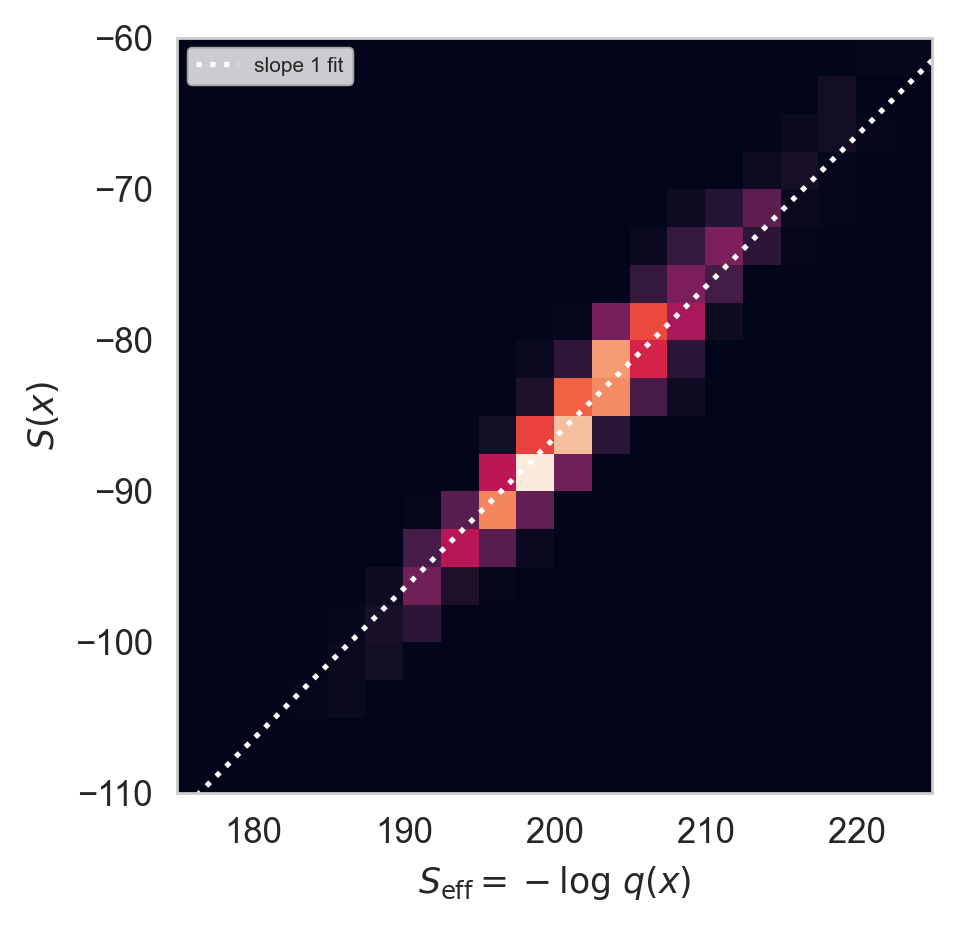

In [74]:
layers, prior = model['layers'], model['prior']
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)

S_eff = -grab(torch_logq)
S = grab(u1_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
_ = ax.hist2d(S_eff, S, bins=20, range=[[175, 225], [-110, -60]])
_ = ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
_ = ax.set_ylabel(r'$S(x)$')
_ = ax.set_aspect('equal')
xs = np.linspace(175, 225, num=4, endpoint=True)
_ = ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
_ = plt.legend(prop={'size': 6})

We can see how the model density evolved over training time to become well-correlated with $p(x)$ over time (if `use_pretrained == False`).

In [75]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[175, 225], [-110, -60]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
        ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        ax.set_title(f'Era {i * (N_era//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.show()
else:
    print('Skipping plot because use_pretrained == True')

Skipping plot because use_pretrained == True


We can reuse our Metropolis independence sampler from above to sample the theory using our model and check that we get a good acceptance rate. You should see an accept rate around 40-50% for the model trained above.

In [76]:
ensemble_size = 8192
u1_ens = make_mcmc_ensemble(model, u1_action, 64, ensemble_size)
print("Accept rate:", np.mean(u1_ens['accepted']))

# Observed acceptance rate: 0.228515625 
# much different from their quote of ~ 40-50% (????)

Accept rate: 0.228515625


Algorithms like HMC have a difficult time sampling from different topological sectors, exhibiting "topological freezing" where the topological charge $Q$ moves very slowly in Markov chain time. We can measure this quantity on the ensemble of U(1) configurations we just generated and see that it mixes quickly using our direct sampling approach. See <span data-cite="Kanwar:2020xzo">[arXiv:2003.06413](https://arxiv.org/abs/2003.06413)</span> for a detailed comparison against two standard approaches.

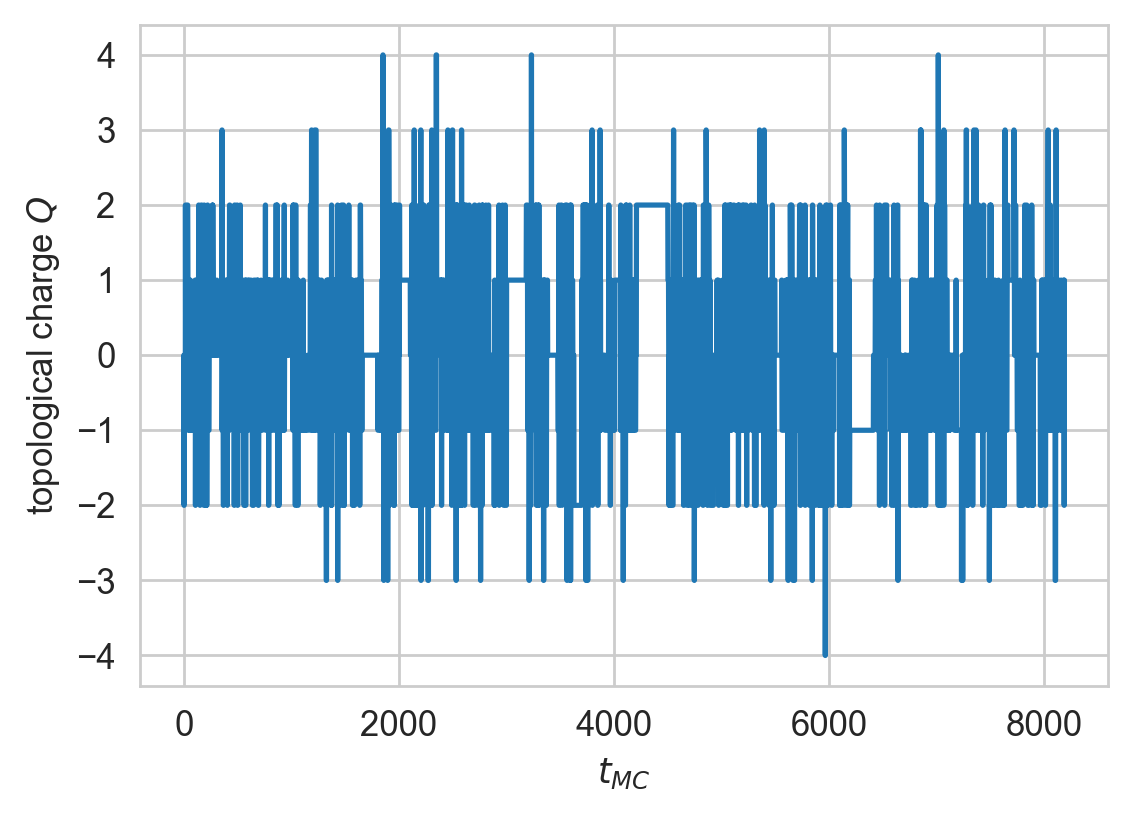

In [77]:
Q = grab(topo_charge(torch.stack(u1_ens['x'], axis=0)))
_ = plt.figure(figsize=(5,3.5), dpi=125)
_ = plt.plot(Q)
_ = plt.xlabel(r'$t_{MC}$')
_ = plt.ylabel(r'topological charge $Q$')

As with scalar theory, the generated ensemble is asymptotically unbiased. As an example of an observable measurement, we compute the topological susceptibility below and compare against a value determined from a large HMC ensemble evaluated at the same choice of parameters.

In [78]:
X_mean, X_err = bootstrap(Q**2, Nboot=100, binsize=16)
print(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 1.23 +/- 0.02')

Topological susceptibility = 1.28 +/- 0.05
... vs HMC estimate = 1.23 +/- 0.02
